# Get estcounts for each taxon at each sample



## Setup

In [2]:
import os 
import gc
import re
import csv
import glob
import math
import umap
import json
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
from tqdm import tqdm
from scipy import stats
from collections import * 
from sklearn import cluster
from sklearn import decomposition
from ete4 import NCBITaxa, Tree
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from scipy.spatial import distance
from scipy.cluster import hierarchy
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from scipy import stats, special
from numba import njit, prange, set_num_threads


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.chdir('/scratch/bgrodner/relative_abundance')

In [4]:
import sys
sys.path.append('/scratch/bgrodner/repo-armbrust-metat-search')

In [5]:
import functions.fn_metat_files as fnf
import functions.fn_correlation as fc
import functions.fn_regression_model as frm


In [6]:
ncbi = NCBITaxa()

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
os.getcwd()

'/scratch/bgrodner/relative_abundance'

In [9]:
workdir = '/scratch/bgrodner/p_calceolata_enterobactin'
os.chdir(workdir)


In [10]:
os.getcwd()

'/scratch/bgrodner/p_calceolata_enterobactin'

In [11]:
os.listdir()

['file_table.240210.kofam_filt.csv',
 'nb_enterobactin.ipynb',
 '.DS_Store',
 'nb_pelagophycae.ipynb',
 '.snakemake',
 'file_table.240307.pelagophyceae_taxids.csv',
 '._.DS_Store',
 'pelagophyceae_taxids.txt',
 'config.yaml',
 'metat_search_results',
 '._file_table.240307.pelagophyceae_taxids.csv',
 'sc_run_snakemake.sh',
 '._file_table.240210.kofam_filt.csv',
 'tidytable_enterobactin_kos.csv']

Plotting

In [12]:
def general_plot(
    xlabel="", ylabel="", ft=12, dims=(5, 3), col="k", lw=1, pad=0, tr_spines=True
):
    fig, ax = plt.subplots(figsize=(dims[0], dims[1]), tight_layout={"pad": pad})
    for i in ax.spines:
        ax.spines[i].set_linewidth(lw)
    if not tr_spines:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    else:
        ax.spines["top"].set_color(col)
        ax.spines["right"].set_color(col)
    ax.spines["bottom"].set_color(col)
    ax.spines["left"].set_color(col)
    ax.tick_params(direction="in", labelsize=ft, color=col, labelcolor=col)
    ax.set_xlabel(xlabel, fontsize=ft, color=col)
    ax.set_ylabel(ylabel, fontsize=ft, color=col)
    ax.patch.set_alpha(0)
    return (fig, ax)

def plot_umap(
    embedding,
    figsize=(10, 10),
    markersize=10,
    alpha=0.5,
    colors="k",
    xticks=[],
    yticks=[],
    markerstyle='o',
    cmap_name='tab20',
    cl_lab=False
):
    fig, ax = general_plot(dims=figsize)
    if isinstance(markerstyle, str):
        ax.scatter(
            embedding[:, 0],
            embedding[:, 1],
            s=markersize,
            alpha=alpha,
            c=colors,
            edgecolors="none",
            marker=markerstyle,
            cmap=cmap_name
        )
    else:
        for e0, e1, c, m in zip(
            embedding[:, 0], 
            embedding[:, 1],
            colors,
            markerstyle 
        ):
            ax.scatter(
                e0,
                e1,
                s=markersize,
                alpha=alpha,
                c=c,
                edgecolors="none",
                marker=m
            )
    ax.set_aspect("equal")
    if len(xticks) > 0:
        ax.set_xticks(xticks)
    if len(yticks) > 0:
        ax.set_yticks(yticks)
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    return fig, ax


def general_plot(
    xlabel="", ylabel="", ft=12, dims=(5, 3), col="k", lw=1, pad=0, tr_spines=True
):
    fig, ax = plt.subplots(figsize=(dims[0], dims[1]), tight_layout={"pad": pad})
    for i in ax.spines:
        ax.spines[i].set_linewidth(lw)
    if not tr_spines:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    else:
        ax.spines["top"].set_color(col)
        ax.spines["right"].set_color(col)
    ax.spines["bottom"].set_color(col)
    ax.spines["left"].set_color(col)
    ax.tick_params(direction="in", labelsize=ft, color=col, labelcolor=col)
    ax.set_xlabel(xlabel, fontsize=ft, color=col)
    ax.set_ylabel(ylabel, fontsize=ft, color=col)
    ax.patch.set_alpha(0)
    return (fig, ax)


def plot_umap(
    embedding,
    figsize=(10, 10),
    markersize=10,
    alpha=0.5,
    colors="k",
    xticks=[],
    yticks=[],
    markerstyle='o'
):
    fig, ax = general_plot(dims=figsize)
    if isinstance(markerstyle, str):
        ax.scatter(
            embedding[:, 0],
            embedding[:, 1],
            s=markersize,
            alpha=alpha,
            c=colors,
            edgecolors="none",
            marker=markerstyle
        )
    else:
        for e0, e1, c, m in zip(
            embedding[:, 0], 
            embedding[:, 1],
            colors,
            markerstyle 
        ):
            ax.scatter(
                e0,
                e1,
                s=markersize,
                alpha=alpha,
                c=c,
                edgecolors="none",
                marker=m
            )
    ax.set_aspect("equal")
    if len(xticks) > 0:
        ax.set_xticks(xticks)
    if len(yticks) > 0:
        ax.set_yticks(yticks)
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    return fig, ax


def get_colors_from_stringlist(stringlist, order="", cmap_name="viridis"):
    if not order:
        order = list(set(stringlist))
    n_strings = len(order)
    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(i / n_strings) for i in range(n_strings)]
    dict_str_col = {s: c for s, c in zip(order, colors)}
    return [dict_str_col[s] for s in stringlist], dict_str_col


def plot_legend(color_dict, figsize=(2, 4)):
    fig, ax = general_plot(dims=figsize)
    # Create legend handles manually
    legend_handles = []
    for value, color in color_dict.items():
        patch = mpatches.Patch(color=color, label=value)
        legend_handles.append(patch)

    # Add legend to the plot
    ax.legend(handles=legend_handles)
    return fig, ax


def taxon_legend(
    taxon_names,
    taxon_colors,
    label_color="k",
    taxon_counts=[],
    text_shift_vh=(6, 0.15),
    ft=20,
    dims=(6, 10),
    lw=2,
    ylabel="Genus",
):
    fig, ax = general_plot(ylabel=ylabel, dims=dims, col=label_color, lw=lw, ft=ft)
    vals = np.repeat(10, len(taxon_names))
    y_pos = np.arange(len(taxon_names))
    ax.barh(y_pos, vals, align="center", color=taxon_colors)
    if len(taxon_counts) > 0:
        # Label the legend with counts
        for i, (v, c) in enumerate(zip(vals, taxon_counts)):
            ax.text(
                v - text_shift_vh[0],
                i + text_shift_vh[1],
                str(c),
                color="k",
                fontsize=ft,
            )
    # Remove the boundaries
    for spine in ax.spines.values():
        spine.set_visible(False)
    # Add the genus names to the y axis
    ax.set_yticks(y_pos)
    ax.set_xticks([])
    ax.set_yticklabels(taxon_names)
    ax.invert_yaxis()
    return (fig, ax)


def marker_legend(
    names,
    markers,
    label_color="k",
    text_shift_hv=(0.5, 0),
    markersize=50,
    ft=20,
    dims=(3, 3),
    lw=2,
    ylabel="Genus",
):
    fig, ax = general_plot(ylabel=ylabel, dims=dims, col=label_color, lw=lw, ft=ft)
    for i, (n, m) in enumerate(zip(names, markers)):
        ax.scatter(0, i, marker=m, c=label_color, s=markersize)
        # ax.text(
        #     0 - text_shift_hv[0],
        #     i + text_shift_hv[1],
        #     str(n),
        #     color=label_color,
        #     fontsize=ft,
        #     va="center",
        # )
    # Remove the boundaries
    for spine in ax.spines.values():
        spine.set_visible(False)
    # Add the genus names to the y axis

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, i + 1])

    ax.set_yticks(np.arange(i+1))
    ax.set_xticks([])
    ax.set_yticklabels(names)
    ax.invert_yaxis()
    ax.invert_yaxis()
    return fig, ax

#### Get KO dict

Get dataframe

In [13]:
ko_fn = "../iron_ko_contigs/ko00001.json"
database = list()
for _, v in pd.read_json(ko_fn).iterrows():
    d = v["children"]
    cat_1 = d["name"]
    for child_1 in d["children"]:
        cat_2 = child_1["name"] # Module?
        for child_2 in child_1["children"]:
            cat_3 = child_2["name"]
            if "children" in child_2:
                for child_3 in child_2["children"]:
                    cat_4 = child_3["name"]
                    fields = [cat_1, cat_2, cat_3, cat_4]
                    database.append(fields)
df_kegg = pd.DataFrame(database, columns=["Level_A", "Level_B", "Level_C", "Level_D"])
df_kegg.shape


(61993, 4)

In [14]:
ld = df_kegg['Level_D'].values
ld[:5]

array(['K00844  HK; hexokinase [EC:2.7.1.1]',
       'K12407  GCK; glucokinase [EC:2.7.1.2]',
       'K00845  glk; glucokinase [EC:2.7.1.2]',
       'K25026  glk; glucokinase [EC:2.7.1.2]',
       'K01810  GPI, pgi; glucose-6-phosphate isomerase [EC:5.3.1.9]'],
      dtype=object)

In [15]:
dict_ko_name = {}
for name in ld:
    ko = re.search(r"^\w+",name)[0]
    dict_ko_name[ko] = name

Get metadata table

In [16]:
metadata_path = "/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/tidy_tables/merge_all/iron_KOs.txt-metadata.csv"  # input('Enter the filepath of your batch metadata file:')
metadata = pd.read_csv(metadata_path)
metadata.iloc[[1,100,200],:]

assembly sample  latitude ammendment     timepoint  depth   size rep  \
1       D1PA  S15C1       NaN        NaN           200    NaN    NaN   C   
100     G1NS  S11C1  36.57deg        NaN  4_29_16-6:34  15.0m  0.2um   B   
200     G2PA  S06C1  39.76deg        NaN           NaN  15.0m  0.2um   B   

                              fn_sample_counts  \
1               D1PA.S15C1_C_200.abundance.tsv   
100                     G1NS.S11C1_0_2um.B.tsv   
200  G2PA.G2PA.S06C1.15m.0_2um.B.abundance.tsv   

                                      assm_sample  norm_factor  
1                                  D1PA-S15C1-200  1970.000000  
100  G1NS-S11C1-36.57deg-4_29_16-6:34-15.0m-0.2um  3654.720049  
200               G2PA-S06C1-39.76deg-15.0m-0.2um  7091.826806

Correct G1 S11C1 latitudes

In [17]:
metadata.shape

(531, 11)

In [18]:
lats_new = []
for i, row in metadata.iterrows():
    if (row['sample'] == 'S11C1') & ('G1' in row['assembly']):
        lats_new.append('36.569deg')
    else:
        lats_new.append(row.latitude)
metadata['latitude'] = lats_new
metadata.iloc[[1,100,200,500],:]

assembly sample   latitude ammendment     timepoint  depth   size rep  \
1       D1PA  S15C1        NaN        NaN           200    NaN    NaN   C   
100     G1NS  S11C1  36.569deg        NaN  4_29_16-6:34  15.0m  0.2um   B   
200     G2PA  S06C1   39.76deg        NaN           NaN  15.0m  0.2um   B   
500       G5   Mix1        NaN        DON            T2    NaN    NaN   C   

                              fn_sample_counts  \
1               D1PA.S15C1_C_200.abundance.tsv   
100                     G1NS.S11C1_0_2um.B.tsv   
200  G2PA.G2PA.S06C1.15m.0_2um.B.abundance.tsv   
500                       G5.Mix1.DON.T2.C.tsv   

                                      assm_sample  norm_factor  
1                                  D1PA-S15C1-200  1970.000000  
100  G1NS-S11C1-36.57deg-4_29_16-6:34-15.0m-0.2um  3654.720049  
200               G2PA-S06C1-39.76deg-15.0m-0.2um  7091.826806  
500                                G5-Mix1-DON-T2  4262.243999

Get cruise column

In [19]:
metadata.assembly.unique()

array(['D1PA', 'G1PA', 'G1NS', 'G2PA', 'G2NS', 'G3PA', 'G3PA.diel',
       'G3.UW.NS', 'G3PA.PM', 'G5'], dtype=object)

In [20]:
skp = ['D1PA','G3PA.diel','G3PA.PM','G5']
metadata['cruise'] = [assm[:2] if assm not in skp else assm for assm in metadata.assembly]
sels = []
for assm in metadata.assembly:
    if 'NS' in assm:
        sels.append('NS')
    elif assm == 'G5':
        sels.append('NS')
    else:
        sels.append('PA')

metadata['selection'] = sels
metadata.cruise.unique(), metadata.selection.unique()

(array(['D1PA', 'G1', 'G2', 'G3', 'G3PA.diel', 'G3PA.PM', 'G5'],
       dtype=object),
 array(['PA', 'NS'], dtype=object))

Batch column

In [21]:
batchs = []
for i, row in metadata.iterrows():
    cruise, sel, size = [row[v] for v in ['cruise','selection','size']]
    batchs.append(f'{cruise}_{sel}_{size}')

metadata['batch'] = batchs

North vs south transit

In [38]:
# fns_mt = [
#     '/scratch/bgrodner/repo-armbrust-metat/gradients1/g1_station_ns_metat/sample_metadata.csv',
#     '/scratch/bgrodner/repo-armbrust-metat/gradients2/g2_station_ns_metat/sample_metadata.csv',
#     '/scratch/bgrodner/repo-armbrust-metat/gradients3/g3_uw_ns_metat/sample_metadata.csv',
# ]

# for fn in fns_mt:
#     print(fn)
#     print(pd.read_csv(fn)[:3])

metadata.loc[metadata.assembly == 'G3.UW.NS','sample'].unique()

array(['UW38_1', 'UW32_3', 'UW25_1', 'UW40_1', 'UW35_2', 'UW29_1',
       'UW37_1', 'UW40_2', 'UW32_1', 'UW35_1', 'UW31_2'], dtype=object)

Map fnsamplecounts to metadata

In [488]:
dict_meta = {}
for i, row in metadata.iterrows():
    dict_meta[row['fn_sample_counts']] = row.to_dict()

In [489]:
dict_assam_meta = {}
for i, row in metadata.iterrows():
    dict_assam_meta[row['assm_sample']] = row.to_dict()

In [490]:
dict_batch_meta = {}
for i, row in metadata.iterrows():
    dict_batch_meta[row['batch']] = row.to_dict()

In [491]:
dict_assam_lat = dict(zip(metadata['assm_sample'], metadata['latitude']))


TZCF info

In [492]:
dict_cruise_trans_sal_chl = {
    'G1': [32.15, 33.0],
    'G2': [32.5, 36.2],
    'G3': [32.34, 35],
}

## Example file

### Load contig taxon map

filename

In [493]:
fn_contig_tax = '/mnt/nfs/projects/armbrust-metat/gradients2/g2_station_ns_metat/assemblies/MarMicro_MarFerr_Diamond_2024_04_14/G2NS_ALL_MarFer_MMDB.tab'
with open(fn_contig_tax, 'r') as f:
    for _ in range(5):
        print(next(f))

G2NS.S02C1.15m.0_2um_TRINITY_DN85_c0_g1_i1	0	0

G2NS.S02C1.15m.0_2um_TRINITY_DN92_c0_g1_i1	0	0

G2NS.S02C1.15m.0_2um_TRINITY_DN90_c0_g1_i1	0	0

G2NS.S02C1.15m.0_2um_TRINITY_DN57_c0_g1_i1	131567	7.8e-19

G2NS.S02C1.15m.0_2um_TRINITY_DN58_c0_g1_i1	0	0



Load dict

In [494]:
dict_contig_tax = {}
with open(fn_contig_tax, 'r') as f:
    for row in f:
        contig, ec, _ = row.split('\t')
        dict_contig_tax[contig] = ec

print(f'{len(dict_contig_tax):,} lines read')
fnf.getmem()

31,493,574 lines read
Current memory usage: 8880.09 MB


### Add counts to taxon for each sample

Filenames

In [495]:
dir_kallisto = '/mnt/nfs/projects/armbrust-metat/gradients2/g2_station_ns_metat/assemblies/ReadCounts/'
fns_kallisto = glob.glob(f'{dir_kallisto}/*/*.tsv')
fns_kallisto

['/mnt/nfs/projects/armbrust-metat/gradients2/g2_station_ns_metat/assemblies/ReadCounts/G2NS.S16C1.15m.0_2um.C/G2NS.S16C1.15m.0_2um.C.tsv',
 '/mnt/nfs/projects/armbrust-metat/gradients2/g2_station_ns_metat/assemblies/ReadCounts/G2NS.S02C1.15m.0_2um.C/G2NS.S02C1.15m.0_2um.C.tsv',
 '/mnt/nfs/projects/armbrust-metat/gradients2/g2_station_ns_metat/assemblies/ReadCounts/G2NS.S17C1.15m.0_2um.A/G2NS.S17C1.15m.0_2um.A.tsv',
 '/mnt/nfs/projects/armbrust-metat/gradients2/g2_station_ns_metat/assemblies/ReadCounts/G2NS.S07C1.15m.0_2um.C/G2NS.S07C1.15m.0_2um.C.tsv',
 '/mnt/nfs/projects/armbrust-metat/gradients2/g2_station_ns_metat/assemblies/ReadCounts/G2NS.S06C1.15m.0_2um.A/G2NS.S06C1.15m.0_2um.A.tsv',
 '/mnt/nfs/projects/armbrust-metat/gradients2/g2_station_ns_metat/assemblies/ReadCounts/G2NS.S16C1.15m.3um.B/G2NS.S16C1.15m.3um.B.tsv',
 '/mnt/nfs/projects/armbrust-metat/gradients2/g2_station_ns_metat/assemblies/ReadCounts/G2NS.S09C1.15m.0_2um.A/G2NS.S09C1.15m.0_2um.A.tsv',
 '/mnt/nfs/projects/armb

In [496]:
len(fns_kallisto)

60

Iterate over samples

In [497]:
dict_sam_tax_estcounts = defaultdict(lambda: defaultdict(float))
for fn in fns_kallisto[:1]:
    sam = os.path.split(fn)[1]
    sam = os.path.splitext(sam)[0]
    print(sam)
    with open(fn, 'r') as f:
        _ = next(f)  # skip header
        for i, row in enumerate(f):
            contig, _, _, ec, _ = row.split('\t')
            ec = float(ec)
            if ec:
                tax = dict_contig_tax[contig]
                dict_sam_tax_estcounts[sam][tax] += ec
            if i%1e6 == 0:
                print(f'{i:,} lines read', end='\r')


G2NS.S16C1.15m.0_2um.C


### Faster to load each contig tax dict multiple times in parallel or single time and then get each sample in series?

Series

In [498]:
tl = 24.8 + 60*26.4
tl

1608.8

Compare to parallel as cores increase

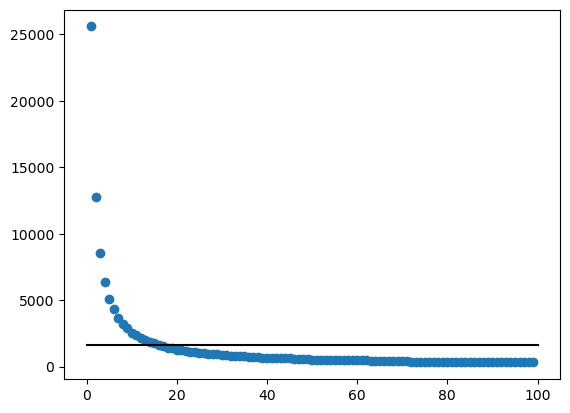

In [499]:
j = np.arange(1,100)
tp = np.ceil(500/j) * (24.8 + 26.4)
tp
plt.scatter(j, tp)
plt.plot([0,100],[tl]*2, 'k')

## Collapse counts to the trimmed tree

Get tree trim file

In [500]:
fn_tree_trim = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/tree_trim/merge_all/iron_KOs.txt-barnacle_tensor_tidy-tree_trim_thresh_60_minsamples_20_minbatches_4.csv'
with open(fn_tree_trim, 'r') as f:
    for _ in range(5):
        print(next(f))

assm_sample,KO,taxon_trim,estcounts,rep

D1PA-S06C1-600,K00175,28211,0.0,C

D1PA-S15C1-200,K00175,28211,1.0,C

D1PA-S34C1-2200,K00175,28211,0.0,C

D1PA-S16C1-600,K00175,28211,0.0,B



Get set of taxa

In [501]:
list_taxa = []
with open(fn_tree_trim, 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        list_taxa.append(row['taxon_trim'])
set_taxa = set(list_taxa)
set_taxa

{'1003176',
 '116569',
 '1224',
 '1236',
 '131567',
 '2',
 '2608131',
 '2696291',
 '2698737',
 '2759',
 '28211',
 '2836',
 '2864',
 '3041',
 '33090',
 '33154',
 '33213',
 '33313',
 '33656',
 '33836',
 '35140',
 '35675',
 '35677',
 '39119',
 '407301',
 '40984',
 '41874',
 '43686',
 '78238',
 '89954',
 '976'}

Get Tree

In [502]:
tree = ncbi.get_topology(set_taxa)

print(tree.to_str(props=['sci_name', 'name'], compact=True))

                                                                 ╭╴Pseudomonadota,1224╶┬╴Alphaproteobacteria,28211
                           ╭╴Bacteria,2╶╌╴Pseudomonadati,3379134╶┤                     ╰╴Gammaproteobacteria,1236
                           │                                     ╰╴Bacteroidota,976
                           │                ╭╴Opisthokonta,33154╶╌╴Bilateria,33213╶╌╴Protostomia,33317╶┬╴Gastrotricha,33313╶╌╴Macrodasyida,78238
╴cellular organisms,131567╶┤                │                                                          ╰╴Neocopepoda,116569
                           │                │                                ╭╴Gonyaulacales,40984
                           │                │             ╭╴Dinophyceae,2864╶┼╴Suessiales,89954╶╌╴Pelagodinium beii,43686
                           ╰╴Eukaryota,2759╶┼╴Sar,2698737╶┤                  ╰╴Kareniaceae,1003176╶╌╴Karlodinium veneficum,407301
                                            │             │        

All taxa counts filename

In [503]:
fn_taxon_estcounts = '/scratch/bgrodner/relative_abundance/metat_search_results/sample_taxa_estcounts/G2NS/G2NS-G2NS.S18C1.15m.3um.C.tsv-count_sum.txt'
with open(fn_taxon_estcounts, 'r') as f:
    for _ in range(5):
        print(next(f))


0,14311410.132006835

47790,650.9903770416199

6835,26891.40272458314

2864,2654403.358860978

131567,865552.5532292656



Get dict

In [504]:
dict_tax_estcounts = {}
with open(fn_taxon_estcounts, 'r') as f:
    reader = csv.reader(f)
    for tax, ec in reader:
        dict_tax_estcounts[tax] = float(ec)

Total counts

In [505]:
total_estcounts = 0
for _, ec in dict_tax_estcounts.items():
    total_estcounts += ec

Get Tree

In [506]:
tax_untrim = list(dict_tax_estcounts.keys())
tax_untrim.remove('0')
tree_untrim = ncbi.get_topology(tax_untrim)
print(tree_untrim.to_str(props=['sci_name','name'], compact=True))

                                                                                                                                                                       ╭╴Vibrio litoralis,335972
                                                                                                                                                                       │                             ╭╴Vibrio alginolyticus,663
                                                                                                                                                                       ├╴Vibrio harveyi group,717610╶┼╴Vibrio campbellii,680╶╌╴Vibrio campbellii CAIM 519 = NBRC 15631 = ATCC 25920,1224742
                                                                                                                                                                       │                             ├╴Vibrio natriegens,691
                                                                              

Get taxtrim dict

In [507]:
dict_taxtrim_estcounts = defaultdict(float)
set_tax_tree = [n.name for n in tree.traverse()]
for tax, ec in dict_tax_estcounts.items():
    if (tax in set_tax_tree) or (int(tax) == 0):
        dict_taxtrim_estcounts[tax] += ec
    else:
        lin = ncbi.get_lineage(tax)
        lin.reverse()
        for t in lin:
            t = str(t)
            if t in set_tax_tree:
                dict_taxtrim_estcounts[t] += ec
                # ec_tot += ec
                break

In [508]:
ec_tot = 0
for _, ec in dict_taxtrim_estcounts.items():
    ec_tot += ec

ec_tot / total_estcounts

0.9999999999999989

Add counts to tree

In [509]:
ec_tot = 0
for n in tree.traverse():
    ec = dict_taxtrim_estcounts.get(n.name)
    if ec:
        ec_tot += ec
        n.add_props(estcounts=round(ec))

print(ec_tot / total_estcounts)
print(tree.to_str(props=['sci_name','estcounts'], compact=True))

0.5740185558937397
                                                                    ╭╴Pseudomonadota,28860╶┬╴Alphaproteobacteria,61209
                           ╭╴Bacteria,802450╶╌╴Pseudomonadati,30998╶┤                      ╰╴Gammaproteobacteria,620934
                           │                                        ╰╴Bacteroidota,139995
                           │                   ╭╴Opisthokonta,54202╶╌╴Bilateria,58937╶╌╴Protostomia,18047╶┬╴Gastrotricha,⊗╶╌╴Macrodasyida,⊗
╴cellular organisms,872900╶┤                   │                                                          ╰╴Neocopepoda,2427813
                           │                   │                                  ╭╴Gonyaulacales,1375436
                           │                   │            ╭╴Dinophyceae,3311588╶┼╴Suessiales,79142╶╌╴Pelagodinium beii,75416
                           ╰╴Eukaryota,5172773╶┼╴Sar,402199╶┤                     ╰╴Kareniaceae,172868╶╌╴Karlodinium veneficum,211250
                 

Add relative abundance to tree

In [510]:
pct_total = 0
ec_total = 0
for n in tree.traverse():
    ec = dict_taxtrim_estcounts.get(n.name)
    if ec:
        ec_total += ec
        pct = ec / total_estcounts * 100
        pct_total += pct
        n.add_props(pct_ec=f'{round(pct, 4)}%')
print(pct_total, ec_total / total_estcounts)
print(tree.to_str(props=['sci_name','pct_ec'], compact=True)) 

57.40185558937395 0.5740185558937397
                                                                        ╭╴Pseudomonadota,0.0859%╶┬╴Alphaproteobacteria,0.1822%
                            ╭╴Bacteria,2.3885%╶╌╴Pseudomonadati,0.0923%╶┤                        ╰╴Gammaproteobacteria,1.8482%
                            │                                           ╰╴Bacteroidota,0.4167%
                            │                    ╭╴Opisthokonta,0.1613%╶╌╴Bilateria,0.1754%╶╌╴Protostomia,0.0537%╶┬╴Gastrotricha,⊗╶╌╴Macrodasyida,⊗
╴cellular organisms,2.5982%╶┤                    │                                                                ╰╴Neocopepoda,7.2264%
                            │                    │                                  ╭╴Gonyaulacales,4.094%
                            │                    │             ╭╴Dinophyceae,9.857%╶┼╴Suessiales,0.2356%╶╌╴Pelagodinium beii,0.2245%
                            ╰╴Eukaryota,15.3968%╶┼╴Sar,1.1972%╶┤                    ╰╴Kare

frac at root or unannotated

In [511]:
pct = dict_tax_estcounts['0'] / total_estcounts * 100
print(f'{round(pct , 5)}% unannotated')


42.59814% unannotated


Sort by which taxa have the most reads

In [512]:
pcts = []
taxs = []
for tax, ec in dict_tax_estcounts.items():
    pct = ec / total_estcounts * 100
    pcts.append(pct)
    taxs.append(tax)

taxs = [x for _, x in sorted(zip(pcts,taxs), reverse=True)]
pcts.sort(reverse=True)
for i in range(10):
    print(round(pcts[i],4), '%','\t',taxs[i], ncbi.get_taxid_translator([taxs[i]]) )

42.5981 % 	 0 {}
15.2878 % 	 2759 {2759: 'Eukaryota'}
7.9009 % 	 2864 {2864: 'Dinophyceae'}
5.7735 % 	 113644 {113644: 'Calanus glacialis'}
4.5732 % 	 35127 {35127: 'Thalassiosira'}
3.2613 % 	 2926 {2926: 'Alexandrium tamarense'}
2.5763 % 	 131567 {131567: 'cellular organisms'}
1.5103 % 	 1960171 {1960171: 'Minidiscus sp. RCC4584'}
1.2632 % 	 2 {2: 'Bacteria'}
0.9596 % 	 2713251 {2713251: 'Abedinium folium'}


In [513]:
pcts = []
taxs = []
for tax, ec in dict_taxtrim_estcounts.items():
    pct = ec / total_estcounts * 100
    pcts.append(pct)
    taxs.append(tax)

taxs = [x for _, x in sorted(zip(pcts,taxs), reverse=True)]
pcts.sort(reverse=True)
print(sum(pcts))
for i in range(len(taxs)):
    print(round(pcts[i],4), '%','\t',taxs[i], ncbi.get_taxid_translator([taxs[i]]) )

99.99999999999989
42.5981 % 	 0 {}
15.3968 % 	 2759 {2759: 'Eukaryota'}
9.857 % 	 2864 {2864: 'Dinophyceae'}
7.2264 % 	 116569 {116569: 'Neocopepoda'}
6.9382 % 	 33836 {33836: 'Coscinodiscophyceae'}
4.094 % 	 40984 {40984: 'Gonyaulacales'}
2.5982 % 	 131567 {131567: 'cellular organisms'}
2.3885 % 	 2 {2: 'Bacteria'}
1.8482 % 	 1236 {1236: 'Gammaproteobacteria'}
1.1972 % 	 2698737 {2698737: 'Sar'}
0.9749 % 	 2608131 {2608131: 'Prymnesiophyceae'}
0.6898 % 	 2836 {2836: 'Bacillariophyta'}
0.6288 % 	 407301 {407301: 'Karlodinium veneficum'}
0.5145 % 	 1003176 {1003176: 'Kareniaceae'}
0.4167 % 	 976 {976: 'Bacteroidota'}
0.4017 % 	 33656 {33656: 'Phaeocystis'}
0.3306 % 	 35140 {35140: 'Chrysochromulina'}
0.3093 % 	 2696291 {2696291: 'Ochrophyta'}
0.2356 % 	 89954 {89954: 'Suessiales'}
0.2245 % 	 43686 {43686: 'Pelagodinium beii'}
0.1822 % 	 28211 {28211: 'Alphaproteobacteria'}
0.1754 % 	 33213 {33213: 'Bilateria'}
0.1613 % 	 33154 {33154: 'Opisthokonta'}
0.1577 % 	 3041 {3041: 'Chlorophyta'

## Get cruise-sample profiles after running snakemake

Snakefile_all_taxa_estcounts -> a tidytable with all the relative abundance info

In [514]:
fn_relabund = '/scratch/bgrodner/relative_abundance/metat_search_results/sample_taxa_estcounts/merge-sample_taxid_estcounts-tidy.txt'

Map fnsamplecounts to metadata

In [515]:
dict_meta = {}
for i, row in metadata.iterrows():
    dict_meta[row['fn_sample_counts']] = row.to_dict()

Add metadata to rows

In [516]:
dict_relabund = defaultdict(list)
with open(fn_relabund, 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        # Get metadata for sample
        meta_row = dict_meta[row['fn_sample_counts']]
        # Determine selection type
        batch_bool = [s in row['batch'] for s in ['NS','G5']]
        if any(batch_bool):
            selec = 'NS'
        else:
            selec = 'PA'
        dict_relabund['selection'].append(selec)
        # Merge metadata and sample
        dict_row = row | meta_row
        # Add to main dict
        for k, v in dict_row.items():
            dict_relabund[k].append(v)
        

Build dataframe

In [517]:
df_relabund = pd.DataFrame(dict_relabund).fillna('')

ValueError: All arrays must be of the same length

Separate out selection and size fraction

In [ ]:
df_relabund['size'].unique(), df_relabund['selection'].unique(), df_relabund['batch'].unique()

In [ ]:
dict_sel_size_df = defaultdict(dict)
for sel in df_relabund['selection'].unique():
    bool_sel = df_relabund['selection'] == sel
    for size in df_relabund['size'].unique():
        sz = size
        if not size:
            sz = 'none'
        bool_size = df_relabund['size'] == size
        df = df_relabund[bool_sel & bool_size]
        dict_sel_size_df[sel][sz] = df

Convert assm_sample to cruise-location

In [ ]:
metadata['cruise'] = [assm[:2] for assm in metadata.assembly]
metadata.cruise.unique(), metadata.assembly.unique()

In [ ]:
dict_sam_csam = {}
for i, row in metadata.iterrows():
    if (row.cruise not in ['D1', 'G5']) and (row.assembly not in ['G3PA.diel', 'G3PA.PM']):
        csam = f"{row.cruise}-{row.latitude}"
    else:
        csam = row.assm_sample
    dict_sam_csam[row.assm_sample] = csam
dict_sam_csam

Cruise-location profiles for each taxon

In [ ]:
dict_sel_size_meanstd = defaultdict(dict)
for sel, dict_size_df in dict_sel_size_df.items():
    for size, df in dict_size_df.items():
        df = df.copy()
        print(sel, size, df.shape)
        if df.shape[0] > 0:
            df['frac_total_estcounts'] = df['frac_total_estcounts'].astype(float)
            mean_assm_sample = df.groupby(
                ['taxid','assm_sample']
            )['frac_total_estcounts'].mean().unstack(level=0).fillna(0)
            std_assm_sample = df.groupby(
                ['taxid','assm_sample']
            )['frac_total_estcounts'].std().unstack(level=0).fillna(0)
            mean_assm_sample.index = [dict_sam_csam[s] for s in mean_assm_sample.index]
            std_assm_sample.index = [dict_sam_csam[s] for s in std_assm_sample.index]
            dict_sel_size_meanstd[sel][size] = [mean_assm_sample, std_assm_sample]


## Correlate taxon location profiles

plot linkages

In [ ]:
# Correlation plots
dict_sel_size_t = {
    'PA': {
        'none': 20,
        '3.0um': 25,
        '0.2um': 28,
    },
    'NS': {
        'none': 20,
        '3.0um': 18,
        '0.2um': 35,
    }
}
crit = 'maxclust'
max_sam = 10

filt_frac = 0.01 # taxa must have more than this fraction when summed across samples

corr_method = 'pearson'

# spatial plots
ft0 = 8
ft1 = 12
plt.rcParams['font.size'] = ft1
dims_sub_lat = (22,12)
dims_exp = (16,12)
dict_cruise_j = {
    'G1': 0,
    'G2': 1,
    'G3': 2,
    'D1PA': 0,
    'G3PA.diel': 1,
    'G3PA.PM': 2,
    'G5': 3,
}

for sel, dict_size_dfs in dict_sel_size_meanstd.items():
    for size, dfs in dict_size_dfs.items():
        mean_df = dfs[0]
        ms = mean_df.sum(axis=0)
        mean_df_filt = mean_df.loc[:,ms > filt_frac]
        print(mean_df.shape, mean_df_filt.shape)
        
        # calculate correlation matrix
        corr_df = mean_df_filt.corr(method=corr_method)
        corr_df = corr_df.replace({np.nan: 0})
        # Precalculate linkage to extract clusters later
        link = hierarchy.linkage(distance.pdist(np.asarray(corr_df)))

        t = dict_sel_size_t[sel][size]

        clust = hierarchy.fcluster(link, t=t, criterion=crit)
        nclust = np.unique(clust).shape[0]

        cmap = list(plt.get_cmap('tab20').colors)
        cmap *= math.ceil(nclust / len(cmap))
        clorder =[]
        for idx in hierarchy.leaves_list(link):
            cl = clust[idx]
            if cl not in clorder:
                clorder.append(cl)
        lut = dict(zip(clorder, cmap))
        # idx_df = hierarchy.leaves_list(links[mode])
        row_colors = [lut[cl] for cl in clust]

        # make clustered heatmap
        # using precalculated linkage
        g = sns.clustermap(
            corr_df.fillna(0), 
            row_linkage=link, col_linkage=link,
            row_colors=row_colors,
            col_colors=row_colors,
            mask=corr_df.isna(), 
            cmap='PuOr_r', vmin=-1, vmax=1, 
            cbar_kws={'shrink':0.5, 'label':f'{corr_method}\nCorrelation'}, 
        )
            # xticklabels=True, yticklabels=True
        # g = sns.clustermap(
        #     corr_df.fillna(0), mask=corr_df.isna(), cmap='PuOr_r', vmin=-1, vmax=1, cbar_kws={'shrink':0.5, 'label':'Pearson\nCorrelation'}, 
        #     xticklabels=True, yticklabels=True
        # )
        g.fig.suptitle(f"Similarity of relative abundance between Taxa in {sel} selection and {size} filter", y=1.02); 
        plt.show(g)
        plt.close()


        # Plot clusters over space
        clorder_trim = [cl for cl in clorder if sum(clust == cl) > 3]
        nrows = len(clorder_trim)
        fig_lat, axes_lat = plt.subplots(
            nrows=nrows, 
            ncols=3, 
            sharex=True, 
            figsize=(20,nrows*1.5)
        )
        fig_exp, axes_exp = plt.subplots(
            nrows=nrows,
            ncols=4, 
            figsize=(20,nrows)
        )
        profile_df = mean_df_filt.copy()
        profile_df = profile_df / profile_df.max(axis=0)
        profile_df = profile_df.T
        i = 0
        for ic, cl in enumerate(clorder):
            bool_cl = clust == cl
            if sum(bool_cl) > 3:
                dict_cruise_loc_weigts = defaultdict(dict)

                profile_cl = profile_df[bool_cl]
                for csam in profile_cl.columns:
                    cruise, info = csam.split('-',1)
                    if cruise not in ['D1PA', 'G5','G3PA.diel','G3PA.PM']:
                        info = float(info.strip('deg'))
                    vals = profile_cl[csam].values
                    if len(vals.shape) > 1:
                        vals = np.mean(vals, axis=1)
                    dict_cruise_loc_weigts[cruise][info] = vals

                # Plot each cruise separately
                for cruise, dict_loc_weights in dict_cruise_loc_weigts.items():
                    dfc = pd.DataFrame(dict_loc_weights)
                    j = dict_cruise_j[cruise]
                    if cruise not in ['D1PA', 'G5','G3PA.diel','G3PA.PM']:
                        ax = axes_lat[i,j]
                        # fig, ax = plt.subplots(figsize=dims_lat)
                        bp = ax.boxplot(dfc.values, positions=dfc.columns, patch_artist=True)
                        # dfc.boxplot(ax=ax, positions=dfc.columns)
                        # ax.set_xlim(23,43)
                        # ax.set_xlabel('Latitude', fontsize=ft1)
                        if i == nrows - 1:
                            xticks = np.arange(20,45,5).astype(int)
                            ax.set_xticks(xticks)
                            ax.set_xticklabels(xticks)
                            ax.tick_params(axis='both', labelsize=ft1) 

                    else:
                        ax = axes_exp[i,j]
                        # fig, ax = plt.subplots(figsize=dims_exp)
                        dfc = dfc.sort_index()
                        bp = ax.boxplot(dfc.values, patch_artist=True)
                        if i == nrows - 1:
                            xticks = np.arange(len(dfc.columns)) + 1
                            ax.set_xticks(xticks)
                            ax.set_xticklabels(dfc.columns, rotation=90)
                            ax.tick_params(axis='both', labelsize=ft1)
                        else:
                            ax.set_xticks([])

                    # Set colors
                    color = cmap[ic]
                    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
                            plt.setp(bp[item], color=color)
                    # plt.setp(box1["boxes"], facecolor=c2)
                    plt.setp(bp["fliers"], markeredgecolor=color)

                    if j == 2:
                        ax.set_ylabel(f'Cluster {cl}', rotation=0, fontsize=ft0, ha='left')
                        ax.yaxis.set_label_position("right")
                        # dfc.boxplot(ax=ax)
                        # ax.set_xlabel('Experiment', fontsize=ft1)
                    # ax.set_ylim(-0.05,1.05)
                    # ax.set_xticklabels([]); 
                    # ax.tick_params(axis='both', labelsize=ft0)
                    ax.grid(False)
                i += 1

                    # ax.set_ylabel('Component weight', fontsize=ft1)
                    # ax.set_title(f'{cruise} - Cluster {cl}', fontsize=ft1)







### Correlate Taxon-sel-size across cruise=sample

Since G5, G3PA.PM, D1, and G3PA.diel don't have samples for each sel-size combo, I'm going to remove them here. Then each sel-size combo should have the same, or nearly the same, set of cruise-locations.

Subset the df

In [ ]:
df_relabund['batch'].unique()

In [ ]:
# Subset the dataframe to only those batches we want
bools = np.ones(df_relabund.shape[0])
batchs = df_relabund['batch'].values
for b in ['D1', 'G5.RR', 'G5.mix','G3PA.diel','G3PA.PM']:
# for b in ['D1', 'G5.RR', 'G5.mix','G3PA.diel','G3PA.PM','G2PA','G2NS','G1PA','G1NS','G3NS']:
    bools *= (batchs != b)
# bools *= (df_relabund['size'] == '3.0um')
df_relabund_transct = df_relabund.copy()
df_relabund_transct = df_relabund_transct[bools.astype(bool)]
# Give a new taxon-selection-size name
df_relabund_transct['taxid_sel_size'] = (
    df_relabund_transct['selection'].astype(str) 
    + '-' + df_relabund_transct['size'].astype(str) 
    + '-' + df_relabund_transct['taxid'].astype(str) 
)

df_relabund.shape, df_relabund_transct.shape, df_relabund_transct['taxid_sel_size'][:3]

Separate out selection and size fraction

In [ ]:
df_relabund_transct['size'].unique(), df_relabund_transct['selection'].unique(), df_relabund_transct['batch'].unique()

In [ ]:
dict_sel_size_df = defaultdict(dict)
for sel in df_relabund_transct['selection'].unique():
    bool_sel = df_relabund_transct['selection'] == sel
    for size in df_relabund_transct['size'].unique():
        sz = size
        if not size:
            sz = 'none'
        bool_size = df_relabund_transct['size'] == size
        df = df_relabund_transct[bool_sel & bool_size]
        dict_sel_size_df[sel][sz] = df

Get the mean across replicates and pivot the table

In [ ]:
list_df_mean = []
list_df_std = []
for sel, dict_size_df in dict_sel_size_df.items():
    for size, df in dict_size_df.items():
        df = df.copy()
        print(sel, size, df.shape)
        if df.shape[0] > 0:
            df['frac_total_estcounts'] = df['frac_total_estcounts'].astype(float)
            mean_assm_sample = df.groupby(
                ['taxid_sel_size','assm_sample']
            )['frac_total_estcounts'].mean().unstack(level=0).fillna(0)
            std_assm_sample = df.groupby(
                ['taxid_sel_size','assm_sample']
            )['frac_total_estcounts'].std().unstack(level=0).fillna(0)
            mean_assm_sample.index = [dict_sam_csam[s] for s in mean_assm_sample.index]
            std_assm_sample.index = [dict_sam_csam[s] for s in std_assm_sample.index]
            list_df_mean.append(mean_assm_sample)
            list_df_std.append(std_assm_sample)
            


Merge on cruise-sample

In [ ]:
tax_sel_sz_csam_profile = pd.concat(list_df_mean, axis=1)
tax_sel_sz_csam_profile.shape

Plot linkages

In [ ]:

t = 2.75
criterion = 'distance'

corr_method = 'pearson'

filt_frac = 0.01 # taxa must have more than this fraction when summed across samples
ms = tax_sel_sz_csam_profile.sum(axis=0)
mean_df_filt = tax_sel_sz_csam_profile.loc[:,ms > filt_frac]

# calculate correlation matrix
corr_df = mean_df_filt.corr(method=corr_method)
corr_df = corr_df.replace({np.nan: 0})
# Precalculate linkage to extract clusters later
link = hierarchy.linkage(distance.pdist(np.asarray(corr_df)))

clust = hierarchy.fcluster(link, t=t, criterion=criterion)
nclust = np.unique(clust).shape[0]

cmap = list(plt.get_cmap('tab20').colors)
cmap *= math.ceil(nclust / len(cmap))
clorder =[]
for idx in hierarchy.leaves_list(link):
    cl = clust[idx]
    if cl not in clorder:
        clorder.append(cl)
lut = dict(zip(clorder, cmap))
# idx_df = hierarchy.leaves_list(links[mode])
row_colors = [lut[cl] for cl in clust]

# make clustered heatmap
# using precalculated linkage
g = sns.clustermap(
    corr_df.fillna(0), 
    row_linkage=link, col_linkage=link,
    row_colors=row_colors,
    col_colors=row_colors,
    mask=corr_df.isna(), 
    cmap='PuOr_r', vmin=-1, vmax=1, 
    cbar_kws={'shrink':0.5, 'label':f'{corr_method}\nCorrelation'}, 
)
    # xticklabels=True, yticklabels=True
# g = sns.clustermap(
#     corr_df.fillna(0), mask=corr_df.isna(), cmap='PuOr_r', vmin=-1, vmax=1, cbar_kws={'shrink':0.5, 'label':'Pearson\nCorrelation'}, 
#     xticklabels=True, yticklabels=True
# )
g.fig.suptitle(f"Similarity of Cruise-location relative abundance across taxa-selection-size", y=1.02); 
plt.show(g)


Plot sample profiles

In [ ]:
# spatial plots
n_tax_filt = 5  # Only plot clusters with more than this number of taxa

ft0 = 8
ft1 = 12
plt.rcParams['font.size'] = ft1
dims_sub_lat = (22,12)
dims_exp = (16,12)
dict_cruise_j = {
    'G1': 0,
    'G2': 1,
    'G3': 2,
    'D1PA': 0,
    'G3PA.diel': 1,
    'G3PA.PM': 2,
    'G5': 3,
}

# Plot clusters over space
clorder_trim = [cl for cl in clorder if sum(clust == cl) > n_tax_filt]
nrows = len(clorder_trim)
fig_lat, axes_lat = plt.subplots(
    nrows=nrows, 
    ncols=3, 
    sharex=True, 
    sharey=True,
    figsize=(20,nrows*1.5)
)
# fig_exp, axes_exp = plt.subplots(
#     nrows=nrows,
#     ncols=4, 
#     figsize=(20,nrows)
# )
profile_df = mean_df_filt.copy()
profile_df = profile_df / profile_df.max(axis=0)
profile_df = profile_df.T
i = 0
for ic, cl in enumerate(clorder):
    bool_cl = clust == cl
    if sum(bool_cl) > n_tax_filt:
        dict_cruise_loc_weigts = defaultdict(dict)

        profile_cl = profile_df[bool_cl]
        for csam in profile_cl.columns:
            cruise, info = csam.split('-',1)
            if cruise not in ['D1PA', 'G5','G3PA.diel','G3PA.PM']:
                info = float(info.strip('deg'))
            vals = profile_cl[csam].values
            if len(vals.shape) > 1:
                vals = np.mean(vals, axis=1)
            dict_cruise_loc_weigts[cruise][info] = vals

        # Plot each cruise separately
        for cruise, dict_loc_weights in dict_cruise_loc_weigts.items():
            dfc = pd.DataFrame(dict_loc_weights)
            j = dict_cruise_j[cruise]
            if cruise not in ['D1PA', 'G5','G3PA.diel','G3PA.PM']:
                ax = axes_lat[i,j]
                # fig, ax = plt.subplots(figsize=dims_lat)
                bp = ax.boxplot(dfc.values, positions=dfc.columns, patch_artist=True)
                # dfc.boxplot(ax=ax, positions=dfc.columns)
                # ax.set_xlim(23,43)
                # ax.set_xlabel('Latitude', fontsize=ft1)
                if i == nrows - 1:
                    xticks = np.arange(20,45,5).astype(int)
                    ax.set_xticks(xticks)
                    ax.set_xticklabels(xticks)
                    ax.tick_params(axis='both', labelsize=ft1) 

            # else:
            #     ax = axes_exp[i,j]
            #     # fig, ax = plt.subplots(figsize=dims_exp)
            #     dfc = dfc.sort_index()
            #     bp = ax.boxplot(dfc.values, patch_artist=True)
            #     if i == nrows - 1:
            #         xticks = np.arange(len(dfc.columns)) + 1
            #         ax.set_xticks(xticks)
            #         ax.set_xticklabels(dfc.columns, rotation=90)
            #         ax.tick_params(axis='both', labelsize=ft1)
            #     else:
            #         ax.set_xticks([])

            # Set colors
            color = cmap[ic]
            for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
                    plt.setp(bp[item], color=color)
            # plt.setp(box1["boxes"], facecolor=c2)
            plt.setp(bp["fliers"], markeredgecolor=color)

            if j == 2:
                ax.set_ylabel(f'Cluster {cl}', rotation=0, fontsize=ft0, ha='left')
                ax.yaxis.set_label_position("right")
                # dfc.boxplot(ax=ax)
                # ax.set_xlabel('Experiment', fontsize=ft1)
            # ax.set_ylim(-0.05,1.05)
            # ax.set_xticklabels([]); 
            # ax.tick_params(axis='both', labelsize=ft0)
            ax.grid(False)
        i += 1


Print taxa for clusters

In [ ]:
ncbi.get_taxid_translator([35677])

In [ ]:
out_fn = '/scratch/bgrodner/relative_abundance/metat_search_results/plots/relabund_tax_clusters.txt'
with open(out_fn, 'w') as f:
    for ic, cl in enumerate(clorder):
        bool_cl = clust == cl
        if sum(bool_cl) > n_tax_filt:
            print('Cluster: ',cl)
            f.write(f'\nCluster: {cl}\n')
            profile_cl = profile_df[bool_cl]
            # print('\t', profile_cl.index)
            dict_tax_selsz = defaultdict(list)
            for sel_sz_tax in profile_cl.index:
                sel, sz, tax = sel_sz_tax.split('-')
                dict_tax_selsz[tax].append(f'{sel}-{sz}')
            tree_ = ncbi.get_topology(list(dict_tax_selsz.keys()))
            for n in tree_.traverse():
                tax = n.name
                selszs = set(dict_tax_selsz[tax])
                prp = ''
                for s in selszs:
                    prp += f'{s},'
                prp = prp[:-1]
                n.add_props(selsizes=prp)
            treestr = tree_.to_str(props=['sci_name','selsizes'])
            print(treestr)
            f.write(treestr)


In [ ]:
mm = mean_assm_sample.mean(axis=0)
ms = mean_assm_sample.std(axis=0)

mm.sort_values(ascending=False)[:20]

In [ ]:
name = 'Pelagibacteraceae bacterium AG-359-E06'
t = ncbi.get_name_translator([name])[name][0]
t

In [ ]:
# spatial plots
ft0 = 8
ft1 = 12
plt.rcParams['font.size'] = ft1
dims_sub_lat = (22,12)
dims_exp = (16,12)
dict_cruise_j = {
    'G1': 0,
    'G2': 1,
    'G3': 2,
    'D1PA': 0,
    'G3PA.diel': 1,
    'G3PA.PM': 2,
    'G5': 3,
}

# Plot clusters over space
# clorder_trim = [cl for cl in clorder if sum(clust == cl) > 3]
taxa = [f'NS-3.0um-{t}',f'NS-0.2um-{t}',f'PA-3.0um-{t}',f'PA-0.2um-{t}']
nrows = len(taxa)
fig_lat, axes_lat = plt.subplots(
    nrows=nrows, 
    ncols=3, 
    sharex=True, 
    figsize=(20,nrows*1.5)
)
# fig_exp, axes_exp = plt.subplots(
#     nrows=nrows,
#     ncols=4, 
#     figsize=(20,nrows)
# )
# profile_df = tax_sel_sz_csam_profile[taxa].copy()
# profile_df = tax_sel_sz_csam_profile[['NS-3.0um-1218','NS-0.2um-1218','PA-3.0um-0','PA-0.2um-0']].copy()
# profile_df = profile_df / profile_df.max(axis=0)
# profile_df = profile_df.T
i = 0
for ic, cln in enumerate(taxa):
    # bool_cl = clust == cl
    # if sum(bool_cl) > 3:
    # dict_cruise_loc_weigts = defaultdict(dict)

    for csam, val in tax_sel_sz_csam_profile[cln].items():
        cruise, info = csam.split('-',1)
        j = dict_cruise_j[cruise]

        if cruise not in ['D1PA', 'G5','G3PA.diel','G3PA.PM']:
            info = float(info.strip('deg'))
        if cruise not in ['D1PA', 'G5','G3PA.diel','G3PA.PM']:
            ax = axes_lat[i,j]
            # fig, ax = plt.subplots(figsize=dims_lat)
            bp = ax.scatter([info], [float(val)],c='k')
            # dfc.boxplot(ax=ax, positions=dfc.columns)
            # ax.set_xlim(23,43)
            # ax.set_xlabel('Latitude', fontsize=ft1)
            if i == nrows - 1:
                xticks = np.arange(20,45,5).astype(int)
                ax.set_xticks(xticks)
                ax.set_xticklabels(xticks)
                ax.tick_params(axis='both', labelsize=ft1) 
        if j == 2:
            ax.set_ylabel(f'{cln}', rotation=0, fontsize=ft0, ha='left')
            ax.yaxis.set_label_position("right")
    # ylim = ax.get_ylim()
    # ax.set_ylim(0,ylim[1])
            # dfc.boxplot(ax=ax)
            # ax.set_xlabel('Experiment', fontsize=ft1)        
    # for csam in profile_cl.columns:
    #     cruise, info = csam.split('-',1)
    #     if cruise not in ['D1PA', 'G5','G3PA.diel','G3PA.PM']:
    #         info = float(info.strip('deg'))
    #     vals = profile_cl[csam].values
    #     if len(vals.shape) > 1:
    #         vals = np.mean(vals, axis=1)
    #     dict_cruise_loc_weigts[cruise][info] = vals

    # # Plot each cruise separately
    # for cruise, dict_loc_weights in dict_cruise_loc_weigts.items():
    #     # dfc = pd.DataFrame(dict_loc_weights)
    #     j = dict_cruise_j[cruise]
    #     if cruise not in ['D1PA', 'G5','G3PA.diel','G3PA.PM']:
    #         ax = axes_lat[i,j]
    #         # fig, ax = plt.subplots(figsize=dims_lat)
    #         bp = ax.boxplot(dfc.values, positions=dfc.columns, patch_artist=True)
    #         # dfc.boxplot(ax=ax, positions=dfc.columns)
    #         # ax.set_xlim(23,43)
    #         # ax.set_xlabel('Latitude', fontsize=ft1)
    #         if i == nrows - 1:
    #             xticks = np.arange(20,45,5).astype(int)
    #             ax.set_xticks(xticks)
    #             ax.set_xticklabels(xticks)
    #             ax.tick_params(axis='both', labelsize=ft1) 

    #     else:
    #         ax = axes_exp[i,j]
    #         # fig, ax = plt.subplots(figsize=dims_exp)
    #         dfc = dfc.sort_index()
    #         bp = ax.boxplot(dfc.values, patch_artist=True)
    #         if i == nrows - 1:
    #             xticks = np.arange(len(dfc.columns)) + 1
    #             ax.set_xticks(xticks)
    #             ax.set_xticklabels(dfc.columns, rotation=90)
    #             ax.tick_params(axis='both', labelsize=ft1)
    #         else:
    #             ax.set_xticks([])

    #     # Set colors
    #     color = cmap[ic]
    #     for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
    #             plt.setp(bp[item], color=color)
    #     # plt.setp(box1["boxes"], facecolor=c2)
    #     plt.setp(bp["fliers"], markeredgecolor=color)

    #     if j == 2:
    #         ax.set_ylabel(f'Cluster {cl}', rotation=0, fontsize=ft0, ha='left')
    #         ax.yaxis.set_label_position("right")
    #         # dfc.boxplot(ax=ax)
    #         # ax.set_xlabel('Experiment', fontsize=ft1)
    #     # ax.set_ylim(-0.05,1.05)
    #     # ax.set_xticklabels([]); 
    #     # ax.tick_params(axis='both', labelsize=ft0)
    #     ax.grid(False)
    i += 1


## Overdispersion?

### Variance within a sample

Geometric mean

In [ ]:
# function to calculate 0-sensitive geometric mean
def geometric_mean(vector, pseudocount=1):
    return np.exp(np.mean(np.log(vector + pseudocount))) - pseudocount

Separate out selection and size fraction

In [ ]:
dict_sel_size_df = defaultdict(dict)
for sel in df_relabund['selection'].unique():
    bool_sel = df_relabund['selection'] == sel
    for size in df_relabund['size'].unique():
        sz = size
        if not size:
            sz = 'none'
        bool_size = df_relabund['size'] == size
        df = df_relabund[bool_sel & bool_size]
        dict_sel_size_df[sel][sz] = df

Get example values from a single selection-size

In [ ]:
# dict_sel_size_meanstd = defaultdict(dict)
# for sel, dict_size_df in dict_sel_size_df.items():
sel = 'NS'
size = '0.2um'
column_val = 'estcounts'
df = dict_sel_size_df[sel][size]
df = df.copy()
df[column_val] = df[column_val].astype(float)
mean_assm_sample = df.groupby(
    ['taxid','assm_sample']
)[column_val].mean().unstack(level=0).fillna(0)
var_assm_sample = df.groupby(
    ['taxid','assm_sample']
)[column_val].var().unstack(level=0).fillna(0)
var_assm_sample.shape

Plot variance of each gene in each sample vs the mean of each gene in each sample

In [ ]:
var_assm_sample.index

In [ ]:
n = 20
xlims = [1e-1,1e14]
fig, ax = plt.subplots()
figlegend, axlegend= plt.subplots(figsize=(2,2))
for col in np.random.choice(var_assm_sample.columns, n):
    name = ncbi.get_taxid_translator([col])[int(col)]
    ax.scatter(mean_assm_sample[col], var_assm_sample[col],alpha=0.5, s=3, label=name)
ax.set_xscale('log')
ax.set_yscale('log')
# xlims = ax.get_ylim()
ax.plot(xlims,xlims,'k')
ax.set_xlim(xlims)
ax.set_ylabel('Taxon variance at sample x')
ax.set_xlabel('Taxon mean at sample x')
fig.show()
figlegend.legend(ax.get_legend_handles_labels()[0], ax.get_legend_handles_labels()[1])
figlegend.show()
axlegend.axis('off')

### Variance across all samples

Get values

In [ ]:
df_pivot = df_pivot = df.pivot(
    index='taxid_sel_size', columns='fn_sample_counts', values=column_val
).fillna(0)

# means = df_pivot.mean(axis=1)
means = df_pivot.apply(geometric_mean, axis=1)
tax_vars = df_pivot.var(axis=1)
means.shape

Plot variance of each gene across all samples vs mean of each gene across all samples

In [ ]:
xlims = [1e-4, 1e7]
fig, ax = plt.subplots()
ax.scatter(means, tax_vars, color='r',alpha=0.05, s=1)
ax.set_xscale('log')
ax.set_yscale('log')
_ = ax.plot(xlims,xlims,'k')
_ = ax.set_xlim(xlims)
ax.set_ylabel('Taxon variance across all samples');
ax.set_xlabel('Taxon geometric mean across all samples');

## Plot taxon profiles for sctransform normalized taxon estcounts

Filename

In [ ]:
fn = '/scratch/bgrodner/relative_abundance/metat_search_results/sample_taxa_estcounts/normalization/normalized-residuals.csv'
df_norm_abund = pd.read_csv(fn)
df_norm_abund.shape, df_norm_abund.columns

Pivot dataframe and get mean value for replicates

In [ ]:
df_tax_sam_mean = df_norm_abund.groupby(
        ['taxid','assm_sample']
)['residual'].mean().unstack(level=0).fillna(0)
df_tax_sam_mean.shape

Annotate with cruise-sample

In [ ]:
idxm = [
    [s for s in df_tax_sam_mean.index],
    [dict_sam_csam[s] for s in df_tax_sam_mean.index]
]
index = pd.MultiIndex.from_arrays(idxm, names=['sam', 'csam'])
df_tax_sam_mean.index = index

Take max value for each cruise-location

In [ ]:
df_tax_sam_mean_max = df_tax_sam_mean.groupby('csam').max()
df_tax_sam_mean_max.shape

Pick filter level

In [ ]:
norm_sums = df_tax_sam_mean_max.abs().sum(axis=0).sort_values(ascending=False).values
fig, ax = plt.subplots()
ax.scatter(np.arange(norm_sums.shape[0]), norm_sums)

In [ ]:

filt_frac = 100 # taxa must have more than this fraction when summed across samples
ms = df_tax_sam_mean_max.abs().sum(axis=0)
mean_df_filt = df_tax_sam_mean_max.loc[:,ms > filt_frac]
mean_df_filt.shape

Get linkage

In [ ]:

corr_method = 'pearson'


# calculate correlation matrix
corr_df = mean_df_filt.corr(method=corr_method)
corr_df = corr_df.replace({np.nan: 0})
# Precalculate linkage to extract clusters later




In [ ]:
dist_arr = distance.pdist(np.asarray(corr_df))
link = hierarchy.linkage(dist_arr)

Pick cluster level

In [ ]:
# nsub = 100000
# d_sub = np.random.choice(np.ravel(dist_arr), size=nsub, replace=False)
# d_sub_sort = np.sort(d_sub)
# fig, ax = plt.subplots()
# ax.scatter(np.arange(d_sub_sort.shape[0]), d_sub_sort)

In [ ]:
t = 300

criterion = 'maxclust'
clust = hierarchy.fcluster(link, t=t, criterion=criterion)

Plot linkages

In [ ]:


nclust = np.unique(clust).shape[0]

cmap = list(plt.get_cmap('tab20').colors)
cmap *= math.ceil(nclust / len(cmap))
clorder =[]
for idx in hierarchy.leaves_list(link):
    cl = clust[idx]
    if cl not in clorder:
        clorder.append(cl)
lut = dict(zip(clorder, cmap))
# idx_df = hierarchy.leaves_list(links[mode])
row_colors = [lut[cl] for cl in clust]

# make clustered heatmap
# using precalculated linkage
g = sns.clustermap(
    corr_df.fillna(0), 
    row_linkage=link, col_linkage=link,
    row_colors=row_colors,
    col_colors=row_colors,
    mask=corr_df.isna(), 
    cmap='PuOr_r', vmin=-1, vmax=1, 
    cbar_kws={'shrink':0.5, 'label':f'{corr_method}\nCorrelation'}, 
)
    # xticklabels=True, yticklabels=True
# g = sns.clustermap(
#     corr_df.fillna(0), mask=corr_df.isna(), cmap='PuOr_r', vmin=-1, vmax=1, cbar_kws={'shrink':0.5, 'label':'Pearson\nCorrelation'}, 
#     xticklabels=True, yticklabels=True
# )
g.fig.suptitle(f"Similarity of Cruise-location profiles of mean sctransform residuals (across replicates)", y=1.02); 
plt.show(g)


Plot sample profiles

In [ ]:
# spatial plots
n_tax_filt = 5  # Only plot clusters with more than this number of taxa

ft0 = 8
ft1 = 12
plt.rcParams['font.size'] = ft1
dims_sub_lat = (22,12)
dims_exp = (16,12)
dict_cruise_j = {
    'G1': 0,
    'G2': 1,
    'G3': 2,
    'D1PA': 0,
    'G3PA.diel': 1,
    'G3PA.PM': 2,
    'G5': 3,
}

# Plot clusters over space
clorder_trim = [cl for cl in clorder if sum(clust == cl) > n_tax_filt]
nrows = len(clorder_trim)
fig_lat, axes_lat = plt.subplots(
    nrows=nrows, 
    ncols=3, 
    sharex=True, 
    sharey=True, 
    figsize=(20,nrows*1.5)
)
fig_exp, axes_exp = plt.subplots(
    nrows=nrows,
    ncols=4, 
    sharey=True, 
    figsize=(20,nrows)
)
profile_df = mean_df_filt.copy()
profile_df = profile_df / profile_df.max(axis=0)
profile_df = profile_df.T
i = 0
for ic, cl in enumerate(clorder):
    bool_cl = clust == cl
    if sum(bool_cl) > n_tax_filt:
        dict_cruise_loc_weigts = defaultdict(dict)

        profile_cl = profile_df[bool_cl]
        for csam in profile_cl.columns:
            cruise, info = csam.split('-',1)
            if cruise not in ['D1PA', 'G5','G3PA.diel','G3PA.PM']:
                info = float(info.strip('deg'))
            vals = profile_cl[csam].values
            if len(vals.shape) > 1:
                vals = np.mean(vals, axis=1)
            dict_cruise_loc_weigts[cruise][info] = vals

        # Plot each cruise separately
        for cruise, dict_loc_weights in dict_cruise_loc_weigts.items():
            dfc = pd.DataFrame(dict_loc_weights)
            j = dict_cruise_j[cruise]
            if cruise not in ['D1PA', 'G5','G3PA.diel','G3PA.PM']:
                ax = axes_lat[i,j]
                # fig, ax = plt.subplots(figsize=dims_lat)
                bp = ax.boxplot(dfc.values, positions=dfc.columns, patch_artist=True)
                # dfc.boxplot(ax=ax, positions=dfc.columns)
                # ax.set_xlim(23,43)
                # ax.set_xlabel('Latitude', fontsize=ft1)
                if i == nrows - 1:
                    xticks = np.arange(20,45,5).astype(int)
                    ax.set_xticks(xticks)
                    ax.set_xticklabels(xticks)
                    ax.tick_params(axis='both', labelsize=ft1) 
                if j == 2:
                    ax.set_ylabel(f'Cluster {cl}', rotation=0, fontsize=ft0, ha='left')
                    ax.yaxis.set_label_position("right")

            else:
                ax = axes_exp[i,j]
                # fig, ax = plt.subplots(figsize=dims_exp)
                dfc = dfc.sort_index()
                bp = ax.boxplot(dfc.values, patch_artist=True)
                if i == nrows - 1:
                    xticks = np.arange(len(dfc.columns)) + 1
                    ax.set_xticks(xticks)
                    ax.set_xticklabels(dfc.columns, rotation=90)
                    ax.tick_params(axis='both', labelsize=ft1)
                else:
                    ax.set_xticks([])
                if j == 3:
                    ax.set_ylabel(f'Cluster {cl}', rotation=0, fontsize=ft0, ha='left')
                    ax.yaxis.set_label_position("right")

            # Set colors
            color = cmap[ic]
            for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
                    plt.setp(bp[item], color=color)
            # plt.setp(box1["boxes"], facecolor=c2)
            plt.setp(bp["fliers"], markeredgecolor=color)

                # dfc.boxplot(ax=ax)
                # ax.set_xlabel('Experiment', fontsize=ft1)
            # ax.set_ylim(-0.05,1.05)
            # ax.set_xticklabels([]); 
            # ax.tick_params(axis='both', labelsize=ft0)
            ax.grid(False)
        i += 1


Print taxa for clusters

In [ ]:
out_fn = '/scratch/bgrodner/relative_abundance/metat_search_results/plots/sctransform_tax_clusters.txt'
with open(out_fn, 'w') as f:
    for ic, cl in enumerate(clorder):
        bool_cl = clust == cl
        if sum(bool_cl) > n_tax_filt:
            print('Cluster: ',cl)
            f.write(f'\nCluster: {cl}\n')
            profile_cl = profile_df[bool_cl]
            # print('\t', profile_cl.index)
            # dict_tax_selsz = defaultdict(list)
            taxs = []
            for t in profile_cl.index:
                try:
                    ncbi.get_taxid_translator([t])[int(t)]
                    taxs.append(t)
                except:
                    print(t)
            # for tax in profile_cl.index:
            #     # sel, sz, tax = sel_sz_tax.split('-')
            #     dict_tax_selsz[tax].append(f'{sel}-{sz}')
            tree_ = ncbi.get_topology(taxs)
            # tree_ = ncbi.get_topology(list(dict_tax_selsz.keys()))
            for n in tree_.traverse():
                tax = n.name
                # selszs = set(dict_tax_selsz[tax])
                prp = 'present' if int(tax) in taxs else ''
                n.add_props(present=prp)
            treestr = tree_.to_str(props=['sci_name','present'])
            print(treestr)
            f.write(treestr)


Plot individual taxa

In [ ]:
# tax_names = [
#     'Pelagomonas calceolata',
#     'Pelagophyceae',

#     'unclassified Synechococcus', 
#     'Synechococcus sp. AG-683-A22',
#     'Pelagibacteraceae bacterium AG-422-C23',
#     'Candidatus Pelagibacter ubique HIMB083',

#     'Prochlorococcus',
#     'Prochlorococcus marinus str. PAC1',
#     'unclassified Pelagibacteraceae',
#     'Pelagibacteraceae bacterium AG-359-E06', 

#     'Amoebozoa', 
#     'Nematoda',
#     'Cryptomonas',
#     'Neocopepoda',
    
#     'Alteromonas macleodii',
#     "Alteromonas macleodii str. 'Balearic Sea AD45'",
#     'Woodsholea maritima'
# ]
tax_names = [

    'Pelagibacteraceae bacterium AG-422-C23',
    'Pelagibacteraceae bacterium AG-359-E06', 


]
taxa = [t[0] for t in ncbi.get_name_translator(tax_names).values()]
taxa

In [ ]:
# spatial plots
n_tax_filt = 5  # Only plot clusters with more than this number of taxa

ft0 = 12
ft1 = 12
plt.rcParams['font.size'] = ft1
dims_sub_lat = (22,12)
dims_exp = (16,12)
dict_cruise_j = {
    'G1': 0,
    'G2': 1,
    'G3': 2,
    'D1PA': 0,
    'G3PA.diel': 1,
    'G3PA.PM': 2,
    'G5': 3,
}

# Plot clusters over space
# clorder_trim = [cl for cl in clorder if sum(clust == cl) > n_tax_filt]
# nrows = len(clorder_trim)
nrows = len(taxa)
ncols_lat = 3
ncols_exp = 4
fig_lat, axes_lat = plt.subplots(
    nrows=nrows, 
    ncols=ncols_lat, 
    sharex=True, 
    figsize=(15,nrows*1.75)
)
fig_exp, axes_exp = plt.subplots(
    nrows=nrows,
    ncols=ncols_exp, 
    figsize=(20,nrows)
)
profile_df = mean_df_filt.copy()
# profile_df = profile_df / profile_df.max(axis=0)
# profile_df = profile_df.T
i = 0
# for ic, cl in enumerate(clorder):
#     bool_cl = clust == cl
#     if sum(bool_cl) > n_tax_filt:
dict_cruise_loc_weigts = defaultdict(dict)
dict_j_xlab_xtick = defaultdict(dict)
dict_name_tax = ncbi.get_name_translator(tax_names)
for tax_name in tax_names:
    tax = dict_name_tax[tax_name][0]
    profile_cl = profile_df[tax]
    for j in range(ncols_lat):
        ax = axes_lat[i,j]
        mn = profile_cl.min()
        mx = profile_cl.max()
        ax.set_ylim(mn - 0.1*(mn + 0.01), mx + 0.1*mx)
    for j in range(ncols_exp):
        ax = axes_exp[i,j]
        mn = profile_cl.min()
        mx = profile_cl.max()
        ax.set_ylim(mn - 0.1*(mn + 0.01), mx + 0.1*mx)
    for csam, val in profile_cl.items():
        cruise, info = csam.split('-',1)

        j = dict_cruise_j[cruise]
        if cruise not in ['D1PA', 'G5','G3PA.diel','G3PA.PM']:
            info = float(info.strip('deg'))

            ax = axes_lat[i,j]
            # fig, ax = plt.subplots(figsize=dims_lat)
            sc = ax.scatter([info], [val], color='k')
            # dfc.boxplot(ax=ax, positions=dfc.columns)
            # ax.set_xlim(23,43)
            # ax.set_xlabel('Latitude', fontsize=ft1)
            if j == 2:
                ax.set_ylabel(f'{tax_name}', rotation=0, fontsize=ft0, ha='left')
                ax.yaxis.set_label_position("right")

        else:
            ax = axes_exp[i,j]
            # fig, ax = plt.subplots(figsize=dims_exp)
            # dfc = dfc.sort_index()
            dict_xlab_xtick = dict_j_xlab_xtick.get(j)
            if not dict_xlab_xtick:
                xtick = 0
                dict_j_xlab_xtick[j][info] = xtick
            else:
                xtick = dict_xlab_xtick.get(info)
                if not xtick:
                    xtick = max(dict_xlab_xtick.values()) + 1
                    dict_j_xlab_xtick[j][info] = xtick

            sc = ax.scatter([xtick],[val], color='k')
            # xtick
            # dict_j_xticklabels[j].append(info)
            # dict_j_xcounter[j] += 1
            if i != nrows - 1:
                ax.set_xticks([])
                # xticks = np.arange(len(dfc.columns)) + 1
                # ax.set_xticks(xticks)
                # ax.set_xticklabels(dfc.columns, rotation=90)
                # ax.tick_params(axis='both', labelsize=ft1)
            # else:
                # ax.set_xticks([])
            if j == 3:
                ax.set_ylabel(f'{tax_name}', rotation=0, fontsize=ft0, ha='left')
                ax.yaxis.set_label_position("right")

        # # Set colors
        # color = cmap[ic]
        # for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        #         plt.setp(bp[item], color=color)
        # # plt.setp(box1["boxes"], facecolor=c2)
        # plt.setp(bp["fliers"], markeredgecolor=color)

            # dfc.boxplot(ax=ax)
            # ax.set_xlabel('Experiment', fontsize=ft1)
        # ax.set_ylim(-0.05,1.05)
        # ax.set_xticklabels([]); 
        # ax.tick_params(axis='both', labelsize=ft0)
        ax.grid(False)
    i += 1

# Write xticklabels
for j, dict_xlab_xtick in dict_j_xlab_xtick.items():
    xticklabels = list(dict_xlab_xtick.keys())
    xticks = list(dict_xlab_xtick.values())
    i = nrows - 1
    ax = axes_exp[i, j]
    # xticks = np.arange(dict_j_xcounter[j])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=90)
    ax.tick_params(axis='both', labelsize=ft1)

for j in range(ncols_lat):
    i = nrows - 1
    ax = axes_lat[i,j]
    xticks = np.arange(20,45,5).astype(int)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    ax.tick_params(axis='both', labelsize=ft1) 

## Cluster using both abs and rel abundance

Get dict mapping taxid to total estcounts for each 'batch'

In [ ]:
fn_relabund = '/scratch/bgrodner/relative_abundance/metat_search_results/sample_taxa_estcounts/merge-sample_taxid_estcounts-tidy.txt'

dict_valtype_batch_tax_assam_vals = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(list)
        )
    )
)
# for i, row in df_norm_abund.iterrows():
#     dict_tax_sam_ectotal[row.taxid][row.assm_sample][row.rep] = row.estcounts
    
with open(fn_relabund, 'r') as fr:
    row = next(fr)
    for row in fr:
        # Read row
        _, sam, taxid, estcounts, frac_total_estcounts = row.split(",")
        # Get metadata 
        row_meta = dict_meta[sam]
        cruise, sel, size = [row_meta[v] for v in ['cruise','selection','size']]
        batch = f'{cruise}_{sel}_{size}'
        assm_sam = row_meta['assm_sample']
        norm_factor = row_meta['norm_factor']
        valtypes = ['frac','trl']
        vals = [float(frac_total_estcounts), float(estcounts) * norm_factor]
        # Append taxon fraction of counts and transcripts per liter to separate dicts
        for vt, v in zip(valtypes, vals):
            dict_valtype_batch_tax_assam_vals[vt][batch][taxid][assm_sam].append(v)




In [ ]:
list(dict_valtype_batch_tax_assam_vals['frac'].keys())

Get median value for each sample

In [ ]:
dict_valtype_batch_tax_assam_medval = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(dict)
    )
)
for vt, dict_batch_tax_assam_vals in dict_valtype_batch_tax_assam_vals.items():
    for batch, dict_tax_assam_vals in dict_batch_tax_assam_vals.items():
        for tax, dict_assam_vals in dict_tax_assam_vals.items():
            for assam, vals in dict_assam_vals.items():
                dict_valtype_batch_tax_assam_medval[vt][batch][tax][assam] = (
                    np.median(vals)
                )


Get array of taxon x sample for Tr/l and fraction of taxon estcounts 

In [ ]:
dict_valtype_batch_dfs = defaultdict(dict)
for vt, dict_batch_tax_assam_medval in dict_valtype_batch_tax_assam_medval.items():
    for batch, dict_tax_assam_medval in dict_batch_tax_assam_medval.items():
        df = pd.DataFrame(dict_tax_assam_medval).fillna(0)
        dict_valtype_batch_dfs[vt][batch] = df

Function to get distance metric by combining spearmans r and p value in a signed similarity metric

In [ ]:
X = np.random.rand(10,4)
X[:,2] = X[:,0] + np.random.normal(0, 0.1, 10)
X[:,3] = -X[:,1] + np.random.normal(0, 0.1, 10)

In [ ]:

# X = [x for x in X]
nr = 100

# Define the statistic function
def spearman_stat(x, y):
    return stats.spearmanr(x, y)[0]  # return only the correlation coefficient

for i in range(X.shape[1]):
    for j in range(i+1, X.shape[1]):
        x, y = X[:, i], X[:, j]
        res = stats.permutation_test(
            (x, y), spearman_stat, n_resamples=10000,
            permutation_type='independent'
        )
        print(f"{i} vs {j}: rho = {spearman_stat(x, y):.3f}, p = {res.pvalue:.3f}")

In [ ]:
rho, ps = stats.spearmanr(X, axis=0)
rho        

In [ ]:
def fast_spearman_permutation_test(X, n_resamples=1000, random_state=None):
    rng = np.random.default_rng(random_state)
    n_samples, n_features = X.shape

    # Pre-rank the data
    X_ranked = np.apply_along_axis(stats.rankdata, axis=0, arr=X)
    observed = np.corrcoef(X_ranked.T)
    perms = np.stack([
        np.column_stack([np.random.permutation(X_ranked[:, j]) for j in range(n_features)])
        for _ in range(n_resamples)
    ])
    # Allocate memory for permutations
    null_distributions = np.zeros((n_resamples, n_features, n_features))

    for i in range(n_resamples):
        X_ranked_perm = np.column_stack(
            [np.random.permutation(X_ranked[:, j]) for j in range(n_features)]
        )
        corr = np.corrcoef(X_ranked_perm.T)
        null_distributions[i] = corr

    # Compute two-sided p-values
    pvals = np.mean(np.abs(null_distributions) >= np.abs(observed), axis=0)
    return observed, pvals


In [ ]:
fast_spearman_permutation_test(X, random_state=42)


In [ ]:
X_centered = X_ranked - X_ranked.mean(axis=0)
num = np.einsum('ij,ik->jk',X_centered,X_centered)
std = np.sqrt(np.einsum('ij,ij->j',X_centered, X_centered))
den = np.einsum('i,j->ij', std, std)
cor = num / den
cor, np.corrcoef(X_ranked.T)

In [ ]:
a = np.array([[1,2],[3,4],[5,6]])
a

In [ ]:
np.einsum('ij,ik->jk',a,a)

In [ ]:
def fast_vectorized_spearman_permutation_test(X, n_resamples=1000):
    """
    Perform a fast, vectorized permutation test for Spearman correlation across features.

    This function computes the observed Spearman correlation matrix between all pairs of features 
    in the input data matrix `X`, and estimates p-values by comparing the observed correlations 
    against a distribution of correlations obtained by permuting the ranks of each feature independently.

    Parameters
    ----------
    X : ndarray of shape (n_samples, n_features)
        Input data matrix where each column represents a variable (feature) and each row is an observation.
    n_resamples : int, default=1000
        Number of random permutations to perform for the null distribution.

    Returns
    -------
    observed_corr : ndarray of shape (n_features, n_features)
        The observed Spearman rank correlation matrix between features.
    pvals : ndarray of shape (n_features, n_features)
        The matrix of two-sided p-values estimated via permutation testing. Each entry represents
        the probability of observing a correlation as or more extreme than the actual value under the null.
        Diagonal elements are set to 0.
    
    Notes
    -----
    - This implementation vectorizes permutation generation and correlation computation for speed.
    - The null distribution is generated by independently permuting the ranks of each feature.
    - Correlations are computed using dot products of centered rank vectors (equivalent to Pearson on ranks).

    Examples
    --------
    observed_corr, pvals = fast_vectorized_spearman_permutation_test(X, n_resamples=1000)
    """
    n_samples, n_features = X.shape

    # Pre-rank
    X_ranked = np.apply_along_axis(stats.rankdata, axis=0, arr=X)  # shape: (n_samples, n_features)

    # Shape: (n_resamples, n_samples, n_features)
    X_permuted = np.stack([
        np.column_stack([np.random.permutation(X_ranked[:, j]) for j in range(n_features)])
        for _ in range(n_resamples)
    ]) 

    # Center each sample (along sample axis)
    X_centered = X_permuted - X_permuted.mean(axis=1, keepdims=True)

    # Compute dot products for numerator Shape is (n_resamples, n_features, n_features)
    numerators = np.einsum('rij,rik->rjk', X_centered, X_centered)

    # Compute standard deviations (diagonal of covariance matrix)
    stds = np.sqrt(np.einsum('rij,rij->rj', X_centered, X_centered))  # shape: (n_resamples, n_features)

    # Denominator outer product per resample
    denominators = np.einsum('ri,rj->rij', stds, stds)  # shape: (n_resamples, n_features, n_features)

    # Final correlation matrix for all permutations
    permuted_corrs = numerators / denominators  # shape: (n_resamples, n_features, n_features)

    # Observed 
    observed_corr = np.corrcoef(X_ranked.T)

    pvals = np.mean(np.abs(permuted_corrs) >= np.abs(observed_corr), axis=0)
    np.fill_diagonal(pvals, 0)  # or 1, depending on interpretation

    return observed_corr, pvals



In [ ]:
set_num_threads(20)

# Numba-accelerated permutation and centering
@njit(parallel=True)
def _permute_and_center_nf(X_ranked, n_resamples):
    n_samples, n_features = X_ranked.shape
    X_centered = np.empty((n_resamples, n_samples, n_features))

    for j in prange(n_features):
        for r in range(n_resamples):
            perm = np.random.permutation(X_ranked[:, j])
            col_mean = np.mean(perm)
            for i in range(n_samples):
                X_centered[r, i, j] = perm[i] - col_mean
    return X_centered

# parallel on n_resamples
@njit(parallel=True)
def _permute_and_center_nr(X_ranked, n_resamples):
    n_samples, n_features = X_ranked.shape
    X_centered = np.empty((n_resamples, n_samples, n_features))

    for r in prange(n_resamples):
        for j in range(n_features):
            perm = np.random.permutation(X_ranked[:, j])
            col_mean = np.mean(perm)
            for i in range(n_samples):
                X_centered[r, i, j] = perm[i] - col_mean
    return X_centered

# Main function using pre-ranked input
def fast_vectorized_numba_spearman_permutation_test(X, n_resamples=1000, parallel_on='n_resamples'):
    """
    Perform a fast, vectorized permutation test for Spearman correlation across features.

    Parameters
    ----------
    X : ndarray of shape (n_samples, n_features)
        Input data matrix.
    n_resamples : int, default=1000
        Number of permutations for the null distribution.
    parallel_on : {'n_resamples', 'n_features'}
        Selects which dimension should be parallelized.

    Returns
    -------
    observed_corr : ndarray of shape (n_features, n_features)
        Observed Spearman correlation matrix.
    pvals : ndarray of shape (n_features, n_features)
        Matrix of permutation-based two-sided p-values.
    """
    # Which dimension to parallelize on?
    permfunc = {
        'n_resamples':_permute_and_center_nr,
        'n_features':_permute_and_center_nf,
    }[parallel_on]

    # # Warm up the JIT
    # dtype = X.dtype
    # dummy = np.random.rand(10, 5).astype(dtype)  # small shape but same dimensionality
    # _ranked = np.apply_along_axis(stats.rankdata, axis=0, arr=dummy)
    # _ = permfunc(_ranked, 2)  # small n_resamples

    # Rank real input 
    X_ranked = np.apply_along_axis(stats.rankdata, axis=0, arr=X)

    # Numba-accelerated permutation and centering
    X_centered = permfunc(X_ranked, n_resamples)

    # Vectorized computation of correlations
    numerators = np.einsum('rij,rik->rjk', X_centered, X_centered)
    stds = np.sqrt(np.einsum('rij,rij->rj', X_centered, X_centered))
    stds[stds == 0] = float('inf')  # features where std is 0, make correlation zero
    denominators = np.einsum('ri,rj->rij', stds, stds)
    permuted_corrs = numerators / denominators

    observed_corr = np.corrcoef(X_ranked.T)
    pvals = np.mean(np.abs(permuted_corrs) >= np.abs(observed_corr), axis=0)
    np.fill_diagonal(pvals, 0)

    return observed_corr, pvals


In [ ]:
import numpy as np
from scipy import stats
from numba import njit, prange, set_num_threads
from concurrent.futures import ThreadPoolExecutor

set_num_threads(20)

@njit(parallel=True)
def _permute_and_center_nf(X_ranked, n_resamples):
    n_samples, n_features = X_ranked.shape
    X_centered = np.empty((n_resamples, n_samples, n_features))
    # Parallel on n_features
    for j in prange(n_features):
        for r in range(n_resamples):
            perm = np.random.permutation(X_ranked[:, j])
            col_mean = np.mean(perm)
            for i in range(n_samples):
                X_centered[r, i, j] = perm[i] - col_mean
    return X_centered

@njit(parallel=True)
def _permute_and_center_nr(X_ranked, n_resamples):
    n_samples, n_features = X_ranked.shape
    X_centered = np.empty((n_resamples, n_samples, n_features))
    # Parallel on n_resamples
    for r in prange(n_resamples):
        for j in range(n_features):
            perm = np.random.permutation(X_ranked[:, j])
            col_mean = np.mean(perm)
            for i in range(n_samples):
                X_centered[r, i, j] = perm[i] - col_mean
    return X_centered

# Chunked correlation computation
def _compute_chunked_correlations(X_centered, chunk_size=100):
    n_resamples = X_centered.shape[0]
    # indices
    chunks = [(i, min(i + chunk_size, n_resamples)) for i in range(0, n_resamples, chunk_size)]
    
    def compute_chunk(start, end):
        chunk = X_centered[start:end]
        # Dot product
        numerators = np.einsum('rij,rik->rjk', chunk, chunk)
        # feature Standard deviation
        stds = np.sqrt(np.einsum('rij,rij->rj', chunk, chunk))
        stds[stds == 0] = float('inf')  # features where std is 0, make correlation zero
        # Multiply standard deviations
        denominators = np.einsum('ri,rj->rij', stds, stds)
        # return correlation 
        return numerators / denominators

    results = []
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(compute_chunk, start, end) for start, end in chunks]
        for future in futures:
            results.append(future.result())

    return np.concatenate(results, axis=0)

# Main function
def parallel_spearman_permutation_test(X, n_resamples=1000, permute_parallel_on='n_resamples', corr_chunk_size=100):
    """
    Perform a fast, parallelized permutation test for Spearman correlation using Numba and multi-threaded chunked computation.

    This function computes the Spearman correlation matrix for a dataset and estimates p-values for each pairwise correlation
    via a permutation test. It uses Numba to accelerate permutation and centering of ranked data, and threads to parallelize
    the correlation computation by dividing the permutations into chunks.

    Parameters
    ----------
    X : ndarray of shape (n_samples, n_features)
        Input data matrix where rows are samples and columns are features.

    n_resamples : int, default=1000
        Number of permutations to use when building the null distribution of correlations.

    permute_parallel_on : {'n_resamples', 'n_features'}, default='n_resamples'
        Determines the axis along which to parallelize the permutation process using Numba.
        - 'n_resamples': parallelizes across permutation replicates.
        - 'n_features': parallelizes across features.

    corr_chunk_size : int, default=100
        Size of chunks to divide the permutations into for parallel correlation computation
        using threads. Larger chunk sizes reduce thread overhead but use more memory.

    Returns
    -------
    observed_corr : ndarray of shape (n_features, n_features)
        Observed Spearman correlation matrix computed from the ranked input data.

    pvals : ndarray of shape (n_features, n_features)
        Matrix of two-sided p-values estimated from the permutation test for each feature pair.
        Diagonal entries are set to 0.
    """
    # Which dimension to parallelize permutation on?
    # NOTE: numba may not even be parallelizing this
    permfunc = {
        'n_resamples': _permute_and_center_nr,
        'n_features': _permute_and_center_nf,
    }[permute_parallel_on]

    # For spearman correlation, rank the input, then calculate pearson correlation
    X_ranked = np.apply_along_axis(stats.rankdata, axis=0, arr=X)
    # Numba-accelerated (slightly) permutation and centering
    X_centered = permfunc(X_ranked, n_resamples)

    # Parallelized, chunked correlation computation
    permuted_corrs = _compute_chunked_correlations(X_centered, chunk_size=corr_chunk_size)

    # Get observed rho values
    observed_corr = np.corrcoef(X_ranked.T)

    # Calculate probability of observed values from permuted distribution
    pvals = np.mean(np.abs(permuted_corrs) >= np.abs(observed_corr), axis=0)
    # Assign self perfect correlation
    np.fill_diagonal(pvals, 0)

    return observed_corr, pvals


In [ ]:
# Define a wrapper to run and compare with a sample input
def run_single_benchmark(func, n_samples=100, n_features=500, n_resamples=1000, **kwargs):
    # Generate random input data
    X = np.random.rand(n_samples, n_features)

    # Time 
    t0 = time()
    func(X, n_resamples=n_resamples, **kwargs)
    t1 = time()
        
    return t1-t0

In [ ]:
n_resamples = 1000
n_samples = 10
n_features = 100



run_single_benchmark(
    _permute_and_center_nr,
    n_samples=n_samples,
    n_features=n_features,
    n_resamples=n_resamples
)

In [ ]:
n_resamples = 10
n_samples = 10
n_features = 10

# Generate random input data
X = np.random.rand(n_samples, n_features)

# Time 
t0 = time()
_permute_and_center_nr(X, n_resamples=n_resamples)
t1 = time()

print(t1-t0)

n_resamples = 1000
n_samples = 10
n_features = 1000

# Generate random input data
X = np.random.rand(n_samples, n_features)

# Time 
t0 = time()
_permute_and_center_nr(X, n_resamples=n_resamples)
t1 = time()

print(t1-t0)
    


In [ ]:

import numpy as np
from scipy import stats
from numba import njit, prange, set_num_threads
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

set_num_threads(20)

@njit(parallel=True)
def _permute_and_center_batch(X_ranked, batch_size):
    n_samples, n_features = X_ranked.shape
    X_centered = np.empty((batch_size, n_samples, n_features), dtype=np.float32)
    for r in prange(batch_size):
        for j in range(n_features):
            perm = np.random.permutation(X_ranked[:, j])
            col_mean = np.mean(perm)
            for i in range(n_samples):
                X_centered[r, i, j] = perm[i] - col_mean
    return X_centered

def _compute_batch_correlations(X_centered, observed_corr):
    # Vectorized correlation for a batch
    numerators = np.einsum('rij,rik->rjk', X_centered, X_centered)
    stds = np.sqrt(np.einsum('rij,rij->rj', X_centered, X_centered))
    stds[stds == 0] = float('inf')
    denom = np.einsum('ri,rj->rij', stds, stds)
    perms = numerators / denom
    return np.sum(np.abs(perms) >= np.abs(observed_corr), axis=0)

def parallel_spearman_perm_test_low_mem(
    X, 
    n_resamples=1000, 
    batch_size=100, 
    early_stop=False, 
    pval_tol=1e-3, 
    check_every=200,
    threads=4
):
    """
    Memory-efficient, multi-threaded Spearman permutation test with early stopping and progress bar.

    Parameters
    ----------
    X : ndarray of shape (n_samples, n_features)
        Input data matrix.
    n_resamples : int, default=1000
        Total number of permutations.
    batch_size : int, default=100
        Number of permutations to process per batch. Controls memory use
    early_stop : bool, default=False
        If True, enables early stopping when p-values stabilize.
    pval_tol : float, default=1e-3
        Convergence tolerance for maximum change in p-values.
    check_every : int, default=200
        Frequency (in permutations) to check convergence.
    threads : int, default=4
        Number of threads to use for batch correlation computation.

    Returns
    -------
    observed_corr : ndarray of shape (n_features, n_features)
        Observed Spearman correlation matrix.
    pvals : ndarray of shape (n_features, n_features)
        Two-sided p-values based on permutation distribution.
    """
    # print('Ranking samples...', end='\r')
    # t0 = time()
    X_ranked = np.apply_along_axis(stats.rankdata, axis=0, arr=X).astype(np.float32)
    # t1 = time()
    # print(f'Ranked samples in {t1-t0} sec')
    
    # print('Correlating observed features...', end='\r')
    # t0 = time()
    observed_corr = np.corrcoef(X_ranked.T)
    # t1 = time()
    # print(f'Correlated observed features in {t1-t0} sec')

    n_features = X.shape[1]
    exceed_count = np.zeros((n_features, n_features), dtype=np.int32)
    prev_pvals = None
    total_perms = 0

    with ThreadPoolExecutor(max_workers=threads) as executor:
        batch_ranges = range(0, n_resamples, batch_size)
        with tqdm(total=n_resamples, desc="Permuting") as pbar:
            for start in batch_ranges:
                curr_batch = min(batch_size, n_resamples - start)
                X_centered = _permute_and_center_batch(X_ranked, curr_batch)

                # Split batch among threads
                chunk_size = curr_batch // threads
                futures = []
                for t in range(threads):
                    s = t * chunk_size
                    e = (t + 1) * chunk_size if t < threads - 1 else curr_batch
                    chunk = X_centered[s:e]
                    futures.append(executor.submit(_compute_batch_correlations, chunk, observed_corr))

                # Sum contributions from all threads
                for f in futures:
                    exceed_count += f.result()

                total_perms += curr_batch
                pbar.update(curr_batch)

                # Early stopping
                if early_stop and total_perms % check_every == 0:
                    curr_pvals = exceed_count / total_perms
                    if prev_pvals is not None:
                        max_change = np.max(np.abs(curr_pvals - prev_pvals))
                        if max_change < pval_tol:
                            print(f"\nEarly stopping at {total_perms} permutations (max pval change: {max_change:.2e})")
                            break
                    prev_pvals = curr_pvals.copy()

    pvals = exceed_count / total_perms
    np.fill_diagonal(pvals, 0)
    return observed_corr, pvals


In [ ]:
0 vs 1: rho = 0.309, p = 0.387
0 vs 2: rho = 0.733, p = 0.019
0 vs 3: rho = -0.261, p = 0.461
1 vs 2: rho = 0.115, p = 0.754
1 vs 3: rho = -0.915, p = 0.001
2 vs 3: rho = -0.055, p = 0.888

In [ ]:
(
    fast_spearman_permutation_test(X),
    fast_vectorized_spearman_permutation_test(X),
    parallel_spearman_perm_test_low_mem(X),
)

In [ ]:
# Define a wrapper to run and compare with a sample input
def run_benchmark(func, its=10, n_samples=100, n_features=500, n_resamples=1000, **kwargs):
    # Generate random input data
    X = np.random.rand(n_samples, n_features)

    # Commpile for JIT
    func(X, n_resamples=n_resamples, **kwargs)
    
    # Time 
    dts = []
    for i in range(its):
        t0 = time()
        func(X, n_resamples=n_resamples, **kwargs)
        t1 = time()
        dts.append(t1-t0)
        
    return np.mean(dts)




In [ ]:
its = 10
n_resamples = 10000
n_samples = 10
n_features = 10000

X = np.random.rand(n_samples, n_features)

# Commpile for JIT
_permute_and_center_batch(X, n_resamples)

# Time 
dts = []
for i in range(its):
    t0 = time()
    _permute_and_center_batch(X, n_resamples)
    t1 = time()
    dts.append(t1-t0)

print(np.mean(dts))

In [ ]:
its = 10
n_resamples = 1000
n_samples = 10
n_features = 100

In [ ]:
# permutation test


run_benchmark(
    fast_spearman_permutation_test,
    its=its,
    n_samples=n_samples,
    n_features=n_features,
    n_resamples=n_resamples
)


In [ ]:
#  vectorized permutation test
run_benchmark(
    fast_vectorized_spearman_permutation_test,
    its=its,
    n_samples=n_samples,
    n_features=n_features,
    n_resamples=n_resamples
)

In [ ]:
#  vectorized permutation test
run_benchmark(
    fast_vectorized_numba_spearman_permutation_test,
    its=its,
    n_samples=n_samples,
    n_features=n_features,
    n_resamples=n_resamples,
    parallel_on='n_resamples'
)

In [ ]:
run_benchmark(
    parallel_spearman_permutation_test,
    its=its,
    n_samples=n_samples,
    n_features=n_features,
    n_resamples=n_resamples,
    permute_parallel_on='n_resamples',
    corr_chunk_size=100
)

In [ ]:
run_benchmark(
    parallel_spearman_perm_test_low_mem,
    its=its,
    n_samples=n_samples,
    n_features=n_features,
    n_resamples=n_resamples,
    batch_size=100,
    early_stop=True,
    pval_tol=1e-3,
    check_every=100,
    threads=10
)

In [ ]:
def zeroone(vals,lv,hv,func, **kwargs):
    return( 
        (func(vals, **kwargs) - func(lv, **kwargs)) 
        / (func(hv, **kwargs) - func(lv, **kwargs))
    )

def invfun(x, exp):
    return 1/(x**exp)

def signed_spearman_similarity(r_matrix, p_matrix, method='zscore', exp=1, minp=1e-15, distance=False):
    """
    Compute a signed Spearman similarity matrix using correlation and p-values.

    Parameters
    ----------
    r_matrix : ndarray of shape (n, n)
        Matrix of Spearman correlation coefficients.
    p_matrix : ndarray of shape (n, n)
        Matrix of p-values corresponding to the correlations.
    method : {'zscore', '1-p', 'log','expit', 'inv'}, optional
        Method to weight the correlation 
        (all weights are normalized between 0 (p=1-minp) and 1 (p=minp)):
        - 'zscore': weight = normalized_0_to_1( -Φ⁻¹(p/2) )
        - '1-p': weight = 1 - p
        - 'log': weight = normalized_0_to_1( -log(p) )
        - 'expit': weight = 1/(1+np.exp((p-0.1)*60)) 
            (This is a smooth step from 1 to 0 centered at p=0.1)
        - 'inv' : weight = normalized_0_to_1( 1/(x**exp) )
    exp : float, optional
        Exponential to use with 'inv' option
    minp : float, optional
        Minimum allowed p value. Lower p-values are clipped to minp and p-values higher
        than 1-minp are clipped to 1-minp
    distance : bool, optional
        Whether or not to return a distance matrix rather than a similarity matrix

    Returns
    -------
    sim_matrix : ndarray of shape (n, n)
        Signed similarity matrix in the range [-1, 1], where sign comes from r,
        and magnitude increases with statistical confidence and magnitude of r.
    - or - (if distance=True)
    dist_matrix : ndarray of shape (n, n)
        Distance matrix in the range [0, 2], where low values are positively
        correlated with high confidence, medium values are uncorrelated or 
        low confidence, and high values are negatively correlated with 
        high confidence.
    """

    r = np.copy(r_matrix)
    p = np.copy(p_matrix)

    # Avoid invalid values
    maxp = 1-minp
    p = np.clip(p, minp, maxp)

    if method == 'zscore':
        # Convert p-values to two-tailed z-scores
        weight = zeroone(p, maxp, minp, stats.norm.isf)
    elif method == 'expit':
        weight = 1/(1+np.exp((p-0.1)*60))
    elif method == '1-p':
        weight = 1 - p
    elif method == 'log':
        weight = zeroone(p, maxp, minp, np.log)
    elif method == 'inv':
        zeroone(p, maxp, minp, invfun, exp=exp)
    else:
        raise ValueError("Unknown method: choose from 'zscore', 'expit', '1-p', 'log', or 'inv'.")

    # Signed similarity: preserves sign of r and modulates by significance
    out_matrix = r * weight

    # DIstance matrix 
    if distance:
        out_matrix = 1 - out_matrix
        
    return out_matrix


In [ ]:
mn = 0.001
mx = 0.999
p = np.linspace(mn, mx, 1000)  # avoid exact 0 and 1 (infinite values)
def zeroone(vals,lv,hv,func, **kwargs):
    return( 
        (func(vals, **kwargs) - func(lv, **kwargs)) 
        / (func(hv, **kwargs) - func(lv, **kwargs))
    )

def invfun(x, exp):
    return 1/(x**exp)

def logbase(x, b):
    return np.log(x) / np.log(b)

z = zeroone(p,mx,mn, stats.norm.ppf)
y = zeroone(p,mx,mn, stats.norm.isf)
w = 1 - p
x = zeroone(p,mx,mn, np.log)
base = 20
xb = zeroone(p,mx,mn, logbase, b=base)
exp = 0.1
v = zeroone(p,mx,mn, invfun, exp=exp)
u = 1/(1+np.exp((p-0.1)*60))
t = 1/np.exp(5*p)
plt.figure(figsize=(8, 5))
plt.plot(p, z, label=r'ppf(p)', color='purple',lw=5)
plt.plot(p, y, label=r'isf(p)', color='orange')
plt.plot(p, w, label=r'1-p', color='blue')
plt.plot(p, x, label=r'-log(p)', color='black', lw=5)
plt.plot(p, xb, label=f'-log_{base}(p)', color='y', lw=2)
plt.plot(p, v, label=f'1/p^{exp}', color='red')
plt.plot(p, u, label=f'expit', color='cyan')
plt.plot(p, t, label=f'e^-p', color='magenta')
plt.axhline(0, color='black', linestyle='--', alpha=0.7)
plt.axvline(0.05, color='gray', linestyle=':', alpha=0.7)
plt.xlabel('Probability (p)')
plt.ylabel('Weight')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
r, p = fast_vectorized_spearman_permutation_test(X, n_resamples=10000)
d = signed_spearman_similarity(r, p, method='expit', distance=True)
r, p, d

In [ ]:
r, p = fast_vectorized_numba_spearman_permutation_test(X, n_resamples=10000)
d = signed_spearman_similarity(r, p, method='expit', distance=True)
r, p, d

In [ ]:
r, p = parallel_spearman_permutation_test(X, n_resamples=10000)
d = signed_spearman_similarity(r, p, method='expit', distance=True)
r, p, d

Get spearman correlation and p value for all pairs of taxa

In [ ]:
np.log(1), np.log10(1)

In [ ]:
10000/23/60*17*2

In [ ]:
out_fmt = (
    '/scratch/bgrodner/relative_abundance/metat_search_results/spearman_correlations'
    + '/{batch}/{batch}_{vt}_spearman_permutation_test_{rp}.npy'
)
dict_valtype_batch_rhop = defaultdict(dict)
for vt, dict_batch_df in dict_valtype_batch_dfs.items():
    print(vt)
    for batch, df in dict_batch_df.items():
        print(batch)
        vals = df.values.copy()
        r, p = parallel_spearman_perm_test_low_mem(
            vals, 
            n_resamples=10000,
            batch_size=500,
            early_stop=True, 
            pval_tol=1e-3, 
            check_every=2000,
            threads=50
        )
        dict_valtype_batch_rhop[vt][batch] = [r, p]
        for arr, rp in zip([r, p], ['rho','pval']):
            out_fn = out_fmt.format(batch=batch, vt=vt, rp=rp)
            out_dir = os.path.split(out_fn)[0]
            if not os.path.exists(out_dir): os.makedirs(out_dir)
            np.save(out_fn, arr)

In [ ]:
p = np.load('/scratch/bgrodner/relative_abundance/metat_search_results/spearman_correlations/D1PA__nan/D1PA__nan_frac_spearman_permutation_test_pval.npy')
r = np.load('/scratch/bgrodner/relative_abundance/metat_search_results/spearman_correlations/D1PA__nan/D1PA__nan_frac_spearman_permutation_test_rho.npy')
p[:3,:3], r[:3,:3]

Weight correlation and p value in a distance metric

In [ ]:
dict_valtype_batch_dist = defaultdict(dict)
for vt, dict_batch_rhop in dict_valtype_batch_rhop.items():
    print(vt)
    for batch, (r,p) in tqdm(dict_batch_rhop.items()):
        # if batch == 'G1_PA_0.2um':
        d = signed_spearman_similarity(r, p, method='expit', distance=False)
        dict_valtype_batch_dist[vt][batch] = d

Get example values

In [ ]:
d = dict_valtype_batch_dist['frac']['G1_PA_0.2um']
r, p = dict_valtype_batch_rhop['frac']['G1_PA_0.2um']
df = dict_valtype_batch_dfs['frac']['G1_PA_0.2um']


Give example distance for correlated taxa

In [ ]:
idxs, jdxs = np.where(d > 0.95)
ndiagidxs = np.where(idxs != jdxs)[0]
idx, jdx = (idxs[ndiagidxs[0]], jdxs[ndiagidxs[0]])
dist = d[idx, jdx]
rho = r[idx, jdx]
pval = p[idx, jdx]
valsi = df.iloc[:,idx].values
valsj = df.iloc[:,jdx].values
taxi = df.columns[idx]
taxj = df.columns[jdx]
taxnames = ncbi.get_taxid_translator([taxi,taxj])
namei = taxnames[int(taxi)]
namej = taxnames[int(taxj)]
fig, ax = plt.subplots()
ax.scatter(valsi, valsj, color='k')
ax.set_ylabel(namej)
ax.set_xlabel(namei)
ax.set_title(f'Distance = {round(dist,4)},\nSpearman rho = {round(rho,4)}, Permutation test p-value = {round(pval,4)}')

Give example distance for anticorrelated taxa

In [ ]:
idxs, jdxs = np.where(d < -0.95)
ndiagidxs = np.where(idxs != jdxs)[0]
idx, jdx = (idxs[ndiagidxs[0]], jdxs[ndiagidxs[0]])
dist = d[idx, jdx]
rho = r[idx, jdx]
pval = p[idx, jdx]
valsi = df.iloc[:,idx].values
valsj = df.iloc[:,jdx].values
taxi = df.columns[idx]
taxj = df.columns[jdx]
taxnames = ncbi.get_taxid_translator([taxi,taxj])
namei = taxnames[int(taxi)]
namej = taxnames[int(taxj)]
fig, ax = plt.subplots()
ax.scatter(valsi, valsj, color='k')
ax.set_ylabel(namej)
ax.set_xlabel(namei)
ax.set_title(f'Distance = {round(dist,4)},\nSpearman rho = {round(rho,4)}, Permutation test p-value = {round(pval,4)}')

Give example distance for weakly correlated taxa

In [ ]:
idxs, jdxs = np.where((d > 0.05) & (d < 0.1))
ndiagidxs = np.where(idxs != jdxs)[0]
idx, jdx = (idxs[ndiagidxs[0]], jdxs[ndiagidxs[0]])
dist = d[idx, jdx]
rho = r[idx, jdx]
pval = p[idx, jdx]
valsi = df.iloc[:,idx].values
valsj = df.iloc[:,jdx].values
taxi = df.columns[idx]
taxj = df.columns[jdx]
taxnames = ncbi.get_taxid_translator([taxi,taxj])
namei = taxnames[int(taxi)]
namej = taxnames[int(taxj)]
fig, ax = plt.subplots()
ax.scatter(valsi, valsj, color='k')
ax.set_ylabel(namej)
ax.set_xlabel(namei)
ax.set_title(f'Distance = {round(dist,4)},\nSpearman rho = {round(rho,4)}, Permutation test p-value = {round(pval,4)}')

Give example distance for weakly anticorrelated taxa

In [ ]:
idxs, jdxs = np.where((d < -0.05) & (d > -0.1))
ndiagidxs = np.where(idxs != jdxs)[0]
idx, jdx = (idxs[ndiagidxs[0]], jdxs[ndiagidxs[0]])
dist = d[idx, jdx]
rho = r[idx, jdx]
pval = p[idx, jdx]
valsi = df.iloc[:,idx].values
valsj = df.iloc[:,jdx].values
taxi = df.columns[idx]
taxj = df.columns[jdx]
taxnames = ncbi.get_taxid_translator([taxi,taxj])
namei = taxnames[int(taxi)]
namej = taxnames[int(taxj)]
fig, ax = plt.subplots()
ax.scatter(valsi, valsj, color='k')
ax.set_ylabel(namej)
ax.set_xlabel(namei)
ax.set_title(f'Distance = {round(dist,4)},\nSpearman rho = {round(rho,4)}, Permutation test p-value = {round(pval,4)}')

Give example distance for uncorrelated taxa

In [ ]:
idxs, jdxs = np.where((d > -0.01) & (d < 0.01))
ndiagidxs = np.where(idxs != jdxs)[0]
idx, jdx = (idxs[ndiagidxs[0]], jdxs[ndiagidxs[0]])
dist = d[idx, jdx]
rho = r[idx, jdx]
pval = p[idx, jdx]
valsi = df.iloc[:,idx].values
valsj = df.iloc[:,jdx].values
taxi = df.columns[idx]
taxj = df.columns[jdx]
taxnames = ncbi.get_taxid_translator([taxi,taxj])
namei = taxnames[int(taxi)]
namej = taxnames[int(taxj)]
fig, ax = plt.subplots()
ax.scatter(valsi, valsj, color='k')
ax.set_ylabel(namej)
ax.set_xlabel(namei)
ax.set_title(f'Distance = {round(dist,4)},\nSpearman rho = {round(rho,4)}, Permutation test p-value = {round(pval,4)}')

Give example distance for moderately correlated taxa

In [ ]:
idxs, jdxs = np.where((d > 0.25) & (d < 0.5))
ndiagidxs = np.where(idxs != jdxs)[0]
idx, jdx = (idxs[ndiagidxs[0]], jdxs[ndiagidxs[0]])
dist = d[idx, jdx]
rho = r[idx, jdx]
pval = p[idx, jdx]
valsi = df.iloc[:,idx].values
valsj = df.iloc[:,jdx].values
taxi = df.columns[idx]
taxj = df.columns[jdx]
taxnames = ncbi.get_taxid_translator([taxi,taxj])
namei = taxnames[int(taxi)]
namej = taxnames[int(taxj)]
fig, ax = plt.subplots()
ax.scatter(valsi, valsj, color='k')
ax.set_ylabel(namej)
ax.set_xlabel(namei)
ax.set_title(f'Distance = {round(dist,4)},\nSpearman rho = {round(rho,4)}, Permutation test p-value = {round(pval,4)}')

Give example distance for moderately anticorrelated taxa

In [ ]:
idxs, jdxs = np.where((d > -0.5) & (d < -0.25))
ndiagidxs = np.where(idxs != jdxs)[0]
idx, jdx = (idxs[ndiagidxs[0]], jdxs[ndiagidxs[0]])
dist = d[idx, jdx]
rho = r[idx, jdx]
pval = p[idx, jdx]
valsi = df.iloc[:,idx].values
valsj = df.iloc[:,jdx].values
taxi = df.columns[idx]
taxj = df.columns[jdx]
taxnames = ncbi.get_taxid_translator([taxi,taxj])
namei = taxnames[int(taxi)]
namej = taxnames[int(taxj)]
fig, ax = plt.subplots()
ax.scatter(valsi, valsj, color='k')
ax.set_ylabel(namej)
ax.set_xlabel(namei)
ax.set_title(f'Distance = {round(dist,4)},\nSpearman rho = {round(rho,4)}, Permutation test p-value = {round(pval,4)}')

Plot ordered distances

In [ ]:
# Get non-diagonal non-repeating values
dists = []
pvals = []
rhos = []
for i in range(d.shape[0]):
    for j in range(d.shape[1]):
        if j > i:
            dists.append(d[i,j])
            pvals.append(p[i,j])
            rhos.append(r[i,j])        

In [ ]:
nchoice=10000
for lst, name in zip([dists, pvals, rhos],['distance','p-value','rho']):
    fig, ax = plt.subplots()
    lst_choice = np.random.choice(lst, nchoice, replace=False)
    lst_sort = sorted(lst_choice)
    x = np.arange(nchoice)
    ax.scatter(x, lst_sort, color='k')
    ax.set_title(name)


Check if the taxon order is the same in the two distance matrices

In [ ]:
dict_batch_colcheck = {}
for vt, dict_batch_dist in dict_valtype_batch_dist.items():
    for batch, dist in dict_batch_dist.items():
        df = dict_valtype_batch_dfs[vt][batch]
        cols = dict_batch_colcheck.get(batch)
        if isinstance(cols, pd.core.indexes.base.Index):
            if any(df.columns != cols):
                raise ValueError(
                    f'{batch} frac and trl column order is not equal', 
                )
        else:
            dict_batch_colcheck[batch] = df.columns

Combine distance metrics using a weighted linear combination 

In [ ]:
dict_vt_weight = {
    'frac':0.5,
    'trl':0.5
}
dict_batch_dist2 = {}
for vt, dict_batch_dist in dict_valtype_batch_dist.items():
    weight = dict_vt_weight[vt]
    for batch, dist in dict_batch_dist.items():
        d = dict_batch_dist2.get(batch)
        dw = dist*weight
        dict_batch_dist2[batch] = d + dw if isinstance(d, np.ndarray) else dw


Cluster taxa 

In [ ]:
batch = 'G2_PA_3.0um'
d = dict_batch_dist2[batch]

In [ ]:

# Filter d by which taxa have counts across many samples
thresh_med = 1e-8
thresh_ngt0 = 3

df = dict_valtype_batch_dfs['frac'][batch]

df_ngt0 = df.astype(bool).sum(axis=0)
# df_ngt0 = df.median(axis=0)
fig, ax = plt.subplots()
ax.scatter(np.arange(df.shape[1]), df_ngt0.sort_values())
ax.set_yscale('log')
ax.set_ylabel('number of samples with frac > 0')
ax.set_xlabel('Sorted taxa')
xlims = ax.get_xlim()
ax.plot(xlims, [thresh_ngt0]*2)

df_med = df.median(axis=0)
fig, ax = plt.subplots()
ax.scatter(np.arange(df.shape[1]), df_med.sort_values())
ax.set_yscale('log')
ax.set_ylabel('median of frac across samples')
ax.set_xlabel('Sorted taxa')
xlims = ax.get_xlim()
ax.plot(xlims, [thresh_med]*2)

In [ ]:
bool_med = df_med >= thresh_med
bool_ngt0 = df_ngt0 >= thresh_ngt0
bools_tax = bool_ngt0 & bool_med
d_filt = d[bools_tax]
d_filt = d_filt[:,bools_tax]

d.shape, d_filt.shape

In [ ]:
dict_batch_t = {
    'G2_PA_3.0um':0.07,
}

In [ ]:
link = hierarchy.linkage(distance.squareform(1-d_filt, checks=False))


In [ ]:
t = dict_batch_t[batch]
clust = hierarchy.fcluster(link, t=t, criterion='distance')

In [ ]:




nclust = np.unique(clust).shape[0]

cmap = list(plt.get_cmap('tab20').colors)
cmap *= math.ceil(nclust / len(cmap))
clorder =[]
for idx in hierarchy.leaves_list(link):
    cl = clust[idx]
    if cl not in clorder:
        clorder.append(cl)
lut = dict(zip(clorder, cmap))
# idx_df = hierarchy.leaves_list(links[mode])
row_colors = [lut[cl] for cl in clust]

# make clustered heatmap
# using precalculated linkage
g = sns.clustermap(
    d_filt, 
    row_linkage=link, col_linkage=link,
    row_colors=row_colors,
    col_colors=row_colors,
    cmap='PuOr_r', vmin=-1, vmax=1, 
    cbar_kws={'shrink':0.5, 'label':f'Combined, weighted\nSpearman similarity'}, 
)
    # xticklabels=True, yticklabels=True
# g = sns.clustermap(
#     corr_df.fillna(0), mask=corr_df.isna(), cmap='PuOr_r', vmin=-1, vmax=1, cbar_kws={'shrink':0.5, 'label':'Pearson\nCorrelation'}, 
#     xticklabels=True, yticklabels=True
# )
g.fig.suptitle(f"Similarity of both fraction est counts and Tr/L for taxa in {batch}", y=1.02); 
plt.show(g)





In [ ]:
filt_ntax = 5
clsts, counts = np.unique(clust, return_counts=True)

clsts = np.array([x for _, x in sorted(zip(counts, clsts))])
counts = np.sort(counts)

fig, ax = plt.subplots()
ax.scatter(np.arange(len(clsts)), counts,color='k')
xlims = ax.get_xlim()
ax.plot(xlims, [filt_ntax]*2)
ax.set_yscale('log')
ax.set_ylabel('n taxa in cluster')
ax.set_xlabel('Sorted taxa')

In [ ]:
dict_valtype_batch_dfs['trl'][batch][:3]

In [ ]:
d_filt2 = 1-d_filt
d_filt2 = d_filt2[:,bool_cl]
d_filt2 = d_filt2[bool_cl,:]
np.fill_diagonal(d_filt2, 1e15)
mindists = []
for dsts in d_filt2:
    mindists.append(np.min(np.abs(dsts)))
len(mindists)

In [ ]:
nchoice=10000
fig, ax = plt.subplots()
# lst_choice = np.random.choice(mindists, nchoice, replace=False)
lst_sort = sorted(mindists)
x = np.arange(len(lst_sort))
ax.scatter(x, lst_sort, color='k')
ax.set_ylabel('min distance')

In [ ]:
ncols = 1
nclst = np.sum(counts > filt_ntax)
nrows = nclst * 2

ft0=12

dict_assam_lat = dict(zip(metadata['assm_sample'], metadata['latitude']))

# initialize plot
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(ncols*5,nrows*1.5)
)
dict_vt_ylab = {
     'frac': 'Taxon fraction of estcounts',
     'trl': 'Taxon Tr/L',
}
clsts_filt = clsts[counts > filt_ntax]
for i, cl in enumerate(clsts_filt):
    bool_cl = clust == cl
    for j, vt in enumerate(['frac','trl']):
        df = dict_valtype_batch_dfs[vt][batch]
        df_filt = df.loc[:,bools_tax]
        df_filt_ = df_filt.loc[:,bool_cl]
        vals = df_filt_.values
        vals /= np.max(vals, axis=0)
        lats = [float(dict_assam_lat[a].strip('deg')) for a in df_filt_.index]
        i_ = i*2 + j
        ax = axes[i_]
        bp = ax.boxplot(vals.T, positions=lats)
        color = lut[cl]
        for item in ['boxes', 'whiskers', 'fliers', 'caps']:
            plt.setp(bp[item], color=color)
        xticks = np.arange(25,45,5).astype(int)
        ax.set_xlim(20,45)
        ax.set_xticks(xticks)
        xticklab = xticks if i_ == nrows - 1 else []
        ax.set_xticklabels(xticklab)     
        ylab = dict_vt_ylab[vt]   
        ntaxa = sum(bool_cl)
        ax.set_ylabel(f'Normalized {ylab}\nCluster {cl} (n taxa = {ntaxa})', rotation=0, fontsize=ft0, ha='right', va='center')

Plot umap

In [ ]:
for batch, d in dict_batch_dist2.items():
    if batch == 'G2_PA_3.0um':
        reducer = umap.UMAP(n_neighbors=5, min_dist=0.1, metric='precomputed')
        embedding = reducer.fit_transform(d)

        plot_umap(embedding=embedding, colors=row_colors)

## Cluster taxa by Tr/L then subcluster by frac estcounts

In [ ]:
dict_batch_t = {
    'G2_PA_3.0um':0.0775,
}

In [ ]:
batch = 'G1_PA_3.0um'
d = dict_valtype_batch_dist['trl'][batch]

link = hierarchy.linkage(distance.squareform(1-d, checks=False))

t = 0.07

clust = hierarchy.fcluster(link, t=t, criterion='distance')
nclust = np.unique(clust).shape[0]

cmap = list(plt.get_cmap('tab20').colors)
cmap *= math.ceil(nclust / len(cmap))
clorder =[]
for idx in hierarchy.leaves_list(link):
    cl = clust[idx]
    if cl not in clorder:
        clorder.append(cl)
lut = dict(zip(clorder, cmap))
# idx_df = hierarchy.leaves_list(links[mode])
row_colors = [lut[cl] for cl in clust]

# make clustered heatmap
# using precalculated linkage
g = sns.clustermap(
    d, 
    row_linkage=link, col_linkage=link,
    row_colors=row_colors,
    col_colors=row_colors,
    cmap='PuOr_r', vmin=-1, vmax=1, 
    cbar_kws={'shrink':0.5, 'label':f'Combined, weighted\nSpearman similarity'}, 
)
    # xticklabels=True, yticklabels=True
# g = sns.clustermap(
#     corr_df.fillna(0), mask=corr_df.isna(), cmap='PuOr_r', vmin=-1, vmax=1, cbar_kws={'shrink':0.5, 'label':'Pearson\nCorrelation'}, 
#     xticklabels=True, yticklabels=True
# )
g.fig.suptitle(f"Similarity of both fraction est counts and Tr/L for taxa in {batch}", y=1.02); 
plt.show(g)





In [ ]:
filt_ntax = 40
clsts, counts = np.unique(clust, return_counts=True)

clsts = np.array([x for _, x in sorted(zip(counts, clsts))])
counts = np.sort(counts)

fig, ax = plt.subplots()
ax.scatter(np.arange(len(clsts)), counts,color='k')
xlims = ax.get_xlim()
ax.plot(xlims, [filt_ntax]*2)
ax.set_yscale('log')
ax.set_ylabel('n taxa in cluster')
ax.set_xlabel('Sorted taxa')

In [ ]:
ncols = 1
nclst = np.sum(counts > filt_ntax)
nrows = nclst * 2

ft0=12

dict_assam_lat = dict(zip(metadata['assm_sample'], metadata['latitude']))

# initialize plot
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(ncols*5,nrows*1.5)
)
dict_vt_ylab = {
     'frac': 'Taxon fraction of estcounts',
     'trl': 'Taxon Tr/L',
}
clsts_filt = clsts[counts > filt_ntax]
for i, cl in enumerate(clsts_filt):
    bool_cl = clust == cl
    for j, vt in enumerate(['frac','trl']):
        df = dict_valtype_batch_dfs[vt][batch]
        df_filt = df.iloc[:,bool_cl]
        vals = df_filt.values
        vals /= np.max(vals, axis=0)
        lats = [float(dict_assam_lat[a].strip('deg')) for a in df_filt.index]
        i_ = i*2 + j
        ax = axes[i_]
        bp = ax.boxplot(vals.T, positions=lats)
        color = lut[cl]
        for item in ['boxes', 'whiskers', 'fliers', 'caps']:
            plt.setp(bp[item], color=color)
        xticks = np.arange(25,45,5).astype(int)
        ax.set_xlim(20,45)
        ax.set_xticks(xticks)
        xticklab = xticks if i_ == nrows - 1 else []
        ax.set_xticklabels(xticklab)     
        ylab = dict_vt_ylab[vt]   
        ntaxa = sum(bool_cl)
        ax.set_ylabel(f'Normalized {ylab}\nCluster {cl} (n taxa = {ntaxa})', rotation=0, fontsize=ft0, ha='right', va='center')

## Can you statistically say if the values are higher north of the tzcf?

Get tzcf info

In [ ]:
dict_cruise_trans_sal_chl = {
    'G1': [32.15, 33.0],
    'G2': [32.5, 36.2],
    'G3': [32.34, 35],
}

Mann whitney u test with null estimated through permutation

In [ ]:
import numpy as np
from scipy.stats import rankdata

def mann_whitney_permutation_test(group1, group2, num_permutations=10000, alternative='two-sided', random_state=None):
    """
    Perform Mann-Whitney U test using permutation to approximate the null distribution.

    Parameters:
    - group1, group2: Lists or numpy arrays of numeric values.
    - num_permutations: Number of permutations to approximate the null distribution.
    - alternative: 'two-sided', 'greater', or 'less'.
    - random_state: Seed for reproducibility.

    Returns:
    - observed_U: The observed Mann-Whitney U statistic.
    - p_value: Approximated p-value based on permutations.
    """
    rng = np.random.default_rng(random_state)
    group1 = np.asarray(group1)
    group2 = np.asarray(group2)
    n1, n2 = len(group1), len(group2)
    combined = np.concatenate([group1, group2])
    ranks = rankdata(combined)

    # Calculate observed U statistic
    R1 = np.sum(ranks[:n1])
    observed_U = R1 - n1 * (n1 + 1) / 2

    # Permutation null distribution
    permuted_U = []
    for _ in range(num_permutations):
        rng.shuffle(ranks)
        R1_perm = np.sum(ranks[:n1])
        U_perm = R1_perm - n1 * (n1 + 1) / 2
        permuted_U.append(U_perm)

    permuted_U = np.array(permuted_U)

    # Calculate p-value
    if alternative == 'two-sided':
        p_value = np.mean(np.abs(permuted_U - np.mean(permuted_U)) >= np.abs(observed_U - np.mean(permuted_U)))
    elif alternative == 'greater':
        p_value = np.mean(permuted_U >= observed_U)
    elif alternative == 'less':
        p_value = np.mean(permuted_U <= observed_U)
    else:
        raise ValueError("alternative must be 'two-sided', 'greater', or 'less'")


    # AUC: probability that a randomly chosen value from group1 is greater than from group2
    auc = observed_U / (n1 * n2)

    return {
        'U': observed_U,
        'p_value': p_value,
        'AUC': auc,
        'direction': (
            "group1 > group2" if auc > 0.5 else
            "group1 < group2" if auc < 0.5 else
            "no direction"
        )
    }



In [ ]:
import numpy as np
from scipy.stats import rankdata
from statsmodels.stats.multitest import multipletests

def rowwise_mann_whitney_perm(group1, group2, num_permutations=1000,
                                      alternative='two-sided', adjust='fdr_bh',
                                      random_state=None):
    """
    Mann-Whitney U test using unique permutations per row with vectorized ranking.

    Parameters:
        group1, group2: 2D arrays (n_rows x n1, n_rows x n2)
        num_permutations: number of permutations per row
        alternative: 'two-sided', 'greater', 'less'
        adjust: multiple testing correction (e.g., 'fdr_bh', 'bonferroni', or None)
        random_state: int or np.random.Generator

    Returns:
        dict with keys: 'U', 'p_value', 'p_adj', 'AUC'
    """
    rng = np.random.default_rng(random_state)
    group1 = np.asarray(group1)
    group2 = np.asarray(group2)

    n_rows, n1 = group1.shape
    n2 = group2.shape[1]
    n_total = n1 + n2

    # Step 1: Compute observed U statistics
    combined = np.concatenate([group1, group2], axis=1)  # (n_rows, n_total)
    ranks = np.apply_along_axis(rankdata, 1, combined)   # (n_rows, n_total)

    R1_obs = np.sum(ranks[:, :n1], axis=1)
    U_obs = R1_obs - n1 * (n1 + 1) / 2
    AUC = U_obs / (n1 * n2)

    # Step 2: Precompute unique permutations per row
    perms = np.array([
        [rng.permutation(n_total) for _ in range(num_permutations)]
        for _ in range(n_rows)
    ])  # shape: (n_rows, num_perms, n_total)

    # Step 3: Apply permutations to ranks
    # ranks_perm[i, j] = ranks[i, perms[i, j]]
    ranks_perm = np.take_along_axis(
        np.repeat(ranks[:, None, :], num_permutations, axis=1),
        perms,
        axis=2
    )  # shape: (n_rows, num_perms, n_total)

    # Step 4: Compute permuted U statistics
    R1_perm = np.sum(ranks_perm[:, :, :n1], axis=2)
    U_perm = R1_perm - n1 * (n1 + 1) / 2  # (n_rows, num_perms)

    # Step 5: Compute p-values
    if alternative == 'two-sided':
        U_centered = U_perm - U_perm.mean(axis=1, keepdims=True)
        U_obs_centered = U_obs - U_perm.mean(axis=1)
        p_values = np.mean(np.abs(U_centered) >= np.abs(U_obs_centered[:, None]), axis=1)
    elif alternative == 'greater':
        p_values = np.mean(U_perm >= U_obs[:, None], axis=1)
    elif alternative == 'less':
        p_values = np.mean(U_perm <= U_obs[:, None], axis=1)
    else:
        raise ValueError("alternative must be 'two-sided', 'greater', or 'less'")

    # Step 6: Multiple testing correction
    if adjust:
        _, p_adj, _, _ = multipletests(p_values, method=adjust)
    else:
        p_adj = p_values

    return {
        'U': U_obs,
        'p_value': p_values,
        'p_adj': p_adj,
        'AUC': AUC
    }


In [ ]:
import numpy as np
from scipy.stats import rankdata
from statsmodels.stats.multitest import multipletests
from joblib import Parallel, delayed

def _process_row_chunk(chunk_data, n1, n2, num_permutations, alternative, seed):
    """
    Process a chunk of rows (vectorized over rows and permutations)
    """
    rng = np.random.default_rng(seed)
    combined = np.concatenate(chunk_data, axis=1)  # (n_rows_chunk, n_total)
    ranks = np.apply_along_axis(rankdata, 1, combined)

    n_rows_chunk, n_total = ranks.shape
    U_obs = np.sum(ranks[:, :n1], axis=1) - n1 * (n1 + 1) / 2
    AUC = U_obs / (n1 * n2)

    # Generate unique permutations per row in chunk
    perms = np.array([
        [rng.permutation(n_total) for _ in range(num_permutations)]
        for _ in range(n_rows_chunk)
    ])  # (n_rows_chunk, num_perms, n_total)

    # Apply permutations
    ranks_rep = np.repeat(ranks[:, None, :], num_permutations, axis=1)  # (n_rows, num_perms, n_total)
    ranks_perm = np.take_along_axis(ranks_rep, perms, axis=2)

    R1_perm = np.sum(ranks_perm[:, :, :n1], axis=2)
    U_perm = R1_perm - n1 * (n1 + 1) / 2  # (n_rows_chunk, num_perms)

    # Compute p-values
    if alternative == 'two-sided':
        U_centered = U_perm - U_perm.mean(axis=1, keepdims=True)
        U_obs_centered = U_obs - U_perm.mean(axis=1)
        p_values = np.mean(np.abs(U_centered) >= np.abs(U_obs_centered[:, None]), axis=1)
    elif alternative == 'greater':
        p_values = np.mean(U_perm >= U_obs[:, None], axis=1)
    elif alternative == 'less':
        p_values = np.mean(U_perm <= U_obs[:, None], axis=1)
    else:
        raise ValueError("alternative must be 'two-sided', 'greater', or 'less'")

    return U_obs, AUC, p_values

def mann_whitney_perm_parallel_chunks(group1, group2, num_permutations=1000,
                                      chunk_size=1000, alternative='two-sided',
                                      adjust='fdr_bh', n_jobs=-1, random_state=None):
    """
    Mann-Whitney U permutation test using chunked parallel processing.

    Parameters:
        group1, group2: 2D arrays (n_rows x n1), (n_rows x n2)
        num_permutations: permutations per row
        chunk_size: number of rows per parallel job
        alternative: 'two-sided', 'greater', 'less'
        adjust: multiple testing correction method or None
        n_jobs: number of cores to use (-1 = all)
        random_state: int or np.random.Generator

    Returns:
        dict: 'U', 'p_value', 'p_adj', 'AUC'
    """
    rng = np.random.default_rng(random_state)
    group1 = np.asarray(group1)
    group2 = np.asarray(group2)

    n_rows, n1 = group1.shape
    n2 = group2.shape[1]

    # Split into row chunks
    row_slices = [
        slice(i, min(i + chunk_size, n_rows))
        for i in range(0, n_rows, chunk_size)
    ]

    # Assign separate seeds per chunk
    seeds = rng.integers(1e9, size=len(row_slices))

    results = Parallel(n_jobs=n_jobs)(
        delayed(_process_row_chunk)(
            (group1[sl], group2[sl]), n1, n2, num_permutations,
            alternative, seed
        )
        for sl, seed in zip(row_slices, seeds)
    )

    # Concatenate results
    U_all, AUC_all, p_all = zip(*results)
    U_all = np.concatenate(U_all)
    AUC_all = np.concatenate(AUC_all)
    p_all = np.concatenate(p_all)

    # Adjust p-values
    if adjust:
        _, p_adj, _, _ = multipletests(p_all, method=adjust)
    else:
        p_adj = p_all

    return {
        'U': U_all,
        'p_value': p_all,
        'p_adj': p_adj,
        'AUC': AUC_all
    }


easy implemnetation

In [ ]:
batch = 'G2_PA_3.0um'
df = dict_valtype_batch_dfs['frac'][batch]
cruise = dict_assam_meta[df.index[0]]['cruise']
lats = np.array([float(dict_assam_lat[a].strip('deg')) for a in df.index])
salf, tzcf = dict_cruise_trans_sal_chl[cruise]
bool_lat = lats > tzcf
taxa = df.columns.values
arr = df.T.values
for tax, meds in list(zip(taxa, arr))[:15]:
    medsN = meds[bool_lat]
    medsS = meds[~bool_lat]
    U = mann_whitney_permutation_test(medsS, medsN)
    fig, ax = plt.subplots(figsize=(3,1))
    ax.scatter(lats, meds, color='k')
    name = ncbi.get_taxid_translator([tax]).get(int(tax))
    name = name if name else tax
    ax.set_ylabel(f'{name}\nmedian fraction of estcounts', rotation=0, fontsize=ft0, ha='right', va='center')
    ax.set_xlabel('(<- group 1) Latitude (group2 ->)')
    ax.set_title(f"P value = {round(U['p_value'],4)}, AUC = {round(U['AUC'],2)},\ndirection = {U['direction']}, U = {U['U']}", va='bottom')
    ylims = ax.get_ylim()
    ax.plot([tzcf]*2, (0,ylims[1]), 'g')
    ax.text(tzcf, 0, 'TZCF', color='g', ha='left', va='bottom')
    

Function speed and mem testing to group taxa by significance and direction of u test

In [ ]:
thresh_pval = 0.05
batch = 'G2_PA_3.0um'
df = dict_valtype_batch_dfs['frac'][batch]
cruise = dict_assam_meta[df.index[0]]['cruise']
lats = np.array([float(dict_assam_lat[a].strip('deg')) for a in df.index])
salf, tzcf = dict_cruise_trans_sal_chl[cruise]
bool_lat = lats > tzcf
taxa = df.columns.values
arr = df.T.values
dict_grp_tax = defaultdict(list)
for tax, meds in tqdm(list(zip(taxa, arr))[:15]):
    medsN = meds[bool_lat]
    medsS = meds[~bool_lat]
    U = mann_whitney_permutation_test(medsS, medsN)
    grp = "no direction"
    if U['p_value'] <= thresh_pval:
        if U['AUC'] > 0.5:
            grp = "South > North"
        elif U['AUC'] < 0.5:
            grp = "South < North"
    dict_grp_tax[grp].append(tax)
    

In [ ]:
batch = 'G2_PA_3.0um'
df = dict_valtype_batch_dfs['frac'][batch]
cruise = dict_assam_meta[df.index[0]]['cruise']
lats = np.array([float(dict_assam_lat[a].strip('deg')) for a in df.index])
salf, tzcf = dict_cruise_trans_sal_chl[cruise]
bool_lat = lats > tzcf
taxa = df.columns.values
arr = df.T.values[:10]

arrN = arr[:,bool_lat]
arrS = arr[:,~bool_lat]
U = rowwise_mann_whitney_perm(arrS, arrN, num_permutations=10000,
                                        alternative='two-sided', adjust='fdr_bh',
                                        random_state=None)


In [ ]:
ts = []
ntests=10
fig, ax = plt.subplots()
for nr in [10,20,40,80,160]:
    arr = df.T.values[:nr]
    arrN = arr[:,bool_lat]
    arrS = arr[:,~bool_lat]
    for _ in range(ntests):
        t0 = time()
        rowwise_mann_whitney_perm(arrS, arrN, num_permutations=10000,
                                            alternative='two-sided', adjust='fdr_bh',
                                            random_state=None)
        t1 = time()
        ts.append(t1-t0)
    ax.scatter([nr],[np.mean(ts)], color='k')

In [ ]:
ts = []
ntests=10
fig, ax = plt.subplots()
for nr in [20,40,80,160]:
    arr = df.T.values[:nr]
    arrN = arr[:,bool_lat]
    arrS = arr[:,~bool_lat]
    for _ in range(ntests):
        t0 = time()
        mann_whitney_perm_parallel_chunks(arrS, arrN, num_permutations=10000,
                                      chunk_size=10, alternative='two-sided',
                                      adjust='fdr_bh', n_jobs=10, random_state=None)
        t1 = time()
        ts.append(t1-t0)
    ax.scatter([nr],[np.mean(ts)], color='k')

In [ ]:
n_jobs = 50
chunk_size = taxa.shape[0] // n_jobs
chunk_size

In [ ]:
batch = 'G2_PA_3.0um'
df = dict_valtype_batch_dfs['frac'][batch]
cruise = dict_assam_meta[df.index[0]]['cruise']
lats = np.array([float(dict_assam_lat[a].strip('deg')) for a in df.index])
salf, tzcf = dict_cruise_trans_sal_chl[cruise]
bool_lat = lats > tzcf
taxa = df.columns.values
arr = df.T.values
arrN = arr[:,bool_lat]
arrS = arr[:,~bool_lat]

n_jobs = 50
chunk_size = taxa.shape[0] // n_jobs

t0 = time()
Us = mann_whitney_perm_parallel_chunks(arrS, arrN, num_permutations=100000,
                                chunk_size=chunk_size, alternative='two-sided',
                                adjust='fdr_bh', n_jobs=n_jobs, random_state=None)
t1 = time()

t1-t0

In [ ]:
df.shape

In [ ]:
np.sum(Us['p_adj'] <= 0.05)

In [ ]:
bool_p = Us['p_adj'] <= 0.05
bool_SgtN = Us['AUC'] > 0.5
bool_SltN = Us['AUC'] < 0.5
bool_nd = Us['AUC'] == 0.5

taxa_sig_N = taxa[bool_p & bool_SltN]
taxa_sig_S = taxa[bool_p & bool_SgtN]
taxa_nsig = taxa[~bool_p | bool_nd]
taxa_sig_N.shape, taxa_sig_S.shape, taxa_nsig.shape

In [ ]:
pvs.shape[0]

In [ ]:
fig, ax = plt.subplots()
ps = [[pv, pa] for pv, pa in sorted(zip(Us['p_value'].copy(), Us['p_adj'].copy()))]
ps = np.array(ps)
x = np.arange(ps.shape[0])
ax.scatter(x, ps[:,0], color='k', s=2)
ax.scatter(x, ps[:,1], color='r', s=1)

Process all U tests

In [ ]:
n_jobs = 50
out_fmt = (
    '/scratch/bgrodner/relative_abundance/metat_search_results/tzcf_mann_whitney'
    + '/{batch}/{batch}_{vt}_tzcf_mann_whitney.csv'
)
for vt, dict_batch_df in dict_valtype_batch_dfs.items():
    print(vt)
    for batch, df in dict_batch_df.items():

        cruise = dict_assam_meta[df.index[0]]['cruise']
        if cruise in dict_cruise_trans_sal_chl:

            salf, tzcf = dict_cruise_trans_sal_chl[cruise]
            lats = np.array([float(dict_assam_lat[a].strip('deg')) for a in df.index])

            bool_lat = lats > tzcf
            arr = df.T.values
            arrN = arr[:,bool_lat]
            arrS = arr[:,~bool_lat]

            chunk_size = df.shape[1] // n_jobs

            Us = mann_whitney_perm_parallel_chunks(arrS, arrN, num_permutations=10000,
                                            chunk_size=chunk_size, alternative='two-sided',
                                            adjust='fdr_bh', n_jobs=n_jobs, random_state=None)

            taxa = df.columns.values
            df_U = pd.DataFrame(Us, index=taxa)
            
            out_fn = out_fmt.format(batch=batch, vt=vt)
            out_dir = os.path.split(out_fn)[0]
            if not os.path.exists(out_dir): os.makedirs(out_dir)
            df_U.to_csv(out_fn)
            print(out_fn)         



Get values for frac and trl for each taxon

In [ ]:
df_U.columns

In [ ]:
thresh_pval = 0.05
thresh_padj = 0.3
thresh_pval_null = 0.25
fmt_U = (
    '/scratch/bgrodner/relative_abundance/metat_search_results/tzcf_mann_whitney'
    + '/{batch}/{batch}_{vt}_tzcf_mann_whitney.csv'
)

dict_batch_taxa_vt_udir = defaultdict(lambda: defaultdict(dict))
for vt, dict_batch_df in dict_valtype_batch_dfs.items():
    for batch, df in dict_batch_df.items():

        cruise = dict_assam_meta[df.index[0]]['cruise']
        if cruise in dict_cruise_trans_sal_chl:
            fn_U = fmt_U.format(batch=batch, vt=vt)
            df_U = pd.read_csv(fn_U, index_col=0)

            bool_p = df_U['p_value'] <= thresh_pval
            bool_null = df_U['p_value'] >= thresh_pval_null
            # bool_p = df_U['p_adj'] <= 0.05
            bool_SgtN = df_U['AUC'] > 0.5
            bool_SltN = df_U['AUC'] < 0.5
            bool_nd = df_U['AUC'] == 0.5
            print(batch, sum(bool_p), sum(bool_p & bool_SltN), sum(bool_p & bool_SgtN), sum(bool_null), sum((~bool_p & ~bool_null) | bool_nd))

            taxa = df_U.index

            taxa_sig_N = taxa[bool_p & bool_SltN]
            taxa_sig_S = taxa[bool_p & bool_SgtN]
            taxa_null = taxa[bool_null]
            taxa_other = taxa[(~bool_p & ~bool_null) | bool_nd]
            dict_udir_taxa = {
                'S < N': taxa_sig_N,
                'S > N': taxa_sig_S,
                'S ~= N': taxa_null,
                'other': taxa_other,
            }
            for udir, taxa in dict_udir_taxa.items():
                for t in taxa: 
                    dict_batch_taxa_vt_udir[batch][t][vt] = udir



Group taxa by pattern at tzcf

In [ ]:
dict_batch_udirs_taxa = defaultdict(lambda: defaultdict(list))
for batch, dict_taxa_vt_udir in dict_batch_taxa_vt_udir.items():
    for tax, dict_vt_udir in dict_taxa_vt_udir.items():
        udirs = ''
        for vt, udir in dict_vt_udir.items():
            udirs += f'{vt} - {udir}, '
        udirs = udirs[:-2]
        dict_batch_udirs_taxa[batch][udirs].append(tax)


Check groupings

In [ ]:
batch = 'G2_NS_3.0um'
list(dict_batch_udirs_taxa[batch].keys())


In [ ]:
for udir, taxa in dict_batch_udirs_taxa[batch].items():
    print(len(taxa), '\t', udir, '\t')

In [ ]:
taxa = dict_batch_udirs_taxa[batch]['frac - S > N, trl - S > N']
d = dict_batch_dist2[batch]
df = dict_valtype_batch_dfs['frac'][batch]
bool_tax = np.array([True if int(t) in taxa else False for t in df.columns.values])
sum(bool_tax)


In [ ]:
thresh_ngt0 = 5
df = dict_valtype_batch_dfs['frac'][batch]
df_ngt0 = df.astype(bool).sum(axis=0)
bool_ngt0 = df_ngt0 >= thresh_ngt0
print(sum(bool_ngt0 & bool_tax))

df_ = df.loc[:,bool_tax]

fig, ax = plt.subplots()
ax.scatter(np.arange(df_.shape[1]), df_ngt0[bool_tax].sort_values())
ax.set_yscale('log')
ax.set_ylabel('number of samples with frac > 0')
ax.set_xlabel('Sorted taxa')
xlims = ax.get_xlim()
ax.plot(xlims, [thresh_ngt0]*2)


In [ ]:
bools = bool_tax & bool_ngt0

d_filt = d[bools,:]
d_filt = d_filt[:,bools]
d_filt.shape

In [ ]:
link = hierarchy.linkage(distance.squareform(1-d_filt, checks=False))

In [ ]:
t = 0.5
clust = hierarchy.fcluster(link, t=t, criterion='distance')

In [ ]:




nclust = np.unique(clust).shape[0]

cmap = list(plt.get_cmap('tab20').colors)
cmap *= math.ceil(nclust / len(cmap))
clorder =[]
for idx in hierarchy.leaves_list(link):
    cl = clust[idx]
    if cl not in clorder:
        clorder.append(cl)
lut = dict(zip(clorder, cmap))
# idx_df = hierarchy.leaves_list(links[mode])
row_colors = [lut[cl] for cl in clust]

# make clustered heatmap
# using precalculated linkage
g = sns.clustermap(
    d_filt, 
    row_linkage=link, col_linkage=link,
    row_colors=row_colors,
    col_colors=row_colors,
    cmap='PuOr_r', vmin=-1, vmax=1, 
    cbar_kws={'shrink':0.5, 'label':f'Combined, weighted\nSpearman similarity'}, 
)
    # xticklabels=True, yticklabels=True
# g = sns.clustermap(
#     corr_df.fillna(0), mask=corr_df.isna(), cmap='PuOr_r', vmin=-1, vmax=1, cbar_kws={'shrink':0.5, 'label':'Pearson\nCorrelation'}, 
#     xticklabels=True, yticklabels=True
# )
g.fig.suptitle(f"Similarity of both fraction est counts and Tr/L for taxa in {batch}", y=1.02); 
plt.show(g)





In [ ]:
filt_ntax = 5
clsts, counts = np.unique(clust, return_counts=True)

clsts = np.array([x for _, x in sorted(zip(counts, clsts))])
counts = np.sort(counts)

fig, ax = plt.subplots()
ax.scatter(np.arange(len(clsts)), counts,color='k')
xlims = ax.get_xlim()
ax.plot(xlims, [filt_ntax]*2)
ax.set_yscale('log')
ax.set_ylabel('n taxa in cluster')
ax.set_xlabel('Sorted taxa')

In [ ]:

ncols = 1
nclst = np.sum(counts > filt_ntax)
nrows = nclst * 2

ft0=12

dict_assam_lat = dict(zip(metadata['assm_sample'], metadata['latitude']))

# initialize plot
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(ncols*5,nrows*1.5)
)
dict_vt_ylab = {
     'frac': 'Taxon fraction of estcounts',
     'trl': 'Taxon Tr/L',
}
clsts_filt = clsts[counts > filt_ntax]
for i, cl in enumerate(clsts_filt):
    bool_cl = clust == cl
    for j, vt in enumerate(['frac','trl']):
        df = dict_valtype_batch_dfs[vt][batch]
        bools = bool_tax & bool_ngt0
        df_filt = df.loc[:,bools]
        df_filt_ = df_filt.loc[:,bool_cl]
        vals = df_filt_.values
        vals /= np.max(vals, axis=0)
        lats = [float(dict_assam_lat[a].strip('deg')) for a in df_filt_.index]
        i_ = i*2 + j
        ax = axes[i_]
        bp = ax.boxplot(vals.T, positions=lats)
        color = lut[cl]
        for item in ['boxes', 'whiskers', 'fliers', 'caps']:
            plt.setp(bp[item], color=color)
        xticks = np.arange(25,45,5).astype(int)
        ax.set_xlim(20,45)
        ax.set_xticks(xticks)
        xticklab = xticks if i_ == nrows - 1 else []
        ax.set_xticklabels(xticklab)     
        ylab = dict_vt_ylab[vt]   
        ntaxa = sum(bool_cl)
        ax.set_ylabel(f'Normalized {ylab}\nCluster {cl} (n taxa = {ntaxa})', rotation=0, fontsize=ft0, ha='right', va='center')

In [ ]:
df = dict_valtype_batch_dfs['frac'][batch]
taxa = df.columns[bools]
taxa_trans = []
for t in taxa:
    n = ncbi.get_taxid_translator([t]).get(int(t))
    if n:
        tn = ncbi.get_name_translator([n])[n][0]
        taxa_trans.append(tn)
tree = ncbi.get_topology(taxa_trans)


max_frac = df[taxa].max(axis=0)
for t in taxa:
    n = ncbi.get_taxid_translator([t]).get(int(t))
    if n:
        tn = ncbi.get_name_translator([n])[n][0]
        m = max_frac[t]
        tree[str(tn)].add_props(max_frac=f'{round(m*100,5)}%')    

print(tree.to_str(props=['sci_name','max_frac'], compact=True))

Combine NS and PA taxa

In [ ]:
dict_udir_cruise_size_taxa = defaultdict(lambda: defaultdict(dict))
for batch, dict_udir_taxa in dict_batch_udirs_taxa.items():
    row_meta = dict_batch_meta[batch]
    size = row_meta['size']
    cruise = row_meta['cruise']
    for udir, taxa in dict_udir_taxa.items():
        told = dict_udir_cruise_size_taxa[udir][cruise].get(size)
        if told:
            taxa += told
            taxa = list(set(taxa))
        dict_udir_cruise_size_taxa[udir][cruise][size] = taxa
            


Get intersection of different cruises

In [ ]:

dict_udir_size_taxa = defaultdict(dict)
for udir, dict_cruise_size_taxa in dict_udir_cruise_size_taxa.items():
    for cruise, dict_size_taxa in dict_cruise_size_taxa.items():
        for size, taxa in dict_size_taxa.items():
            told = dict_udir_size_taxa[udir].get(size)
            if told:
                taxa = list(set(taxa) & set(told))
            dict_udir_size_taxa[udir][size] = taxa



Save taxa info

In [ ]:
out_fn = (
    '/scratch/bgrodner/relative_abundance/metat_search_results/tzcf_mann_whitney'
    + '/dict_udirection_size_taxa_same_across_cruises.json'
)

with open(out_fn, 'w') as f:
    json.dump(dict_udir_size_taxa, f, sort_keys=True, indent=4)

In [ ]:

for udir, dict_size_taxa in dict_udir_size_taxa.items():
    for size, taxa in dict_size_taxa.items():
        print(size, '\t', len(taxa), '\t', udir)


In [ ]:
for udir in ['frac - S < N, trl - S < N','frac - S > N, trl - S < N','frac - S > N, trl - S > N','frac - S > N, trl - no direction']:
    dict_size_taxa = dict_udir_size_taxa[udir]
    for size, taxa in dict_size_taxa.items():
        print('****',udir,'****')
        print('******', size,'****')
        taxa_trans = []
        if taxa:
            for t in taxa:
                n = ncbi.get_taxid_translator([t]).get(int(t))
                if n:
                    tn = ncbi.get_name_translator([n])[n][0]
                    taxa_trans.append(tn)
            tree = ncbi.get_topology(taxa_trans)
            print(tree.to_str(props=['sci_name'], compact=True))

Get spearman's r and p value for transcripts per

In [ ]:
ncbi.get_taxid_translator([
    
'1236', '135622', '1452721', '226','1783272', '48461', '367336', '2854170', '3028117', '713887', '28211', '1007123', '1366046', '666509', '74201', '2', '204455', '1453429'
])

In [ ]:

x = np.linspace(-5, 5, 400)
y = np.tanh(x)

plt.figure(figsize=(8, 5))
plt.plot(x, y, label=r'$\tanh(x)$', color='blue')
plt.axhline(1, color='red', linestyle='--', alpha=0.5)
plt.axhline(-1, color='red', linestyle='--', alpha=0.5)
plt.axhline(0, color='black', linestyle=':', alpha=0.7)
plt.title('Hyperbolic Tangent Function')
plt.xlabel('x')
plt.ylabel(r'$\tanh(x)$')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
6/0.025

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define x range
x = np.linspace(-5, 5, 400)

# Compute the two functions
f1 = 1 - np.tanh(x)
f2 = 1 - np.tanh(np.abs(x)) * np.sign(x)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, f1, label=r'$1 - \tanh(x)$', color='blue', lw=10)
plt.plot(x, f2, label=r'$1 - \tanh(|x|) \cdot \mathrm{sign}(x)$', color='orange')
plt.axhline(1, color='gray', linestyle='--', alpha=0.5)
plt.axvline(0, color='gray', linestyle=':', alpha=0.5)
plt.title('Comparison of Two Distance Functions Based on $\tanh$')
plt.xlabel('x (signed similarity score)')
plt.ylabel('Distance')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
del njit, prange, set_num_threads
os.environ["NUMBA_THREADING_LAYER"] = "threadsafe"

In [ ]:
import numpy as np
from numba import njit, prange, set_num_threads, get_num_threads
import time

for t in [4,8,16,32]:
    # Set the number of threads
    set_num_threads(t)  # adjust to match your number of logical cores

    print("Using", get_num_threads(), "threads")

    @njit(parallel=True,nopython=True, nogil=True)
    def parallel_sum(arr):
        total = 0.0
        for i in prange(len(arr)):
            total += arr[i]  # Simple sum (not reduction-safe, just for load)
        return total

    # Create a large array
    arr = np.random.rand(100_000_000)

    # Time the parallel run
    start = time.time()
    result = parallel_sum(arr)
    end = time.time()

    print(f"Result: {result:.2f}")
    print(f"Time taken with prange: {end - start:.2f} seconds")


## Overdispersion correction?

Plot transcripts per liter variance as a function of median

In [ ]:
batch = 'G2_PA_0.2um'
dict_tax_assam_vals = dict_valtype_batch_tax_assam_vals['trl'][batch]
meds = []
vrs = []
for tax, dict_assam_vals in dict_tax_assam_vals.items():
    for assm_sam, vals in dict_assam_vals.items():
        meds.append(np.median(vals))
        vrs.append(np.var(vals))

In [ ]:
fig, ax = plt.subplots()
ax.scatter(meds, vrs, color='r',alpha=0.05, s=1)
ax.set_xscale('log')
ax.set_yscale('log')
# xlims = ax.get_xlim()
xlims = [1e2, 1e12]
_ = ax.plot(xlims,xlims,'k')
_ = ax.set_xlim(xlims)
ax.set_ylabel('Tr/L variance across all replicates');
ax.set_xlabel('Sample median');



Optimize phi

In [ ]:
import numpy as np
from scipy.optimize import minimize

def variance_model(median, phi):
    return median * (1 + median / phi)

def objective(phi, medians, variances):
    return np.sum((variances - variance_model(medians, phi))**2)

def optimize_phi(medians, variances, initial_phi=1.0):
    result = minimize(
        lambda phi: objective(phi, np.array(medians), np.array(variances)),
        x0=initial_phi,
        bounds=[(1e-6, None)]
    )
    return result.x[0]

phi_opt = optimize_phi(meds, vrs)
phi_opt

In [ ]:
fig, ax = plt.subplots()
ax.scatter(meds, vrs, color='r',alpha=0.05, s=1)
ax.set_xscale('log')
ax.set_yscale('log')
# xlims = ax.get_xlim()
xlims = [1e2, 1e12]
_ = ax.plot(xlims,xlims,'k')
_ = ax.set_xlim(xlims)
ax.set_ylabel('Tr/L variance across all replicates');
ax.set_xlabel('Sample median');

xllog = np.log10(xlims)
xlog = np.arange(xllog[0],xllog[1])
x = np.array([10**(xl) for xl in xlog])
y = x * (1 + x / phi_opt)
ax.plot(x,y,'b')

Different batch?

In [ ]:
batch = 'G2_NS_0.2um'
dict_tax_assam_vals = dict_valtype_batch_tax_assam_vals['trl'][batch]
meds = []
vrs = []
for tax, dict_assam_vals in dict_tax_assam_vals.items():
    for assm_sam, vals in dict_assam_vals.items():
        meds.append(np.median(vals))
        vrs.append(np.var(vals))

phi_opt = optimize_phi(meds, vrs)

fig, ax = plt.subplots()
ax.scatter(meds, vrs, color='r',alpha=0.05, s=1)
ax.set_xscale('log')
ax.set_yscale('log')
# xlims = ax.get_xlim()
xlims = [1e2, 1e12]
_ = ax.plot(xlims,xlims,'k')
_ = ax.set_xlim(xlims)
ax.set_ylabel('Tr/L variance across all replicates');
ax.set_xlabel('Sample median');

xllog = np.log10(xlims)
xlog = np.arange(xllog[0],xllog[1])
x = np.array([10**(xl) for xl in xlog])
y = x * (1 + x / phi_opt)
ax.plot(x,y,'b')
print(phi_opt)

Plot the var for the log values

In [ ]:
meds = []
vrs = []
for tax, dict_assam_vals in dict_tax_assam_vals.items():
    for assm_sam, vals in dict_assam_vals.items():
        vals = np.log(vals)
        meds.append(np.median(vals))
        vrs.append(np.var(vals))

In [ ]:
fig, ax = plt.subplots()
ax.scatter(meds, vrs, color='r',alpha=0.5, s=1)
ax.set_xscale('log')
# ax.set_yscale('log')
xlims = ax.get_xlim()
# xlims = [1e2, 1e12]
# _ = ax.plot(xlims,xlims,'k')
# _ = ax.set_xlim(xlims)
ax.set_ylabel('log(Tr/L) variance across all replicates');
ax.set_xlabel('Sample median log(Tr/L)');

In [ ]:
fig, ax = plt.subplots()
ax.scatter(meds, vrs, color='r',alpha=0.5, s=1)
ax.set_xscale('log')
# ax.set_yscale('log')
# xlims = ax.get_xlim()
ax.set_ylim(0,1e8)
# xlims = [1e2, 1e12]
# _ = ax.plot(xlims,xlims,'k')
# _ = ax.set_xlim(xlims)
ax.set_ylabel('log(Tr/L) variance across all replicates');
ax.set_xlabel('Sample median log(Tr/L)');

Plot the var for square root values

In [ ]:
meds = []
vrs = []
for tax, dict_assam_vals in dict_tax_assam_vals.items():
    for assm_sam, vals in dict_assam_vals.items():
        vals = np.sqrt(vals)
        meds.append(np.median(vals))
        vrs.append(np.var(vals))

In [ ]:
fig, ax = plt.subplots()
ax.scatter(meds, vrs, color='r',alpha=0.05, s=1)
ax.set_xscale('log')
ax.set_yscale('log')
xlims = ax.get_xlim()
# xlims = [1e2, 1e12]
_ = ax.plot(xlims,xlims,'k')
# _ = ax.set_xlim(xlims)
ax.set_ylabel('Tr/L variance across all replicates');
ax.set_xlabel('Sample median Tr/L')

Plot the var for square root then log values

In [ ]:
meds = []
vrs = []
for tax, dict_assam_vals in dict_tax_assam_vals.items():
    for assm_sam, vals in dict_assam_vals.items():
        vals = np.log(np.sqrt(vals))
        meds.append(np.median(vals))
        vrs.append(np.var(vals))

In [ ]:
fig, ax = plt.subplots()
ax.scatter(meds, vrs, color='r',alpha=0.25, s=1)
ax.set_xscale('log')
# ax.set_yscale('log')
xlims = ax.get_xlim()
# xlims = [1e2, 1e12]
# _ = ax.plot(xlims,xlims,'k')
# _ = ax.set_xlim(xlims)
ax.set_ylabel('Tr/L variance across all replicates');
ax.set_xlabel('Sample median Tr/L')

### Fit negative binomial to taxon Tr/L variance

Get variances

In [ ]:
batch = 'G2_NS_3.0um'
dict_tax_assam_vals = dict_valtype_batch_tax_assam_vals['trl'][batch]
meds = []
vrs = []
for tax, dict_assam_vals in dict_tax_assam_vals.items():
    vtax = []
    for assm_sam, vals in dict_assam_vals.items():
        vtax += vals
    meds.append(np.median(vtax))
    vrs.append(np.var(vtax))        

Plot variances vs meds and get phi

In [ ]:
phi_opt = optimize_phi(meds, vrs)
print(phi_opt)

fig, ax = plt.subplots()
ax.scatter(meds, vrs, color='r',alpha=0.1, s=1)
ax.set_xscale('log')
ax.set_yscale('log')
# xlims = ax.get_xlim()
xlims = [1e2, 1e12]
_ = ax.plot(xlims,xlims,'k')
_ = ax.set_xlim(xlims)
ax.set_ylabel('Tr/L variance within a taxon');
ax.set_xlabel('Taxon median Tr/L');

xllog = np.log10(xlims)
xlog = np.arange(xllog[0],xllog[1])
x = np.array([10**(xl) for xl in xlog])
y = x * (1 + x / phi_opt)
ax.plot(x,y,'b')


Get z score (pearson residuals)

In [ ]:
meds_arr = []
vals_all = []
for tax, dict_assam_vals in dict_tax_assam_vals.items():
    vtax = []
    for assm_sam, vals in dict_assam_vals.items():
        vtax += vals
    meds_arr.append(np.median(vtax))
    vals_all.append(vtax)


In [ ]:
meds_arr = np.array(meds_arr)
stds_arr = np.sqrt(meds_arr + (meds_arr**2) / phi_opt)
z_all = []
z_var = []
for vtax, med, std in zip(vals_all, meds_arr, stds_arr):
    vtax = np.array(vtax)
    ztax = (vtax - med) / std
    z_all.append(ztax)
    z_var.append(np.var(ztax))

Plot variance of z score vs median

In [ ]:
fig, ax = plt.subplots()
ax.scatter(meds_arr, z_var, color='r',alpha=0.1, s=1)
ax.set_xscale('log')
ax.set_yscale('log')
# xlims = ax.get_xlim()
xlims = [1e2, 1e12]
# _ = ax.plot(xlims,xlims,'k')
_ = ax.set_xlim(xlims)
ax.set_ylabel('Z score variance across all sample-replicates');
ax.set_xlabel('Taxon median');


## Correlate between moving means

Test df

In [ ]:
vt = 'frac'
batch = 'G2_NS_3.0um'
df = dict_valtype_batch_dfs[vt][batch].copy()
df.index


Sort by latitude

In [ ]:
df['lat'] = [dict_assam_lat[s] for s in df.index]
df = df.sort_values(by='lat')
df = df.drop('lat', axis=1)
df.index, df.columns

moving average function

In [ ]:
import numpy as np

def moving_average(arr, window_size, axis=0):
    """
    Calculate the moving average of an array along a specified axis,
    with no padding. Output is shorter along the axis.

    Parameters:
        arr (numpy.ndarray): Input array.
        window_size (int): Size of the moving window.
        axis (int, optional): Axis along which to compute the moving average. Defaults to 0.

    Returns:
        numpy.ndarray: Array of moving averages.
    """
    arr = arr.astype(float)
    shape = list(arr.shape)
    if window_size > shape[axis]:
        raise ValueError("window_size cannot be larger than the array length along the specified axis")
    # Compute cumulative sum along the axis
    cumsum = np.cumsum(arr, axis=axis)
    # Slice the cumulative sum to get the moving sums
    moving_sum = np.take(cumsum, np.arange(window_size - 1, shape[axis]), axis=axis) \
                 - np.take(cumsum, np.arange(0, shape[axis] - window_size + 1), axis=axis)
    moving_avg = moving_sum / window_size
    return moving_avg

import numpy as np

def moving_average2(arr, window_size, axis=0):
    """
    Calculate the moving average of an array along a specified axis,
    with no padding. Output is shorter along the axis.

    Parameters:
        arr (numpy.ndarray): Input array.
        window_size (int): Size of the moving window.
        axis (int, optional): Axis along which to compute the moving average. Defaults to 0.

    Returns:
        numpy.ndarray: Array of moving averages.
    """
    if window_size > arr.shape[axis]:
        raise ValueError("window_size cannot be larger than the array length along the specified axis")
    # Use sliding_window_view for robust windowing
    windowed = np.lib.stride_tricks.sliding_window_view(arr, window_size, axis=axis)
    # Calculate mean along the new window axis (the last axis after sliding_window_view)
    moving_avg = np.mean(windowed, axis=-1)
    return moving_avg





Get moving average

In [ ]:
w = 3
arr = df.values
arr_smooth = moving_average2(arr, window_size=w)
arr_smooth.shape

Plot vals vs moving average

In [ ]:
clp = (w - 1) // 2
for i in range(3):
    vals = arr[:,i]
    smth = arr_smooth[:,i]
    fig, axes = plt.subplots(2,1)
    lats = [float(dict_assam_lat[s].strip('deg')) for s in df.index]
    ax = axes[0]
    ax.scatter(lats, vals, color='k')
    ax.set_xlim(20,45)
    ax = axes[1]
    ax.scatter(lats[clp:-clp], smth, color='k')
    ax.set_xlim(20,45)
    

Get spearman rho

In [ ]:
r, p = parallel_spearman_perm_test_low_mem(
    arr_smooth, 
    n_resamples=1000,
    batch_size=50,
    early_stop=True, 
    pval_tol=1e-3, 
    check_every=200,
    threads=25
)

Filter out taxa without enough nonzero values

In [ ]:
min_taxgtzero = 4
bool_taxzeros = np.sum(arr > 0, axis=0) >= min_taxgtzero
r_taxfilt = r.copy()[:, bool_taxzeros]
r_taxfilt = r_taxfilt[bool_taxzeros, :]
arr_taxfilt = arr[:, bool_taxzeros]
arr.shape, arr_taxfilt.shape


In [ ]:
link = hierarchy.linkage(distance.squareform(1-r_taxfilt, checks=False))


In [ ]:
maxclust = 1000
clust = hierarchy.fcluster(link, t=maxclust, criterion='maxclust')


In [ ]:

nclust = np.unique(clust).shape[0]

cmap = list(plt.get_cmap('tab20').colors)
cmap *= math.ceil(nclust / len(cmap))
clorder =[]
for idx in hierarchy.leaves_list(link):
    cl = clust[idx]
    if cl not in clorder:
        clorder.append(cl)
lut = dict(zip(clorder, cmap))
# idx_df = hierarchy.leaves_list(links[mode])
row_colors = [lut[cl] for cl in clust]

# make clustered heatmap
# using precalculated linkage
g = sns.clustermap(
    r_taxfilt, 
    row_linkage=link, col_linkage=link,
    row_colors=row_colors,
    col_colors=row_colors,
    cmap='PuOr_r', vmin=-1, vmax=1, 
    cbar_kws={'shrink':0.5, 'label':f'Spearman rho'}, 
)
    # xticklabels=True, yticklabels=True
# g = sns.clustermap(
#     corr_df.fillna(0), mask=corr_df.isna(), cmap='PuOr_r', vmin=-1, vmax=1, cbar_kws={'shrink':0.5, 'label':'Pearson\nCorrelation'}, 
#     xticklabels=True, yticklabels=True
# )
g.fig.suptitle(f"Similarity of fraction est counts for taxa in {batch}", y=1.02); 
plt.show(g)





In [ ]:
filt_ntax = 50
clsts, counts = np.unique(clust, return_counts=True)

clsts = np.array([x for _, x in sorted(zip(counts, clsts))])
counts = np.sort(counts)

fig, ax = plt.subplots()
ax.scatter(np.arange(len(clsts)), counts,color='k')
xlims = ax.get_xlim()
ax.plot(xlims, [filt_ntax]*2)
ax.set_yscale('log')
ax.set_ylabel('n taxa in cluster')
ax.set_xlabel('Sorted taxa')

In [ ]:
ncols = 1
nclst = np.sum(counts > filt_ntax)
nrows = nclst 

ft0=12

dict_assam_lat = dict(zip(metadata['assm_sample'], metadata['latitude']))

# initialize plot
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(ncols*5,nrows*1.5)
)
dict_vt_ylab = {
     'frac': 'Taxon fraction of estcounts',
     'trl': 'Taxon Tr/L',
}
clsts_filt = clsts[counts > filt_ntax]
for i, cl in enumerate(clsts_filt):
    bool_cl = clust == cl
    # for j, vt in enumerate(['frac','trl']):
    # df = dict_valtype_batch_dfs[vt][batch]
    # df_filt = df.loc[:,bools_tax]
    # df_filt_ = df_filt.loc[:,bool_cl]
    # vals = df_filt_.values
    vals = arr_taxfilt[:, bool_cl]
    vals /= np.max(vals, axis=0)
    lats = [float(dict_assam_lat[a].strip('deg')) for a in df_filt_.index]
    # i_ = i*2 + j
    # ax = axes[i_]
    ax = axes[i]
    bp = ax.boxplot(vals.T, positions=lats)
    color = lut[cl]
    for item in ['boxes', 'whiskers', 'fliers', 'caps']:
        plt.setp(bp[item], color=color)
    xticks = np.arange(25,45,5).astype(int)
    ax.set_xlim(20,45)
    ax.set_xticks(xticks)
    xticklab = xticks if i_ == nrows - 1 else []
    ax.set_xticklabels(xticklab)     
    # ylab = dict_vt_ylab[vt]   
    ntaxa = sum(bool_cl)
    ylab = 'Taxon fraction of estcounts'
    ax.set_ylabel(f'Normalized {ylab}\nCluster {cl} (n taxa = {ntaxa})', rotation=0, fontsize=ft0, ha='right', va='center')

Plot umap

In [ ]:
reducer = umap.UMAP(n_neighbors=5, min_dist=0.1, metric='cosine')
embedding = reducer.fit_transform(arr.T)

plot_umap(embedding=embedding)

In [ ]:
reducer = umap.UMAP(n_neighbors=5, min_dist=0.1, metric='cosine')
embedding = reducer.fit_transform(arr_smooth.T)

plot_umap(embedding=embedding)

In [ ]:
reducer = umap.UMAP(n_neighbors=10, min_dist=1, metric='precomputed')
embedding = reducer.fit_transform(r_taxfilt)

plot_umap(embedding=embedding)

In [ ]:
s = signed_spearman_similarity(r, p, method='expit', distance=True)
s_taxfilt = s.copy()[:, bool_taxzeros]
s_taxfilt = s_taxfilt[bool_taxzeros, :]

In [ ]:
reducer = umap.UMAP(n_neighbors=10, min_dist=1, metric='precomputed')
embedding = reducer.fit_transform(s_taxfilt)

plot_umap(embedding=embedding)

Cluster using hdbscan

In [ ]:
s_taxfilt.shape

In [ ]:
from sklearn.cluster import HDBSCAN

hdb = HDBSCAN(metric='precomputed', min_cluster_size=20)
clust = hdb.fit_predict(s_taxfilt)
clust.shape

## Geometric mean smoothing

Function for geometric mean

In [ ]:
import numpy as np

def moving_geometric_mean(arr, window_size, axis=0):
    """
    Calculate the moving geometric mean of an array along a specified axis,
    with no padding. Output is shorter along the axis.

    Parameters:
        arr (numpy.ndarray): Input array.
        window_size (int): Size of the moving window.
        axis (int, optional): Axis along which to compute the moving geometric mean. Defaults to 0.

    Returns:
        numpy.ndarray: Array of moving geometric means.
    """
    if window_size > arr.shape[axis]:
        raise ValueError("window_size cannot be larger than the array length along the specified axis")
    arr_ = arr.copy() + 1e-15
    # Use sliding_window_view for robust windowing
    windowed = np.lib.stride_tricks.sliding_window_view(arr_, window_size, axis=axis)
    # Calculate geometric mean along the new window axis
    # (the last axis after sliding_window_view)
    # moving_geom_mean = np.log(windowed)
    moving_geom_mean = np.exp(np.mean(np.log(windowed), axis=-1))
    return moving_geom_mean


Get moving average

In [ ]:
w = 3
arr = df.values
arr_smooth = moving_geometric_mean(arr, window_size=w)
arr_smooth.shape

Plot vals vs moving average

In [ ]:
for i in range(3):
    vals = arr[:,i]
    smth = arr_smooth[:,i]
    fig, axes = plt.subplots(2,1)
    lats = [float(dict_assam_lat[s].strip('deg')) for s in df.index]
    ax = axes[0]
    ax.scatter(lats, vals, color='k')
    ax.set_xlim(20,45)
    ax = axes[1]
    ax.scatter(lats[1:-1], smth, color='k')
    ax.set_xlim(20,45)
    

Get combined abs and rel abundance similarity

In [ ]:
out_fmt = (
    '/scratch/bgrodner/relative_abundance/metat_search_results/spearman_correlations'
    + '/{batch}/{batch}_{vt}_spearman_permutation_test-moving_geometric_mean_window_{w}-{rp}.npy'
)
w = 3
dict_assam_time = dict(zip(metadata['assm_sample'], metadata['timepoint']))
dict_valtype_batch_rhop = defaultdict(dict)
for vt, dict_batch_df in dict_valtype_batch_dfs.items():
        print(vt)
        for batch, df in dict_batch_df.items():
            out_fn = out_fmt.format(batch=batch, vt=vt, w=w, rp='rho')
            # We don't want to smooth the G5 experiments
            if batch in ['G3PA.diel_PA_0.2um', 'D1PA_PA_nan']:
            # if not 'G5' in batch:
                print(batch)
                df_ = df.copy()
                if batch == 'G3PA.diel_PA_0.2um':
                    # sort by G3 time series
                    datetime = [dict_assam_time[a] for a in df_.index]
                    date_time = [dt.split('-') for dt in datetime]
                    date_time = [[d, t.zfill(5)] for d, t in date_time]
                    datetime = [f'{d}-{t}' for d, t in date_time]
                    df_[['date','time']] = date_time
                    df_.index = datetime
                    df_ = df_.sort_values(by=['date','time'])
                    df_ = df_.drop(['date','time'], axis=1)
                elif batch == 'D1PA_PA_nan':
                    # sort by scope time series
                    df_ = df_.sort_index()
                else:
                    # Sort by latitude
                    df_['lat'] = [dict_assam_lat[s] for s in df_.index]
                    df_ = df_.sort_values(by='lat')
                    df_ = df_.drop('lat', axis=1)
                # Moving geometric mean
                vals = df_.values
                vals_smooth = fc.moving_geometric_mean(vals, window_size=w)  
                # Get correlations
                r, p = fc.parallel_spearman_perm_test_low_mem(
                    vals_smooth, 
                    n_resamples=1000,
                    batch_size=200,
                    early_stop=True, 
                    pval_tol=1e-3, 
                    check_every=200,
                    threads=40
                )
                dict_valtype_batch_rhop[vt][batch] = [r, p]
                for arr, rp in zip([r, p], ['rho','pval']):
                    out_fn = out_fmt.format(batch=batch, vt=vt, w=w, rp=rp)
                    out_dir = os.path.split(out_fn)[0]
                    if not os.path.exists(out_dir): os.makedirs(out_dir)
                    np.save(out_fn, arr)

In [ ]:
dict_valtype_batch_sim = defaultdict(dict)
for vt, dict_batch_rhop in dict_valtype_batch_rhop.items():
    print(vt)
    for batch, (r,p) in tqdm(dict_batch_rhop.items()):
        # if batch == 'G1_PA_0.2um':
        s = fc.signed_spearman_similarity(r, p, method='expit', distance=False)
        dict_valtype_batch_sim[vt][batch] = s

In [ ]:
dict_vt_weight = {
    'frac':0.5,
    'trl':0.5
}
dict_batch_sim2 = {}
for vt, dict_batch_dist in dict_valtype_batch_sim.items():
    weight = dict_vt_weight[vt]
    for batch, dist in dict_batch_dist.items():
        d = dict_batch_sim2.get(batch)
        dw = dist*weight
        dict_batch_sim2[batch] = d + dw if isinstance(d, np.ndarray) else dw


### Clustering

Test matrix

In [ ]:
batch = 'G3_PA_0.2um'
s = dict_batch_sim2[batch]
d = 1 - s
df = dict_valtype_batch_dfs['frac'][batch].copy()

Pick a distance threshold

In [ ]:
np.arange(0.005, 0.05, 0.005)

In [ ]:
link = hierarchy.linkage(distance.squareform(d, checks=False))
maxclusts = []
nclusts = []
ts = np.arange(0.001, 0.2, 0.001)
for t in ts:
    clust = hierarchy.fcluster(link, t=t, criterion='distance')
    clsts, counts = np.unique(clust, return_counts=True)
    maxclusts.append(np.max(counts))
    nclusts.append(clsts.shape[0])

In [ ]:
dict_batch_t = {
    'G2_PA_3.0um': 0.026,
    'G2_PA_0.2um': 0.026,
    'G2_NS_3.0um': 0.026,
    'G2_NS_0.2um': 0.026,
    'G3_PA_3.0um': 0.035,
    'G3_PA_0.2um': 0.043,
    'G3_NS_0.2um': 0.037,
    'G3_NS_3.0um': 0.043,
    'G1_NS_3.0um': 0.0204,
    'G1_NS_0.2um': 0.02,
    'G1_PA_0.2um': 0.038,
    'G1_PA_3.0um': 0.0205,
    'G3PA.PM_PA_3.0um': 0.035,
    'G3PA.PM_PA_0.2um': 0.035,
    'G3PA.diel_PA_0.2um': 0.08,
    'D1PA_PA_nan': 0.145
}

In [ ]:
fig, ax = plt.subplots()
ax.scatter(ts, maxclusts, color='k', s=2)
# ax.set_yscale('log')
ax.minorticks_on()
ax.grid(which='both', linestyle=':', color='lightgray')
ax.set_ylabel('ntaxa in largest cluster')
ax.set_xlabel('distance threshold')
t = dict_batch_t[batch]
ylims = ax.get_ylim()
ax.plot([t,t],ylims,'r')

fig, ax = plt.subplots()
ax.scatter(ts, nclusts, color='k', s=2)
ax.minorticks_on()
ax.grid(which='both', linestyle=':', color='lightgray')
ax.set_ylabel('n clusters')
ax.set_xlabel('distance threshold')
t = dict_batch_t[batch]
ylims = ax.get_ylim()
ax.plot([t,t],ylims,'r')
# ax.set_yscale('log')

Show linkages

In [ ]:
t = dict_batch_t[batch]
clust = hierarchy.fcluster(link, t=t, criterion='distance')

In [ ]:
nclust = np.unique(clust).shape[0]

cmap = list(plt.get_cmap('tab20').colors)
cmap *= math.ceil(nclust / len(cmap))
clorder =[]
for idx in hierarchy.leaves_list(link):
    cl = clust[idx]
    if cl not in clorder:
        clorder.append(cl)
lut = dict(zip(clorder, cmap))
# idx_df = hierarchy.leaves_list(links[mode])
row_colors = [lut[cl] for cl in clust]

# make clustered heatmap
# using precalculated linkage
g = sns.clustermap(
    s, 
    row_linkage=link, col_linkage=link,
    row_colors=row_colors,
    col_colors=row_colors,
    cmap='PuOr_r', vmin=-1, vmax=1, 
    cbar_kws={'shrink':0.5, 'label':f'Combined, weighted\nSpearman similarity'}, 
)
    # xticklabels=True, yticklabels=True
# g = sns.clustermap(
#     corr_df.fillna(0), mask=corr_df.isna(), cmap='PuOr_r', vmin=-1, vmax=1, cbar_kws={'shrink':0.5, 'label':'Pearson\nCorrelation'}, 
#     xticklabels=True, yticklabels=True
# )
g.fig.suptitle(f"Similarity of both fraction est counts and Tr/L for taxa in {batch}", y=1.02); 
plt.show(g)





In [ ]:
filt_ntax = 5
clsts, counts = np.unique(clust, return_counts=True)

clsts = np.array([x for _, x in sorted(zip(counts, clsts))])
counts = np.sort(counts)

fig, ax = plt.subplots()
ax.scatter(np.arange(len(clsts)), counts,color='k')
xlims = ax.get_xlim()
ax.plot(xlims, [filt_ntax]*2)
ax.set_yscale('log')
ax.set_ylabel('n taxa in cluster')
ax.set_xlabel('Sorted clusters')

sum(counts >= filt_ntax)

Get number of columns with filter

In [ ]:
n_nonzero_sam = 5  # How many nonzero samples must the cluster have to be plotted?
bool_nonzero = []
for i, cl in enumerate(clsts):
    bool_cl = clust == cl
    vt = 'frac'
    df = dict_valtype_batch_dfs[vt][batch]
    df_filt = df.copy()
    # df_filt = df.loc[:,bools_tax]
    df_filt_ = df_filt.loc[:,bool_cl]
    bl = False
    if df_filt_.astype(bool).sum(axis=0).mean() > n_nonzero_sam:
        bl = True
    bool_nonzero.append(bl)

bool_clsz = counts > filt_ntax
clsts_filt = clsts[bool_clsz & bool_nonzero]

In [ ]:

ncols = 1
# nclst = np.sum(counts > filt_ntax)
nclst = len(clsts_filt)
nrows = nclst * 2

ft0=12

dict_assam_lat = dict(zip(metadata['assm_sample'], metadata['latitude']))
dict_assam_time = dict(zip(metadata['assm_sample'], metadata['timepoint']))

# initialize plot
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(ncols*5,nrows*1.5)
)
dict_vt_ylab = {
     'frac': 'Taxon fraction of estcounts',
     'trl': 'Taxon Tr/L',
}
for i, cl in enumerate(clsts_filt):
    bool_cl = clust == cl
    for j, vt in enumerate(['frac','trl']):
        df = dict_valtype_batch_dfs[vt][batch]
        df_filt = df.copy()
        # df_filt = df.loc[:,bools_tax]
        df_filt = df_filt.loc[:,bool_cl]
        i_ = i*2 + j
        ax = axes[i_]
        if batch == 'G3PA.diel_PA_0.2um':
            datetime = [dict_assam_time[a] for a in df_filt.index]
            date_time = [dt.split('-') for dt in datetime]
            date_time = [[d, t.zfill(5)] for d, t in date_time]
            datetime = [f'{d}-{t}' for d, t in date_time]
            df_filt[['date','time']] = date_time
            df_filt.index = datetime
            df_filt = df_filt.sort_values(by=['date','time'])
            df_filt = df_filt.drop(['date','time'], axis=1)
            xticks = np.arange(df_filt.shape[0])
            lats = xticks
            xticklab = df_filt.index
            rot = 45
        elif batch == 'D1PA_PA_nan':
            df_filt = df_filt.sort_index()
            xticks = np.arange(df_filt.shape[0])
            lats = xticks
            xticklab = df_filt.index
            rot = 45
        else:
            xticks = np.arange(25,45,5).astype(int)
            xticklab = xticks
            ax.set_xlim(20,45)
            lats = [float(dict_assam_lat[a].strip('deg')) for a in df_filt.index]
            rot = 0
        vals = df_filt.values
        vals /= np.max(vals, axis=0)
        bp = ax.boxplot(vals.T, positions=lats)
        color = lut[cl]
        for item in ['boxes', 'whiskers', 'fliers', 'caps']:
            plt.setp(bp[item], color=color)
        ax.set_xticks(xticks)
        xticklab = xticklab if i_ == nrows - 1 else []
        ax.set_xticklabels(xticklab, rotation=rot)
        ylab = dict_vt_ylab[vt]   
        ntaxa = sum(bool_cl)
        ax.set_ylabel(f'Normalized {ylab}\nCluster {cl} (n taxa = {ntaxa})', rotation=0, fontsize=ft0, ha='right', va='center')

UMAP

In [ ]:
reducer = umap.UMAP(n_neighbors=5, min_dist=0.1, metric='precomputed')
embedding = reducer.fit_transform(s)

plot_umap(embedding=embedding, alpha=0.25)

### Combine correlations from different batches

Load dict of r and p

In [ ]:
w = 3
fmt = (
    '/scratch/bgrodner/relative_abundance/metat_search_results/spearman_correlations'
    + '/{batch}/{batch}_{vt}_spearman_permutation_test-moving_geometric_mean_window_{w}-{rp}.npy'
)
dict_valtype_batch_rhop = defaultdict(dict)
for vt, dict_batch_df in dict_valtype_batch_dfs.items():
    for batch, df in dict_batch_df.items():
        r_p = []
        for rp in ['rho','pval']:
            fn = fmt.format(batch=batch, vt=vt, w=w, rp=rp)
            arr = np.load(fn)
            r_p.append(arr)
        dict_valtype_batch_rhop[vt][batch] = r_p
        


Get spearman similarities

In [ ]:
dict_valtype_batch_sim = defaultdict(dict)
for vt, dict_batch_rhop in dict_valtype_batch_rhop.items():
    print(vt)
    for batch, (r,p) in tqdm(dict_batch_rhop.items()):
        # if batch == 'G1_PA_0.2um':
        s = fc.signed_spearman_similarity(r, p, method='expit', distance=False)
        dict_valtype_batch_sim[vt][batch] = s

Combine spearman similarities

In [ ]:
dict_vt_weight = {
    'frac':0.5,
    'trl':0.5
}
dict_batch_sim2 = {}
for vt, dict_batch_dist in dict_valtype_batch_sim.items():
    weight = dict_vt_weight[vt]
    for batch, dist in dict_batch_dist.items():
        d = dict_batch_sim2.get(batch)
        dw = dist*weight
        dict_batch_sim2[batch] = d + dw if isinstance(d, np.ndarray) else dw


Get all taxa

In [ ]:


dict_batch_dfs = dict_valtype_batch_dfs['frac']
taxa_all = []
for _, df in dict_batch_dfs.items():
    taxa_all += df.columns.astype(int).tolist()
taxa_all = sorted(list(set(taxa_all)))
len(taxa_all), taxa_all[:10]

Build dictionary of taxa correlations

In [ ]:
# dict_batch_sdictnsam = {}
# for batch, s in dict_batch_sim2.items():
#     print(batch)
#     df = dict_batch_dfs[batch]
#     nsam = df.shape[0]
#     taxa = df.columns.astype(int).tolist()
#     dict_s = pd.DataFrame(s, columns=taxa, index=taxa).to_dict()
#     dict_batch_sdictnsam[batch] = [dict_s, nsam]

In [ ]:

# for i, taxi in enumerate(taxa_all):
#     for j, taxj in enumerate(taxa_all):
#         if i < j:
#             for batch (sdict, nsam) in dict_batch_sdictnsam.items():


In [ ]:
dict_tax_tax_selsz_corrsnum = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for batch, s in dict_batch_sim2.items():
    print(batch)
    df = dict_batch_dfs[batch]
    nsam = df.shape[0]
    taxa = df.columns.astype(int).tolist()
    meta_row = dict_batch_meta[batch]
    size, sel = [meta_row[v] for v in ['size', 'selection']]
    selsz = f'{sel}_{size}'
    for i, (srow, taxi) in enumerate(zip(s, taxa)):
        for j, (sval, taxj) in enumerate(zip(srow, taxa)):
            if i < j:
                tax0, tax1 = sorted([taxi, taxj])
                dict_tax_tax_selsz_corrsnum[tax0][tax1][selsz].append([sval, nsam])

Get max number of cruises for each selsz combo

In [ ]:
slszs = []
for batch, s in dict_batch_sim2.items():
    meta_row = dict_batch_meta[batch]
    size, sel = [meta_row[v] for v in ['size', 'selection']]
    selsz = f'{sel}_{size}'
    slszs.append(selsz)
slszs, slszcnts = np.unique(slszs, return_counts=True)
dict_selsz_count = dict(zip(slszs, slszcnts))
dict_selsz_count

Combine similarities weighted by number of samples and then weight by number of cruises

In [ ]:
dict_selsz_tax_tax_sval = defaultdict(lambda: defaultdict(dict))
for taxi, dict_tax_selsz_corrsnum in tqdm(dict_tax_tax_selsz_corrsnum.items()):
    for taxj, dict_selsz_corrsnum in dict_tax_selsz_corrsnum.items():
        for selsz, corrsnum in dict_selsz_corrsnum.items():
            nsam_comb = sum([nsam for _, nsam in corrsnum])
            sval_comb = sum([sval * nsam / nsam_comb for sval, nsam in corrsnum])
            dict_selsz_tax_tax_sval[selsz][taxi][taxj] = sval_comb * len(corrsnum) / dict_selsz_count[selsz]

In [ ]:
p = np.load('/scratch/bgrodner/relative_abundance/metat_search_results/spearman_correlations/G1_NS_3.0um/G1_NS_3.0um_frac_spearman_permutation_test-moving_geometric_mean_window_3-pval.npy')
r = np.load('/scratch/bgrodner/relative_abundance/metat_search_results/spearman_correlations/G1_NS_3.0um/G1_NS_3.0um_frac_spearman_permutation_test-moving_geometric_mean_window_3-rho.npy')
s = signed_spearman_similarity(r, p, method='expit', distance=False)
d = 1 - s

In [ ]:
link = hierarchy.linkage(distance.squareform(d, checks=False))

In [ ]:
dist = 0.025
clust = hierarchy.fcluster(link, t=dist, criterion='distance')


In [ ]:
nclust = np.unique(clust).shape[0]

nclust

In [ ]:


cmap = list(plt.get_cmap('tab20').colors)
cmap *= math.ceil(nclust / len(cmap))
clorder =[]
for idx in hierarchy.leaves_list(link):
    cl = clust[idx]
    if cl not in clorder:
        clorder.append(cl)
lut = dict(zip(clorder, cmap))
# idx_df = hierarchy.leaves_list(links[mode])
row_colors = [lut[cl] for cl in clust]

# make clustered heatmap
# using precalculated linkage
g = sns.clustermap(
    s, 
    row_linkage=link, col_linkage=link,
    row_colors=row_colors,
    col_colors=row_colors,
    cmap='PuOr_r', vmin=-1, vmax=1, 
    cbar_kws={'shrink':0.5, 'label':f'Signed Spearman Similarity'}, 
)
    # xticklabels=True, yticklabels=True
# g = sns.clustermap(
#     corr_df.fillna(0), mask=corr_df.isna(), cmap='PuOr_r', vmin=-1, vmax=1, cbar_kws={'shrink':0.5, 'label':'Pearson\nCorrelation'}, 
#     xticklabels=True, yticklabels=True
# )
g.fig.suptitle(f"Similarity of fraction est counts for taxa in {batch}", y=1.02); 
plt.show(g)





In [ ]:
filt_ntax = 100
clsts, counts = np.unique(clust, return_counts=True)

clsts = np.array([x for _, x in sorted(zip(counts, clsts))])
counts = np.sort(counts)

fig, ax = plt.subplots()
ax.scatter(np.arange(len(clsts)), counts,color='k')
xlims = ax.get_xlim()
ax.plot(xlims, [filt_ntax]*2)
ax.set_yscale('log')
ax.set_ylabel('n taxa in cluster')
ax.set_xlabel('Sorted taxa')

In [ ]:
df = dict_valtype_batch_dfs['frac']['G1_NS_3.0um'].copy()
arr = df.values

In [ ]:
ncols = 1
nclst = np.sum(counts > filt_ntax)
nrows = nclst 

ft0=12

dict_assam_lat = dict(zip(metadata['assm_sample'], metadata['latitude']))

# initialize plot
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(ncols*5,nrows*1.5)
)

clsts_filt = clsts[counts > filt_ntax]
for i, cl in enumerate(clsts_filt):
    bool_cl = clust == cl
    # for j, vt in enumerate(['frac','trl']):
    # df = dict_valtype_batch_dfs[vt][batch]
    # df_filt = df.loc[:,bools_tax]
    # df_filt_ = df_filt.loc[:,bool_cl]
    # vals = df_filt_.values
    vals = arr[:, bool_cl]
    vals /= np.max(vals, axis=0)
    lats = [float(dict_assam_lat[a].strip('deg')) for a in df.index]
    # i_ = i*2 + j
    # ax = axes[i_]
    ax = axes[i]
    bp = ax.boxplot(vals.T, positions=lats)
    color = lut[cl]
    for item in ['boxes', 'whiskers', 'fliers', 'caps']:
        plt.setp(bp[item], color=color)
    xticks = np.arange(25,45,5).astype(int)
    ax.set_xlim(20,45)
    ax.set_xticks(xticks)
    xticklab = xticks if i == nrows - 1 else []
    ax.set_xticklabels(xticklab)     
    # ylab = dict_vt_ylab[vt]   
    ntaxa = sum(bool_cl)
    ylab = 'Taxon fraction of estcounts'
    ax.set_ylabel(f'Normalized {ylab}\nCluster {cl} (n taxa = {ntaxa})', rotation=0, fontsize=ft0, ha='right', va='center')

## Fit polynomial model to taxa profiles

Get data and predictors for a taxon

In [ ]:


fn_relabund = '/scratch/bgrodner/relative_abundance/metat_search_results/sample_taxa_estcounts/merge-sample_taxid_estcounts-tidy.txt'

dict_tax_preddf = defaultdict(list)
# for i, row in df_norm_abund.iterrows():
#     dict_tax_sam_ectotal[row.taxid][row.assm_sample][row.rep] = row.estcounts
    
valtypes = ['frac','trl']
with open(fn_relabund, 'r') as fr:
    row = next(fr)
    for row in fr:
        # Read row
        _, sam, taxid, estcounts, frac_total_estcounts = row.split(",")
        # Get metadata 
        row_meta = dict_meta[sam]
        cruise = row_meta['cruise']
        # if cruise == 'G3PA.diel':
        #     date, time = row_meta['timepoint'].split('-')
        #     time = time.zfill(5)
        #     pred = f'{date}-{time}'
        # elif cruise == 'D1PA':
        #     sample = row_meta['sample']
        #     timepoint = row_meta['timepoint']
        #     pred = f'{sample}-{timepoint}'
        # elif cruise == 'G5':
        #     sample = row_meta['sample']
        #     ammend = row_meta['ammendment']
        #     pred = 
        if cruise in ['G1','G2','G3']:
            lat, sel, size, norm_factor, rep = [row_meta[v] for v in ['latitude','selection','size','norm_factor', 'rep']]
            lat = float(lat.strip('deg'))
            _, tzcf = dict_cruise_trans_sal_chl[cruise]
            lat_diff = lat - tzcf
            frac = float(frac_total_estcounts)
            trl = float(estcounts) * float(norm_factor)
            preds = [sam, lat_diff, cruise, sel, size, rep, frac, trl]
            dict_tax_preddf[taxid].append(preds)



In [ ]:
columns = ['sam','lat_diff', 'cruise', 'sel', 'size', 'rep','frac', 'trl']
for tax, preddf in dict_tax_preddf.items():
    preddf = pd.DataFrame(preddf, columns=columns)
    dict_tax_preddf[tax] = preddf

Example taxon

In [ ]:
taxname = 'Thalassiosira bioculata'
tax = str(ncbi.get_name_translator([taxname])[taxname][0])
df = dict_tax_preddf[tax].copy()
df['trle5'] = df['trl'] / 1e7
df[:3]

Subset variables

In [ ]:
df_ = df[(df.sel == 'PA') & (df['size'] == '3.0um')]
df_ = df_.copy().reset_index()

Negative binomial regression with polynomial term 

In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def fit_nb_poly(
    data, response_col, covariate_cols, poly_cols=None, poly_degree=2, add_intercept=True
):
    """
    Fit a negative binomial regression with polynomial features for specified columns,
    and optionally one-hot encode categorical variables.

    Parameters:
        data (pd.DataFrame): Input data.
        response_col (str): Name of the response variable column.
        covariate_cols (list): List of column names to include as covariates.
        poly_cols (list): List of column names to create polynomial features for.
                         If None, no polynomial features are created.
        poly_degree (int): Degree of the polynomial (default: 2).
        add_intercept (bool): Whether to add an intercept (default: True).

    Returns:
        Fitted statsmodels negative binomial model.
    """
    # Ensure poly_cols is a subset of covariate_cols
    if poly_cols is None:
        poly_cols = []
    else:
        poly_cols = [col for col in poly_cols if col in covariate_cols]

    # Identify which columns are continuous (for polynomials) and which are categorical
    # For simplicity, assume user provides poly_cols for continuous variables.
    # All other covariate_cols are treated as categorical and one-hot encoded.
    continuous_cols = poly_cols
    categorical_cols = [col for col in covariate_cols if col not in poly_cols]

    # Prepare the transformer
    transformers = []
    if continuous_cols:
        transformers.append(
            ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False), continuous_cols)
        )
    if categorical_cols:
        transformers.append(
            ('onehot', OneHotEncoder(drop='first'), categorical_cols)
        )

    # If no transformers, just use original columns
    if not transformers:
        X = data[covariate_cols]
    else:
        ct = ColumnTransformer(transformers, remainder='drop')
        X_transformed = ct.fit_transform(data)
        # Get feature names from the transformer
        feature_names = []
        for name, trans, cols in ct.transformers_:
            if name == 'poly':
                # Get names for polynomial features
                poly = PolynomialFeatures(degree=poly_degree, include_bias=False)
                names = poly.fit(data[cols]).get_feature_names_out(cols)
                feature_names.extend(names)
            elif name == 'onehot':
                # Get names for one-hot encoded features
                ohe = OneHotEncoder(drop='first')
                names = ohe.fit(data[cols]).get_feature_names_out(cols)
                feature_names.extend(names)
        print(names)
        X = pd.DataFrame(X_transformed, columns=feature_names)

    # Add intercept if desired
    if add_intercept:
        X = sm.add_constant(X)

    # Fit negative binomial model
    y = data[response_col]
    model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()

    return model

# --- Example usage ---
# data = pd.DataFrame({
#     'y': [10, 15, 20, 25, 30],
#     'x1': [1, 2, 3, 4, 5],
#     'x2': [2, 3, 4, 5, 6],
#     'cat': ['A', 'B', 'A', 'C', 'B']
# })
# model = fit_nb_poly(
#     data, 'y', ['x1', 'x2', 'cat'], poly_cols=['x1', 'x2'], poly_degree=2
# )
# print(model.summary())

import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from statsmodels.discrete.discrete_model import NegativeBinomial
import statsmodels.api as sm

def fit_nb_poly_discrete(
    data, response_col, covariate_cols, poly_cols=None, poly_degree=2, add_intercept=True
):
    """
    Fit negative binomial regression using discrete_model.NegativeBinomial,
    with polynomial features and one-hot encoding for categorical variables.

    Parameters:
        data (pd.DataFrame): Input data.
        response_col (str): Name of the response variable column.
        covariate_cols (list): List of column names to include as covariates.
        poly_cols (list): List of column names to create polynomial features for.
                         If None, no polynomial features are created.
        poly_degree (int): Degree of the polynomial (default: 2).
        add_intercept (bool): Whether to add an intercept (default: True).

    Returns:
        Fitted statsmodels negative binomial model.
    """
    if poly_cols is None:
        poly_cols = []
    else:
        poly_cols = [col for col in poly_cols if col in covariate_cols]

    continuous_cols = poly_cols
    categorical_cols = [col for col in covariate_cols if col not in poly_cols]

    transformers = []
    if continuous_cols:
        transformers.append(
            ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False), continuous_cols)
        )
    if categorical_cols:
        transformers.append(
            ('onehot', OneHotEncoder(drop='first'), categorical_cols)
        )

    if not transformers:
        X = data[covariate_cols]
    else:
        ct = ColumnTransformer(transformers, remainder='drop')
        X_transformed = ct.fit_transform(data)
        feature_names = []
        for name, trans, cols in ct.transformers_:
            if name == 'poly':
                poly = PolynomialFeatures(degree=poly_degree, include_bias=False)
                names = poly.fit(data[cols]).get_feature_names_out(cols)
                feature_names.extend(names)
            elif name == 'onehot':
                ohe = OneHotEncoder(drop='first')
                names = ohe.fit(data[cols]).get_feature_names_out(cols)
                feature_names.extend(names)
        X = pd.DataFrame(X_transformed, columns=feature_names)

    if add_intercept:
        X = sm.add_constant(X)

    y = data[response_col]
    model = NegativeBinomial(y, X)
    results = model.fit()

    return results

# --- Example usage ---
# data = pd.DataFrame({
#     'y': [10, 15, 20, 25, 30],
#     'x1': [1, 2, 3, 4, 5],
#     'x2': [2, 3, 4, 5, 6],
#     'cat': ['A', 'B', 'A', 'C', 'B']
# })
# model = fit_nb_poly_discrete(
#     data, 'y', ['x1', 'x2', 'cat'], poly_cols=['x1', 'x2'], poly_degree=2
# )
# print(model.summary())



Fit data

In [ ]:
covariate_cols = ['lat_diff', 'cruise']
frac_model = fit_nb_poly_discrete(
    df_, 'frac', covariate_cols, poly_cols=['lat_diff'], poly_degree=2, add_intercept=True
)


In [ ]:
covariate_cols = ['lat_diff', 'cruise']
trl_model = fit_nb_poly_discrete(
    df_, 'trl', covariate_cols, poly_cols=['lat_diff'], poly_degree=2, add_intercept=True
)


Inspect model

In [ ]:
# frac_model.summary()

In [ ]:
# trl_model.summary()

In [ ]:
# const, ld, ld2, ld3 = frac_model.params[['const','lat_diff','lat_diff^2','lat_diff^2']]
const, ld, ld2 = frac_model.params[['const','lat_diff','lat_diff^2']]
ft = 12

fig, axes = plt.subplots(1,3, figsize=(10,1))
for j, cruise in enumerate(['G1','G2','G3']):
# for j, cruise in enumerate(['G1']):
    ax = axes[j]
    df_piv = df_[df_['cruise'] == cruise]
    lats_unq = df_piv.lat_diff.unique()
    vals = []
    for l in lats_unq:
        vals.append(df_piv.loc[df_piv['lat_diff'] == l, 'frac'].values)
    ax.boxplot(vals, positions=lats_unq)

    # Plot model
    crs = 0
    if not cruise == 'G1':
        crs = frac_model.params[f'cruise_{cruise}']
    x = np.linspace(-10,4,100)
    if cruise == 'G3':
        x = np.linspace(-10,6,100)
    # y = np.exp(const + ld*x + ld2*x**2 + ld3*x**3 + crs)
    y = np.exp(const + ld*x + ld2*x**2 + crs)
    ax.plot(x,y, 'k')

    x = np.arange(-10,10,5)
    ax.set_xticks(x)
    ax.set_xticklabels(x)
    ax.set_xlim(-11,7)
    # ax.set_title(cruise, size=ft)
    ax.tick_params(direction="in", labelsize=ft)

plt.subplots_adjust(wspace=0.4)



In [ ]:
const, ld, ld2, ld3 = trl_model.params[['const','lat_diff','lat_diff^2','lat_diff^2']]
const, ld, ld2 = trl_model.params[['const','lat_diff','lat_diff^2']]

fig, axes = plt.subplots(1,3, figsize=(15,3))
for j, cruise in enumerate(['G1','G2','G3']):
# for j, cruise in enumerate(['G1']):
    ax = axes[j]
    df_piv = df_[df_['cruise'] == cruise]
    lats_unq = df_piv.lat_diff.unique()
    vals = []
    for l in lats_unq:
        vals.append(df_piv.loc[df_piv['lat_diff'] == l, 'trl'].values)
    ax.boxplot(vals, positions=lats_unq)

    # Plot model
    crs = 0
    if not cruise == 'G1':
        crs = frac_model.params[f'cruise_{cruise}']
    x = np.linspace(-10,4,100)
    y = np.exp(const + ld*x + ld2*x**2 + crs)
    # y = np.exp(const + ld*x + ld2*x**2 + ld3*x**3 + crs)
    ax.plot(x,y, 'k')

    x = np.arange(-15,15,5)
    ax.set_xticks(x)
    ax.set_xticklabels(x)
    ax.set_title(cruise)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from statsmodels.discrete.discrete_model import NegativeBinomial
import statsmodels.api as sm
from sklearn.utils import resample

def fit_nb_poly_discrete_with_perm(
    data, response_col, covariate_cols, poly_cols=None, poly_degree=2,
    perm_test_vars=None, n_perm=1000, stat='coef', random_state=None
):
    """
    Fit a negative binomial regression with polynomial features and categorical variables,
    and compute permutation p-values for specified predictors.

    Parameters:
        data (pd.DataFrame): Input data.
        response_col (str): Name of the response variable column.
        covariate_cols (list): List of column names to include as covariates.
        poly_cols (list): List of column names to create polynomial features for.
        poly_degree (int): Degree of the polynomial (default: 2).
        perm_test_vars (list): List of design matrix column names to test (e.g., ['x1', 'x2^2']).
        n_perm (int): Number of permutations (default: 1000).
        stat (str): Test statistic: 'coef' (coefficient) or 't' (t-value).
        random_state (int): Seed for reproducibility.

    Returns:
        model: Fitted statsmodels NegativeBinomial model.
        perm_pvalues (pd.DataFrame): Permutation p-values for specified variables.
    """
    # Prepare design matrix with polynomials and categorical variables
    if poly_cols is None:
        poly_cols = []
    else:
        poly_cols = [col for col in poly_cols if col in covariate_cols]

    continuous_cols = poly_cols
    categorical_cols = [col for col in covariate_cols if col not in poly_cols]

    transformers = []
    if continuous_cols:
        transformers.append(
            ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False), continuous_cols)
        )
    if categorical_cols:
        transformers.append(
            ('onehot', OneHotEncoder(drop='first'), categorical_cols)
        )

    if not transformers:
        X = data[covariate_cols]
    else:
        ct = ColumnTransformer(transformers, remainder='drop')
        X_transformed = ct.fit_transform(data)
        feature_names = []
        for name, trans, cols in ct.transformers_:
            if name == 'poly':
                poly = PolynomialFeatures(degree=poly_degree, include_bias=False)
                names = poly.fit(data[cols]).get_feature_names_out(cols)
                feature_names.extend(names)
            elif name == 'onehot':
                ohe = OneHotEncoder(drop='first')
                names = ohe.fit(data[cols]).get_feature_names_out(cols)
                feature_names.extend(names)
        X = pd.DataFrame(X_transformed, columns=feature_names)

    X = sm.add_constant(X)
    y = data[response_col]

    # Fit the model
    model = NegativeBinomial(y, X).fit()

    # Compute permutation p-values if requested
    perm_pvalues = pd.DataFrame()
    perm_dict = {}
    if perm_test_vars:
        perm_results = {}
        for var in perm_test_vars:
            if var not in X.columns:
                raise ValueError(f"Variable '{var}' not found in design matrix.")
            
            # Split into variable of interest and nuisance variables
            nuisance_vars = [col for col in X.columns if col != var and col != 'const']
            X_reduced = X[nuisance_vars + ['const']]
            X_full = X[[var] + nuisance_vars + ['const']]

            # Fit reduced model (Poisson for residuals)
            model_reduced = sm.GLM(y, X_reduced, family=sm.families.Poisson()).fit()
            mr_pred = model_reduced.predict(X_reduced).values
            resids = y.values - mr_pred

            # Observed statistic
            coef_obs = model.params[var] if stat == 'coef' else model.tvalues[var]

            # Permutation loop
            np.random.seed(random_state)
            perm_stats = []
            for _ in range(n_perm):
                resids_perm = resample(resids, replace=False)
                y_perm = mr_pred + resids_perm
                try:
                    model_perm = NegativeBinomial(y_perm, X_full).fit(disp=0)
                    perm_stat = model_perm.params[var] if stat == 'coef' else model_perm.tvalues[var]
                    perm_stats.append(perm_stat)
                except:
                    pass

            # Compute two-tailed p-value
            p_value = (np.abs(perm_stats) >= np.abs(coef_obs)).mean()
            perm_results[var] = p_value
            perm_dict[var] = perm_stats

        perm_pvalues = pd.DataFrame.from_dict(perm_results, orient='index', columns=['p_value'])

    return model, perm_pvalues, perm_dict


In [ ]:
df_ = df_.drop('rep',axis=1)

In [ ]:
df__ = df_.groupby(by=['lat_diff', 'cruise', 'sel', 'size']).mean()
df__ = df__.drop('index',axis=1).reset_index()
df__[:3]

In [ ]:
covariate_cols = ['lat_diff', 'cruise']
frac_model, perm_pvalues, perm_dict = fit_nb_poly_discrete_with_perm(
    data=df__, response_col='frac', covariate_cols=covariate_cols, poly_cols=['lat_diff'], poly_degree=2,
    perm_test_vars=['lat_diff','lat_diff^2'], n_perm=1000, stat='coef', random_state=None
)

In [ ]:
frac_model.params

In [ ]:
perm_pvalues


In [ ]:
var = 'lat_diff'

fig, ax = plt.subplots()
ax.hist(perm_dict[var], bins=100)
# ax.set_xlim(-0.05,0.05)
ylims = ax.get_ylim()
ax.plot([frac_model.params[var]]*2,ylims)

In [ ]:
var = 'lat_diff^2'

fig, ax = plt.subplots()
ax.hist(perm_dict[var], bins=100)
# ax.set_xlim(-0.05,0.05)
ylims = ax.get_ylim()
ax.plot([frac_model.params[var]]*2,ylims)

In [ ]:
# const, ld, ld2, ld3 = frac_model.params[['const','lat_diff','lat_diff^2','lat_diff^2']]
const, ld, ld2 = frac_model.params[['const','lat_diff','lat_diff^2']]
ft = 12

fig, axes = plt.subplots(1,3, figsize=(10,1))
for j, cruise in enumerate(['G1','G2','G3']):
# for j, cruise in enumerate(['G1']):
    ax = axes[j]
    df_piv = df_[df_['cruise'] == cruise]
    lats_unq = df_piv.lat_diff.unique()
    vals = []
    for l in lats_unq:
        vals.append(df_piv.loc[df_piv['lat_diff'] == l, 'frac'].values)
    ax.boxplot(vals, positions=lats_unq)

    # Plot model
    crs = 0
    if not cruise == 'G1':
        crs = frac_model.params[f'cruise_{cruise}']
    x = np.linspace(-10,4,100)
    # y = np.exp(const + ld*x + ld2*x**2 + ld3*x**3 + crs)
    y = np.exp(const + ld*x + ld2*x**2 + crs)
    ax.plot(x,y, 'k')

    x = np.arange(-10,10,5)
    ax.set_xticks(x)
    ax.set_xticklabels(x)
    ax.set_xlim(-11,7)
    # ax.set_title(cruise, size=ft)
    ax.tick_params(direction="in", labelsize=ft)

plt.subplots_adjust(wspace=0.4)



In [ ]:
# const, ld, ld2, ld3 = frac_model.params[['const','lat_diff','lat_diff^2','lat_diff^2']]
const, ld, ld2 = frac_model.params[['const','lat_diff','lat_diff^2']]

fig, axes = plt.subplots(1,3, figsize=(15,3))
for j, cruise in enumerate(['G1','G2','G3']):
# for j, cruise in enumerate(['G1']):
    ax = axes[j]
    df_piv = df__[df__['cruise'] == cruise]
    lats = df_piv['lat_diff'].values
    vals = df_piv['frac'].values
    ax.scatter(lats, vals, color='k')
    # for l in lats_unq:
    #     vals.append(df_piv.loc[df_piv['lat_diff'] == l, 'frac'].values)
    # ax.boxplot(vals, positions=lats_unq)

    # Plot model
    crs = 0
    if not cruise == 'G1':
        crs = frac_model.params[f'cruise_{cruise}']
    x = np.linspace(-10,4,100)
    # y = np.exp(const + ld*x + ld2*x**2 + ld3*x**3 + crs)
    y = np.exp(const + ld*x + ld2*x**2 + crs)
    ax.plot(x,y, 'k')

    x = np.arange(-15,15,5)
    ax.set_xticks(x)
    ax.set_xticklabels(x)
    ax.set_title(cruise)

### Speed up fitting

Parralelize and precompute some stuff

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from statsmodels.discrete.discrete_model import NegativeBinomial
import statsmodels.api as sm
from sklearn.utils import resample
from joblib import Parallel, delayed
import warnings

def preprocess_design_matrix(data, covariate_cols, poly_cols=None, poly_degree=2):
    """Preprocess design matrix once for all response columns"""
    if poly_cols is None:
        poly_cols = []
    else:
        poly_cols = [col for col in poly_cols if col in covariate_cols]

    continuous_cols = poly_cols
    categorical_cols = [col for col in covariate_cols if col not in poly_cols]

    transformers = []
    if continuous_cols:
        transformers.append(
            ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False), continuous_cols)
        )
    if categorical_cols:
        transformers.append(
            ('onehot', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
        )

    if not transformers:
        return data[covariate_cols], covariate_cols
    
    ct = ColumnTransformer(transformers, remainder='drop')
    X_transformed = ct.fit_transform(data)
    
    feature_names = []
    for name, trans, cols in ct.transformers_:
        if name == 'poly':
            names = trans.get_feature_names_out(cols)
            feature_names.extend(names)
        elif name == 'onehot':
            names = trans.get_feature_names_out(cols)
            feature_names.extend(names)
            
    return pd.DataFrame(X_transformed, columns=feature_names), feature_names

def fit_single_model(X, y, perm_test_vars, n_perm, stat, random_state):
    """Fit model for a single response column"""
    X = sm.add_constant(X)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        model = NegativeBinomial(y, X).fit(
            method_kwargs={'warn_convergence': False}, qc_verbose=False, disp=False
        )
    
    perm_pvalues = pd.DataFrame()
    perm_dict = {}
    if perm_test_vars:
        for var in perm_test_vars:
            if var not in X.columns:
                raise ValueError(f"Variable '{var}' not found in design matrix")
                
            nuisance_vars = [col for col in X.columns if col != var and col != 'const']
            X_reduced = X[nuisance_vars + ['const']]
            X_full = X[[var] + nuisance_vars + ['const']]
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                model_reduced = sm.GLM(y, X_reduced, family=sm.families.Poisson()).fit(
                    method_kwargs={'warn_convergence': False}, qc_verbose=False, disp=False
                )
            mr_pred = model_reduced.predict(X_reduced).values
            resids = y.values - mr_pred

            coef_obs = model.params[var] if stat == 'coef' else model.tvalues[var]
            np.random.seed(random_state)
            perm_stats = []
            
            for _ in range(n_perm):
                resids_perm = resample(resids, replace=False)
                y_perm = mr_pred + resids_perm
                try:
                    with warnings.catch_warnings():
                        warnings.filterwarnings("ignore")
                        model_perm = NegativeBinomial(y_perm, X_full).fit(
                            method_kwargs={'warn_convergence': False}, qc_verbose=False, disp=False
                        )
                    perm_stat = model_perm.params[var] if stat == 'coef' else model_perm.tvalues[var]
                    perm_stats.append(perm_stat)
                except:
                    continue
                    
            p_value = (np.abs(perm_stats) >= np.abs(coef_obs)).mean()
            perm_pvalues.loc[var, 'p_value'] = p_value
            perm_dict[var] = perm_stats
            
    return model, perm_pvalues, perm_dict

def fit_many_models(
    data, response_cols, covariate_cols, poly_cols=None, poly_degree=2,
    perm_test_vars=None, n_perm=1000, stat='coef', random_state=None, n_jobs=-1
):
    """Fit models for multiple response columns in parallel"""
    # Preprocess design matrix once
    X, feature_names = preprocess_design_matrix(data, covariate_cols, poly_cols, poly_degree)
    
    # Validate permutation test variables
    if perm_test_vars:
        X_temp = sm.add_constant(X)
        invalid_vars = [var for var in perm_test_vars if var not in X_temp.columns]
        if invalid_vars:
            raise ValueError(f"Invalid permutation test variables: {invalid_vars}")
    
    # Parallel processing
    results = {}
    parallel = Parallel(n_jobs=n_jobs, verbose=10)
    
    tasks = []
    for response_col in response_cols:
        y = data[response_col]
        tasks.append(delayed(fit_single_model)(
            X.copy(), y, perm_test_vars, n_perm, stat, random_state
        ))
    
    parallel_results = parallel(tasks)
    
    for response_col, result in zip(response_cols, parallel_results):
        results[response_col] = {
            'model': result[0],
            'perm_pvalues': result[1],
            'perm_dict': result[2]
        }
        
    return results


Get a set of measurements

In [830]:
fn_relabund = '/scratch/bgrodner/relative_abundance/metat_search_results/sample_taxa_estcounts/merge-sample_taxid_estcounts-tidy.txt'

dict_valtype_sel_sz_tax_sam_val = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(dict)
        )
    )
)

# for i, row in df_norm_abund.iterrows():
#     dict_tax_sam_ectotal[row.taxid][row.assm_sample][row.rep] = row.estcounts
    
# valtypes = ['frac','trl']
with open(fn_relabund, 'r') as fr:
    row = next(fr)
    for row in fr:
        # Read row
        _, sam, taxid, estcounts, frac_total_estcounts = row.split(",")
        # Get metadata 
        row_meta = dict_meta[sam]
        cruise = row_meta['cruise']
        # if cruise == 'G3PA.diel':
        #     date, time = row_meta['timepoint'].split('-')
        #     time = time.zfill(5)
        #     pred = f'{date}-{time}'
        # elif cruise == 'D1PA':
        #     sample = row_meta['sample']
        #     timepoint = row_meta['timepoint']
        #     pred = f'{sample}-{timepoint}'
        # elif cruise == 'G5':
        #     sample = row_meta['sample']
        #     ammend = row_meta['ammendment']
        #     pred = 
        valtypes = ['frac','trl']
        if cruise in ['G1','G2','G3']:
            lat, sel, size, norm_factor, rep = [row_meta[v] for v in ['latitude','selection','size','norm_factor', 'rep']]
            frac = float(frac_total_estcounts)
            trl = float(estcounts) * float(norm_factor)
            for vt, val in zip(valtypes, [frac, trl]):
                dict_valtype_sel_sz_tax_sam_val[vt][sel][size][taxid][sam] = val



Build prediction dataframes

In [831]:
dict_valtype_sel_sz_preddf = defaultdict(
    lambda: defaultdict(dict)
)
for vt, dict_sel_sz_tax_sam_val in dict_valtype_sel_sz_tax_sam_val.items():
    for sel, dict_sz_tax_sam_val in dict_sel_sz_tax_sam_val.items():
        for sz, dict_tax_sam_val in dict_sz_tax_sam_val.items():
            preddf = pd.DataFrame(dict_tax_sam_val)
            preddf = preddf.fillna(0)
            dict_col_vals = defaultdict(list)
            for sam in preddf.index:
                row_meta = dict_meta[sam]
                lat, rep, cruise = [row_meta[v] for v in ['latitude','rep','cruise']]
                lat = float(lat.strip('deg'))
                _, tzcf = dict_cruise_trans_sal_chl[cruise]
                lat_diff = lat - tzcf
                dict_col_vals['lat_diff'].append(lat_diff)
                dict_col_vals['cruise'].append(cruise)
                dict_col_vals['rep'].append(rep)
            preddf['lat_diff'] = dict_col_vals['lat_diff']
            preddf['cruise'] = dict_col_vals['cruise']
            preddf['rep'] = dict_col_vals['rep']
            dict_valtype_sel_sz_preddf[vt][sel][sz] = preddf


Geometric mean

In [ ]:
# function to calculate 0-sensitive geometric mean
def geometric_mean_df(df, pseudocount=1e-15):
    vector = df.values
    gms = np.exp(np.mean(np.log(vector + pseudocount), axis=0)) - pseudocount
    return pd.Series(gms, index=df.columns)

Test function on subset of taxa and filtered for prevalence

In [ ]:
# Pick a dataframe
vt = 'frac'
sel = 'PA'
sz = '3.0um'
preddf = dict_valtype_sel_sz_preddf[vt][sel][sz].copy()
# Geometric mean of replicates
pseudocount = 1e-15
covariate_cols = ['cruise','lat_diff']
preddf_gm = preddf.drop('rep', axis=1)
preddf_gm = preddf_gm.groupby(covariate_cols).apply(
    geometric_mean_df, pseudocount=pseudocount
).reset_index()

# Get a list of taxa
response_cols = [c for c in preddf_gm.columns if c not in ['lat_diff','cruise','rep']]

# Subset based on minimum fraction of nonzero samples
thresh_fgt0 = 0.8
bool_tax = np.zeros(len(response_cols))
# Each cruise must have the minimum number of nonzero samples for the taxon to be included
for cruise, df in preddf_gm[response_cols + ['cruise']].groupby('cruise'):
    frac_gt0 = (df[response_cols] > pseudocount).sum(axis=0) / df.shape[0]
    bool_tax += (frac_gt0 > thresh_fgt0).values.astype(int)
bool_tax = bool_tax == 3
response_cols_sub = np.array(response_cols)[bool_tax].tolist()


# Small subset of taxa
ntax = 3
response_cols_sub_sub = np.random.choice(response_cols_sub, ntax, replace=False)

# Fit the model
results = fit_many_models(
    data=preddf_gm,
    response_cols=response_cols_sub_sub,
    covariate_cols=covariate_cols,
    poly_cols=['lat_diff'], 
    poly_degree=2,
    perm_test_vars=['lat_diff','lat_diff^2'], 
    n_perm=100, 
    stat='coef', 
    random_state=None,
    n_jobs=3,
)


Test function outputs

In [ ]:
for tax, dict_res in results.items():
    print('\n',ncbi.get_taxid_translator([tax]))
    print( dict_res['model'].params)
    print(dict_res['perm_pvalues'])

    # Get values
    df = dict_tax_preddf[tax].copy()
    df_ = df[(df['sel'] == sel) & (df['size'] == sz)]
    df_ = df_.reset_index()

    # PLot cruises
    const, ld, ld2 = dict_res['model'].params[['const','lat_diff','lat_diff^2']]
    ft = 12
    fig, axes = plt.subplots(1,3, figsize=(10,1))
    for j, cruise in enumerate(['G1','G2','G3']):
    # for j, cruise in enumerate(['G1']):
        df_piv = df_[df_['cruise'] == cruise].copy()
        if df_piv.shape[0] > 0:
            ax = axes[j]
            lats_unq = df_piv.lat_diff.unique()
            vals = []
            for l in lats_unq:
                vals.append(df_piv.loc[df_piv['lat_diff'] == l, vt].values)
            ax.boxplot(vals, positions=lats_unq)

            # Plot model
            crs = 0
            if not cruise == 'G1':
                crs = dict_res['model'].params[f'cruise_{cruise}']
            x = np.linspace(-10,4,100)
            # y = np.exp(const + ld*x + ld2*x**2 + ld3*x**3 + crs)
            y = np.exp(const + ld*x + ld2*x**2 + crs)
            ax.plot(x,y, 'k')

            x = np.arange(-10,10,5)
            ax.set_xticks(x)
            ax.set_xticklabels(x)
            ax.set_xlim(-11,7)
            # ax.set_title(cruise, size=ft)
            ax.tick_params(direction="in", labelsize=ft)

    plt.subplots_adjust(wspace=0.4)
    plt.show()



### Group taxa by spatial profile

Run curve fitting on all taxa in a dataframe

In [ ]:
# Pick a dataframe

vt = 'trl'
sel = 'PA'
sz = '3.0um'

preddf = dict_valtype_sel_sz_preddf[vt][sel][sz].copy()

# Geometric mean of replicates
pseudocount = 1e-15
covariate_cols = ['cruise','lat_diff']
preddf_gm = preddf.drop('rep', axis=1)
preddf_gm = preddf_gm.groupby(covariate_cols).apply(
    geometric_mean_df, pseudocount=pseudocount
).reset_index()

# Get a list of taxa
response_cols = [c for c in preddf_gm.columns if c not in ['lat_diff','cruise','rep']]

# Subset based on minimum fraction of nonzero samples
thresh_fgt0 = 0.8
bool_tax = np.zeros(len(response_cols))
# Each cruise must have the minimum number of nonzero samples for the taxon to be included
for cruise, df in preddf_gm[response_cols + ['cruise']].groupby('cruise'):
    frac_gt0 = (df[response_cols] > pseudocount).sum(axis=0) / df.shape[0]
    bool_tax += (frac_gt0 > thresh_fgt0).values.astype(int)
bool_tax = bool_tax == 3
response_cols_sub = np.array(response_cols)[bool_tax].tolist()


# # Small subset of taxa
# ntax = 3
# response_cols_sub_sub = np.random.choice(response_cols_sub, ntax, replace=False)

# Fit the model
results = fit_many_models(
    data=preddf_gm,
    response_cols=response_cols_sub,
    covariate_cols=covariate_cols,
    poly_cols=['lat_diff'], 
    poly_degree=2,
    perm_test_vars=['lat_diff','lat_diff^2'], 
    n_perm=100, 
    stat='coef', 
    random_state=None,
    n_jobs=40,
)


Plot coeffs for taxa with significant values

In [ ]:
import numpy as np
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt

def scatter_with_contour(x, y, ax=None, levels=10, cmap='Blues', scatter_kws=None, contour_kws=None, **kwargs):
    """
    Plot a scatterplot with a contour plot (density estimate) superimposed.

    Parameters:
        x, y: array-like, shape (n,)
            Data points.
        ax: matplotlib.axes.Axes or None
            Axis to plot on. If None, uses current axis.
        levels: int
            Number of contour levels.
        cmap: str
            Colormap for contours.
        scatter_kws: dict or None
            Additional kwargs for plt.scatter.
        contour_kws: dict or None
            Additional kwargs for plt.contour.
        **kwargs:
            Additional kwargs for plt.scatter.

    Returns:
        ax: matplotlib.axes.Axes
    """
    x = np.asarray(x)
    y = np.asarray(y)
    if ax is None:
        fig, ax = plt.subplots()

    # Scatter plot
    scatter_kws = scatter_kws or {}
    ax.scatter(x, y, **{**dict(s=10, color='k', alpha=0.5), **scatter_kws, **kwargs})

    # 2D density estimation
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    xi = np.linspace(x.min(), x.max(), 100)
    yi = np.linspace(y.min(), y.max(), 100)
    X, Y = np.meshgrid(xi, yi)
    Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

    # Contour plot
    contour_kws = contour_kws or {}
    ax.contour(X, Y, Z, levels=levels, cmap=cmap, **contour_kws)

    return ax

In [ ]:
dict_coeftype_xy = defaultdict(lambda: defaultdict(list))
for tax, rslt in results.items():
    bool_p = (rslt['perm_pvalues'] < 0.05).values
    prms = rslt['model'].params
    if all(bool_p):
        dict_coeftype_xy['both']['x'].append(prms['lat_diff'])
        dict_coeftype_xy['both']['y'].append(prms['lat_diff^2'])
    elif bool_p[0]:
        dict_coeftype_xy['lin']['x'].append(prms['lat_diff'])
    elif bool_p[1]:
        dict_coeftype_xy['exp']['x'].append(prms['lat_diff^2'])

fig, ax = plt.subplots()
x = dict_coeftype_xy['both']['x']
y = dict_coeftype_xy['both']['y']
ax.scatter(x,y, color='k', alpha=0.25)
# ax.set_xlim([-0.5,0.5])
# ax.set_ylim([-0.2,0.2])
xlims = ax.get_xlim()
ylims = ax.get_ylim()
ax.plot(xlims, [0,0], 'k', alpha=0.75, lw=0.25)
ax.plot([0,0], ylims,'k', alpha=0.75, lw=0.25)
ax.set_xlabel('Δlatitude coefficient')
ax.set_ylabel('Δlatitude^2 coefficient')

# fig, ax = plt.subplots()
# x = dict_coeftype_xy['both']['x']
# y = dict_coeftype_xy['both']['y']
# ax.hist2d(x,y, bins=100, range=[[-0.5,0.5],[-0.2,0.2]])
# xlims = ax.get_xlim()
# ylims = ax.get_ylim()
# ax.plot(xlims, [0,0], 'k', alpha=0.75, lw=0.25)
# ax.plot([0,0], ylims,'k', alpha=0.75, lw=0.25)
# ax.set_xlabel('Δlatitude coefficient')
# ax.set_ylabel('Δlatitude^2 coefficient')

# ax = scatter_with_contour(x,y)
# ax.set_xlim([-0.5,0.5])
# ax.set_ylim([-0.2,0.2])
# ax.plot(xlims, [0,0], 'k', alpha=0.75, lw=0.25)
# ax.plot([0,0], ylims,'k', alpha=0.75, lw=0.25)
# ax.set_xlabel('Δlatitude coefficient')
# ax.set_ylabel('Δlatitude^2 coefficient')

fig, ax = plt.subplots()
x = dict_coeftype_xy['lin']['x']
ax.hist(x, bins=100, color='k')
ax.set_xlabel('Δlatitude coefficient')

fig, ax = plt.subplots()
x = dict_coeftype_xy['exp']['x']
ax.hist(x, bins=25, color='k')
ax.set_xlabel('Δlatitude^2 coefficient')

Run curve fitting on all taxa in all dataframes

In [ ]:
# Pick a dataframe
# vt = 'frac'
# sel = 'PA'
# sz = '3.0um'
dict_vt_sel_sz_results = defaultdict(
    lambda: defaultdict(
        dict
    )
)
pseudocount = 1e-15
thresh_fgt0 = 0.8

for vt, dict_sel_sz_preddf in dict_valtype_sel_sz_preddf.items():
    for sel, dict_sz_preddf in dict_sel_sz_preddf.items():
        for sz, preddf in dict_sz_preddf.items():
            # preddf = dict_valtype_sel_sz_preddf[vt][sel][sz].copy()
            # Geometric mean of replicates
            preddf = preddf.copy()
            covariate_cols = ['cruise','lat_diff']
            preddf_gm = preddf.drop('rep', axis=1)
            preddf_gm = preddf_gm.groupby(covariate_cols).apply(
                geometric_mean_df, pseudocount=pseudocount
            ).reset_index()

            # Get a list of taxa
            response_cols = [c for c in preddf_gm.columns if c not in ['lat_diff','cruise','rep']]

            # Subset based on minimum fraction of nonzero samples
            bool_tax = np.zeros(len(response_cols))
            # Each cruise must have the minimum number of nonzero samples for the taxon to be included
            for cruise, df in preddf_gm[response_cols + ['cruise']].groupby('cruise'):
                frac_gt0 = (df[response_cols] > pseudocount).sum(axis=0) / df.shape[0]
                bool_tax += (frac_gt0 > thresh_fgt0).values.astype(int)
            bool_tax = bool_tax == 3
            response_cols_sub = np.array(response_cols)[bool_tax].tolist()



            # # Small subset of taxa
            # ntax = 3
            # response_cols_sub_sub = np.random.choice(response_cols_sub, ntax, replace=False)

            # Fit the model
            dict_vt_sel_sz_results[vt][sel][sz] = fit_many_models(
                data=preddf_gm,
                response_cols=response_cols_sub,
                covariate_cols=covariate_cols,
                poly_cols=['lat_diff'], 
                poly_degree=2,
                perm_test_vars=['lat_diff','lat_diff^2'], 
                n_perm=100, 
                stat='coef', 
                random_state=None,
                n_jobs=40,
            )
    

In [ ]:
print(vt, sel, sz)

Merge coeffs for taxa in sel sz

In [ ]:
dict_taxselsz_vt_coeffs = defaultdict(
    lambda: defaultdict(list)
)
for vt, dict_sel_sz_results in dict_vt_sel_sz_results.items():
    for sel, dict_sz_results in dict_sel_sz_results.items():
        for sz, results in dict_sz_results.items():
            taxselsz = f'{tax}_{sel}_{sz}'
            cnames = ['lat_diff','lat_diff^2']
            ps = results['perm_pvalues'].values
            for cn, p in zip(cnames, ps):
                c = results['model'].params[cn] if p < thresh_p else 0
                dict_taxselsz_vt_coeffs[taxselsz][vt].append(c)

Group taxa first by pos and neg values

In [ ]:
dict_grp_taxcoeffs = defaultdict(list)
for t, dict_vt_coeffs in dict_taxselsz_vt_coeffs.items():
    grp = ''
    coeffs_merge = [t]
    for vt, coeffs in dict_vt_coeffs.items():
        grp += f'{vt}_{coeffs[0]}_{coeffs[1]}-'
        coeffs_merge += coeffs
    grp = grp[:-1]
    dict_grp_taxcoeffs[grp].append(coeffs_merge)

Function to use precomputed alpha

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
import statsmodels.api as sm
from joblib import Parallel, delayed

def preprocess_design_matrix(data, covariate_cols, poly_cols=None, poly_degree=2):
    if poly_cols is None:
        poly_cols = []
    else:
        poly_cols = [col for col in poly_cols if col in covariate_cols]
    continuous_cols = poly_cols
    categorical_cols = [col for col in covariate_cols if col not in poly_cols]
    transformers = []
    if continuous_cols:
        transformers.append(
            ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False), continuous_cols)
        )
    if categorical_cols:
        transformers.append(
            ('onehot', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
        )
    if not transformers:
        return data[covariate_cols], covariate_cols
    ct = ColumnTransformer(transformers, remainder='drop')
    X_transformed = ct.fit_transform(data)
    feature_names = []
    for name, trans, cols in ct.transformers_:
        if name == 'poly':
            names = trans.get_feature_names_out(cols)
            feature_names.extend(names)
        elif name == 'onehot':
            names = trans.get_feature_names_out(cols)
            feature_names.extend(names)
    return pd.DataFrame(X_transformed, columns=feature_names), feature_names

def estimate_alpha(y, X):
    """Auxiliary OLS regression method to estimate alpha for NB regression."""
    poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
    mu = poisson_model.fittedvalues
    resid_pearson_sq = ((y - mu) ** 2 - y) / mu
    aux_olsr = sm.OLS(resid_pearson_sq, mu).fit()
    alpha = aux_olsr.params[0]
    return alpha

def fit_single_model_glm_nb(X, y, alpha, perm_test_vars, n_perm, stat, random_state):
    X = sm.add_constant(X)
    model = sm.GLM(y, X, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
    perm_pvalues = pd.DataFrame()
    perm_dict = {}
    if perm_test_vars:
        for var in perm_test_vars:
            if var not in X.columns:
                raise ValueError(f"Variable '{var}' not found in design matrix")
            nuisance_vars = [col for col in X.columns if col != var and col != 'const']
            X_reduced = X[nuisance_vars + ['const']]
            X_full = X[[var] + nuisance_vars + ['const']]
            model_reduced = sm.GLM(y, X_reduced, family=sm.families.Poisson()).fit()
            mr_pred = model_reduced.predict(X_reduced).values
            resids = y.values - mr_pred
            coef_obs = model.params[var] if stat == 'coef' else model.tvalues[var]
            np.random.seed(random_state)
            perm_stats = []
            for _ in range(n_perm):
                resids_perm = resample(resids, replace=False)
                y_perm = mr_pred + resids_perm
                model_perm = sm.GLM(y_perm, X_full, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
                perm_stat = model_perm.params[var] if stat == 'coef' else model_perm.tvalues[var]
                perm_stats.append(perm_stat)
            p_value = (np.abs(perm_stats) >= np.abs(coef_obs)).mean()
            perm_pvalues.loc[var, 'p_value'] = p_value
            perm_dict[var] = perm_stats
    return model, perm_pvalues, perm_dict, alpha

def fit_many_models(
    data, response_cols, covariate_cols, poly_cols=None, poly_degree=2,
    perm_test_vars=None, n_perm=1000, stat='coef', random_state=None, n_jobs=-1
):
    """
    Fit GLM Negative Binomial models with precomputed alpha for multiple response columns.
    """
    # Preprocess design matrix once
    X, feature_names = preprocess_design_matrix(data, covariate_cols, poly_cols, poly_degree)
    # Validate permutation test variables
    if perm_test_vars:
        X_temp = sm.add_constant(X)
        invalid_vars = [var for var in perm_test_vars if var not in X_temp.columns]
        if invalid_vars:
            raise ValueError(f"Invalid permutation test variables: {invalid_vars}")
    # Parallel processing
    results = {}
    def process_response(response_col):
        y = data[response_col]
        # Estimate alpha for this response
        X_nb = sm.add_constant(X)
        alpha = estimate_alpha(y, X_nb)
        # Fit model and run permutation test
        model, perm_pvalues, perm_dict, alpha_used = fit_single_model_glm_nb(
            X.copy(), y, alpha, perm_test_vars, n_perm, stat, random_state
        )
        return response_col, model, perm_pvalues, perm_dict, alpha_used
    parallel = Parallel(n_jobs=n_jobs, verbose=10)
    tasks = [
        delayed(process_response)(response_col)
        for response_col in response_cols
    ]
    parallel_results = parallel(tasks)
    for response_col, model, perm_pvalues, perm_dict, alpha_used in parallel_results:
        results[response_col] = {
            'model': model,
            'perm_pvalues': perm_pvalues,
            'perm_dict': perm_dict,
            'alpha': alpha_used
        }
    return results



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm

def preprocess_design_matrix(data, covariate_cols, poly_cols=None, poly_degree=2):
    if poly_cols is None:
        poly_cols = []
    else:
        poly_cols = [col for col in poly_cols if col in covariate_cols]
    continuous_cols = poly_cols
    categorical_cols = [col for col in covariate_cols if col not in poly_cols]
    transformers = []
    if continuous_cols:
        transformers.append(
            ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False), continuous_cols)
        )
    if categorical_cols:
        transformers.append(
            ('onehot', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
        )
    if not transformers:
        return data[covariate_cols], covariate_cols, []
    ct = ColumnTransformer(transformers, remainder='drop')
    X_transformed = ct.fit_transform(data)
    feature_names = []
    onehot_feature_names = []
    for name, trans, cols in ct.transformers_:
        if name == 'poly':
            names = trans.get_feature_names_out(cols)
            feature_names.extend(names)
        elif name == 'onehot':
            names = trans.get_feature_names_out(cols)
            feature_names.extend(names)
            onehot_feature_names.extend(names)
    return pd.DataFrame(X_transformed, columns=feature_names), feature_names, onehot_feature_names

def estimate_alpha(y, X):
    poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
    mu = poisson_model.fittedvalues
    resid_pearson_sq = ((y - mu) ** 2 - y) / mu
    aux_olsr = sm.OLS(resid_pearson_sq, mu).fit()
    alpha = aux_olsr.params[0]
    return alpha

def permute_within_groups(series, group_df, rng):
    # group_df: DataFrame with columns that define the groups
    # series: Series to permute
    # rng: numpy random generator
    df = pd.concat([series, group_df], axis=1)
    group_cols = group_df.columns.tolist()
    permuted = []
    for _, group in df.groupby(group_cols, sort=False):
        idx = group.index
        permuted_vals = group[series.name].values.copy()
        rng.shuffle(permuted_vals)
        permuted.append(pd.Series(permuted_vals, index=idx))
    return pd.concat(permuted).sort_index()

def remove_groupwise_outliers(y, X, onehot_feature_names, iqr_coefficient=1.5):
    """
    Remove outliers in y within each group defined by columns in onehot_feature_names in X using the 1.5*IQR rule.
    Returns filtered y and X.
    """
    y = pd.Series(y).reset_index(drop=True)
    X = X.reset_index(drop=True)
    if onehot_feature_names:
        group_df = X[onehot_feature_names]
        df = pd.concat([y.rename('y'), X], axis=1)
        keep_idx = []
        for _, group in df.groupby(onehot_feature_names, sort=False):
            q1 = group['y'].quantile(0.25)
            q3 = group['y'].quantile(0.75)
            iqr = q3 - q1
            lower = q1 - iqr_coefficient * iqr
            upper = q3 + iqr_coefficient * iqr
            mask = (group['y'] >= lower) & (group['y'] <= upper)
            keep_idx.extend(group.index[mask])
        keep_idx = sorted(set(keep_idx))
        y_filtered = y.iloc[keep_idx].reset_index(drop=True)
        X_filtered = X.iloc[keep_idx].reset_index(drop=True)
    else:
        # No grouping, just remove outliers from all data
        q1 = y.quantile(0.25)
        q3 = y.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - iqr_coefficient * iqr
        upper = q3 + iqr_coefficient * iqr
        mask = (y >= lower) & (y <= upper)
        y_filtered = y[mask].reset_index(drop=True)
        X_filtered = X[mask].reset_index(drop=True)
    return y_filtered, X_filtered

def fit_single_model_glm_nb_permute_predictor_grouped(
    X, y, alpha, perm_test_vars, onehot_feature_names, n_perm, stat, random_state
):
    # Remove outliers in y within groups defined by one-hot encoded columns
    y, X = remove_groupwise_outliers(y, X, onehot_feature_names)
    X = sm.add_constant(X)
    group_df = X[onehot_feature_names] if onehot_feature_names else None    # Fit model
    model = sm.GLM(y, X, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
    perm_pvalues = pd.DataFrame()
    perm_dict = {}
    rng = np.random.default_rng(random_state)
    if perm_test_vars:
        for var in perm_test_vars:
            if var not in X.columns:
                raise ValueError(f"Variable '{var}' not found in design matrix")
            nuisance_vars = [col for col in X.columns if col != var and col != 'const']
            X_full = X[[var] + nuisance_vars + ['const']]
            coef_obs = model.params[var] if stat == 'coef' else model.tvalues[var]
            perm_stats = []
            for _ in range(n_perm):
                X_perm = X_full.copy()
                if group_df is not None and not group_df.empty:
                    X_perm[var] = permute_within_groups(X_perm[var], group_df, rng)
                else:
                    X_perm[var] = rng.permutation(X_perm[var].values)
                model_perm = sm.GLM(y, X_perm, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
                perm_stat = model_perm.params[var] if stat == 'coef' else model_perm.tvalues[var]
                perm_stats.append(perm_stat)

            p_value = (np.abs(perm_stats) >= np.abs(coef_obs)).mean()
            perm_pvalues.loc[var, 'p_value'] = p_value
            perm_dict[var] = perm_stats
    return model, perm_pvalues, perm_dict, alpha

def fit_many_models(
    data, response_cols, covariate_cols, poly_cols=None, poly_degree=2,
    perm_test_vars=None, n_perm=1000, stat='coef', random_state=None
):
    """
    Fit GLM Negative Binomial models with precomputed alpha for multiple response columns,
    using permutation of a specific predictor within groups defined by one-hot encoded covariates.
    """
    # Preprocess design matrix once
    X, feature_names, onehot_feature_names = preprocess_design_matrix(data, covariate_cols, poly_cols, poly_degree)
    # Validate permutation test variables
    if perm_test_vars:
        X_temp = sm.add_constant(X)
        invalid_vars = [var for var in perm_test_vars if var not in X_temp.columns]
        if invalid_vars:
            raise ValueError(f"Invalid permutation test variables: {invalid_vars}")
    results = {}
    for response_col in response_cols:
        y = data[response_col].values
        # Estimate alpha for this response
        X_nb = sm.add_constant(X)
        alpha = estimate_alpha(y, X_nb)
        # Fit model and run permutation test
        model, perm_pvalues, perm_dict, alpha_used = fit_single_model_glm_nb_permute_predictor_grouped(
            X.copy(), y, alpha, perm_test_vars, onehot_feature_names, n_perm, stat, random_state
        )
        results[response_col] = {
            'model': model,
            'perm_pvalues': perm_pvalues,
            'perm_dict': perm_dict,
            'alpha': alpha_used
        }
    return results


Run curve fitting on subset of taxa in a dataframe

In [ ]:
# Pick a dataframe

vt = 'trl'
sel = 'NS'
sz = '3.0um'

preddf = dict_valtype_sel_sz_preddf[vt][sel][sz].copy()

# Geometric mean of replicates
pseudocount = 1e-15
covariate_cols = ['cruise','lat_diff']
preddf_gm = preddf.drop('rep', axis=1)
preddf_gm = preddf_gm.groupby(covariate_cols).apply(
    geometric_mean_df, pseudocount=pseudocount
).reset_index()

# poly_groups = {
#     'lat_diff':['lat_diff','lat_diff^2']
# }

# Get a list of taxa
response_cols = [c for c in preddf_gm.columns if c not in ['lat_diff','cruise','rep']]

# Subset based on minimum fraction of nonzero samples
thresh_fgt0 = 0.8
bool_tax = np.zeros(len(response_cols))
# Each cruise must have the minimum number of nonzero samples for the taxon to be included
for cruise, df in preddf_gm[response_cols + ['cruise']].groupby('cruise'):
    frac_gt0 = (df[response_cols] > pseudocount).sum(axis=0) / df.shape[0]
    bool_tax += (frac_gt0 > thresh_fgt0).values.astype(int)
bool_tax = bool_tax == 3
response_cols_sub = np.array(response_cols)[bool_tax].tolist()


# Small subset of taxa
ntax = 3
response_cols_sub_sub = np.random.choice(response_cols_sub, ntax, replace=False)

# Fit the model
results = fit_many_models(
    data=preddf_gm,
    response_cols=response_cols_sub_sub,
    covariate_cols=covariate_cols,
    poly_cols=['lat_diff'], 
    poly_degree=2,
    perm_test_vars=['lat_diff'], 
    n_perm=300, 
    stat='coef', 
    random_state=None,
)


Test function outputs

In [ ]:
for tax, dict_res in results.items():
    print('\n',ncbi.get_taxid_translator([tax]))
    print( dict_res['model'].params)
    print(dict_res['perm_pvalues'])
    print('alpha', dict_res['alpha'])
    print(dict_res['perm_dict'])

    # Get values
    df = dict_tax_preddf[tax].copy()
    df_ = df[(df['sel'] == sel) & (df['size'] == sz)]
    df_ = df_.reset_index()

    # PLot cruises
    const, ld, ld2 = dict_res['model'].params[['const','lat_diff','lat_diff^2']]
    ft = 12
    fig, axes = plt.subplots(1,3, figsize=(10,1))
    for j, cruise in enumerate(['G1','G2','G3']):
    # for j, cruise in enumerate(['G1']):
        df_piv = df_[df_['cruise'] == cruise].copy()
        if df_piv.shape[0] > 0:
            ax = axes[j]
            lats_unq = df_piv.lat_diff.unique()
            vals = []
            for l in lats_unq:
                vals.append(df_piv.loc[df_piv['lat_diff'] == l, vt].values)
            ax.boxplot(vals, positions=lats_unq)

            # Plot model
            crs = 0
            if not cruise == 'G1':
                crs = dict_res['model'].params[f'cruise_{cruise}']
            x = np.linspace(-10,4,100)
            # y = np.exp(const + ld*x + ld2*x**2 + ld3*x**3 + crs)
            y = np.exp(const + ld*x + ld2*x**2 + crs)
            ax.plot(x,y, 'k')

            x = np.arange(-10,10,5)
            ax.set_xticks(x)
            ax.set_xticklabels(x)
            ax.set_xlim(-11,7)
            # ax.set_title(cruise, size=ft)
            ax.tick_params(direction="in", labelsize=ft)

    plt.subplots_adjust(wspace=0.4)
    plt.show()



Test function speed

In [ ]:
import time

def benchmark_fit_many_models(
    data, response_cols, covariate_cols, poly_cols, poly_degree, perm_test_vars, 
    n_perm_values, stat='coef', random_state=None
):
    """
    Benchmark fit_many_models for different n_perm values.

    Parameters:
        data: DataFrame, input data
        response_cols: list, response columns
        covariate_cols: list, covariate columns
        poly_cols: list, polynomial columns
        poly_degree: int, polynomial degree
        perm_test_vars: list, variables to test
        n_perm_values: list of int, values of n_perm to test
        stat: str, statistic to use
        random_state: int or None

    Returns:
        dict: n_perm -> elapsed time (seconds)
    """
    timings = {}
    for n_perm in n_perm_values:
        start = time.time()
        fit_many_models(
            data=data,
            response_cols=response_cols,
            covariate_cols=covariate_cols,
            poly_cols=poly_cols,
            poly_degree=poly_degree,
            perm_test_vars=perm_test_vars,
            n_perm=n_perm,
            stat=stat,
            random_state=random_state
        )
        elapsed = time.time() - start
        timings[n_perm] = elapsed
        print(f"n_perm={n_perm}: {elapsed:.2f} seconds")
    return timings

# Example usage:
n_perm_values = [10, 50, 100, 200, 300, 500, 1000]
timings = benchmark_fit_many_models(
    data=preddf_gm,
    response_cols=response_cols_sub_sub,
    covariate_cols=covariate_cols,
    poly_cols=['lat_diff'],
    poly_degree=2,
    perm_test_vars=['lat_diff'],
    n_perm_values=n_perm_values,
    stat='coef',
    random_state=None
)


In [ ]:
fig, ax = plt.subplots()
ax.plot(list(timings.keys()), list(timings.values()),'k', ms=2)    

Paralell version

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm
from joblib import Parallel, delayed
import warnings

def preprocess_design_matrix(data, covariate_cols, poly_cols=None, poly_degree=2):
    """
    Returns:
        X_transformed: pd.DataFrame, the design matrix
        feature_names: list of all feature names
        onehot_feature_names: list of one-hot encoded feature names
        poly_groups: dict mapping base variable to list of its polynomial feature names
    """
    if poly_cols is None:
        poly_cols = []
    else:
        poly_cols = [col for col in poly_cols if col in covariate_cols]
    continuous_cols = poly_cols
    categorical_cols = [col for col in covariate_cols if col not in poly_cols]
    transformers = []
    if continuous_cols:
        transformers.append(
            ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False), continuous_cols)
        )
    if categorical_cols:
        transformers.append(
            ('onehot', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
        )
    if not transformers:
        return data[covariate_cols], covariate_cols, [], {}

    ct = ColumnTransformer(transformers, remainder='drop')
    X_transformed = ct.fit_transform(data)
    feature_names = []
    onehot_feature_names = []
    poly_groups = {}

    for name, trans, cols in ct.transformers_:
        if name == 'poly':
            # Get polynomial feature names
            poly_feature_names = trans.get_feature_names_out(cols)
            feature_names.extend(poly_feature_names)
            # Build poly_groups: for each base var, collect its derived features
            for base_idx, base_var in enumerate(cols):
                # All features for this base_var start with its name
                base_var_features = [fname for fname in poly_feature_names if fname.startswith(base_var)]
                poly_groups[base_var] = base_var_features
        elif name == 'onehot':
            names = trans.get_feature_names_out(cols)
            feature_names.extend(names)
            onehot_feature_names.extend(names)

    return pd.DataFrame(X_transformed, columns=feature_names), feature_names, onehot_feature_names, poly_groups


def estimate_alpha(y, X, onehot_feature_names):
    y, X = remove_groupwise_outliers(y, X, onehot_feature_names)
    X = sm.add_constant(X)
    # print(y, X)
    poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
    mu = poisson_model.fittedvalues
    resid_pearson_sq = ((y - mu) ** 2 - y) / mu
    aux_olsr = sm.OLS(resid_pearson_sq, mu).fit()
    alpha = aux_olsr.params[0]
    return alpha

def permute_within_groups(series, group_df, rng):
    df = pd.concat([series, group_df], axis=1)
    group_cols = group_df.columns.tolist()
    permuted = []
    for _, group in df.groupby(group_cols, sort=False):
        idx = group.index
        permuted_vals = group[series.name].values.copy()
        rng.shuffle(permuted_vals)
        permuted.append(pd.Series(permuted_vals, index=idx))
    return pd.concat(permuted).sort_index()

def permute_between_groups_of_samples(series, group_df, rng):
    df = pd.concat([series.rename('perm_val'), group_df], axis=1)
    group_cols = group_df.columns.tolist()
    sg_noperm = []
    perm_vals = []
    for _, sg in df.groupby(group_cols):
        sg_ = sg.copy()
        perm_vals.append(sg_['perm_val'].values[0])
        sg_noperm.append(sg_[group_cols])
    rng.shuffle(perm_vals)
    subgroups = []
    for sg, pv in zip(sg_noperm, perm_vals):
        sg['perm_val'] = pv
        subgroups.append(sg)
    regrp = pd.concat(subgroups, axis=0).reset_index()
    return regrp['perm_val'].values

def permute_within_groups_02(series, group_df, subgroup_df, rng):
    df = pd.concat([series, group_df], axis=1)
    group_cols = group_df.columns.tolist()
    subgroup_cols = subgroup_df.columns.tolist()
    permuted = []
    for _, group in df.groupby(group_cols, sort=False):
        idx = group.index
        permuted_vals = permute_between_groups_of_samples(
            group[series.name], group[subgroup_cols], rng
        )
        permuted.append(pd.Series(permuted_vals, index=idx))
    return pd.concat(permuted).sort_index()

def permute_within_groups_no_gm(series, group_df, subgroup_df, rng):
    df = pd.concat([series, group_df], axis=1)
    group_cols = group_df.columns.tolist()
    subgroup_cols = subgroup_df.columns.tolist()
    permuted = []
    for _, group in df.groupby(group_cols, sort=False):
        idx = group.index
        sg_noperm = []
        perm_vals = []
        for _, sg in group.groupby(subgroup_cols):
            perm_vals.append(sg[series.name].values[0])
            cols_noperm = [c for c in sg.columns if c != series.name]
            sg_noperm.append(sg[cols_noperm].copy())
        rng.shuffle(perm_vals)
        subgroups = []
        for sg, pv in zip(sg_noperm, perm_vals):
            sg[series.name] = pv
            subgroups.append(sg)
        regroup = pd.concat(subgroups, axis=0)
        permuted_vals = regroup[series.name].values
        permuted.append(pd.Series(permuted_vals, index=idx))
    return pd.concat(permuted).sort_index()

def remove_groupwise_outliers(y, X, onehot_feature_names, iqr_coefficient=1.5):
    y = pd.Series(y).reset_index(drop=True)
    X = X.reset_index(drop=True)
    if onehot_feature_names:
        group_df = X[onehot_feature_names]
        df = pd.concat([y.rename('y'), X], axis=1)
        keep_idx = []
        for _, group in df.groupby(onehot_feature_names, sort=False):
            q1 = group['y'].quantile(0.25)
            q3 = group['y'].quantile(0.75)
            iqr = q3 - q1
            lower = q1 - iqr_coefficient * iqr
            upper = q3 + iqr_coefficient * iqr
            mask = (group['y'] >= lower) & (group['y'] <= upper)
            keep_idx.extend(group.index[mask])
        keep_idx = sorted(set(keep_idx))
        y_filtered = y.iloc[keep_idx].reset_index(drop=True)
        X_filtered = X.iloc[keep_idx].reset_index(drop=True)
    else:
        q1 = y.quantile(0.25)
        q3 = y.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - iqr_coefficient * iqr
        upper = q3 + iqr_coefficient * iqr
        mask = (y >= lower) & (y <= upper)
        y_filtered = y[mask].reset_index(drop=True)
        X_filtered = X[mask].reset_index(drop=True)
    return y_filtered, X_filtered

def fit_single_model_glm_nb_permute_predictor_grouped(
    X, y, alpha, perm_test_vars, onehot_feature_names, n_perm, stat, random_state, poly_groups=None
):
    """
    Permute polynomial variables together as a block, preserving their relationship.
    poly_groups: dict mapping base variable to list of polynomial variable names, e.g. {'x': ['x', 'x^2']}
    """
    y, X = remove_groupwise_outliers(y, X, onehot_feature_names)
    X = sm.add_constant(X)
    group_df = X[onehot_feature_names] if onehot_feature_names else None
    subgroup_cols = X.columns

    model = sm.GLM(y, X, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
    perm_pvalues = pd.DataFrame()
    perm_dict = {}
    rng = np.random.default_rng(random_state)
    if perm_test_vars:
        for var in perm_test_vars:
            # Check if var is part of a polynomial group
            in_poly_group = False
            if poly_groups:
                for vlist in poly_groups.values():
                    if var in vlist:
                        in_poly_group = True
                        base_var = [k for k, v in poly_groups.items() if var in v][0]
                        poly_vars = poly_groups[base_var]
                        break
            if in_poly_group:
                # All polynomial variables in this group must be present in X
                for pv in poly_vars:
                    if pv not in X.columns:
                        raise ValueError(f"Polynomial variable '{pv}' not found in design matrix")
                coef_obs = model.params[var] if stat == 'coef' else model.tvalues[var]
                perm_stats = []
                n_skipped = 0
                for _ in range(n_perm):
                    X_perm = X.copy()
                    if group_df is not None and not group_df.empty:
                        # Permute block within groups
                        permuted_blocks = []
                        for _, group in X_perm.groupby(group_df.columns.tolist(), sort=False):
                            group_idx = group.index
                            # block_idx = pd.Series(np.arange(len(group_idx)))
                            # block_idx = permute_between_groups_of_samples(
                            #     block_idx, group, rng
                            # )
                            block_idx = np.arange(len(group_idx))
                            rng.shuffle(block_idx)
                            permuted_blocks.append(group[poly_vars].iloc[block_idx].reset_index(drop=True))
                        X_perm[poly_vars] = pd.concat(permuted_blocks).reset_index(drop=True)
                    else:
                        # idx = pd.Series(np.arange(X_perm.shape[0]))
                        # idx = permute_between_groups_of_samples(
                        #     idx, X_perm, rng
                        # )
                        idx = np.arange(X_perm.shape[0])
                        rng.shuffle(idx)
                        X_perm[poly_vars] = X_perm[poly_vars].iloc[idx].reset_index(drop=True)
                    try:
                        model_perm = sm.GLM(y, X_perm, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
                        perm_stat = model_perm.params[var] if stat == 'coef' else model_perm.tvalues[var]
                        perm_stats.append(perm_stat)
                    except:
                        n_skipped += 1
                        continue
                p_value = (np.abs(perm_stats) >= np.abs(coef_obs)).mean() if perm_stats else np.nan
                perm_pvalues.loc[var, 'p_value'] = p_value
                perm_dict[var] = perm_stats
            else:
                if var not in X.columns:
                    raise ValueError(f"Variable '{var}' not found in design matrix")
                coef_obs = model.params[var] if stat == 'coef' else model.tvalues[var]
                perm_stats = []
                n_skipped = 0
                for _ in range(n_perm):
                    X_perm = X.copy()
                    if group_df is not None and not group_df.empty:
                        # X_perm[var] = permute_within_groups_no_gm(X_perm[var], group_df, subgroup_df, rng)
                        X_perm[var] = permute_within_groups(X_perm[var], group_df, rng)
                    else:
                        # permuted_vals = permute_between_groups_of_samples(
                        #     X_perm[var], X_perm, rng
                        # )
                        X_perm[var] = rng.permutation(X_perm[var].values)
                        # X_perm[var] = permuted_vals
                    try:
                        model_perm = sm.GLM(y, X_perm, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
                        perm_stat = model_perm.params[var] if stat == 'coef' else model_perm.tvalues[var]
                        perm_stats.append(perm_stat)
                    except:
                        n_skipped += 1
                        continue
                p_value = (np.abs(perm_stats) >= np.abs(coef_obs)).mean() if perm_stats else np.nan
                perm_pvalues.loc[var, 'p_value'] = p_value
                perm_dict[var] = perm_stats
    return model, perm_pvalues, perm_dict, alpha, n_skipped


def process_response_col(
    response_col, X, data, perm_test_vars, onehot_feature_names, n_perm, stat, random_state, poly_groups
):
    with warnings.catch_warnings(record=True) as wlist:
        warnings.simplefilter('always')
        y = data[response_col].values
        # X_nb = sm.add_constant(X)
        try:
            alpha = estimate_alpha(y, X, onehot_feature_names)
            model, perm_pvalues, perm_dict, alpha_used, n_skipped = fit_single_model_glm_nb_permute_predictor_grouped(
                X.copy(), y, alpha, perm_test_vars, onehot_feature_names, n_perm, stat, random_state, poly_groups
            )
            return {
                'result': [response_col, model, perm_pvalues, perm_dict, alpha_used, n_skipped],
                'error': None,
                'warnings': [str(w.message) for w in wlist]
            }
        except Exception as e:
            return {
                'result': None, 
                'error': str(e), 
                'response_col':response_col, 
                'warnings': [str(w.message) for w in wlist]
            }

def fit_many_models_parallel(
    data, response_cols, covariate_cols, poly_cols=None, poly_degree=2,
    perm_test_vars=None, n_perm=1000, stat='coef', random_state=None, n_jobs=1
):
    """
    Fit GLM Negative Binomial models with precomputed alpha for multiple response columns,
    using permutation of a specific predictor (or block of polynomial predictors) within groups defined by one-hot encoded covariates.
    """
    X, feature_names, onehot_feature_names, poly_groups = preprocess_design_matrix(
        data, covariate_cols, poly_cols, poly_degree
    )
    if perm_test_vars:
        X_temp = sm.add_constant(X)
        invalid_vars = [var for var in perm_test_vars if var not in X_temp.columns]
        if invalid_vars:
            raise ValueError(f"Invalid permutation test variables: {invalid_vars}")
    tasks = (
        delayed(process_response_col)(
            response_col, X, data, perm_test_vars, onehot_feature_names, n_perm, stat, random_state, poly_groups
        )
        for response_col in response_cols
    )
    parallel_results = Parallel(n_jobs=n_jobs, verbose=10)(tasks) if n_jobs != 1 else [fn for fn in tasks]
    results = {}
    for i, res in enumerate(parallel_results):
        if res['error']:
            print(f"Error for input {i} response column {res['response_col']}: {res['error']}")
        else:
            response_col, model, perm_pvalues, perm_dict, alpha_used, n_skipped = res['result']
            results[response_col] = {
                'model': model,
                'perm_pvalues': perm_pvalues,
                'perm_dict': perm_dict,
                'alpha': alpha_used,
                'n_skipped': n_skipped,
                'warnings': res['warnings']
            }
    return results


def fit_many_models(
    data, response_cols, covariate_cols, poly_cols=None, poly_degree=2,
    perm_test_vars=None, n_perm=1000, stat='coef', random_state=None
):
    """
    Sequential (non-parallel) version:
    Fit GLM Negative Binomial models with precomputed alpha for multiple response columns,
    using permutation of a specific predictor (or block of polynomial predictors) within groups defined by one-hot encoded covariates.
    """
    X, feature_names, onehot_feature_names, poly_groups = preprocess_design_matrix(
        data, covariate_cols, poly_cols, poly_degree
    )
    if perm_test_vars:
        X_temp = sm.add_constant(X)
        invalid_vars = [var for var in perm_test_vars if var not in X_temp.columns]
        if invalid_vars:
            raise ValueError(f"Invalid permutation test variables: {invalid_vars}")

    results = {}
    for response_col in response_cols:
        y = data[response_col].values
        # X_nb = sm.add_constant(X)
        alpha = estimate_alpha(y, X, onehot_feature_names)
        model, perm_pvalues, perm_dict, alpha_used, n_skipped = fit_single_model_glm_nb_permute_predictor_grouped(
            X.copy(), y, alpha, perm_test_vars, onehot_feature_names, n_perm, stat, random_state, poly_groups
        )
        results[response_col] = {
            'model': model,
            'perm_pvalues': perm_pvalues,
            'perm_dict': perm_dict,
            'alpha': alpha_used,
            'n_skipped': n_skipped
        }
    return results



Poly design matrix each permutation

In [686]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
import statsmodels.api as sm
from joblib import Parallel, delayed
import warnings
import time

def permute_between_groups_of_replicate_samples(series, group_df, rng):
    # Combine series and group_df
    df = pd.concat([series.rename('perm_val'), group_df], axis=1)
    group_cols = group_df.columns.tolist()
    # Assign a unique group id
    df['_group_id'] = df.groupby(group_cols, sort=False).ngroup()
    # Get one value per group
    unique_vals = df.groupby('_group_id', sort=False)['perm_val'].first().values
    # Shuffle
    rng.shuffle(unique_vals)
    # Map shuffled values back to groups
    group_to_val = dict(zip(df['_group_id'].unique(), unique_vals))
    df['perm_val'] = df['_group_id'].map(group_to_val)
    return df['perm_val'].rename(series.name)


def permute_within_groups_02(series, group_df, rng):
    df = pd.concat([series, group_df], axis=1)
    group_cols = group_df.columns.tolist()
    permuted = []
    for _, group in df.groupby(group_cols, sort=False):
        permuted_vals = permute_between_groups_of_replicate_samples(
            group[series.name], group, rng
        )
        permuted.append(pd.Series(permuted_vals))
    return pd.concat(permuted)

def remove_groupwise_outliers(y, X, onehot_feature_names, iqr_coefficient=1.5):
    y = pd.Series(y, index=X.index)
    if onehot_feature_names:
        df = pd.concat([y.rename('y'), X], axis=1)
        keep_idx = []
        for _, group in df.groupby(onehot_feature_names, sort=False):
            q1 = group['y'].quantile(0.25)
            q3 = group['y'].quantile(0.75)
            iqr = q3 - q1
            lower = q1 - iqr_coefficient * iqr
            upper = q3 + iqr_coefficient * iqr
            mask = (group['y'] >= lower) & (group['y'] <= upper)
            keep_idx.extend(group.index[mask])
        keep_idx = sorted(set(keep_idx))
    else:
        q1 = y.quantile(0.25)
        q3 = y.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - iqr_coefficient * iqr
        upper = q3 + iqr_coefficient * iqr
        mask = (y >= lower) & (y <= upper)
        keep_idx = sorted(set(X.index[mask]))
    n_outliers = y.shape[0] - len(keep_idx)
    return keep_idx, n_outliers

def preprocess_onehot_matrix(data, covariate_cols, poly_cols=None):
    """Precompute one-hot encoding for categorical covariates only."""
    if poly_cols is None:
        poly_cols = []
    categorical_cols = [col for col in covariate_cols if col not in poly_cols]
    if not categorical_cols:
        return pd.DataFrame(index=data.index), [], []
    ohe = OneHotEncoder(drop='first', sparse_output=False)
    X_onehot = ohe.fit_transform(data[categorical_cols])
    feature_names = ohe.get_feature_names_out(categorical_cols)
    return pd.DataFrame(X_onehot, columns=feature_names, index=data.index), list(feature_names), categorical_cols

def compute_poly_matrix(data, poly_cols, poly_degree=2):
    """Compute polynomial features for continuous covariates."""
    if not poly_cols:
        return pd.DataFrame(index=data.index), [], {}
    poly = PolynomialFeatures(degree=poly_degree, include_bias=False)
    X_poly = poly.fit_transform(data[poly_cols])
    poly_feature_names = poly.get_feature_names_out(poly_cols)
    # Build poly_groups: for each base var, collect its derived features
    poly_groups = {}
    for base_var in poly_cols:
        base_var_features = [fname for fname in poly_feature_names if fname.startswith(base_var)]
        poly_groups[base_var] = base_var_features
    return pd.DataFrame(X_poly, columns=poly_feature_names, index=data.index), list(poly_feature_names), poly_groups

def estimate_alpha(y, X, thresh_disp=1.5):
    X = sm.add_constant(X)
    poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
    mu = poisson_model.fittedvalues
    mu = np.where(mu <= 0, 1e-8, mu)
    # Calculate dispersion ratio
    pearson_chi2 = np.sum((y - mu) ** 2 / mu)
    df_resid = poisson_model.df_resid
    dispersion_ratio = pearson_chi2 / df_resid
    if dispersion_ratio > thresh_disp:
        resid_pearson_sq = ((y - mu) ** 2 - y) / mu
        mask = np.isfinite(resid_pearson_sq) & np.isfinite(mu)
        if not np.any(mask):
            raise ValueError("No finite values to estimate alpha.")
        aux_olsr = sm.OLS(resid_pearson_sq[mask], mu[mask]).fit()
        alpha = aux_olsr.params[0]
    else:
        alpha = 0
    return alpha, pearson_chi2, dispersion_ratio


# def fit_single_model_glm_nb_permute_predictor_grouped(
#     X_onehot, X_poly, data, y, alpha, perm_test_vars, onehot_feature_names, poly_cols, poly_degree, poly_groups, n_perm, stat, random_state
# ):
#     timings = {}
#     timings['permutation_steps'] = {}  # Will store timings for each variable

#     X_onehot = sm.add_constant(X_onehot)
#     group_df = X_onehot[onehot_feature_names] if onehot_feature_names else None
#     X = pd.concat([X_onehot, X_poly], axis=1)
#     model = sm.GLM(y, X, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
#     perm_pvalues = pd.DataFrame()
#     perm_dict = {}
#     n_skipped = 0

#     if perm_test_vars:
#         for var in perm_test_vars:
#             # Determine if var is a polynomial feature
#             if poly_cols:
#                 for base in poly_cols:
#                     if var in poly_groups.get(base, []):
#                         var = base
#                         break
#             coef_obs = model.params[var] if stat == 'coef' else model.tvalues[var]
#             perm_stats = []
#             # Timing for this variable's permutations
#             step_timings = {
#                 'permute_data': [],
#                 'compute_poly': [],
#                 'recompose_X': [],
#                 'fit_model': [],
#                 'total': []
#             }
#             for i in range(n_perm):
#                 t_total = time.time()
#                 # 1. Permute data
#                 t0 = time.time()
#                 rng = np.random.default_rng(random_state)
#                 data_perm = data.copy()
#                 if group_df is not None and not group_df.empty:
#                     data_perm[var] = permute_within_groups_02(data_perm[var], group_df, rng)
#                 else:
#                     data_perm[var] = permute_between_groups_of_replicate_samples(
#                         data_perm[var], data_perm, rng
#                     )
#                 step_timings['permute_data'].append(time.time() - t0)

#                 # 2. Recompute polynomial features
#                 t0 = time.time()
#                 X_poly_perm, _, _ = compute_poly_matrix(data_perm, poly_cols, poly_degree)
#                 step_timings['compute_poly'].append(time.time() - t0)

#                 # 3. Recompose design matrix
#                 t0 = time.time()
#                 X_perm = pd.concat([X_onehot, X_poly_perm], axis=1)
#                 X_perm = sm.add_constant(X_perm, has_constant='add')
#                 step_timings['recompose_X'].append(time.time() - t0)

#                 # 4. Fit permuted model
#                 t0 = time.time()
#                 try:
#                     model_perm = sm.GLM(y, X_perm, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
#                     perm_stat = model_perm.params[var] if stat == 'coef' else model_perm.tvalues[var]
#                     perm_stats.append(perm_stat)
#                 except Exception:
#                     n_skipped += 1
#                     continue
#                 step_timings['fit_model'].append(time.time() - t0)
#                 # 5. Total time for this permutation
#                 step_timings['total'].append(time.time() - t_total)

#             # Store timings for this variable
#             timings['permutation_steps'][var] = step_timings

#             p_value = (np.abs(perm_stats) >= np.abs(coef_obs)).mean() if perm_stats else np.nan
#             perm_pvalues.loc[var, 'p_value'] = p_value
#             perm_dict[var] = perm_stats

#     return model, perm_pvalues, perm_dict, alpha, n_skipped, timings


def fit_single_model_glm_nb_permute_predictor_grouped(
    X_onehot, X_poly, data, y, alpha, perm_test_vars, onehot_feature_names, poly_cols, poly_degree, poly_groups, n_perm, stat, random_state
):


    X = pd.concat([X_onehot, X_poly], axis=1)
    # Get model family
    if alpha > 0:
        family = sm.families.NegativeBinomial(alpha=alpha) 
    else:
        family = sm.families.Poisson()
    # Fit model
    model = sm.GLM(y, X, family=family).fit()
    
    # Set up permutation outputs
    perm_pvalues = pd.DataFrame()
    perm_dict = {}
    rng = np.random.default_rng(random_state)
    n_skipped = 0
    # Set up groups to permute within
    group_df = X_onehot[onehot_feature_names] if onehot_feature_names else None
    # Permute variables to get coefficient distribution
    if perm_test_vars:
        for var in perm_test_vars:
            # Determine if var is a polynomial feature
            if poly_cols:
                for base in poly_cols:
                    if var in poly_groups.get(base, []):
                        var = base
                        break
            coef_obs = model.params[var] if stat == 'coef' else model.tvalues[var]
            perm_stats = []
            for i in range(n_perm):
                # Permute base variable (for polynomials) or var (for non-poly)
                data_perm = data.copy()
                if group_df is not None and not group_df.empty:
                    data_perm[var] = permute_within_groups_02(data_perm[var], group_df, rng)
                else:
                    # data_perm[var] = rng.permutation(data_perm[var].values)
                    data_perm[var] = permute_between_groups_of_replicate_samples(
                        data_perm[var], data_perm, rng
                    )
                X_poly_perm, _, _ = compute_poly_matrix(data_perm, poly_cols, poly_degree)
                # Recompose design matrix
                X_perm = pd.concat([X_onehot, X_poly_perm], axis=1)
                X_perm = sm.add_constant(X_perm, has_constant='add')
                try:
                    model_perm = sm.GLM(y, X_perm, family=family).fit()
                    perm_stat = model_perm.params[var] if stat == 'coef' else model_perm.tvalues[var]
                    perm_stats.append(perm_stat)
                except Exception:
                    n_skipped += 1
                    continue

            # Compute p values
            p_value = (np.abs(perm_stats) >= np.abs(coef_obs)).mean() if perm_stats else np.nan
            perm_pvalues.loc[var, 'p_value'] = p_value
            perm_dict[var] = perm_stats
    return model, perm_pvalues, perm_dict, alpha, n_skipped


# def process_response_col(
#     response_col, X_onehot, X_poly, data, perm_test_vars, onehot_feature_names, poly_cols, poly_degree, poly_groups, n_perm, stat, random_state
# ):
#     timings = {}
#     with warnings.catch_warnings(record=True) as wlist:
#         warnings.simplefilter('always')

#         # Time: Response values extraction
#         t0 = time.time()
#         y = data[response_col].values.copy()
#         timings['extract_response'] = time.time() - t0

#         # Time: Remove outliers
#         t0 = time.time()
#         keep_idx = remove_groupwise_outliers(y, X_onehot, onehot_feature_names)
#         y = pd.Series(y, index=X_onehot.index).loc[keep_idx].values
#         X_onehot = X_onehot.copy().loc[keep_idx]
#         X_poly = X_poly.copy().loc[keep_idx]
#         data_sub = data.copy().loc[keep_idx]
#         timings['remove_outliers'] = time.time() - t0

#         # Time: Estimate alpha
#         t0 = time.time()
#         X = pd.concat([X_onehot, X_poly], axis=1)
#         alpha = estimate_alpha(y, X)
#         timings['estimate_alpha'] = time.time() - t0

#         # Time: Fit model and permutations
#         t0 = time.time()
#         model, perm_pvalues, perm_dict, alpha_used, n_skipped, timings_glm = fit_single_model_glm_nb_permute_predictor_grouped(
#             X_onehot.copy(), X_poly.copy(), data_sub, y, alpha, 
#             perm_test_vars, onehot_feature_names, poly_cols, poly_degree, poly_groups, 
#             n_perm, stat, random_state
#         )
#         timings['fit_model_and_permute'] = time.time() - t0

#         return {
#             'result': [response_col, model, perm_pvalues, perm_dict, alpha_used, n_skipped],
#             'error': None,
#             'warnings': [str(w.message) for w in wlist],
#             'timings': {**timings, **timings_glm}
#         }


def process_response_col(
    response_col, X_onehot, X_poly, data, 
    perm_test_vars, onehot_feature_names, poly_cols, poly_degree, poly_groups, 
    n_perm, stat, random_state, iqr_coefficient
):
    with warnings.catch_warnings(record=True) as wlist:
        warnings.simplefilter('always')

        # Response values
        y = data[response_col].values.copy()

        # Remove outliers for each group defined by the onehot encoding
        keep_idx, n_outliers = remove_groupwise_outliers(
            y, X_onehot, onehot_feature_names, iqr_coefficient=iqr_coefficient
        )
        y = pd.Series(y, index=X_onehot.index).loc[keep_idx].values
        X_onehot = X_onehot.copy().loc[keep_idx]
        X_poly = X_poly.copy().loc[keep_idx]
        data_sub = data.copy().loc[keep_idx]

        try:
            # Get alpha for this taxon
            X = pd.concat([X_onehot, X_poly], axis=1)

            alpha, pearson_chi2, dispersion_ratio = estimate_alpha(y, X)
            # Fit taxon
            model, perm_pvalues, perm_dict, alpha_used, n_skipped = fit_single_model_glm_nb_permute_predictor_grouped(
                X_onehot.copy(), X_poly.copy(), data_sub, y, alpha, 
                perm_test_vars, onehot_feature_names, poly_cols, poly_degree, poly_groups, 
                n_perm, stat, random_state
            )
            model_out = model.params.to_dict()
            perm_pvalues = perm_pvalues.to_dict()
            return {
                'result': [response_col, model_out, 
                            perm_pvalues, perm_dict, 
                            alpha_used, pearson_chi2, dispersion_ratio, 
                            n_skipped, n_outliers],
                'error': None,
                'warnings': [str(w.message) for w in wlist]
            }
        except Exception as e:
            return {
                'result': None, 
                'error': str(e), 
                'response_col': response_col, 
                'warnings': [str(w.message) for w in wlist]
            }

def fit_many_models(
    data, response_cols, covariate_cols, poly_cols=None, poly_degree=2, iqr_coefficient=1.5,
    perm_test_vars=None, n_perm=1000, stat='coef', random_state=None, n_jobs=1
):
    """
    Precompute one-hot encoding, then for each permutation, recompute polynomial features after permuting base variables.
    """
    # Compute onehot encoding
    X_onehot, onehot_feature_names, _ = preprocess_onehot_matrix(data, covariate_cols, poly_cols)
    X_onehot = sm.add_constant(X_onehot)
    # Compute initial polynomial features
    X_poly, poly_feature_names, poly_groups = compute_poly_matrix(data, poly_cols, poly_degree)
    results = {}
    if n_jobs == 1:
        for response_col in response_cols:
            res = process_response_col(
                response_col, X_onehot, X_poly, data, 
                perm_test_vars, onehot_feature_names, poly_cols, poly_degree, poly_groups, 
                n_perm, stat, random_state, iqr_coefficient
            )
            if res['error']:
                print(f"Error for response column {res['response_col']}: {res['error']}")
            else:
                response_col, model, perm_pvalues, perm_dict, alpha_used, pearson_chi2, dispersion_ratio, n_skipped, n_outliers = res['result']
                alpha_info = {
                    'alpha_used':alpha_used, 
                    'pearson_chi2':pearson_chi2, 
                    'dispersion_ratio':dispersion_ratio
                }
                results[response_col] = {
                    'model': model,
                    'perm_pvalues': perm_pvalues,
                    'perm_dict': perm_dict,
                    'alpha': alpha_info,
                    'n_outliers': n_outliers,
                    'n_skipped': n_skipped,
                    'warnings': res['warnings'],
                }
                    # 'timings': res['timings']
    else:
        tasks = (
            delayed(process_response_col)(
                response_col, X_onehot, X_poly, data, 
                perm_test_vars, onehot_feature_names, poly_cols, poly_degree, poly_groups,
                n_perm, stat, random_state, iqr_coefficient
            )
            for response_col in response_cols
        )
        parallel_results = Parallel(n_jobs=n_jobs, verbose=10)(tasks)
        for i, res in enumerate(parallel_results):
            if res['error']:
                print(f"Error for response column {res['response_col']}: {res['error']}")
            else:
                response_col, model, perm_pvalues, perm_dict, alpha_used, pearson_chi2, dispersion_ratio, n_skipped, n_outliers = res['result']
                alpha_info = {
                    'alpha_used':alpha_used, 
                    'pearson_chi2':pearson_chi2, 
                    'dispersion_ratio':dispersion_ratio
                }
                results[response_col] = {
                    'model': model,
                    'perm_pvalues': perm_pvalues,
                    'perm_dict': perm_dict,
                    'alpha': alpha_info,
                    'n_outliers': n_outliers,
                    'n_skipped': n_skipped,
                    'warnings': res['warnings']
                }
    return results

# Utility functions (permute_within_groups and remove_groupwise_outliers) remain unchanged from your code.


Run curve fitting on all taxa in a dataframe

In [ ]:
# Pick a dataframe

vt = 'trl'
sel = 'PA'
sz = '3.0um'

preddf = dict_valtype_sel_sz_preddf[vt][sel][sz].copy()

# Geometric mean of replicates
pseudocount = 1e-15
covariate_cols = ['cruise','lat_diff']
preddf_gm = preddf.drop('rep', axis=1)
preddf_gm = preddf_gm.groupby(covariate_cols).apply(
    geometric_mean_df, pseudocount=pseudocount
).reset_index()

# Get a list of taxa
response_cols = [c for c in preddf_gm.columns if c not in ['lat_diff','cruise','rep']]

# Subset based on minimum fraction of nonzero samples
thresh_fgt0 = 0.8
bool_tax = np.zeros(len(response_cols))
# Each cruise must have the minimum number of nonzero samples for the taxon to be included
for cruise, df in preddf[response_cols + ['cruise']].groupby('cruise'):
    frac_gt0 = (df[response_cols] > pseudocount).sum(axis=0) / df.shape[0]
    bool_tax += (frac_gt0 > thresh_fgt0).values.astype(int)
bool_tax = bool_tax == 3
response_cols_sub = np.array(response_cols)[bool_tax].tolist()


# # Small subset of taxa
# ntax = 3
# response_cols_sub_sub = np.random.choice(response_cols_sub, ntax, replace=False)

# Fit the model
results = fit_many_models_parallel(
    data=preddf_gm,
    response_cols=response_cols_sub,
    covariate_cols=covariate_cols,
    poly_cols=['lat_diff'], 
    poly_degree=2,
    perm_test_vars=['lat_diff'], 
    n_perm=1000, 
    stat='coef', 
    random_state=None,
    n_jobs=80,
)


In [ ]:
failed_taxa = ['765913','137722']

Run curve fitting on failed taxa

In [ ]:
# Pick a dataframe

vt = 'trl'
sel = 'PA'
sz = '3.0um'

preddf = dict_valtype_sel_sz_preddf[vt][sel][sz].copy()

# Geometric mean of replicates
pseudocount = 1e-15
covariate_cols = ['cruise','lat_diff']
preddf_gm = preddf.drop('rep', axis=1)
preddf_gm = preddf_gm.groupby(covariate_cols).apply(
    geometric_mean_df, pseudocount=pseudocount
).reset_index()

# Get a list of taxa
response_cols = [c for c in preddf_gm.columns if c not in ['lat_diff','cruise','rep']]

# Subset based on minimum fraction of nonzero samples
thresh_fgt0 = 0.8
bool_tax = np.zeros(len(response_cols))
# Each cruise must have the minimum number of nonzero samples for the taxon to be included
for cruise, df in preddf_gm[response_cols + ['cruise']].groupby('cruise'):
    frac_gt0 = (df[response_cols] > pseudocount).sum(axis=0) / df.shape[0]
    bool_tax += (frac_gt0 > thresh_fgt0).values.astype(int)
bool_tax = bool_tax == 3
response_cols_sub = np.array(response_cols)[bool_tax].tolist()


# Small subset of taxa
# ntax = 3
# response_cols_sub_sub = np.random.choice(response_cols_sub, ntax, replace=False).tolist()
# response_cols_sub_sub = failed_taxa[:ntax]

# Fit the model
results = fit_many_models(
    data=preddf_gm,
    response_cols=failed_taxa,
    covariate_cols=covariate_cols,
    poly_cols=['lat_diff'], 
    poly_degree=2,
    perm_test_vars=['lat_diff'], 
    n_perm=300, 
    stat='coef', 
    random_state=None,
)
    # n_jobs=2,


In [ ]:
with open(fn_relabund, 'r') as fr:
    row = next(fr)
    for row in fr:
        # Read row
        _, sam, taxid, estcounts, frac_total_estcounts = row.split(",")
        # Get metadata 
        if taxid in failed_taxa:
            row_meta = dict_meta[sam]
            cruise = row_meta['cruise']
            if cruise in ['G1','G2','G3']:
                lat, sel, size, norm_factor, rep = [row_meta[v] for v in ['latitude','selection','size','norm_factor', 'rep']]
                frac = float(frac_total_estcounts)
                trl = float(estcounts) * float(norm_factor)
                if trl < 1:
                    print(taxid)
                    print('\t','estcounts',estcounts, 'norm_factor',norm_factor, 'trl',trl, 'frac',frac)

In [ ]:
for tax in failed_taxa:
    srs = dict_valtype_sel_sz_preddf[vt][sel][size][tax]
    print(srs[srs < 1])

Inspect taxa with skipped fits and warnings

In [ ]:
for tax, res in results.items():
    if (res['n_skipped'] > 0) | len(res['warnings']) > 1:
        print(tax)
        print('\t',res['n_skipped'])
        for w in res['warnings']:
            print('\t',w)

In [ ]:
for tax in ['702273']:
# for tax, dict_res in results.items():
    # print('\n',ncbi.get_taxid_translator([tax]))
    # print( dict_res['model'].params)
    # print(dict_res['perm_pvalues'])
    # print('alpha', dict_res['alpha'])
    # print(dict_res['perm_dict'])
    # print(dict_res['n_skipped'])
    # print(dict_res['warnings'])


    # Get values
    df = dict_tax_preddf[tax].copy()
    df_ = df[(df['sel'] == sel) & (df['size'] == sz)]
    df_ = df_.reset_index()

    # PLot cruises
    # const, ld, ld2 = dict_res['model'].params[['const','lat_diff','lat_diff^2']]
    ft = 12
    fig, axes = plt.subplots(1,3, figsize=(10,1))
    for j, cruise in enumerate(['G1','G2','G3']):
    # for j, cruise in enumerate(['G1']):
        df_piv = df_[df_['cruise'] == cruise].copy()
        if df_piv.shape[0] > 0:
            ax = axes[j]
            lats_unq = df_piv.lat_diff.unique()
            vals = []
            for l in lats_unq:
                vals.append(df_piv.loc[df_piv['lat_diff'] == l, vt].values)
            ax.boxplot(vals, positions=lats_unq)

            # # Plot model
            # crs = 0
            # if not cruise == 'G1':
            #     crs = dict_res['model'].params[f'cruise_{cruise}']
            # x = np.linspace(-10,4,100)
            # # y = np.exp(const + ld*x + ld2*x**2 + ld3*x**3 + crs)
            # y = np.exp(const + ld*x + ld2*x**2 + crs)
            # ax.plot(x,y, 'k')

            x = np.arange(-10,10,5)
            ax.set_xticks(x)
            ax.set_xticklabels(x)
            ax.set_xlim(-11,7)
            # ax.set_title(cruise, size=ft)
            ax.tick_params(direction="in", labelsize=ft)

    plt.subplots_adjust(wspace=0.4)
    plt.show()

        


In [ ]:
X_perm = pd.DataFrame({'lat_diff': {0: -0.4200000000000017, 1: 3.5700000000000003, 2: 3.5690000000000026, 3: 4.299999999999997, 4: 0.09000000000000341, 5: -6.719999999999999, 6: -9.5, 7: -3.3000000000000007, 8: -4.859999999999999, 9: -4.200000000000003, 10: -6.6200000000000045, 11: 3.559999999999995, 12: 5.219999999999999, 13: -2.200000000000003, 14: 1.7999999999999972, 15: 0.7999999999999972, 16: -10.430000000000003, 17: -0.14000000000000057, 18: -3.270000000000003, 19: -5.539999999999999, 20: -2.700000000000003, 21: 0.9600000000000009, 22: 3.969999999999999, 23: 0.8299999999999983, 24: -9.129999999999999, 25: 2.0, 26: 5.880000000000003, 27: -3.5700000000000003, 28: -2.0700000000000003, 29: 5.090000000000003}, 'lat_diff^2': {0: 90.25, 1: 45.158399999999986, 2: 23.619599999999995, 3: 10.890000000000004, 4: 0.17640000000000144, 5: 0.008100000000000614, 6: 12.737761000000019, 7: 12.744900000000001, 8: 18.489999999999977, 9: 108.78490000000006, 10: 43.82440000000006, 11: 17.640000000000025, 12: 10.692900000000021, 13: 4.840000000000012, 14: 0.01960000000000016, 15: 0.6399999999999955, 16: 3.2399999999999896, 17: 12.673599999999965, 18: 27.24839999999999, 19: 83.35689999999998, 20: 30.69159999999999, 21: 12.744900000000001, 22: 7.290000000000015, 23: 4.284900000000001, 24: 0.6888999999999972, 25: 0.9216000000000016, 26: 4.0, 27: 15.76089999999999, 28: 25.908100000000033, 29: 34.57440000000003}, 'cruise_G2': {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0}, 'cruise_G3': {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 1.0, 20: 1.0, 21: 1.0, 22: 1.0, 23: 1.0, 24: 1.0, 25: 1.0, 26: 1.0, 27: 1.0, 28: 1.0, 29: 1.0}, 'const': {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 19: 1.0, 20: 1.0, 21: 1.0, 22: 1.0, 23: 1.0, 24: 1.0, 25: 1.0, 26: 1.0, 27: 1.0, 28: 1.0, 29: 1.0}})
y = [9.81563000e+06, 3.41281697e+07, 6.44633064e+06, 2.13320725e+07,
 3.18908368e+07, 6.25212298e+07, 1.10489051e+08, 1.93869302e+07,
 1.65019171e+08, 3.49165449e+06, 8.81472220e+06, 1.10796472e+07,
 1.59351109e+07, 1.12088112e+07, 1.03961849e+08, 2.54700281e+07,
 1.32866855e+08, 1.90442959e+08, 1.69704398e+08, 3.54206439e+07,
 1.31189719e+07, 1.52466080e+07, 3.03134917e+07, 9.34068406e+06,
 2.81431351e+07, 3.42526951e+07, 2.92684825e+07, 8.37772204e+07,
 7.99966389e+07, 
 7.99966389e+07]
#  2.58131470e+09,
alpha = 0.4138312328852354
model_perm = sm.GLM(y, X_perm, family=sm.families.NegativeBinomial(alpha=alpha)).fit(method='lbfgs', maxiter=1000)

Test function outputs

In [ ]:
for tax, dict_res in results.items():
    print('\n',ncbi.get_taxid_translator([tax]))
    print( dict_res['model'].params)
    print(dict_res['perm_pvalues'])
    print('alpha', dict_res['alpha'])
    print(dict_res['perm_dict'])

    # Get values
    df = dict_tax_preddf[tax].copy()
    df_ = df[(df['sel'] == sel) & (df['size'] == sz)]
    df_ = df_.reset_index()

    # PLot cruises
    const, ld, ld2 = dict_res['model'].params[['const','lat_diff','lat_diff^2']]
    ft = 12
    fig, axes = plt.subplots(1,3, figsize=(10,1))
    for j, cruise in enumerate(['G1','G2','G3']):
    # for j, cruise in enumerate(['G1']):
        df_piv = df_[df_['cruise'] == cruise].copy()
        if df_piv.shape[0] > 0:
            ax = axes[j]
            lats_unq = df_piv.lat_diff.unique()
            vals = []
            for l in lats_unq:
                vals.append(df_piv.loc[df_piv['lat_diff'] == l, vt].values)
            ax.boxplot(vals, positions=lats_unq)

            # Plot model
            crs = 0
            if not cruise == 'G1':
                crs = dict_res['model'].params[f'cruise_{cruise}']
            x = np.linspace(-10,4,100)
            # y = np.exp(const + ld*x + ld2*x**2 + ld3*x**3 + crs)
            y = np.exp(const + ld*x + ld2*x**2 + crs)
            ax.plot(x,y, 'k')

            x = np.arange(-10,10,5)
            ax.set_xticks(x)
            ax.set_xticklabels(x)
            ax.set_xlim(-11,7)
            # ax.set_title(cruise, size=ft)
            ax.tick_params(direction="in", labelsize=ft)
            # if cruise == 'G3':
            #     ax.set_ylim(0,2e8)

    plt.subplots_adjust(wspace=0.4)
    plt.show()



Test non-geometric mean permutation on a single taxon

In [ ]:

sm.__version__

'0.14.4'

In [ ]:
# Pick a dataframe

vt = 'trl'
sel = 'PA'
sz = '3.0um'

preddf = dict_valtype_sel_sz_preddf[vt][sel][sz].copy()

# Geometric mean of replicates
# pseudocount = 1e-15
# covariate_cols = ['cruise','lat_diff']
# preddf_gm = preddf.drop('rep', axis=1)
# preddf_gm = preddf_gm.groupby(covariate_cols).apply(
#     geometric_mean_df, pseudocount=pseudocount
# ).reset_index()

# Get a list of taxa
response_cols = [c for c in preddf_gm.columns if c not in ['lat_diff','cruise','rep']]

# Subset based on minimum fraction of nonzero samples
thresh_fgt0 = 0.8
bool_tax = np.zeros(len(response_cols))
# Each cruise must have the minimum number of nonzero samples for the taxon to be included
for cruise, df in preddf[response_cols + ['cruise']].groupby('cruise'):
    frac_gt0 = (df[response_cols] > pseudocount).sum(axis=0) / df.shape[0]
    bool_tax += (frac_gt0 > thresh_fgt0).values.astype(int)
bool_tax = bool_tax == 3
response_cols_sub = np.array(response_cols)[bool_tax].tolist()


# Small subset of taxa
ntax = 40
response_cols_sub_sub = np.random.choice(response_cols_sub, ntax, replace=False)
# response_cols_sub_sub = ['702273']

# Fit the model
results = fit_many_models(
    data=preddf,
    response_cols=response_cols_sub_sub,
    covariate_cols=covariate_cols,
    poly_cols=['lat_diff'], 
    poly_degree=2,
    iqr_coefficient=10,
    perm_test_vars=['lat_diff'], 
    n_perm=100, 
    stat='coef', 
    random_state=None,
    n_jobs=40,
)


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=40)]: Done   6 out of  40 | elapsed:    1.9s remaining:   10.9s
[Parallel(n_jobs=40)]: Done  11 out of  40 | elapsed:    2.5s remaining:    6.6s
[Parallel(n_jobs=40)]: Done  16 out of  40 | elapsed:    2.7s remaining:    4.1s
[Parallel(n_jobs=40)]: Done  21 out of  40 | elapsed:    2.8s remaining:    2.5s
[Parallel(n_jobs=40)]: Done  26 out of  40 | elapsed:    2.9s remaining:    1.6s
[Parallel(n_jobs=40)]: Done  31 out of  40 | elapsed:    3.1s remaining:    0.9s
[Parallel(n_jobs=40)]: Done  36 out of  40 | elapsed:    3.3s remaining:    0.4s
[Parallel(n_jobs=40)]: Done  40 out of  40 | elapsed:    3.4s finished


Test saving the results

In [ ]:
dir_glm = '/scratch/bgrodner/relative_abundance/metat_search_results/latitude_tzcf_glm'
fmt_out = dir_glm + '/model_results/{sel}/{sz}/latitude_tzcf_glm_results_{sel}_{sz}_taxon_{vt}.json'
fn_out = fmt_out.format(sel=sel, sz=sz, vt=vt)
dir_out = os.path.split(fn_out)[0]
if not os.path.exists(dir_out): os.makedirs(dir_out)
with open(out_fn, 'w') as f:
    json.dump(
        results, 
        f, 
        sort_keys=True,
        indent=4,
        separators=(',', ': ')
    )

In [ ]:
results[list(results.keys())[0]]['model'].params.to_dict()

Inspect taxa with skipped fits and warnings

In [ ]:
for tax, res in results.items():
    if (res['n_skipped'] > 0) | len(res['warnings']) > 1:
        print(tax)
        print('\t',res['n_skipped'])
        for w in res['warnings']:
            print('\t',w)

Inspect for how many are overdispersed vs not

In [ ]:
overd = 0
non_overd = 0
for tax, res in results.items():
    alpha = res['alpha']['alpha_used']
    if alpha > 0:
        overd += 1
    else:
        non_overd += 1
overd, non_overd

(40, 0)

In [ ]:
for tax, dict_res in results.items():
    for k, v in dict_res['timings'].items():
        print(k, v)

In [ ]:
tm_perm = dict_res['timings']['permutation_steps']
for var, dvar in tm_perm.items():
    print(var)
    for step, tms in dvar.items():
        print(step, np.mean(tms))

Test function outputs


 {1660251: 'Acidobacteria bacterium Mor1'}
{'const': 10.069230020201422, 'cruise_G2': 0.4551368312022005, 'cruise_G3': -0.657979589232203, 'lat_diff': 0.28444402980702843, 'lat_diff^2': 0.015913093516873655}
{'p_value': {'lat_diff': 0.0}}
alpha {'alpha_used': np.float64(0.3787098120434006), 'pearson_chi2': np.float64(1166123.908104921), 'dispersion_ratio': np.float64(15343.735632959486)}
n_outliers 4
n_skipped 0


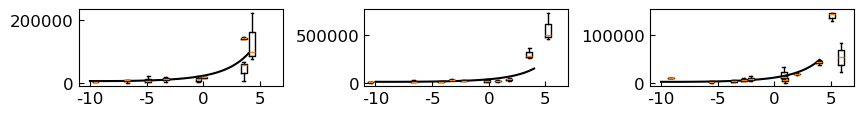


 {1075084: 'Bathycoccus prasinos RCC1105'}
{'const': 13.39866651363092, 'cruise_G2': -0.290002779397563, 'cruise_G3': 0.3519706849382069, 'lat_diff': 0.266860601926863, 'lat_diff^2': 0.008152408237723889}
{'p_value': {'lat_diff': 0.0}}
alpha {'alpha_used': np.float64(0.331610003120318), 'pearson_chi2': np.float64(41582372.55309872), 'dispersion_ratio': np.float64(519779.65691373404)}
n_outliers 0
n_skipped 0


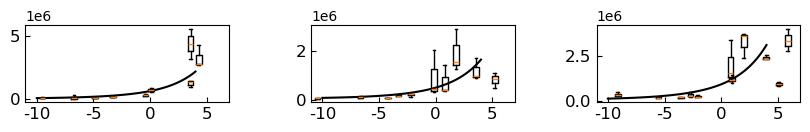


 {1486889: 'Polyblepharides amylifera'}
{'const': 14.276511132994685, 'cruise_G2': 0.32468587637322566, 'cruise_G3': -0.8083057945533926, 'lat_diff': 0.1746763554591077, 'lat_diff^2': 0.006487015553792337}
{'p_value': {'lat_diff': 0.0}}
alpha {'alpha_used': np.float64(0.18600376092514526), 'pearson_chi2': np.float64(51166888.73122065), 'dispersion_ratio': np.float64(639586.109140258)}
n_outliers 0
n_skipped 0


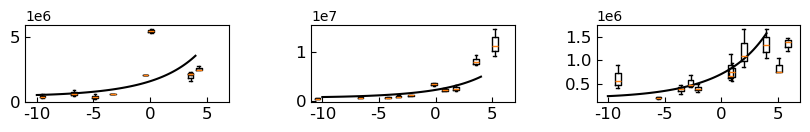


 {94617: 'Fibrocapsa japonica'}
{'const': 14.246215431025469, 'cruise_G2': 0.424485220578793, 'cruise_G3': -0.7708392771909799, 'lat_diff': 0.19781901956478795, 'lat_diff^2': 0.014264737896741988}
{'p_value': {'lat_diff': 0.0}}
alpha {'alpha_used': np.float64(0.21171437347571379), 'pearson_chi2': np.float64(48689445.537041835), 'dispersion_ratio': np.float64(608618.069213023)}
n_outliers 0
n_skipped 0


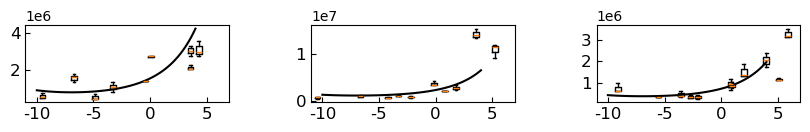


 {133427: 'Protoceratium reticulatum'}
{'const': 17.81768798805987, 'cruise_G2': 0.907442404468925, 'cruise_G3': -0.4943055272572859, 'lat_diff': 0.10951728690367214, 'lat_diff^2': 0.0028845096576785895}
{'p_value': {'lat_diff': 0.01}}
alpha {'alpha_used': np.float64(0.3231613487358402), 'pearson_chi2': np.float64(3118591880.4531345), 'dispersion_ratio': np.float64(38982398.505664185)}
n_outliers 0
n_skipped 0


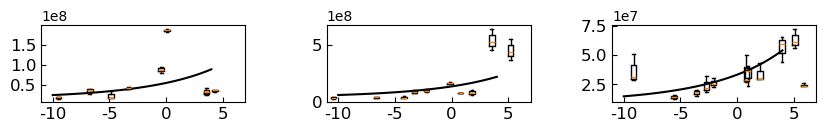


 {6500: 'Aplysia californica'}
{'const': 15.185361639049772, 'cruise_G2': -0.19994758988660818, 'cruise_G3': 1.021421076127595, 'lat_diff': 0.2081323600851838, 'lat_diff^2': 0.007944221176791742}
{'p_value': {'lat_diff': 0.0}}
alpha {'alpha_used': np.float64(0.3558016115274614), 'pearson_chi2': np.float64(291156604.93234825), 'dispersion_ratio': np.float64(3639457.561654353)}
n_outliers 0
n_skipped 0


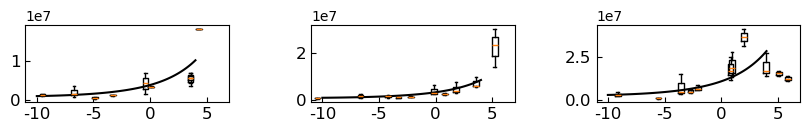


 {2966: 'Noctiluca scintillans'}
{'const': 17.521799793703714, 'cruise_G2': 1.3521032245365852, 'cruise_G3': -0.20783064873133106, 'lat_diff': 0.1201884904494104, 'lat_diff^2': 0.007052877143855142}
{'p_value': {'lat_diff': 0.0}}
alpha {'alpha_used': np.float64(0.2624489706669233), 'pearson_chi2': np.float64(3129738055.5623627), 'dispersion_ratio': np.float64(40124846.86618414)}
n_outliers 2
n_skipped 0


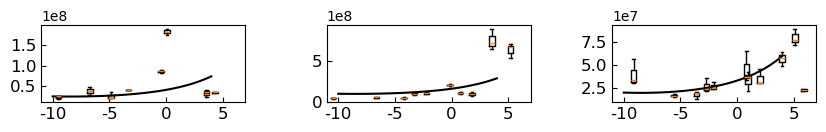


 {552664: 'Norrisiella sphaerica'}
{'const': 13.41852031669872, 'cruise_G2': 0.49080260680373516, 'cruise_G3': -0.1733937009738635, 'lat_diff': 0.12288825287113989, 'lat_diff^2': 0.004382612208471121}
{'p_value': {'lat_diff': 0.0}}
alpha {'alpha_used': np.float64(0.40360648284514805), 'pearson_chi2': np.float64(32011302.34867504), 'dispersion_ratio': np.float64(400141.279358438)}
n_outliers 0
n_skipped 0


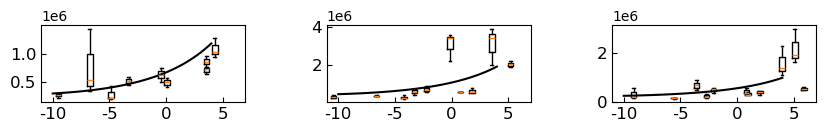


 {661478: 'Fimbriimonas ginsengisoli Gsoil 348'}
{'const': 10.26216464692488, 'cruise_G2': 0.9072946693613133, 'cruise_G3': -0.9325064639480838, 'lat_diff': 0.09886359997365643, 'lat_diff^2': 0.003105259724739868}
{'p_value': {'lat_diff': 0.1}}
alpha {'alpha_used': np.float64(0.40913936841492843), 'pearson_chi2': np.float64(3308406.3569682864), 'dispersion_ratio': np.float64(41878.56148061122)}
n_outliers 1
n_skipped 0


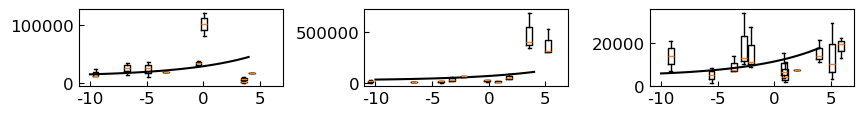


 {56: 'Sorangium cellulosum'}
{'const': 12.929560699147677, 'cruise_G2': 0.857420592421203, 'cruise_G3': 0.1840030655622658, 'lat_diff': 0.040669021784586125, 'lat_diff^2': -0.013799348298895855}
{'p_value': {'lat_diff': 0.37}}
alpha {'alpha_used': np.float64(0.38436678852677636), 'pearson_chi2': np.float64(19824130.69486911), 'dispersion_ratio': np.float64(247801.63368586387)}
n_outliers 0
n_skipped 0


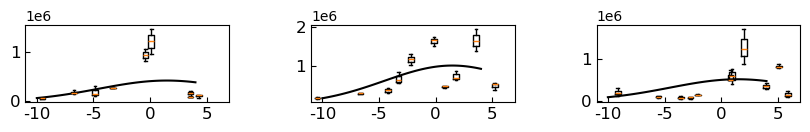

In [ ]:
# for tax in ['1049564']:
for i, (tax, dict_res) in enumerate(results.items()):
    if i < 10:
        print('\n',ncbi.get_taxid_translator([tax]))
        print(dict_res['model'])
        print(dict_res['perm_pvalues'])
        print('alpha', dict_res['alpha'])
        # print(dict_res['perm_dict'])
        print('n_outliers', dict_res['n_outliers'])
        print('n_skipped',dict_res['n_skipped'])

        # Get values
        df = dict_tax_preddf[tax].copy()
        df_ = df[(df['sel'] == sel) & (df['size'] == sz)]
        df_ = df_.reset_index()

        # PLot cruises
        const, ld, ld2 = [dict_res['model'][c] for c in ['const','lat_diff','lat_diff^2']]
        ft = 12
        fig, axes = plt.subplots(1,3, figsize=(10,1))
        for j, cruise in enumerate(['G1','G2','G3']):
        # for j, cruise in enumerate(['G1']):
            df_piv = df_[df_['cruise'] == cruise].copy()
            if df_piv.shape[0] > 0:
                ax = axes[j]
                lats_unq = df_piv.lat_diff.unique()
                vals = []
                for l in lats_unq:
                    vals.append(df_piv.loc[df_piv['lat_diff'] == l, vt].values)
                ax.boxplot(vals, positions=lats_unq)

                # Plot model
                crs = 0
                if not cruise == 'G1':
                    crs = dict_res['model'][f'cruise_{cruise}']
                x = np.linspace(-10,4,100)
                # y = np.exp(const + ld*x + ld2*x**2 + ld3*x**3 + crs)
                y = np.exp(const + ld*x + ld2*x**2 + crs)
                ax.plot(x,y, 'k')

                x = np.arange(-10,10,5)
                ax.set_xticks(x)
                ax.set_xticklabels(x)
                ax.set_xlim(-11,7)
                # ax.set_title(cruise, size=ft)
                ax.tick_params(direction="in", labelsize=ft)
                # if cruise == 'G3':
                #     ax.set_ylim(0,2e8)

        plt.subplots_adjust(wspace=0.4)
        plt.show()



Test permutation between replicates

In [ ]:
random_state = 42
covariate_cols = ['cruise']
poly_cols = ['lat_diff']
X_onehot, onehot_feature_names, _ = preprocess_onehot_matrix(preddf, covariate_cols, poly_cols)

bool_cruise = (X_onehot['cruise_G2'] == 0) & (X_onehot['cruise_G3'] == 0)

test = preddf.copy().loc[bool_cruise, poly_cols]
rng = np.random.default_rng(random_state)
perm = permute_between_groups_of_replicate_samples(
    test['lat_diff'], test, rng
)

print(test[:25])
print('\n',perm)

TEst permutation within groups

In [ ]:
random_state = 42
covariate_cols = ['cruise']
poly_cols = ['lat_diff']
X_onehot, onehot_feature_names, _ = preprocess_onehot_matrix(preddf, covariate_cols, poly_cols)


test = preddf.copy()[poly_cols]
rng = np.random.default_rng(random_state)
test['ld_perm'] = permute_within_groups_02(
    test['lat_diff'], X_onehot, rng
)

print(test[:50].sort_index())

Run on all vt sel sz options:

In [832]:
# Fraction of samples that must be nonzero in each cruise for the taxon to be included
thresh_fgt0 = 0.8
# Number of permutations for p value on latitude effect
n_perm = 1000
# Define outliers as > q3 + IQR * coeff and < q1 - IQR * coeff
iqr_coefficient = 10 
# number of cores to use
n_jobs = 100
# Ouptut location
dir_glm = '/scratch/bgrodner/relative_abundance/metat_search_results/latitude_tzcf_glm'
fmt_out = dir_glm + '/model_results/latitude_tzcf_glm_results_{sel}_{sz}_taxon_{vt}.json'

# Variable to save things to:
dict_valtype_sel_sz_glmresults = defaultdict(
    lambda: defaultdict(dict)
)

preddf = dict_valtype_sel_sz_preddf[vt][sel][sz].copy()
for vt, dict_sel_sz_preddf in dict_valtype_sel_sz_preddf.items():
    for sel, dict_sz_preddf in dict_sel_sz_preddf.items():
        for sz, preddf in dict_sz_preddf.items():
            fn_out = fmt_out.format(sel=sel, sz=sz, vt=vt)
            # if not os.path.exists(fn_out):
            print(vt, sel, sz)

            # Get a list of taxa
            response_cols = [c for c in preddf.columns if c not in ['lat_diff','cruise','rep']]

            # Subset based on minimum fraction of nonzero samples
            bool_tax = np.zeros(len(response_cols))
            # Each cruise must have the minimum number of nonzero samples for the taxon to be included
            for cruise, df in preddf[response_cols + ['cruise']].groupby('cruise'):
                frac_gt0 = (df[response_cols] > pseudocount).sum(axis=0) / df.shape[0]
                bool_tax += (frac_gt0 > thresh_fgt0).values.astype(int)
            bool_tax = bool_tax == 3
            response_cols_sub = np.array(response_cols)[bool_tax].tolist()


            # Fit the model
            results = frm.fit_many_models(
                data=preddf,
                response_cols=response_cols_sub,
                covariate_cols=covariate_cols,
                poly_cols=['lat_diff'], 
                poly_degree=2,
                iqr_coefficient=iqr_coefficient,
                perm_test_vars=['lat_diff'], 
                n_perm=n_perm, 
                stat='coef',
                random_state=None,
                n_jobs=n_jobs,
            )
            dict_valtype_sel_sz_glmresults[vt][sel][sz] = results

            # Save the model 
            dir_out = os.path.split(fn_out)[0]
            if not os.path.exists(dir_out): os.makedirs(dir_out)
            with open(fn_out, 'w') as f:
                json.dump(
                    results, 
                    f, 
                    sort_keys=True,
                    indent=4,
                    separators=(',', ': ')
                )

frac PA 3.0um
chack


[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done  21 tasks      | elapsed:   20.2s
[Parallel(n_jobs=100)]: Done  42 tasks      | elapsed:   21.7s
[Parallel(n_jobs=100)]: Done  65 tasks      | elapsed:   23.0s
[Parallel(n_jobs=100)]: Done  88 tasks      | elapsed:   23.5s
[Parallel(n_jobs=100)]: Done 113 tasks      | elapsed:   35.6s
[Parallel(n_jobs=100)]: Done 138 tasks      | elapsed:   37.8s
[Parallel(n_jobs=100)]: Done 165 tasks      | elapsed:   40.2s
[Parallel(n_jobs=100)]: Done 192 tasks      | elapsed:   42.0s
[Parallel(n_jobs=100)]: Done 221 tasks      | elapsed:   51.1s
[Parallel(n_jobs=100)]: Done 250 tasks      | elapsed:   55.9s
[Parallel(n_jobs=100)]: Done 281 tasks      | elapsed:   59.7s
[Parallel(n_jobs=100)]: Done 312 tasks      | elapsed:  1.1min
[Parallel(n_jobs=100)]: Done 345 tasks      | elapsed:  1.2min
[Parallel(n_jobs=100)]: Done 378 tasks      | elapsed:  1.3min
[Parallel(n_jobs=100)]: Done 413 tasks 

0.5895725771337529
0.006381728914477228
0.00026283358818095866
5.0945169451356966e-05
0.333785581633376
4.664350961706542e-05
0.14555340619200197
3.03933036777098e-05
4.1845372101641156e-05
0.13484282945846304
0.01919894041292783
0.00018113561838432998
0.00022219030043396561
0.0768824403148231
0.003958902473702917
0.04301409400046419
0.003441323117389171
0.06641843828698399
0.014606936701017918
0.015579774397184557
0.010830763159305985
0.000585728500918736
0.09529648667391143
0.01746660404292455
0.07809166317160733
0.0007437274661483504
0.0008224706154126571
0.007705997565393023
0.05662796505993377
0.06208531073222614
0.025224368863495474
0.021612257264372742
0.00016747353773420624
0.0007526080692132343
0.0005246166803334756
0.00461612871109114
0.009987298015826944
0.007306083880308838
0.09942911014237399
0.028264831423227856
0.011908875452832628
0.0024839658998722586
0.008443431564646268
0.0030034366033747824
0.07975509853285662
0.006893049142642641
0.002905501949111329
0.000139870501

[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done  21 tasks      | elapsed:   14.9s
[Parallel(n_jobs=100)]: Done  42 tasks      | elapsed:   17.4s
[Parallel(n_jobs=100)]: Done  65 tasks      | elapsed:   18.7s
[Parallel(n_jobs=100)]: Done  88 tasks      | elapsed:   19.4s
[Parallel(n_jobs=100)]: Done 113 tasks      | elapsed:   30.2s
[Parallel(n_jobs=100)]: Done 138 tasks      | elapsed:   33.8s
[Parallel(n_jobs=100)]: Done 165 tasks      | elapsed:   35.8s
[Parallel(n_jobs=100)]: Done 192 tasks      | elapsed:   38.1s
[Parallel(n_jobs=100)]: Done 221 tasks      | elapsed:   46.8s
[Parallel(n_jobs=100)]: Done 250 tasks      | elapsed:   51.6s
[Parallel(n_jobs=100)]: Done 281 tasks      | elapsed:   54.6s
[Parallel(n_jobs=100)]: Done 312 tasks      | elapsed:  1.0min
[Parallel(n_jobs=100)]: Done 345 tasks      | elapsed:  1.1min
[Parallel(n_jobs=100)]: Done 378 tasks      | elapsed:  1.2min
[Parallel(n_jobs=100)]: Done 413 tasks 

0.12070836168488613
1.5326501043261975
0.010104083898904603
0.008593300871482381
0.025021879459713695
0.003185785381297896
0.009470775460525757
0.31623368947387376
0.0683316122462117
0.007359093995674304
0.10598955059167216
0.1450478796523072
0.0272889786574591
0.024744544928835238
0.008793543043989799
0.0035569608911452614
0.3495465166827438
0.0391982361386196
0.001164554477146456
0.12833540791463152
0.00535053072753325
0.0006741235407425714
0.002506031745168667
0.006956554988386238
0.023733004047433063
4.9341337620394804e-05
0.027613477149914155
0.0003190641169003032
0.009252360177096429
0.01275761423045843
0.009233217599252282
0.005898373700159479
0.0014889583122152086
0.015405505367863802
0.007460312439245826
0.0017597350296464018
0.00018107989775793852
0.002539230767231126
0.002369306835716782
0.00014456253442592635
0.012590437844229372
0.0017272052887488815
0.002938647761930903
0.002722238553547387
6.432783199296918e-05
0.06595269087075145
0.007534271603312912
0.00277623434736361

[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done  21 tasks      | elapsed:   15.3s
[Parallel(n_jobs=100)]: Done  42 tasks      | elapsed:   18.0s
[Parallel(n_jobs=100)]: Done  65 tasks      | elapsed:   19.2s
[Parallel(n_jobs=100)]: Done  88 tasks      | elapsed:   20.1s
[Parallel(n_jobs=100)]: Done 113 tasks      | elapsed:   31.7s
[Parallel(n_jobs=100)]: Done 138 tasks      | elapsed:   34.4s
[Parallel(n_jobs=100)]: Done 165 tasks      | elapsed:   37.2s
[Parallel(n_jobs=100)]: Done 192 tasks      | elapsed:   39.6s
[Parallel(n_jobs=100)]: Done 221 tasks      | elapsed:   49.6s
[Parallel(n_jobs=100)]: Done 250 tasks      | elapsed:   53.4s
[Parallel(n_jobs=100)]: Done 281 tasks      | elapsed:   56.5s
[Parallel(n_jobs=100)]: Done 312 tasks      | elapsed:  1.1min
[Parallel(n_jobs=100)]: Done 345 tasks      | elapsed:  1.2min
[Parallel(n_jobs=100)]: Done 378 tasks      | elapsed:  1.2min
[Parallel(n_jobs=100)]: Done 413 tasks 

0.9354872248271977
0.17912934189762098
0.08975078704578554
0.0011621012517010068
0.026246416119490884
0.00018185690071757799
0.0026019249663994104
0.0074759745265798455
0.030636182912544718
0.00017878059628548778
0.005042766872637541
0.0007808125947737603
0.00017452176002572404
0.025488219467020512
0.12457694662728178
0.11468569882987276
0.042863658749848765
0.020996315468225654
0.04862618674952303
0.0022297803448279255
0.004932260624473362
1.630827281995785e-05
0.011726789880658752
0.05138518975509676
3.2255587827501866e-05
0.005551629989405789
0.0006894995098435872
0.03834903368665177
0.00021325003432337062
0.05057732002841811
0.002621021849045717
0.00045864596052047103
0.0009263437250409089
0.0023196432628029284
0.03969133547883732
0.03580568286344041
0.05078605479953152
3.714951453875261e-05
0.0022433704494737748
0.009303927173377836
0.0003305207509665775
0.012704001343127207
0.025612582751939963
0.0033985215571049614
0.00014622361445832885
2.4131838828417903e-05
1.2300086588791503

[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done  21 tasks      | elapsed:   17.2s
[Parallel(n_jobs=100)]: Done  42 tasks      | elapsed:   18.5s
[Parallel(n_jobs=100)]: Done  65 tasks      | elapsed:   19.6s
[Parallel(n_jobs=100)]: Done  88 tasks      | elapsed:   20.7s
[Parallel(n_jobs=100)]: Done 113 tasks      | elapsed:   32.7s
[Parallel(n_jobs=100)]: Done 138 tasks      | elapsed:   35.8s
[Parallel(n_jobs=100)]: Done 165 tasks      | elapsed:   39.0s
[Parallel(n_jobs=100)]: Done 192 tasks      | elapsed:   41.0s
[Parallel(n_jobs=100)]: Done 221 tasks      | elapsed:   49.7s
[Parallel(n_jobs=100)]: Done 250 tasks      | elapsed:   55.2s
[Parallel(n_jobs=100)]: Done 281 tasks      | elapsed:   59.0s
[Parallel(n_jobs=100)]: Done 312 tasks      | elapsed:  1.1min
[Parallel(n_jobs=100)]: Done 345 tasks      | elapsed:  1.2min
[Parallel(n_jobs=100)]: Done 378 tasks      | elapsed:  1.3min
[Parallel(n_jobs=100)]: Done 413 tasks 

0.7362609079917974
0.002450270529839836
0.16572559841957613
0.053710543893411566
0.002230297447969501
0.008483580456929419
0.06656801901084422
0.26435739517651397
0.00018530333597032266
0.0026715014618670374
0.019612597214727603
0.02939614527101181
0.010050609281358355
0.0021655806565631314
0.016483202998863897
0.00022413170714156777
0.08045242064858044
0.03383094527735645
0.005825007574329551
0.0026000715509868514
0.00135688975460517
0.0011294509332175488
0.00557379258652356
0.018215017066001583
0.007035898482896777
0.0045496369511568435
0.004112268084493657
0.05001993714208712
0.005256836111023306
0.028139259001972977
0.0019954517009751586
0.0029112343697940274
0.00072274048642621
0.01668018788479262
0.0011286646139340717
0.000533140251420928
0.00036077691795985325
0.0242416649872394
0.06334066855436363
8.411859979340213e-06
0.0012331471591416135
0.056435106647678576
0.00014518601324027547
5.9675811892441623e-05
0.0004383055802643617
0.00018006561732973473
0.0005963743406541271
0.000

[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done  21 tasks      | elapsed:   21.4s
[Parallel(n_jobs=100)]: Done  42 tasks      | elapsed:   25.2s
[Parallel(n_jobs=100)]: Done  65 tasks      | elapsed:   32.3s
[Parallel(n_jobs=100)]: Done  88 tasks      | elapsed:   37.1s
[Parallel(n_jobs=100)]: Done 113 tasks      | elapsed:   42.9s
[Parallel(n_jobs=100)]: Done 138 tasks      | elapsed:   47.6s
[Parallel(n_jobs=100)]: Done 165 tasks      | elapsed:   54.0s
[Parallel(n_jobs=100)]: Done 192 tasks      | elapsed:   59.8s
[Parallel(n_jobs=100)]: Done 221 tasks      | elapsed:  1.1min
[Parallel(n_jobs=100)]: Done 250 tasks      | elapsed:  1.2min
[Parallel(n_jobs=100)]: Done 281 tasks      | elapsed:  1.3min
[Parallel(n_jobs=100)]: Done 312 tasks      | elapsed:  1.4min
[Parallel(n_jobs=100)]: Done 345 tasks      | elapsed:  1.5min
[Parallel(n_jobs=100)]: Done 378 tasks      | elapsed:  1.7min
[Parallel(n_jobs=100)]: Done 413 tasks 

141.5458719432354
154.9509988228092
315.37081745208707
187.0521626729137
85.99841974675655
309.03222844196716
499.8739127665758
283.2897357537877
278.2234986037074
101.67264537885785
73.84953866247088
388.69377532768704
255.0088311493164
40.03613458387554
109.91240592739268
106.13916149735451
282.96983445668593
162.58810541086132
151.29451815178618
880.4672945220373
420.63692306913435
370.1611721037734
593.783900841896
309.3372946800664
25.227475257590413
279.12292950833216
194.9426827921834
53.476130038267
80.42970027972478
589.5807091358583
474.1409294004552
68.9572136644274
151.39635325587096
676.3669925442373
70.40176098363736
50.13048369868193
29.01169515476795
263.7456272312702
175.65882830576447
54.5484437411651
153.31430052989163
218.02696022258897
393.4740727620665
237.872977287484
26.93545937165618
209.52345239603892
332.25900823483244
382.9446473554417
141.07866556744557
349.36514019588503
167.40921853954205
1063.961568275518
175.2641199323116
274.51285984911374
77.678168288

[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done  21 tasks      | elapsed:   19.9s
[Parallel(n_jobs=100)]: Done  42 tasks      | elapsed:   22.6s
[Parallel(n_jobs=100)]: Done  65 tasks      | elapsed:   26.5s
[Parallel(n_jobs=100)]: Done  88 tasks      | elapsed:   33.2s
[Parallel(n_jobs=100)]: Done 113 tasks      | elapsed:   39.8s
[Parallel(n_jobs=100)]: Done 138 tasks      | elapsed:   42.3s
[Parallel(n_jobs=100)]: Done 165 tasks      | elapsed:   49.0s
[Parallel(n_jobs=100)]: Done 192 tasks      | elapsed:   54.8s
[Parallel(n_jobs=100)]: Done 221 tasks      | elapsed:  1.0min
[Parallel(n_jobs=100)]: Done 250 tasks      | elapsed:  1.1min
[Parallel(n_jobs=100)]: Done 281 tasks      | elapsed:  1.2min
[Parallel(n_jobs=100)]: Done 312 tasks      | elapsed:  1.3min
[Parallel(n_jobs=100)]: Done 345 tasks      | elapsed:  1.4min
[Parallel(n_jobs=100)]: Done 378 tasks      | elapsed:  1.5min
[Parallel(n_jobs=100)]: Done 413 tasks 

17.043290354311466
90.78242981433868
138.0212178826332
34.68967779004015
21.764042945811525
74.05219346529339
68.94958660379052
63.348815605044365
20.41454118526599
121.14599865395576
167.73938614624785
310.654981917236
47.52946522599086
250.44317992124707
207.31231512047816
208.3295439267531
237.38901927950792
16.671198702882975
9.720028950076085
9.12961949617602
10.639262080192566
73.39571061250172
62.23529378924468
60.24498186010169
221.5281350540463
137.3281184252519
11.883808583777864
90.6662902697135
46.188707463268656
0.5150217055588655
54.2985616242222
8.56363416169188
523.234914572884
25.58379973715637
57.00015071492089
71.70003519205056
119.52188570912404
147.11599609233963
66.59880856669042
181.44499936371358
53.74621193818166
93.07667403074447
145.70938822359312
87.00771556139807
201.99256401953608
143.2797859730199
86.85445148390136
213.72673372973804
47.50189616024727
9.870587173834792
351.38382155564614
46.3815887373712
10.048100046406034
42.690230111504206
55.4543765617

[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done  21 tasks      | elapsed:   21.5s
[Parallel(n_jobs=100)]: Done  42 tasks      | elapsed:   26.7s
[Parallel(n_jobs=100)]: Done  65 tasks      | elapsed:   31.8s
[Parallel(n_jobs=100)]: Done  88 tasks      | elapsed:   38.3s
[Parallel(n_jobs=100)]: Done 113 tasks      | elapsed:   42.7s
[Parallel(n_jobs=100)]: Done 138 tasks      | elapsed:   49.4s
[Parallel(n_jobs=100)]: Done 165 tasks      | elapsed:   57.1s
[Parallel(n_jobs=100)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=100)]: Done 221 tasks      | elapsed:  1.1min
[Parallel(n_jobs=100)]: Done 250 tasks      | elapsed:  1.3min
[Parallel(n_jobs=100)]: Done 281 tasks      | elapsed:  1.4min
[Parallel(n_jobs=100)]: Done 312 tasks      | elapsed:  1.5min
[Parallel(n_jobs=100)]: Done 345 tasks      | elapsed:  1.6min
[Parallel(n_jobs=100)]: Done 378 tasks      | elapsed:  1.7min
[Parallel(n_jobs=100)]: Done 413 tasks 

34.4294131398201
126.79530240595341
33.2084651812911
22.346123554743826
188.20583489909768
90.60475115446025
35.93400585348718
159.82207378483145
115.00414580013603
374.40382825173765
321.53831275430275
21.818684959085658
584.3576719444391
188.86840065920842
99.82296132668853
55.00859472155571
27.13987964845728
247.30082544288598
20.224399261176586
24.919635993777774
171.89608037265134
75.19458437764843
0.5312852918868884
190.95197284361348
59.27859820587037
142.0312902990263
37.43866638178588
80.30741711426526
293.75550998388644
284.29771199973766
69.85703315306455
29.73135978973005
63.488050789164845
221.05563794082263
474.7857177394908
129.67434188679908
128.80120768398046
23.859176482677867
116.12103033994936
382.4271932837728
43.634376146276736
16.649645506113302
56.124172650743276
1850.464363845107
29.06624906344223
99.49787232460221
112.05706475273473
194.20249936403707
266.02271706430474
55.504480839528696
52.63355510751717
3.535100594162941
36.83288194772558
9.233530826960305


[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done  21 tasks      | elapsed:   21.0s
[Parallel(n_jobs=100)]: Done  42 tasks      | elapsed:   24.9s
[Parallel(n_jobs=100)]: Done  65 tasks      | elapsed:   31.5s
[Parallel(n_jobs=100)]: Done  88 tasks      | elapsed:   38.5s
[Parallel(n_jobs=100)]: Done 113 tasks      | elapsed:   43.1s
[Parallel(n_jobs=100)]: Done 138 tasks      | elapsed:   48.7s
[Parallel(n_jobs=100)]: Done 165 tasks      | elapsed:   55.0s
[Parallel(n_jobs=100)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=100)]: Done 221 tasks      | elapsed:  1.1min
[Parallel(n_jobs=100)]: Done 250 tasks      | elapsed:  1.2min
[Parallel(n_jobs=100)]: Done 281 tasks      | elapsed:  1.4min
[Parallel(n_jobs=100)]: Done 312 tasks      | elapsed:  1.5min
[Parallel(n_jobs=100)]: Done 345 tasks      | elapsed:  1.6min
[Parallel(n_jobs=100)]: Done 378 tasks      | elapsed:  1.7min
[Parallel(n_jobs=100)]: Done 413 tasks 

60.39814335107803
13.363934390537906
157.12481307808775
48.729974150657654
1.6955628958530724
29.834666114416905
113.3006222806871
244.93004043400288
53.75619630613613
65.15700878202915
2.039085059892386
36.61816518648993
7.4954943305347115
229.31603386629467
157.65056071430445
36.0521383598516
12.137522485107183
421.8820159455645
54.602776782703586
3.27489975959179
20.152052325662225
264.68904857770394
352.93677534814924
55.27809224513476
12.79622026020661
5.697852516255807
156.15286822803319
12.284843142610043
103.73166049136853
43.14794051507488
22.766500352183357
17.64929306344129
3.1867107053403743
207.93175749701913
44.51803935674252
30.60532688639796
82.53660280164331
86.5262360587949
275.4707987620495
0.8786229787164359
25.283280657837167
108.81601112475619
104.21154790005676
73.41366874231971
31.974928633513628
23.04226716530343
37.81831393606262
43.93555604945621
29.618998823436414
52.146978358090564
2.9913210093509406
3.1916652905201772
126.05107863584999
1.292709770467809
4

## Inspect GLM results

Load results

In [591]:
dir_glm = '/scratch/bgrodner/relative_abundance/metat_search_results/latitude_tzcf_glm'
fmt_out = dir_glm + '/model_results/latitude_tzcf_glm_results_{sel}_{sz}_taxon_{vt}.json'

# Variable to save things to:
dict_valtype_sel_sz_glmresults = defaultdict(
    lambda: defaultdict(dict)
)

for vt, dict_sel_sz_preddf in dict_valtype_sel_sz_preddf.items():
    for sel, dict_sz_preddf in dict_sel_sz_preddf.items():
        for sz, preddf in dict_sz_preddf.items():
            fn_out = fmt_out.format(sel=sel, sz=sz, vt=vt)
            print(fn_out)
            with open(fn_out, 'r') as f:
                dict_valtype_sel_sz_glmresults[vt][sel][sz] = json.load(f)

/scratch/bgrodner/relative_abundance/metat_search_results/latitude_tzcf_glm/model_results/latitude_tzcf_glm_results_PA_3.0um_taxon_frac.json
/scratch/bgrodner/relative_abundance/metat_search_results/latitude_tzcf_glm/model_results/latitude_tzcf_glm_results_PA_0.2um_taxon_frac.json
/scratch/bgrodner/relative_abundance/metat_search_results/latitude_tzcf_glm/model_results/latitude_tzcf_glm_results_NS_3.0um_taxon_frac.json
/scratch/bgrodner/relative_abundance/metat_search_results/latitude_tzcf_glm/model_results/latitude_tzcf_glm_results_NS_0.2um_taxon_frac.json
/scratch/bgrodner/relative_abundance/metat_search_results/latitude_tzcf_glm/model_results/latitude_tzcf_glm_results_PA_3.0um_taxon_trl.json
/scratch/bgrodner/relative_abundance/metat_search_results/latitude_tzcf_glm/model_results/latitude_tzcf_glm_results_PA_0.2um_taxon_trl.json
/scratch/bgrodner/relative_abundance/metat_search_results/latitude_tzcf_glm/model_results/latitude_tzcf_glm_results_NS_3.0um_taxon_trl.json
/scratch/bgrodne

Plot coefficient values 

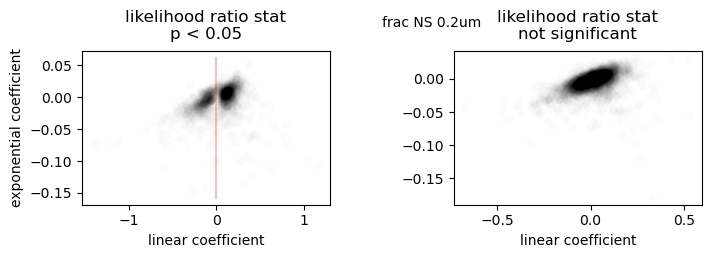

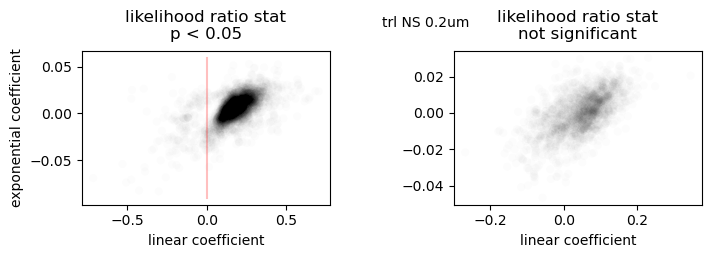

In [900]:
alpha = 0.01
thresh_p = 0.05
min_cluster_size = 50

cnames = ['lat_diff','lat_diff^2']
for vt, dict_sel_sz_glmresults in dict_valtype_sel_sz_glmresults.items():
    sig = []
    nsig = []
    for sel, dict_sz_glmresults in dict_sel_sz_glmresults.items():
        for sz, results in dict_sz_glmresults.items():
            for tax, res in results.items():
                coeffs = [res['model'][c] for c in cnames]
                pval = res['adj_perm_pvalues']['p_value']['lr_stat']
                if pval < thresh_p:
                   sig.append(coeffs)
                else:
                    nsig.append(coeffs)
    coeffsall = [sig, nsig]
    names = ['likelihood ratio stat\np < 0.05', 'likelihood ratio stat\nnot significant']
    fig, axes = plt.subplots(1,len(coeffsall), figsize=(4*len(coeffsall),2))
    for i, (v ,n) in enumerate(zip(coeffsall, names)):
        ax = axes[i]
        # if i == 0:
        #     points = np.array(v)
        #     # labels = cluster.SpectralClustering(
        #     #     n_clusters=n_clusters, assign_labels='kmeans', random_state=0
        #     # ).fit_predict(points)
        #     # clustering = cluster.KMeans(n_clusters=n_clusters, random_state=0).fit(points)
        #     clustering = cluster.HDBSCAN(min_cluster_size=min_cluster_size).fit(points)
        #     labels = clustering.labels_
        #     scatter = ax.scatter(points[:, 0], points[:, 1], c=labels, cmap=cmap,edgecolors='none',alpha=alpha)
        # else:
        vals = np.array(v).T
        ax.scatter(vals[0], vals[1], color='k',edgecolors='none',alpha=alpha)
        if i == 0:
            ylims = ax.get_ylim()
            ax.plot([0,0], ylims, 'r', alpha=0.25)
        ax.set_xlabel('linear coefficient')
        if i == 0:
            ax.set_ylabel('exponential coefficient')
        ax.set_title(n, va='bottom')

    fig.subplots_adjust(wspace=0.5)
    fig.text(0.5, 1, f'{vt} {sel} {sz}')
    plt.show()


Plot histograms of location of max or min value

In [903]:
a = np.array([1,2,3])
np.where(a == 3)[0][0]

np.int64(2)

In [908]:
inds

[array([4.]), array([-10.])]

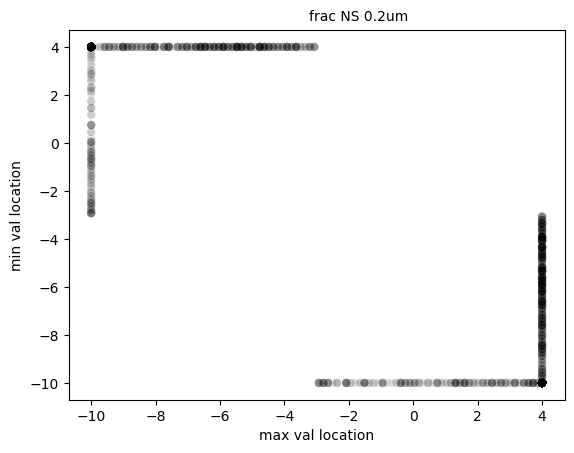

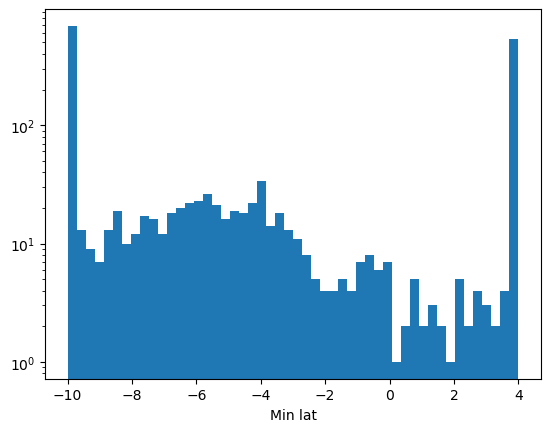

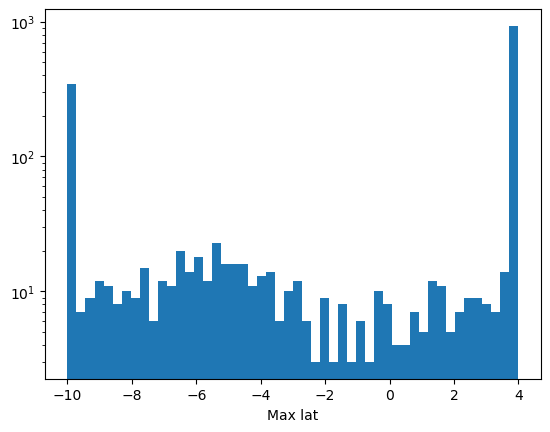

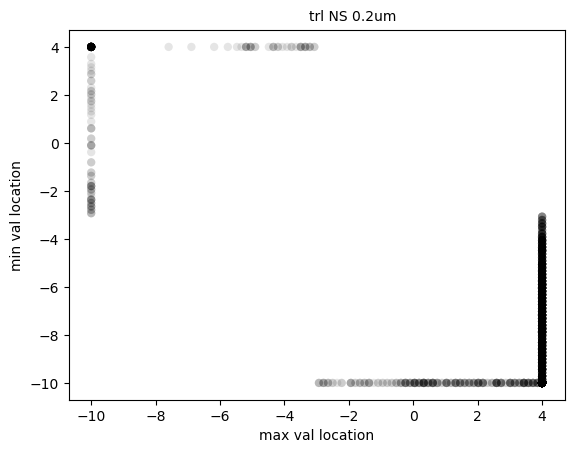

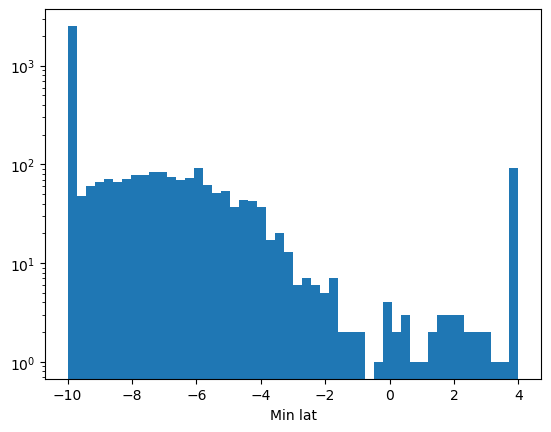

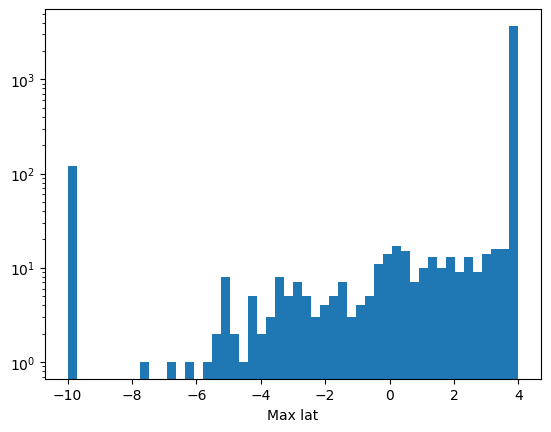

In [947]:
x = np.linspace(-10,4,100)

for vt, dict_sel_sz_glmresults in dict_valtype_sel_sz_glmresults.items():
    fig, ax = plt.subplots()
    toplot = []
    for sel, dict_sz_glmresults in dict_sel_sz_glmresults.items():
        for sz, results in dict_sz_glmresults.items():
            for tax, res in results.items():
                pval = res['adj_perm_pvalues']['p_value']['lr_stat']
                if pval < thresh_p:
                    ld, ld2 = [res['model'][c] for c in cnames]
                    y = np.exp(ld*x + ld2*x**2)
                    mx = np.max(y)
                    mn = np.min(y)
                    inds = [x[np.where(y == m)[0][0]] for m in [mx,mn]]
                    toplot.append(inds)
    vals = np.array(toplot).T
    ax.scatter(vals[0], vals[1], color='k',edgecolors='none',alpha=alpha)
    if i == 0:
        ylims = ax.get_ylim()
        ax.plot([0,0], ylims, 'r', alpha=0.25)
    ax.set_xlabel('max val location')
    ax.set_ylabel('min val location')

    fig.text(0.5, 0.9, f'{vt} {sel} {sz}')
    plt.show()
    plt.hist(vals[1], bins=50)
    plt.xlabel('Min lat')
    plt.yscale('log')
    plt.show()
    plt.hist(vals[0], bins=50)
    plt.xlabel('Max lat')
    plt.yscale('log')
    plt.show()
    

Separate by which coeffs are significant

In [858]:


def plot_kmeans_clusters(points, ax, n_clusters=3, cmap='tab10'):
    """
    Plots 2D points on the given matplotlib axis colored by their KMeans cluster identity.

    Args:
        points (list or np.ndarray): List or array of 2D points (shape: [n_samples, 2]).
        ax (matplotlib.axes.Axes): Existing matplotlib axis to plot on.
        n_clusters (int): Number of clusters for KMeans. Default is 3.

    Returns:
        None
    """
    points = np.array(points)
    kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=0).fit(points)
    labels = kmeans.labels_
    
    scatter = ax.scatter(points[:, 0], points[:, 1], c=labels, cmap=cmap)
    return ax




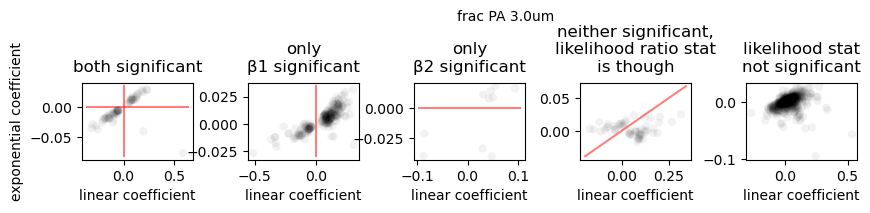

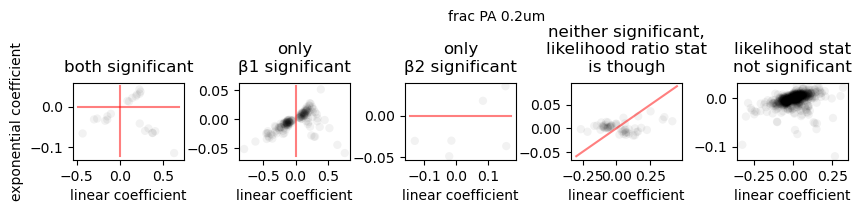

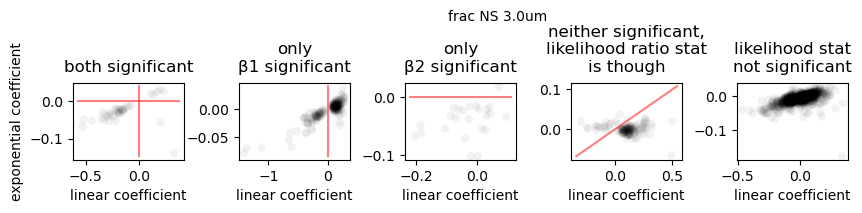

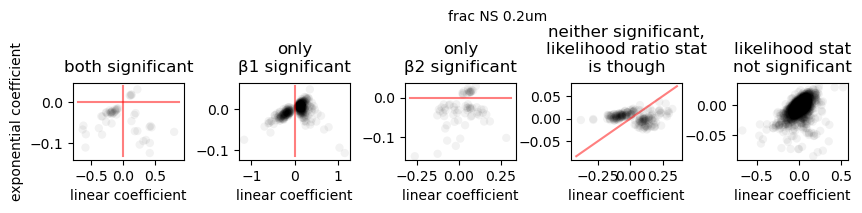

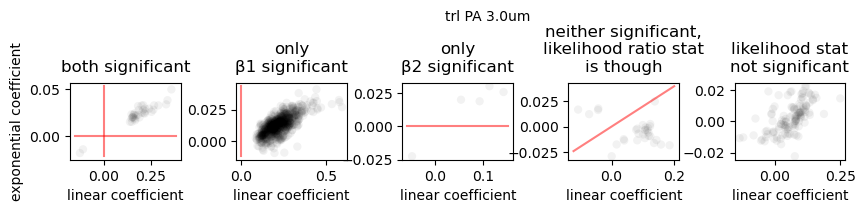

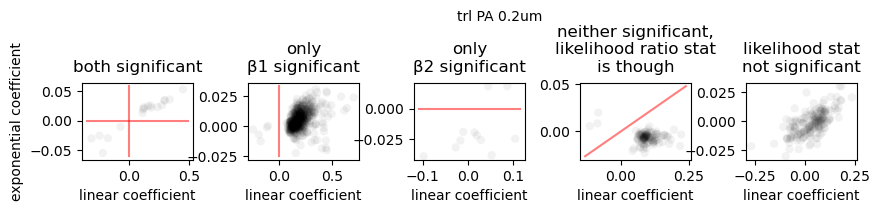

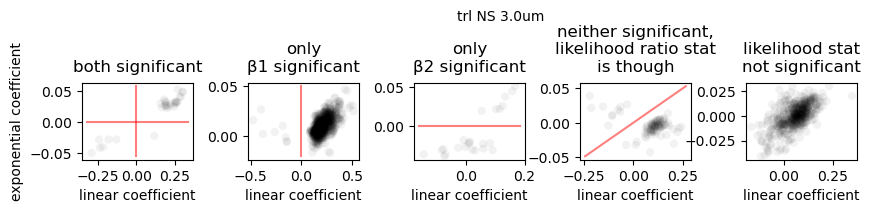

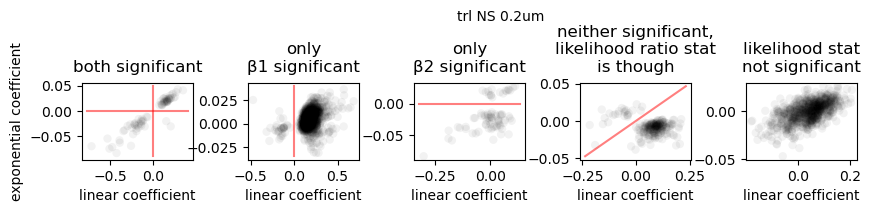

In [891]:
lr_slope = 0.2

alpha = 0.05
alpha_line = 0.5
thresh_p = 0.05
n_clusters = 2
cmap = 'tab10'
min_cluster_size = 7

cnames = ['lat_diff','lat_diff^2']
for vt, dict_sel_sz_glmresults in dict_valtype_sel_sz_glmresults.items():
    for sel, dict_sz_glmresults in dict_sel_sz_glmresults.items():
        for sz, results in dict_sz_glmresults.items():
            bothsig, b1sig, b2sig, neithersig = [], [],[],[]
            nsig = []
            for tax, res in results.items():
                coeffs = [res['model'][c] for c in cnames]
                pval = res['adj_perm_pvalues']['p_value']['lr_stat']
                if pval < thresh_p:
                    pvals = [res['adj_perm_pvalues']['p_value'][c] for c in cnames]
                    bools = [p < thresh_p for p in pvals]
                    if all(bools):
                        bothsig.append(coeffs)
                    elif bools[0]:
                        b1sig.append(coeffs)
                    elif bools[1]:
                        b2sig.append(coeffs)
                    else:
                        neithersig.append(coeffs)
                else:
                    nsig.append(coeffs)
            fig, axes = plt.subplots(1,5, figsize=(10,1))
            coeffsall = [bothsig, b1sig, b2sig, neithersig, nsig]
            names = ['both significant', 'only\nβ1 significant', 'only\nβ2 significant', 'neither significant,\nlikelihood ratio stat\nis though', 'likelihood stat\nnot significant']
            ms = [-0.1,np.inf,0,0.1,None]
            for i, (v ,n, m) in enumerate(zip(coeffsall, names, ms)):
                ax = axes[i]
                # if i == 3:
                #     points = np.array(v)
                #     labels = cluster.SpectralClustering(
                #         n_clusters=n_clusters, assign_labels='kmeans', random_state=0
                #     ).fit_predict(points)
                #     # clustering = cluster.KMeans(n_clusters=n_clusters, random_state=0).fit(points)
                #     # clustering = cluster.HDBSCAN(min_cluster_size=min_cluster_size).fit(points)
                #     # labels = clustering.labels_
                #     scatter = ax.scatter(points[:, 0], points[:, 1], c=labels, cmap=cmap,edgecolors='none',alpha=alpha)
                # else:
                vals = np.array(v).T
                ax.scatter(vals[0], vals[1], color='k',edgecolors='none',alpha=alpha)
                ax.set_xlabel('linear coefficient')
                if i == 0:
                    ax.set_ylabel('exponential coefficient')
                ax.set_title(n, va='bottom')
                if m is not None:
                    xlims = ax.get_xlim()
                    ylims = ax.get_ylim()
                    if i == 0:
                        ax.plot(xlims,[0,0], 'r', alpha=alpha_line)
                        ax.plot([0,0],ylims, 'r', alpha=alpha_line)
                    elif i == 1:
                        ax.plot([0,0],ylims, 'r', alpha=alpha_line)
                    elif i == 2:
                        ax.plot(xlims,[0,0], 'r', alpha=alpha_line)
                    elif i == 3:
                        # ax.plot(xlims,[0,0], 'r')
                        # ax.plot([0,0],ylims, 'r')
                        ax.plot(xlims, np.array(xlims)*lr_slope, 'r', alpha=alpha_line)

                     

                    # if np.isinf(m):
                    #     ylims = ax.get_ylim()
                    #     ax.plot([0,0],ylims, 'r')
                    # else:
                    #     xlims = ax.get_xlim()
                    #     y = m*np.array(xlims)
                    #     ax.plot(xlims, y, 'r')


            fig.subplots_adjust(wspace=0.5)
            fig.text(0.5, 1.5, f'{vt} {sel} {sz}')
            plt.show()


Group the taxa by coefficient info

In [962]:
thresh_p = 0.05
threshbs = [0.05, 0.005]
# lr_slope = 0.2

cnames = ['lat_diff','lat_diff^2']
dict_valtype_sel_sz_ptype_taxa = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(list)
        )
    )
)
x = np.linspace(-10,4,100)

ptypes = []
for vt, dict_sel_sz_glmresults in dict_valtype_sel_sz_glmresults.items():
    for sel, dict_sz_glmresults in dict_sel_sz_glmresults.items():
        for sz, results in dict_sz_glmresults.items():
            print(vt, sel, sz)
            sig = []
            nsig = []
            for tax, res in results.items():
                coeffs = [res['model'][c] for c in cnames]
                pval = res['adj_perm_pvalues']['p_value']['lr_stat']
                ptype = 'nonsig'
                if pval < thresh_p:
                    ld, ld2 = [res['model'][c] for c in cnames]
                    y = np.exp(ld*x + ld2*x**2)
                    mx = np.max(y)
                    mn = np.min(y)
                    mxlat = x[np.where(y == mx)[0][0]]
                    mnlat = x[np.where(y == mn)[0][0]]
                    if (mxlat <= 1) & (mxlat >= -3):
                        ptype = 'high_cf'
                    elif (mnlat <= 0) * (mnlat >= -3):
                        ptype = 'low_cf'
                    elif (mxlat > 1):
                        ptype = 'high_north'
                    elif (mxlat < -3):
                        ptype = 'high_south'


                #     pvals = [res['adj_perm_pvalues']['p_value'][c] for c in cnames]
                #     bools = [p < thresh_p for p in pvals]
                #     sgns = []
                #     for c, tb in zip(coeffs, threshbs):
                #         sgn = np.sign(c)
                #         if np.abs(c) < tb:
                #             sgn = 0
                #         sgns.append(sgn)
                #     ptype = f'B1_{sgns[0]}_B2_{sgns[1]}'
                ptypes.append(ptype)
                dict_valtype_sel_sz_ptype_taxa[vt][sel][sz][ptype].append(tax)

                
ptypes = sorted(set(ptypes))

frac PA 3.0um
frac PA 0.2um
frac NS 3.0um
frac NS 0.2um
trl PA 3.0um
trl PA 0.2um
trl NS 3.0um
trl NS 0.2um


Plot taxa within profile type

In [958]:
# flierprops = {
#     'marker': '.',                # Marker shape (e.g., 'o' for circle, '*' for star)
#     'markerfacecolor': 'k',     # Fill color of outliers
#     'markeredgecolor': 'none',   # Edge color of outliers
#     'markersize': 1,              # Size of outlier markers
#     'alpha':0.5
# }
# ptypes = ['1.0','0','-1.0']

# for vt, dict_sel_sz_ptype_taxa in dict_valtype_sel_sz_ptype_taxa.items():
#     for sel, dict_sz_ptype_taxa in dict_sel_sz_ptype_taxa.items():
#         for sz, dict_ptype_taxa in dict_sz_ptype_taxa.items():
#             preddf = dict_valtype_sel_sz_preddf[vt][sel][sz]
#             dict_pytpe_taxprofiles = defaultdict(list)
#             for ptype, taxa in dict_ptype_taxa.items():
#                 for tax in taxa:
#                     dict_pytpe_taxprofiles[ptype].append(preddf[tax].values)
#             print(vt, sel, sz)
#             fig, axes = plt.subplots(3,3, figsize=(10,3))

#             for i, ptype in enumerate(ptypes):
#                 tp = dict_pytpe_taxprofiles[ptype]

#                 arr = np.array(tp).T
#                 mx = np.max(arr, axis=0)
#                 mn = np.min(arr, axis=0)
#                 arr = (arr - mn) / (mx - mn)

#                 for j, cruise in enumerate(['G1','G2','G3']):
#                 # for j, cruise in enumerate(['G1']):
#                     bool_cruise = (preddf['cruise'] == cruise).values

#                     ax = axes[i,j]
#                     lats_unq = preddf.lat_diff.unique()
#                     vals = []
#                     lds = []
#                     for l in lats_unq:
#                         bool_lat = (preddf['lat_diff'] == l).values
#                         vl = arr[bool_cruise & bool_lat].ravel()
#                         if vl.shape[0]:
#                             vals.append(vl)
#                             lds.append(l)
#                     ax.boxplot(vals, positions=lds, flierprops=flierprops)

#                     x = np.arange(-10,10,5)
#                     ax.set_xticks(x)
#                     xticklabels = x if i == 2 else []
#                     ax.set_xticklabels(xticklabels)
#                     ax.set_xlim(-11,7)
#                     # ax.set_title(cruise, size=ft)
#                     ax.tick_params(direction="in", labelsize=ft)
#                     if i == 2:
#                         ax.set_xlabel('Latitude - TZCF latitude')
#                     if i == 0:
#                         ax.set_title(cruise)
#                     if j == 0:
#                         ax.set_ylabel(f'coeff sign {ptype}', rotation=0, ha='right')

#             fig.text(0.01, 0.5, f'{vt} Abundance', rotation=90, va='center',ha='left')
#             fig.suptitle(f'{vt} {sel} {sz}')
#             plt.show()



Plot the curves for the groups

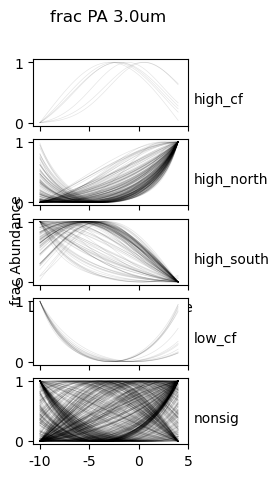

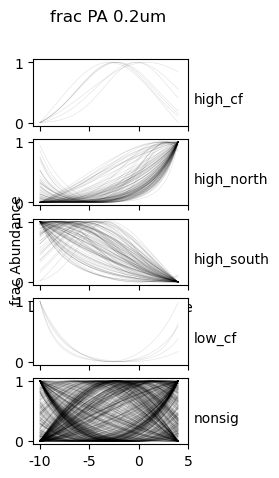

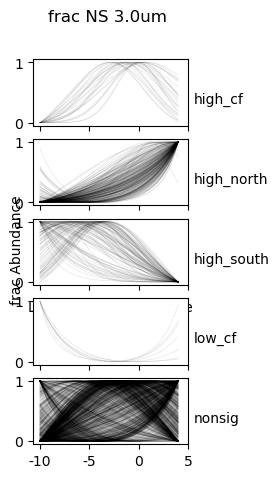

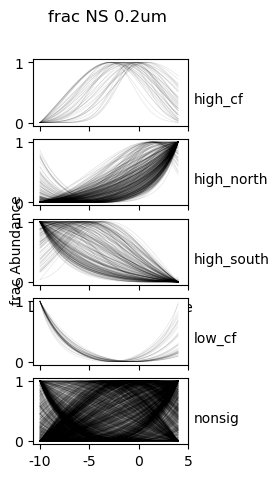

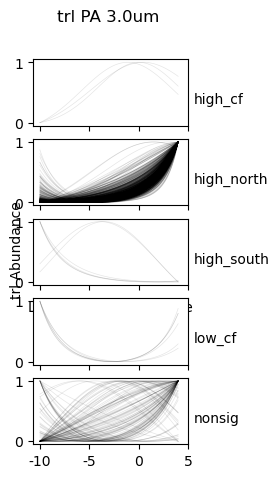

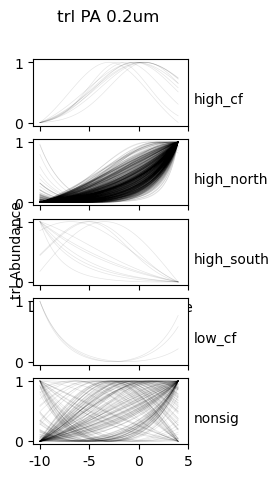

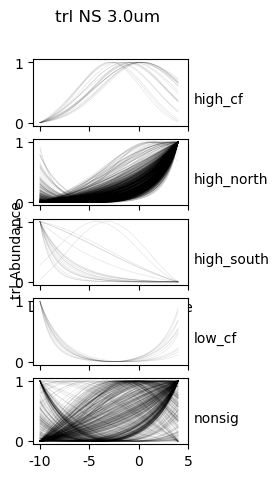

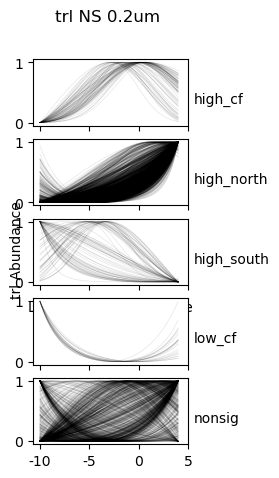

In [963]:
cnames = ['lat_diff','lat_diff^2']
x = np.linspace(-10,4,100)
lw = 0.5
alpha = 0.1

for vt, dict_sel_sz_ptype_taxa in dict_valtype_sel_sz_ptype_taxa.items():
    for sel, dict_sz_ptype_taxa in dict_sel_sz_ptype_taxa.items():
        for sz, dict_ptype_taxa in dict_sz_ptype_taxa.items():
            results = dict_valtype_sel_sz_glmresults[vt][sel][sz]
            fig, axes = plt.subplots(len(ptypes),1, figsize=(2,len(ptypes)))
            for i, ptype in enumerate(ptypes):
                taxa = dict_ptype_taxa[ptype]
                ax = axes[i]
                for tax in taxa:
                    res = results[tax]
                    ld, ld2 = [res['model'][c] for c in cnames]
                    y = np.exp(ld*x + ld2*x**2)
                    mx = np.max(y)
                    mn = np.min(y)
                    y = (y - mn) / (mx - mn)
                    ax.plot(x,y,'k',lw=lw, alpha=alpha)
                ax.set_ylabel(f'{ptype}', rotation=0, ha='left')
                ax.yaxis.set_label_position("right")
                if i == 2:
                    ax.set_xlabel('Latitude - TZCF latitude')
                xticks = np.arange(-10,10,5)
                ax.set_xticks(xticks)
                xticklabels = xticks if i == len(ptypes) - 1 else []
                ax.set_xticklabels(xticklabels)
            fig.text(0.01, 0.5, f'{vt} Abundance', rotation=90, va='center',ha='left')
            fig.suptitle(f'{vt} {sel} {sz}')
            plt.show()


Group taxa by combination of trl and frac

In [964]:
dict_sel_sz_tax_ptypes = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(str)
    )
)
for vt, dict_sel_sz_ptype_taxa in dict_valtype_sel_sz_ptype_taxa.items():
    for sel, dict_sz_ptype_taxa in dict_sel_sz_ptype_taxa.items():
        for sz, dict_ptype_taxa in dict_sz_ptype_taxa.items():
            results = dict_valtype_sel_sz_glmresults[vt][sel][sz]
            for i, ptype in enumerate(ptypes):
                taxa = dict_ptype_taxa[ptype]
                for tax in taxa:
                    dict_sel_sz_tax_ptypes[sel][sz][tax] += f'{vt}_{ptype}_'

In [965]:
dict_sel_sz_ptype_taxa = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(list)
    )
)
for sel, sz_dict in dict_sel_sz_tax_ptypes.items():
    for sz, tax_dict in sz_dict.items():
        for tax, ptype in tax_dict.items():
            dict_sel_sz_ptype_taxa[sel][sz][ptype].append(tax)


Save taxon groups

In [968]:
fn_out = '/scratch/bgrodner/relative_abundance/metat_search_results/latitude_tzcf_glm/dict_sel_sz_profiletype_taxa.json'
with open(fn_out, 'w') as f:
    json.dump(
        dict_sel_sz_ptype_taxa,
        f,
        sort_keys=True,
        indent=4,
        separators=(',', ': ')
    )

Plot grouped taxa by trl and frac

PA 3.0um


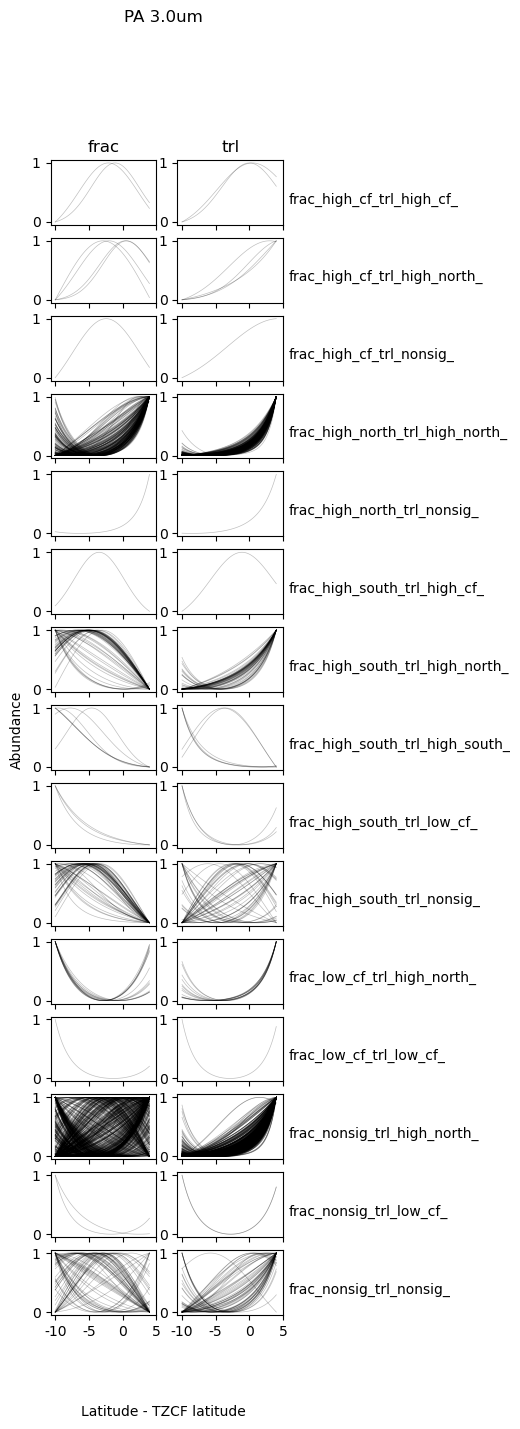

PA 0.2um


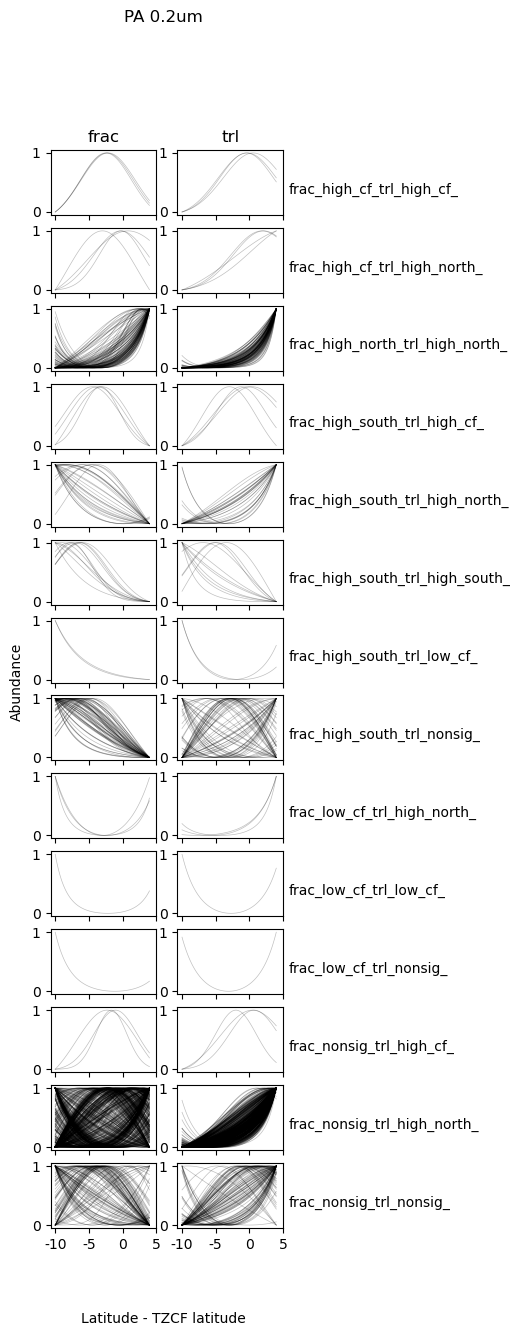

NS 3.0um


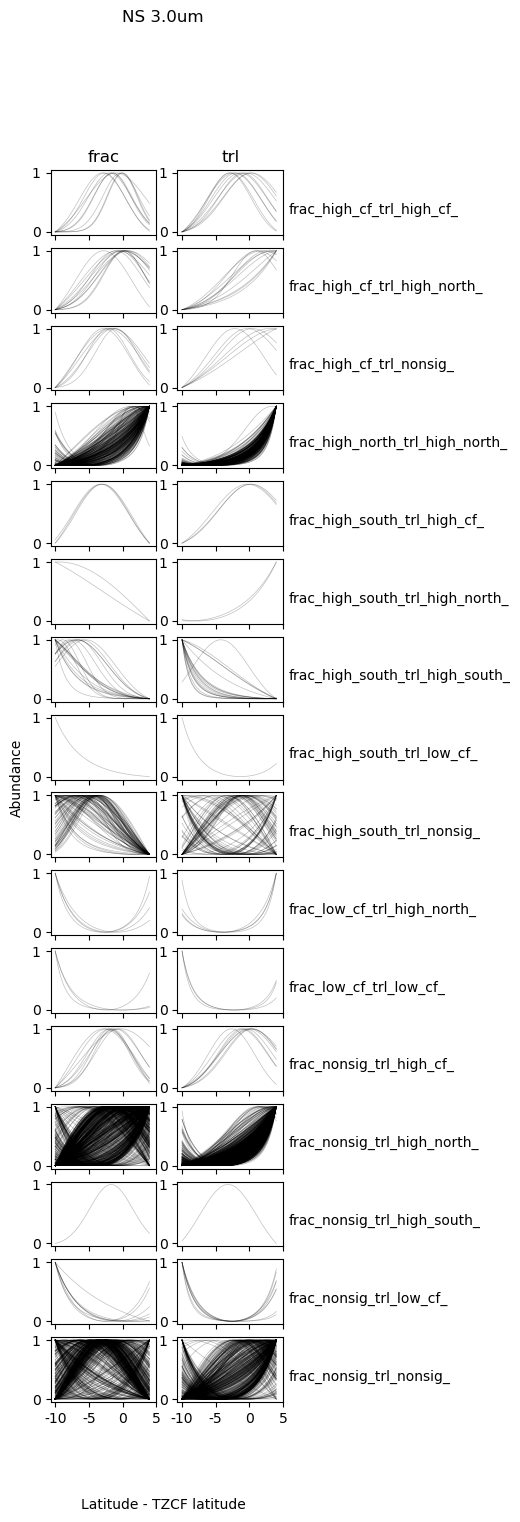

NS 0.2um


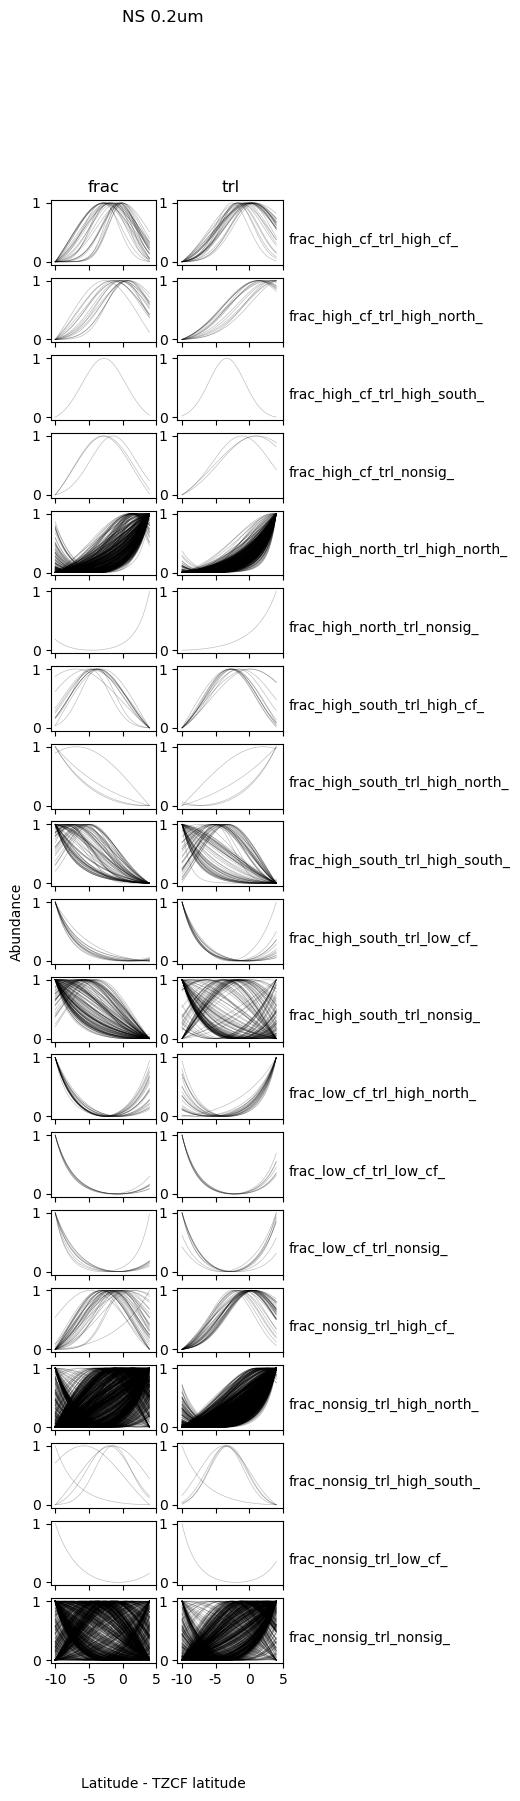

In [967]:
cnames = ['lat_diff','lat_diff^2']
x = np.linspace(-10,4,100)
lw = 0.5
alpha = 0.25
x = np.linspace(-10,4,100)

for sel, sz_dict in dict_sel_sz_ptype_taxa.items():
    for sz, ptype_dict in sz_dict.items():
        print(sel, sz)
        ptypes = sorted(list(ptype_dict.keys()))
        ptypes = [p for p in ptypes if all([s in p for s in ['frac','trl']])]  # Make sure both trl and frac are there (in case glm fitting failed on one)
        ntypes = len(ptypes)
        fig, axes = plt.subplots(ntypes, 2, figsize=(3,ntypes))
        for i, ptype in enumerate(ptypes):
            taxa = ptype_dict[ptype]
            for j, vt in enumerate(['frac','trl']):
                results = dict_valtype_sel_sz_glmresults[vt][sel][sz]
                ax = axes[i,j]
                for tax in taxa:
                    res = results[tax]
                    ld, ld2 = [res['model'][c] for c in cnames]
                    y = np.exp(ld*x + ld2*x**2)
                    mx = np.max(y)
                    mn = np.min(y)
                    y = (y - mn) / (mx - mn)
                    ax.plot(x,y,'k',lw=lw, alpha=alpha)
                if j == 1:
                    ax.set_ylabel(ptype, rotation=0, ha='left')
                    ax.yaxis.set_label_position("right")
                if i == 0:
                    ax.set_title(vt)
                xticks = np.arange(-10,10,5)
                ax.set_xticks(xticks)
                xticklabels = xticks if i == (ntypes - 1) else []
                ax.set_xticklabels(xticklabels)
        fig.text(-0.01, 0.5, f'Abundance', rotation=90, va='center',ha='left')
        fig.text(0.5, 0.05, f'Latitude - TZCF latitude', rotation=0, va='top',ha='center')
        fig.suptitle(f'{sel} {sz}')
        plt.show()


Get taxon trees for each group

In [969]:
for sel, sz_dict in dict_sel_sz_ptype_taxa.items():
    for sz, ptype_dict in sz_dict.items():
        ptypes = sorted(list(ptype_dict.keys()))
        ptypes = [p for p in ptypes if all([s in p for s in ['frac','trl']])]  # Make sure both trl and frac are there (in case glm fitting failed on one)
        ntypes = len(ptypes)
        for i, ptype in enumerate(ptypes):
            taxa = ptype_dict[ptype]
            taxfilt = []
            for t in taxa:
                try:
                    ncbi.get_taxid_translator([t])[int(t)]
                    taxfilt.append(t)
                except:
                    pass
            tree = ncbi.get_topology(taxfilt)
            for t in taxfilt:
                try:
                    tree[t].add_props(present='**')
                except:
                    pass
            print(vt, sel, sz, ptype)
            print(tree.to_str(props=['sci_name','present'],compact=True))


trl PA 3.0um frac_high_cf_trl_high_cf_
╴Pseudomonadati,⊗╶┬╴Shewanella psychrophila,**
                  ╰╴Chondromyces apiculatus DSM 436,**
trl PA 3.0um frac_high_cf_trl_high_north_
                      ╭╴Eukaryota,⊗╶┬╴Prorocentrum minimum,**
╴cellular organisms,⊗╶┤             ╰╴Xenotrichula sp. 184616417,**
                      ╰╴Pseudomonadati,⊗╶┬╴Desulfatibacillum alkenivorans AK-01,**
                                         ╰╴Marivirga tractuosa,**
trl PA 3.0um frac_high_cf_trl_nonsig_
                  ╭╴Pseudofrankia inefficax,⊗
                  ├╴Pseudofrankia saprophytica,⊗
                  ├╴Pseudofrankia asymbiotica,⊗
                  │                              ╭╴Pseudofrankia sp. DC12,⊗
╴Pseudofrankia,**╶┤                              ├╴Pseudofrankia sp. NRRL B-16323,⊗
                  ├╴unclassified Pseudofrankia,⊗╶┼╴Pseudofrankia sp. NRRL B-16512,⊗
                  │                              ├╴Pseudofrankia sp. BMG5.36,⊗
                  │               

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



trl NS 3.0um frac_low_cf_trl_low_cf_
                      ╭╴Chroococcales,⊗╶┬╴Crocosphaera subtropica ATCC 51142,**
╴cellular organisms,⊗╶┤                 ╰╴Microcystis aeruginosa NIES-843,**
                      ╰╴Astrosyne radiata,**
trl NS 3.0um frac_nonsig_trl_high_cf_
                               ╭╴Gammaproteobacteria,⊗╶┬╴SAR86 cluster bacterium AG-422-P06,**
            ╭╴Pseudomonadati,⊗╶┤                       ╰╴Alteromonas,**╶┬╴Alteromonas mediterranea U7,**
            │                  │                                        ╰╴Alteromonas macleodii str. 'Black Sea 11',**
╴Bacteria,⊗╶┤                  ╰╴Pelobacter seleniigenes DSM 18267,**
            │             ╭╴Synechococcales,⊗╶┬╴Prochlorococcus sp. scB245a_520K10,**
            ╰╴Bacillati,⊗╶┤                   ╰╴Synechococcus sp. AG-670-B23,**
                          ╰╴unclassified Acidimicrobiales,**
trl NS 3.0um frac_nonsig_trl_high_north_
                                                                  

In [ ]:
import numpy as np

def get_boxplot_stats(values):
    """
    Given a 1D array-like of values, return boxplot statistics:
    - min (lower whisker)
    - Q1 (25th percentile)
    - median (50th percentile)
    - Q3 (75th percentile)
    - max (upper whisker)
    - outliers (values outside whiskers)
    """
    values = np.asarray(values)
    q1 = np.percentile(values, 25)
    q3 = np.percentile(values, 75)
    median = np.percentile(values, 50)
    iqr = q3 - q1
    # Whiskers: 1.5*IQR from Q1 and Q3
    lower_whisker = np.min(values[values >= q1 - 1.5 * iqr]) if np.any(values >= q1 - 1.5 * iqr) else np.min(values)
    upper_whisker = np.max(values[values <= q3 + 1.5 * iqr]) if np.any(values <= q3 + 1.5 * iqr) else np.max(values)
    outliers = values[(values < lower_whisker) | (values > upper_whisker)]
    return {
        'min': lower_whisker,
        'q1': q1,
        'median': median,
        'q3': q3,
        'max': upper_whisker,
        'outliers': outliers
    }

# Example usage:
# arr = np.random.randn(100)
# stats = get_boxplot_stats(arr)
# print(stats)

## Phylum level patterns for biogeography synthesis

Load table

In [36]:
fmt_phylum_ns = '/mnt/nfs/projects/gradients-metat/BigTables/{cruise}_Collapsed_NS_sample_phylum_TaxNoTax.csv'
dict_cruise_dfphyns = {}
cruises = ['G1','G2','G3']
# cruises = ['G1','G2','G3']
for cruise in cruises:
    fn = fmt_phylum_ns.format(cruise=cruise)
    df = pd.read_csv(fn)
    dict_cruise_dfphyns[cruise] = df
    print(df.shape)

(1105, 11)
(1123, 11)
(1232, 11)


Inspect table

In [37]:
np.sort(dict_cruise_dfphyns['G3']['sample_name'].unique())

array(['G3.UW.NS.L25S1', 'G3.UW.NS.L29S1', 'G3.UW.NS.L31S2',
       'G3.UW.NS.L32S1', 'G3.UW.NS.L32S3', 'G3.UW.NS.L35S1',
       'G3.UW.NS.L35S2', 'G3.UW.NS.L37S1', 'G3.UW.NS.L38S1',
       'G3.UW.NS.L40S1', 'G3.UW.NS.L40S2'], dtype=object)

In [768]:
print(dict_cruise_dfphyns['G1'].columns)
print(dict_cruise_dfphyns['G1'][:3])

Index(['Unnamed: 0', 'group_name', 'raw_counts_A_sum', 'raw_counts_B_sum',
       'raw_counts_C_sum', 'transcripts_L_A_sum', 'transcripts_L_B_sum',
       'transcripts_L_C_sum', 'N_contigs', 'sample_name', 'phylum'],
      dtype='object')
   Unnamed: 0                  group_name  raw_counts_A_sum  raw_counts_B_sum  \
0           1  G1NS.S02C1_Acidobacteriota        1221.84804        1586.75902   
1           2   G1NS.S02C1_Actinomycetota       65184.58210       41954.86302   
2           3         G1NS.S02C1_Annelida        1967.93229        2138.81593   

   raw_counts_C_sum  transcripts_L_A_sum  transcripts_L_B_sum  \
0        1291.88522         2.264976e+06         2.427752e+06   
1       38349.79519         1.209849e+08         5.837016e+07   
2        1739.99454         3.646823e+06         3.213462e+06   

   transcripts_L_C_sum  N_contigs sample_name           phylum  
0         2.215545e+06        310  G1NS.S02C1  Acidobacteriota  
1         6.845501e+07       4567  G1NS.S02C1

Set up dict to get metadata

In [39]:
dict_snzinka_meta = {}
for i, row in metadata.iterrows():
    snzinka = f"{row['assembly']}.{row['sample']}"
    if row['cruise'] == 'G2':
        snzinka += '.15m'
    elif row['cruise'] == 'G3':
        sn = re.sub('UW','L', row['sample'])
        sn = re.sub('_','S', sn)
        snzinka = f"{row['assembly']}.{sn}"
    if snzinka == 'G1NS.S10':
        snzinka = 'G1NS.S10.0'
    dict_snzinka_meta[snzinka] = row.to_dict()

Convert to glm prediction dataframe

In [41]:
dict_cruise_tax_snzinka_trl = defaultdict(lambda: defaultdict(dict))
for cruise in cruises:
    df = dict_cruise_dfphyns[cruise]
    for i, row in df.iterrows():
        for rep in ['A','B','C']:
            col_trl = f'transcripts_L_{rep}_sum'
            sn = row['sample_name']
            sn_rep = f"{sn}-{rep}"
            dict_cruise_tax_snzinka_trl[cruise][row['phylum']][sn_rep] = row[col_trl]



In [42]:
dict_cruise_dftaxsnrep = {}
for cruise in cruises:
    d = dict_cruise_tax_snzinka_trl[cruise]
    df = pd.DataFrame(d).fillna(0)
    dict_cruise_dftaxsnrep[cruise] = df


Remove samples and taxa with all zeros

In [46]:
for cruise in cruises:
    df = dict_cruise_dftaxsnrep[cruise]
    print(df.shape)
    bool_allzero = df.sum(axis=1) != 0
    dict_cruise_dftaxsnrep[cruise] = df[bool_allzero]
    print(sum(bool_allzero > 0))


(30, 113)
22
(30, 113)
30
(33, 113)
25


In [50]:
df[bool_allzero].index

Index(['G3.UW.NS.L25S1-A', 'G3.UW.NS.L25S1-B', 'G3.UW.NS.L29S1-B',
       'G3.UW.NS.L32S1-A', 'G3.UW.NS.L32S3-A', 'G3.UW.NS.L32S3-B',
       'G3.UW.NS.L32S3-C', 'G3.UW.NS.L35S1-A', 'G3.UW.NS.L35S1-B',
       'G3.UW.NS.L35S1-C', 'G3.UW.NS.L35S2-A', 'G3.UW.NS.L35S2-B',
       'G3.UW.NS.L35S2-C', 'G3.UW.NS.L37S1-A', 'G3.UW.NS.L37S1-B',
       'G3.UW.NS.L37S1-C', 'G3.UW.NS.L38S1-A', 'G3.UW.NS.L38S1-B',
       'G3.UW.NS.L38S1-C', 'G3.UW.NS.L40S1-A', 'G3.UW.NS.L40S1-B',
       'G3.UW.NS.L40S1-C', 'G3.UW.NS.L40S2-A', 'G3.UW.NS.L40S2-B',
       'G3.UW.NS.L40S2-C'],
      dtype='object')

Convert to relative abundance

In [787]:
value_types = ['trl','frac']
dict_cruise_vt_dftaxsnrep = defaultdict(dict)
for cruise in cruises:
    df = dict_cruise_dftaxsnrep[cruise]
    dict_cruise_vt_dftaxsnrep[cruise]['trl'] = df
    df_frac = df.div(df.sum(axis=1), axis=0)
    dict_cruise_vt_dftaxsnrep[cruise]['frac'] = df_frac



Get latitudes for samples

In [791]:
for cruise in cruises:
    df = dict_cruise_dftaxsnrep[cruise]
    tzcf = dict_cruise_trans_sal_chl[cruise][1]
    lat_diffs = []
    for sn_rep in df.index:
        snzinka = sn_rep.split('-')[0]
        lat = dict_snzinka_meta[snzinka]['latitude']
        lat = float(lat.strip('deg'))
        lat_diffs.append(lat - tzcf)
    for vt in value_types:
        dict_cruise_vt_dftaxsnrep[cruise][vt]['lat_diff'] = lat_diffs
        dict_cruise_vt_dftaxsnrep[cruise][vt]['cruise'] = cruise


Fit glm curves for each taxon in each cruise

In [792]:
dict_cruise_vt_glmresults = defaultdict(dict)
for cruise in cruises:
    for vt in value_types:
        df = dict_cruise_vt_dftaxsnrep[cruise][vt]
        response_cols = [c for c in df.columns if c not in ['lat_diff','cruise','rep']]
        results = fit_many_models(
            data=df,
            response_cols=response_cols,
            covariate_cols=['lat_diff'],
            poly_cols=['lat_diff'], 
            poly_degree=2,
            iqr_coefficient=10,
            perm_test_vars=['lat_diff'], 
            n_perm=1000, 
            stat='coef',
            random_state=None,
            n_jobs=116,
        )
        dict_cruise_vt_glmresults[cruise][vt] = results


[Parallel(n_jobs=116)]: Using backend LokyBackend with 116 concurrent workers.
[Parallel(n_jobs=116)]: Done   2 out of 113 | elapsed:   26.2s remaining: 24.3min
[Parallel(n_jobs=116)]: Done  14 out of 113 | elapsed:   32.0s remaining:  3.8min
[Parallel(n_jobs=116)]: Done  26 out of 113 | elapsed:   33.8s remaining:  1.9min
[Parallel(n_jobs=116)]: Done  38 out of 113 | elapsed:   34.4s remaining:  1.1min
[Parallel(n_jobs=116)]: Done  50 out of 113 | elapsed:   35.3s remaining:   44.4s
[Parallel(n_jobs=116)]: Done  62 out of 113 | elapsed:   35.7s remaining:   29.4s
[Parallel(n_jobs=116)]: Done  74 out of 113 | elapsed:   36.5s remaining:   19.2s
[Parallel(n_jobs=116)]: Done  86 out of 113 | elapsed:   38.4s remaining:   12.1s
[Parallel(n_jobs=116)]: Done  98 out of 113 | elapsed:   43.0s remaining:    6.6s
[Parallel(n_jobs=116)]: Done 110 out of 113 | elapsed:   46.3s remaining:    1.3s
[Parallel(n_jobs=116)]: Done 113 out of 113 | elapsed:   47.5s finished
[Parallel(n_jobs=116)]: Using

Error for response column Nanoarchaeota: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.


[Parallel(n_jobs=116)]: Done   2 out of 113 | elapsed:   17.6s remaining: 16.3min
[Parallel(n_jobs=116)]: Done  14 out of 113 | elapsed:   22.3s remaining:  2.6min
[Parallel(n_jobs=116)]: Done  26 out of 113 | elapsed:   23.4s remaining:  1.3min
[Parallel(n_jobs=116)]: Done  38 out of 113 | elapsed:   24.3s remaining:   48.0s
[Parallel(n_jobs=116)]: Done  50 out of 113 | elapsed:   24.6s remaining:   31.0s
[Parallel(n_jobs=116)]: Done  62 out of 113 | elapsed:   25.1s remaining:   20.7s
[Parallel(n_jobs=116)]: Done  74 out of 113 | elapsed:   25.4s remaining:   13.4s
[Parallel(n_jobs=116)]: Done  86 out of 113 | elapsed:   25.7s remaining:    8.1s
[Parallel(n_jobs=116)]: Done  98 out of 113 | elapsed:   26.0s remaining:    4.0s
[Parallel(n_jobs=116)]: Done 110 out of 113 | elapsed:   26.6s remaining:    0.7s
[Parallel(n_jobs=116)]: Done 113 out of 113 | elapsed:   26.8s finished
[Parallel(n_jobs=116)]: Using backend LokyBackend with 116 concurrent workers.


Error for response column Nanoarchaeota: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.


[Parallel(n_jobs=116)]: Done   2 out of 113 | elapsed:   18.7s remaining: 17.3min
[Parallel(n_jobs=116)]: Done  14 out of 113 | elapsed:   24.5s remaining:  2.9min
[Parallel(n_jobs=116)]: Done  26 out of 113 | elapsed:   26.5s remaining:  1.5min
[Parallel(n_jobs=116)]: Done  38 out of 113 | elapsed:   27.4s remaining:   54.1s
[Parallel(n_jobs=116)]: Done  50 out of 113 | elapsed:   27.9s remaining:   35.2s
[Parallel(n_jobs=116)]: Done  62 out of 113 | elapsed:   28.8s remaining:   23.6s
[Parallel(n_jobs=116)]: Done  74 out of 113 | elapsed:   29.6s remaining:   15.6s
[Parallel(n_jobs=116)]: Done  86 out of 113 | elapsed:   31.7s remaining:   10.0s
[Parallel(n_jobs=116)]: Done  98 out of 113 | elapsed:   37.2s remaining:    5.7s
[Parallel(n_jobs=116)]: Done 110 out of 113 | elapsed:   39.9s remaining:    1.1s
[Parallel(n_jobs=116)]: Done 113 out of 113 | elapsed:   41.0s finished
[Parallel(n_jobs=116)]: Using backend LokyBackend with 116 concurrent workers.
[Parallel(n_jobs=116)]: Done 

Group taxa by coefficients

In [793]:
dict_cruise_vt_tax_sgn = defaultdict(lambda: defaultdict(dict))
for cruise in cruises:
    for vt in value_types:
        results = dict_cruise_vt_glmresults[cruise][vt]
        for tax, res in results.items():
            pval = res['perm_pvalues']['p_value'][cnames[0]]
            sgn = 0
            if pval < thresh_p:
                coeffs = [res['model'][c] for c in cnames]
                sgn = np.sign(coeffs[0])
            dict_cruise_vt_tax_sgn[cruise][vt][tax] = sgn


In [794]:
sgns = []
dict_cruise_vt_sgn_taxa = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for cruise, dict_vt_tax_sgn in dict_cruise_vt_tax_sgn.items():
    for vt, dict_tax_sgn in dict_vt_tax_sgn.items():
        for tax, sgn in dict_tax_sgn.items():
            sgns.append(sgn)
            dict_cruise_vt_sgn_taxa[cruise][vt][sgn].append(tax)
    sgns = list(set(sgns))

Plot curves grouped by type

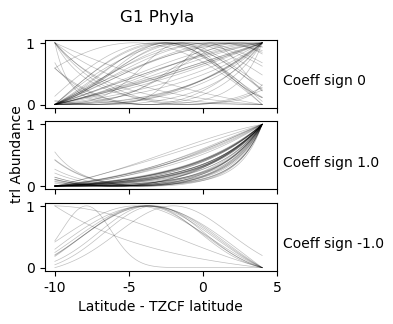

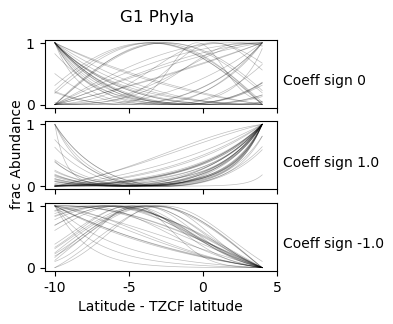

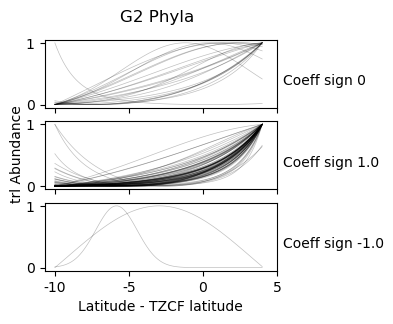

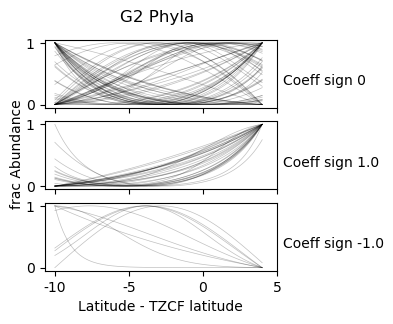

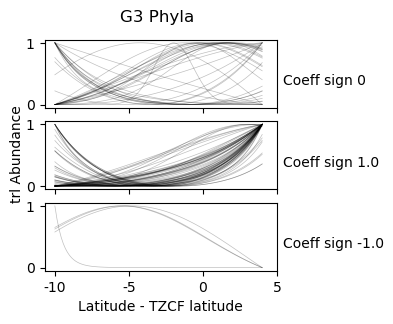

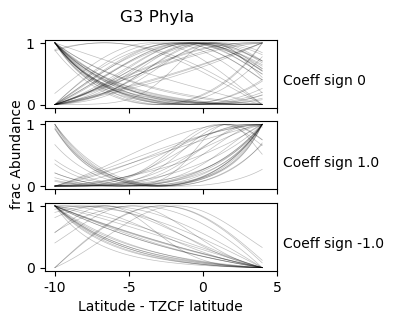

In [795]:
for cruise in cruises:
    for vt in value_types:
        results = dict_cruise_vt_glmresults[cruise][vt]
        fig, axes = plt.subplots(3,1, figsize=(3,3))
        for i, ptype in enumerate(sgns):
            taxa = dict_cruise_vt_sgn_taxa[cruise][vt][ptype]
            ax = axes[i]
            for tax in taxa:
                res = results[tax]
                ld, ld2 = [res['model'][c] for c in cnames]
                y = np.exp(ld*x + ld2*x**2)
                mx = np.max(y)
                mn = np.min(y)
                y = (y - mn) / (mx - mn)
                ax.plot(x,y,'k',lw=lw, alpha=alpha)
            ax.set_ylabel(f'Coeff sign {ptype}', rotation=0, ha='left')
            ax.yaxis.set_label_position("right")
            if i == 2:
                ax.set_xlabel('Latitude - TZCF latitude')
            xticks = np.arange(-10,10,5)
            ax.set_xticks(xticks)
            xticklabels = xticks if i == 2 else []
            ax.set_xticklabels(xticklabels)
        fig.text(0.01, 0.5, f'{vt} Abundance', rotation=90, va='center',ha='left')
        fig.suptitle(f'{cruise} Phyla')
        plt.show()

Group taxa by combination of trl and frac

In [796]:
dict_cruise_tax_ptypes = defaultdict(lambda: defaultdict(str))
for cruise, dict_vt_tax_sgn in dict_cruise_vt_tax_sgn.items():
    for vt, dict_tax_sgn in dict_vt_tax_sgn.items():
        for tax, sgn in dict_tax_sgn.items():
            dict_cruise_tax_ptypes[cruise][tax] += f'{vt}_{sgn}-'

In [798]:
dict_cruise_ptypes_taxa = defaultdict(lambda: defaultdict(list))
for cruise, tax_dict in dict_cruise_tax_ptypes.items():
    for tax, ptype in tax_dict.items():
        dict_cruise_ptypes_taxa[cruise][ptype].append(tax)

Plot grouped taxa by trl and frac

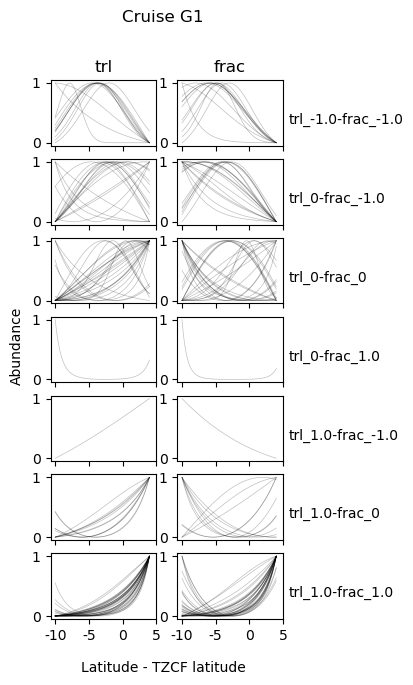

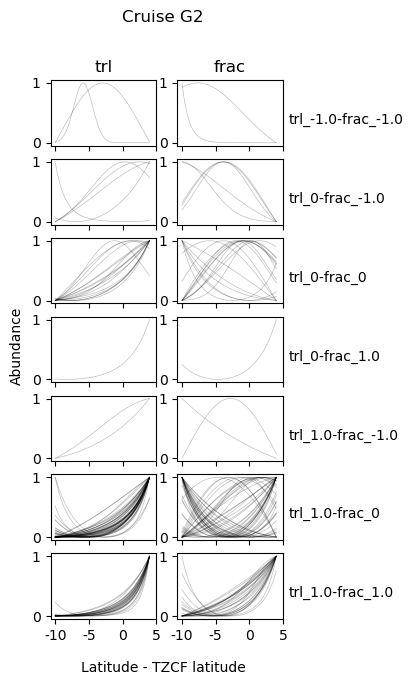

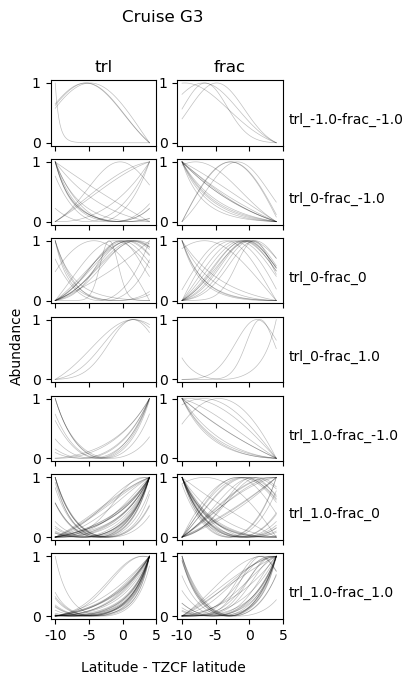

In [799]:
cnames = ['lat_diff','lat_diff^2']
x = np.linspace(-10,4,100)
lw = 0.5
alpha = 0.25
x = np.linspace(-10,4,100)

for cruise, ptype_dict in dict_cruise_ptypes_taxa.items():
    ptypes = sorted(list(ptype_dict.keys()))
    ptypes = [p for p in ptypes if all([s in p for s in ['frac','trl']])]  # Make sure both trl and frac are there (in case glm fitting failed on one)
    ntypes = len(ptypes)
    fig, axes = plt.subplots(ntypes, 2, figsize=(3,ntypes))
    for i, ptype in enumerate(ptypes):
        taxa = ptype_dict[ptype]
        for j, vt in enumerate(value_types):
            results = dict_cruise_vt_glmresults[cruise][vt]
            ax = axes[i,j]
            for tax in taxa:
                res = results[tax]
                ld, ld2 = [res['model'][c] for c in cnames]
                y = np.exp(ld*x + ld2*x**2)
                mx = np.max(y)
                mn = np.min(y)
                y = (y - mn) / (mx - mn)
                ax.plot(x,y,'k',lw=lw, alpha=alpha)
            if j == 1:
                ax.set_ylabel(ptype[:-1], rotation=0, ha='left')
                ax.yaxis.set_label_position("right")
            if i == 0:
                ax.set_title(vt)
            xticks = np.arange(-10,10,5)
            ax.set_xticks(xticks)
            xticklabels = xticks if i == (ntypes - 1) else []
            ax.set_xticklabels(xticklabels)
    fig.text(-0.01, 0.5, f'Abundance', rotation=90, va='center',ha='left')
    fig.text(0.5, 0.05, f'Latitude - TZCF latitude', rotation=0, va='top',ha='center')
    fig.suptitle(f'Cruise {cruise}')
    plt.show()


Annotate taxa by group with abundances

In [800]:
taxa_already_included = [
    "Arthopoda", "Bacillariophyta", "Chlorophyta", "Chrysophyceae", "Ciliophora", "Cryptophyceae", 
    "Cyanobacteriota", "Dictyochophyceae", "Dinoflagellata", "Euglenozoa", "Haptophyta", "Unannotated",
    "Acidobacteriota", "Pseudomonadota", "Bacteroidota", "Deltaproteobacteria", "Bacillota", "Actinomycetota", "Verrucomicrobiota",
    "MAST-3-4", "Pelagophyceae", "Bolidophyceae", "Streptophyta", "Prasinodermophyta"
]
for cruise, dict_ptypes_taxa in dict_cruise_ptypes_taxa.items():
    for ptype, taxa in dict_ptypes_taxa.items():
        print(cruise, ptype)
        mxs = []
        for tax in taxa:
            df = dict_cruise_vt_dftaxsnrep[cruise]['frac']
            max_frac = df[tax].max()
            mxs.append(max_frac)
        tax_sort = [x for _, x in sorted(zip(mxs, taxa),reverse=True)]
        mxs_sort = sorted(mxs,reverse=True)
        for tax, mx in zip(tax_sort, mxs_sort):
            txprnt = tax
            if tax in taxa_already_included:
                txprnt = tax + ' **'
            print('\t',mx,'\t',txprnt)

G1 trl_0-frac_-1.0-
	 0.27307510017308084 	 Dinoflagellata **
	 0.01848954980095165 	 Dictyochophyceae **
	 0.00663280240317955 	 MAST-3-4 **
	 0.0015925633524887888 	 Actinomycetota **
	 0.001173456452449097 	 Deltaproteobacteria **
	 0.0004310551522611396 	 Phaeophyceae
	 0.00019123004179509267 	 Euryarchaeota
	 0.00015307897617089066 	 Xanthophyceae
	 0.00011146653162248177 	 Thermodesulfobacteriota
	 4.696270502522001e-05 	 Campylobacterota
	 3.917967707690219e-05 	 Balneolota
	 1.8676493190835192e-05 	 Acidobacteriota **
	 1.573741950196345e-05 	 Candidatus-Moduliflexota
	 1.3971211970384664e-05 	 Lentisphaerota
	 1.0630645035793863e-05 	 Candidatus-Latescibacterota
	 9.864938328934918e-06 	 Deinococcota
	 9.530644245182291e-06 	 Nitrospirota
	 7.2599832165836185e-06 	 Synergistota
	 2.4153390827492604e-07 	 Coprothermobacterota
G1 trl_1.0-frac_1.0-
	 0.14103786270237512 	 Haptophyta **
	 0.10776761565319039 	 Chlorophyta **
	 0.06524567607212503 	 Arthropoda
	 0.02000855928197428

In [801]:
to_include = [
    'Arthropoda',
    'Choanoflagellata',
    'Cercozoa',
    'Nitrospinota',
    'Nitrososphaerota',
    'Evosea',
    'Bigyra',
    'Apicomplexa',
    'Eustigmatophyceae',
]

In [810]:
np.exp((np.log(16) - np.log(4)) / 2)

np.float64(2.0)

In [811]:
(16/4)**(1/2)

2.0

convert to biomass

In [ ]:
# From Coesel, et al. 2025 https://doi.org/10.1093/ismejo/wraf079

tax_to_convert = ['Bacillariophyta', 'Ciliophora', 'Haptophyta', 'Dictyochophyceae','Dinoflagellata']
dict_cruise_convfactors = {
    'G2':{
        'Dinoflagellata':[42.82, 0.98],
        'other':[6.64, 0.90]
    },
    'G3':{
        'Dinoflagellata':[7.67, 1.13],
        'other':[1.16, 1.03]
    }

}
dict_cruise_tax_ugcl = defaultdict(dict)
for cruise, df in dict_cruise_dftaxsnrep.items():
    for tax in df.columns:
        if (tax in tax_to_convert) & (cruise in dict_cruise_convfactors):
            if tax == 'Dinoflagellata':
                a, b = dict_cruise_convfactors[cruise][tax]
            else:
                a, b = dict_cruise_convfactors[cruise]['other']
            trl = df[tax]
            ugcl = ((trl/1e9)/a)**(1/b)
            dict_cruise_tax_ugcl[cruise][tax] = ugcl
        else:
            dict_cruise_tax_ugcl[cruise][tax] = pd.Series(
                np.zeros(df[tax].shape[0]),
                index=df[tax].index
            )



Get subset dataframes for scope synthesis 

In [823]:
taxa_sub = [
    'Arthropoda', 'Choanoflagellata', 'Cercozoa', 'Evosea', 'Bigyra','Apicomplexa','Eustigmatophyceae',
    "Bacillariophyta", "Chlorophyta", "Chrysophyceae", "Ciliophora", "Cryptophyceae", 
    "Cyanobacteriota", "Dictyochophyceae", "Dinoflagellata", "Euglenozoa", "Haptophyta", "Unannotated",
    "MAST-3-4", "Pelagophyceae", "Bolidophyceae", "Streptophyta", "Prasinodermophyta",
]
dict_cruise_sn_tax_vals = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(list)
    )
)
for cruise, dict_vt_dftaxsnrep in dict_cruise_vt_dftaxsnrep.items():
    # Tr/L and fractional abundance values 
    for vt, df in dict_vt_dftaxsnrep.items():
        print(vt)
        df_sub = df.copy()
        df_sub = df_sub[taxa_sub]
        sns = []
        for sn_rep in df.index:
            snzinka = sn_rep.split('-')[0]
            sns.append(snzinka)
        taxcols = df_sub.columns
        df_sub['sample_name'] = sns
        df_sub_mean = df_sub.groupby('sample_name')[taxcols].mean()
        df_sub_std = df_sub.groupby('sample_name')[taxcols].std()
        for index, mrow in df_sub_mean.iterrows():
            for tax, mean in mrow.items():
                std = df_sub_std.loc[index,tax]
                vals = [mean, std]
                dict_cruise_sn_tax_vals[cruise][index][tax] += vals
    # ug C / L conversion for specific taxa
    dict_tax_ugcl = dict_cruise_tax_ugcl[cruise]
    df = pd.DataFrame(dict_tax_ugcl)
    df_sub = df.copy()
    df_sub = df_sub[taxa_sub]
    sns = []
    for sn_rep in df.index:
        snzinka = sn_rep.split('-')[0]
        sns.append(snzinka)
    taxcols = df_sub.columns
    df_sub['sample_name'] = sns
    df_sub_mean = df_sub.groupby('sample_name')[taxcols].mean()
    df_sub_std = df_sub.groupby('sample_name')[taxcols].std()
    for tax in df_sub_mean.columns:
        col = df_sub_mean[tax]
        if (tax in tax_to_convert) & (cruise in dict_cruise_convfactors):
            for index, mean in col.items():
                std = df_sub_std.loc[index,tax]
                vals = [mean, std]
                dict_cruise_sn_tax_vals[cruise][index][tax] += vals
        else:
            for index in col.index:
                vals = ['nan','nan']
                dict_cruise_sn_tax_vals[cruise][index][tax] += vals




trl
frac
trl
frac
trl
frac


In [824]:
fn_out = '/scratch/bgrodner/relative_abundance/scope_synthesis_biogeography_metat.csv'
columns = [
    'cruise','sample_name','latitude', 'phylum',
    'transcripts_per_L_mean','transcripts_per_L_stdev',
    'fraction_of_total_reads_mean','fraction_of_total_reads_stdev',
    'ug_C_per_L_mean','ug_C_per_L_std'
]
with open(fn_out, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(columns)
    for cruise, dict_sn_tax_vals in dict_cruise_sn_tax_vals.items():
        for snzinka, dict_tax_vals in dict_sn_tax_vals.items():
            lat = dict_snzinka_meta[snzinka]['latitude']
            lat = float(lat.strip('deg'))
            for tax, vals in dict_tax_vals.items():
                row = [cruise, snzinka, lat, tax] + vals
                writer.writerow(row)
                

Check table

In [827]:
data = pd.read_csv(fn_out)
data.shape, data[:3]

((667, 10),
   cruise sample_name  latitude            phylum  transcripts_per_L_mean  \
 0     G1  G1NS.S02C1      23.5        Arthropoda            1.955274e+09   
 1     G1  G1NS.S02C1      23.5  Choanoflagellata            1.325809e+08   
 2     G1  G1NS.S02C1      23.5          Cercozoa            4.294946e+07   
 
    transcripts_per_L_stdev  fraction_of_total_reads_mean  \
 0             1.470092e+09                      0.014588   
 1             5.843123e+06                      0.001021   
 2             2.657664e+06                      0.000332   
 
    fraction_of_total_reads_stdev  ug_C_per_L_mean  ug_C_per_L_std  
 0                       0.010467              NaN             NaN  
 1                       0.000039              NaN             NaN  
 2                       0.000032              NaN             NaN  )

In [746]:
df_sub_mean.index

Index(['G2NS.S02C1.15m', 'G2NS.S05C1.15m', 'G2NS.S06C1.15m', 'G2NS.S07C1.15m',
       'G2NS.S09C1.15m', 'G2NS.S11C1.15m', 'G2NS.S15C1.15m', 'G2NS.S16C1.15m',
       'G2NS.S17C1.15m', 'G2NS.S18C1.15m'],
      dtype='object', name='sample_name')

In [642]:
fn_meta_g3uwns = '/scratch/bgrodner/repo-armbrust-metat/gradients2/g2_station_ns_metat/sample_metadata.csv'
meta_g3uwns = pd.read_csv(fn_meta_g3uwns)
meta_g3uwns[:3]

SampleID   Cruise  Station  Cast  Filter Replicate  \
0  G2.SURF.NS.S02C1.15m.0_2um.A  mgl1704        2     1     0.2         A   
1  G2.SURF.NS.S02C1.15m.0_2um.B  mgl1704        2     1     0.2         B   
2  G2.SURF.NS.S02C1.15m.0_2um.C  mgl1704        2     1     0.2         C   

   Depth       Datetime   Latitude   Longitude  SequencingID          Alias1  \
0     15  5/29/17 14:26  25.768333 -158.014167        301405  S2C1Surf0.2umA   
1     15  5/29/17 14:26  25.768333 -158.014167        301375  S2C1Surf0.2umB   
2     15  5/29/17 14:26  25.768333 -158.014167        301381  S2C1Surf0.2umC   

              Alias2 Notes  
0  S02C1.15m.0_2um.A  none  
1  S02C1.15m.0_2um.B  none  
2  S02C1.15m.0_2um.C  none

In [645]:
meta_g3uwns.loc[:,['Depth','Alias1']]

Depth           Alias1
0      15   S2C1Surf0.2umA
1      15   S2C1Surf0.2umB
2      15   S2C1Surf0.2umC
3      15     S2C1Surf3umA
4      15     S2C1Surf3umB
5      15     S2C1Surf3umC
6      15   S5C1Surf0.2umA
7      15   S5C1Surf0.2umB
8      15   S5C1Surf0.2umC
9      15     S5C1Surf3umA
10     15     S5C1Surf3umB
11     15     S5C1Surf3umC
12     15   S6C1Surf0.2umA
13     15   S6C1Surf0.2umB
14     15   S6C1Surf0.2umC
15     15     S6C1Surf3umA
16     15     S6C1Surf3umB
17     15     S6C1Surf3umC
18     15   S7C1Surf0.2umA
19     15   S7C1Surf0.2umB
20     15   S7C1Surf0.2umC
21     15     S7C1Surf3umA
22     15     S7C1Surf3umB
23     15     S7C1Surf3umC
24     15   S9C1Surf0.2umA
25     15   S9C1Surf0.2umB
26     15   S9C1Surf0.2umC
27     15     S9C1Surf3umA
28     15     S9C1Surf3umB
29     15     S9C1Surf3umC
30     15  S11C1Surf0.2umA
31     15  S11C1Surf0.2umB
32     15  S11C1Surf0.2umC
33     15    S11C1Surf3umA
34     15    S11C1Surf3umB
35     15    S11C1Surf3umC
36     15  S15C1Surf0.2umA
37     15  S15C1Surf0.2umB
38     15  S15C1Surf0.2umC
39     15    S15C1Surf3umA
40     15    S15C1Surf3umB
41     15    S15C1Surf3umC
42     15  S16C1Surf0.2umA
43     15  S16C1Surf0.2umB
44     15  S16C1Surf0.2umC
45     15    S16C1Surf3umA
46     15    S16C1Surf3umB
47     15    S16C1Surf3umC
48     15  S17C1Surf0.2umA
49     15  S17C1Surf0.2umB
50     15  S17C1Surf0.2umC
51     15    S17C1Surf3umA
52     15    S17C1Surf3umB
53     15    S17C1Surf3umC
54     15  S18C1Surf0.2umA
55     15  S18C1Surf0.2umB
56     15  S18C1Surf0.2umC
57     15    S18C1Surf3umA
58     15    S18C1Surf3umB
59     15    S18C1Surf3umC

In [779]:
np.sort(metadata.loc[metadata['assembly'] == 'G3.UW.NS','sample'].unique())

array(['UW25_1', 'UW29_1', 'UW31_2', 'UW32_1', 'UW32_3', 'UW35_1',
       'UW35_2', 'UW37_1', 'UW38_1', 'UW40_1', 'UW40_2'], dtype=object)

In [ ]:
for n, s in get_boxplot_stats(df_piv['trl'].values).items():
    s = f'{s:.2e}' if isinstance(s, float) else s
    print(f'{n} : {s}')

## Network connectivity

Test similarity matrix

In [ ]:
batch = 'G2_PA_3.0um'
s = dict_batch_sim2[batch]
# s = dict_valtype_batch_rhop['frac'][batch][0]

Calculate connectivity at different powers

In [ ]:
from numba import jit
@jit(nopython=True)
def compute_ks(s, nbs):
    n = s.shape[0]
    ks = np.zeros((nbs, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                sij = (s[i, j] + 1) / 2
                for b in range(nbs):
                    ks[b, i] += (sij)**b  # Note: b starts at 0, so (sij+1)^0 = 1, etc.
    return ks

In [ ]:
nbs = 20

# ks = defaultdict(list)
# for i, srow in enumerate(s):
#     k = defaultdict(float)
#     for j, sij in enumerate(srow):
#         # if sij > 0:
#         if i != j:
#             for b in range(nbs):
#                 k[b] += (sij + 1)**(b)
#     for b in range(nbs):
#         ks[b].append(k[b])

ks = compute_ks(s, nbs)


Plot connectivity

In [ ]:
b = 1
ksb = ks[b,:]
mn, mx = (min(ksb), max(ksb))
# kplot = np.linspace(1, mx, 10)
kplot = np.exp(np.linspace(np.log(1), np.log(mx), 10))
pks = [np.sum(ksb > k) / ksb.shape[0] for k in kplot]

fig, ax = plt.subplots()
ax.scatter(kplot, pks, color='k')
ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
fig, ax = plt.subplots()
ax.hist(ksb)

## Save cluster info

Get cluster info

In [ ]:
dict_batch_clust_taxa = defaultdict(dict)
for batch, s in dict_batch_sim2.items():
    if batch in dict_batch_t:
        t = dict_batch_t[batch]
        df = dict_valtype_batch_dfs['frac'][batch]
        taxa_df = df.columns.values
        d = 1-s
        link = hierarchy.linkage(distance.squareform(d, checks=False))
        clust = hierarchy.fcluster(link, t=t, criterion='distance')
        clust_unq = np.unique(clust)
        for cl in clust_unq:
            taxa = taxa_df[clust == cl].tolist()
            dict_batch_clust_taxa[batch][str(cl)] = taxa

Save clusters

In [ ]:
out_fn = '/scratch/bgrodner/relative_abundance/metat_search_results/spearman_correlations/dict_batch_clust_taxa-25_05_30.json'
with open(out_fn, 'w') as f:
    json.dump(dict_batch_clust_taxa, f, sort_keys=True, indent=4)

## Test PCA curves

Get PCA for each cluster

In [ ]:
thresh_ntaxa = 20
thresh_nonzero = 3
valtypes = ['frac','trl']
dict_batch_clust_valtype_pca = defaultdict(lambda: defaultdict(dict))
for batch, dict_clust_taxa in dict_batch_clust_taxa.items():
    dfs = [dict_valtype_batch_dfs[vt][batch] for vt in valtypes]
    for clust, taxa in dict_clust_taxa.items():
        if len(taxa) > thresh_ntaxa:
            n_nonzero = dfs[0][taxa].astype(bool).sum(axis=0).mean()
            if n_nonzero > thresh_nonzero:
                for vt, df in zip(valtypes, dfs):
                    df_cl = df[taxa]
                    pca = decomposition.PCA(n_components=1)
                    pca.fit(df_cl.values.T)
                    dict_batch_clust_valtype_pca[batch][clust][vt] = pca.components_.squeeze()





Plot example profile

In [ ]:
batch = 'G2_PA_3.0um'

dict_clust_valtype_pca = dict_batch_clust_valtype_pca[batch]
dict_clust_taxa = dict_batch_clust_taxa[batch]

ncols = 1
# nclst = np.sum(counts > filt_ntax)
nclst = len(dict_clust_valtype_pca)
rowmult = 4
nrows = nclst * rowmult
ft0=12

dict_assam_lat = dict(zip(metadata['assm_sample'], metadata['latitude']))
dict_assam_time = dict(zip(metadata['assm_sample'], metadata['timepoint']))

# initialize plot
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(ncols*5,nrows*1.5)
)
dict_vt_ylab = {
     'frac': 'Taxon fraction of estcounts',
     'trl': 'Taxon Tr/L',
}
cmap = list(plt.get_cmap('tab20').colors)
cmap *= math.ceil(nclst / len(cmap))
lut = dict(zip(dict_clust_valtype_pca.keys(),cmap))
for i, (cl, dict_valtype_pca) in enumerate(dict_clust_valtype_pca.items()):
    taxa = dict_clust_taxa[cl]
    for j, vt in enumerate(['frac','trl']):
        df = dict_valtype_batch_dfs[vt][batch]
        df_filt = df.copy()
        # df_filt = df.loc[:,bools_tax]
        df_filt = df_filt[taxa]
        i_ = i*rowmult + j
        ax = axes[i_]
        if batch == 'G3PA.diel_PA_0.2um':
            datetime = [dict_assam_time[a] for a in df_filt.index]
            date_time = [dt.split('-') for dt in datetime]
            date_time = [[d, t.zfill(5)] for d, t in date_time]
            datetime = [f'{d}-{t}' for d, t in date_time]
            df_filt[['date','time']] = date_time
            df_filt.index = datetime
            df_filt = df_filt.sort_values(by=['date','time'])
            df_filt = df_filt.drop(['date','time'], axis=1)
            xticks = np.arange(df_filt.shape[0])
            lats = xticks
            xticklab = df_filt.index
            rot = 45
        elif batch == 'D1PA_PA_nan':
            df_filt = df_filt.sort_index()
            xticks = np.arange(df_filt.shape[0])
            lats = xticks
            xticklab = df_filt.index
            rot = 45
        else:
            xticks = np.arange(25,45,5).astype(int)
            xticklab = xticks
            ax.set_xlim(20,45)
            lats = [float(dict_assam_lat[a].strip('deg')) for a in df_filt.index]
            rot = 0
        vals = df_filt.values
        vals /= np.max(vals, axis=0)
        bp = ax.boxplot(vals.T, positions=lats)
        color = lut[cl]
        for item in ['boxes', 'whiskers', 'fliers', 'caps']:
            plt.setp(bp[item], color=color)
        ax.set_xticks(xticks)
        xticklab = xticklab if i_ == nrows - 1 else []
        ax.set_xticklabels(xticklab, rotation=rot)
        ylab = dict_vt_ylab[vt]   
        ntaxa = len(taxa)
        ax.set_ylabel(f'Normalized {ylab}\nCluster {cl} (n taxa = {ntaxa})', rotation=0, fontsize=ft0, ha='right', va='center')
    # Plot PCA
    for j, vt in enumerate(['frac','trl']):
        i_ = i*rowmult + 2 + j
        ax = axes[i_]
        pca = dict_clust_valtype_pca[cl][vt]
        ax.scatter(lats, pca, color=color)
        if (batch != 'G3PA.diel_PA_0.2um') & (batch != 'D1PA_PA_nan'):
            ax.set_xlim(20,45)
        ax.set_xticks(xticks)
        xticklab = xticklab if i_ == nrows - 1 else []
        ax.set_xticklabels(xticklab, rotation=rot)
        ylab = dict_vt_ylab[vt]
        ntaxa = len(taxa)
        ax.set_ylabel(f'Normalized {ylab} PCA\nCluster {cl} (n taxa = {ntaxa})', rotation=0, fontsize=ft0, ha='right', va='center')
